In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import scipy
from scipy import stats
import math

In [ ]:
### reading data into notebook
train_identity = pd.read_csv(r'\\nfs.seas.wustl.edu\seaslab\home-lab\xinyunhang\Desktop\train_identity.csv')
test_identity = pd.read_csv(r'\\nfs.seas.wustl.edu\seaslab\home-lab\xinyunhang\Desktop\test_identity.csv')
test_transaction = pd.read_csv(r'\\nfs.seas.wustl.edu\seaslab\home-lab\xinyunhang\Desktop\test_transaction.csv')
train_transaction = pd.read_csv(r'\\nfs.seas.wustl.edu\seaslab\home-lab\xinyunhang\Desktop\train_transaction.csv')

#print features
print("Features in train_identity:\n", train_identity.columns.tolist())
print(train_identity.dtypes)
print("\nFeatures in train_transaction:\n", train_transaction.columns.tolist())
print(train_transaction.dtypes)
print("\nFeatures in test_identity:\n", test_identity.columns.tolist())
print(test_identity.dtypes)
print("\nFeatures in test_transaction:\n", test_transaction.columns.tolist())
print(test_transaction.dtypes)

In [3]:
#print null values
missing_train_identity = train_identity.isnull().sum()
missing_train_transaction = train_transaction.isnull().sum()
print("Missing values in train_identity: \n", missing_train_identity[missing_train_identity > 100000])
print("\nMissing values in train_transaction:\n", missing_train_transaction[missing_train_transaction > 500000])

Missing values in train_identity: 
 id_07    139078
id_08    139078
id_21    139074
id_22    139064
id_23    139064
id_24    139486
id_25    139101
id_26    139070
id_27    139064
dtype: int64

Missing values in train_transaction:
 dist2    552913
D6       517353
D7       551623
D8       515614
D9       515614
D12      525823
D13      528588
D14      528353
V138     508595
V139     508595
V140     508595
V141     508595
V142     508595
V143     508589
V144     508589
V145     508589
V146     508595
V147     508595
V148     508595
V149     508595
V150     508589
V151     508589
V152     508589
V153     508595
V154     508595
V155     508595
V156     508595
V157     508595
V158     508595
V159     508589
V160     508589
V161     508595
V162     508595
V163     508595
V164     508589
V165     508589
V166     508589
V322     508189
V323     508189
V324     508189
V325     508189
V326     508189
V327     508189
V328     508189
V329     508189
V330     508189
V331     508189
V332     508189


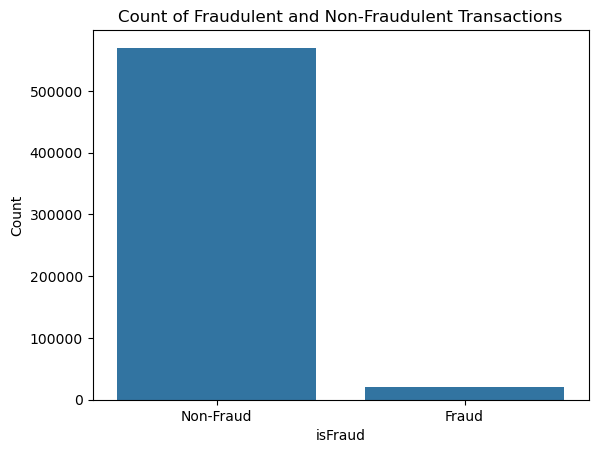

In [4]:
#Counts of Transactions Flagged Fraudulent
fraud_counts = train_transaction['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index.map({0:"Non-Fraud", 1:"Fraud"}), y=fraud_counts.values)
plt.ylabel('Count')
plt.title('Count of Fraudulent and Non-Fraudulent Transactions')
plt.show()

In [5]:
#Correlation between transaction amount and fraudulent classification of transactions.
correlation = train_transaction['TransactionAmt'].corr(train_transaction['isFraud'])
print(correlation)

0.011319825333215112


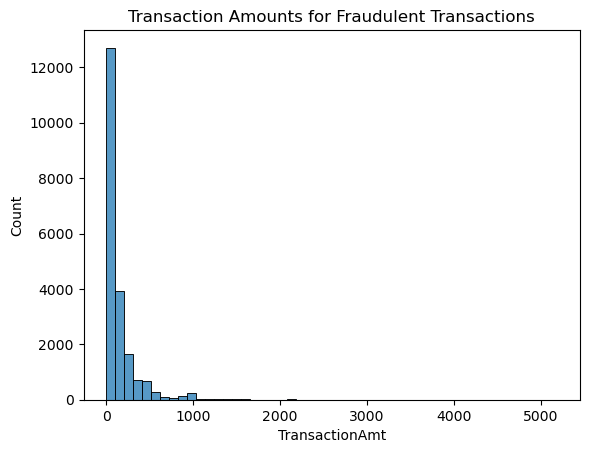

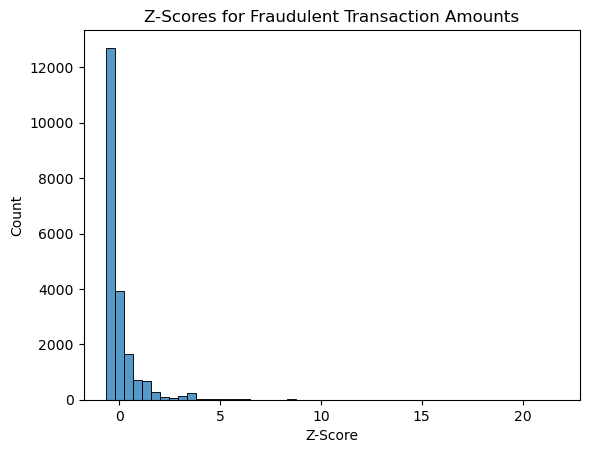

In [6]:
#Z-Test between isFraud and transactionAmt, Outlier Detection
fraudulent_transactions = train_transaction[train_transaction['isFraud']==1]
transaction_amounts = fraudulent_transactions['TransactionAmt']
z_scores = stats.zscore(transaction_amounts)

outliers = fraudulent_transactions[(z_scores > 3)|(z_scores < -3)]

sns.histplot(transaction_amounts, bins=50)
plt.title('Transaction Amounts for Fraudulent Transactions')
plt.show()

sns.histplot(z_scores, bins=50)
plt.title('Z-Scores for Fraudulent Transaction Amounts')
plt.xlabel('Z-Score')
plt.show()

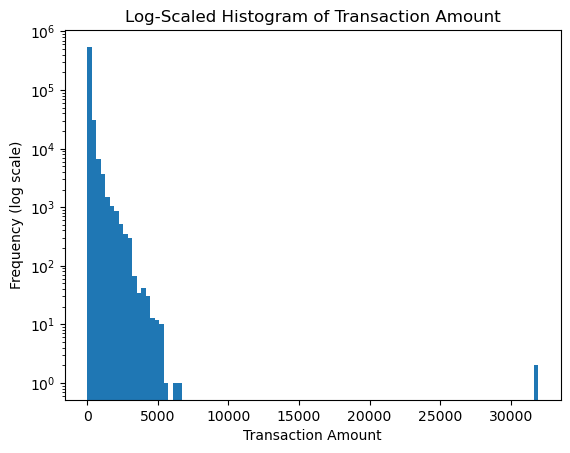

Fraud Ratio in Long-Tail Transactions: 0.024109200496365894


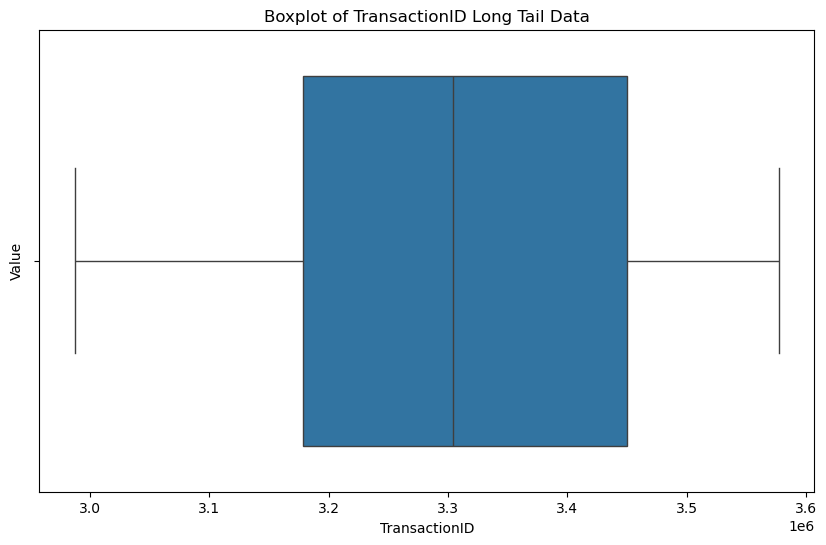

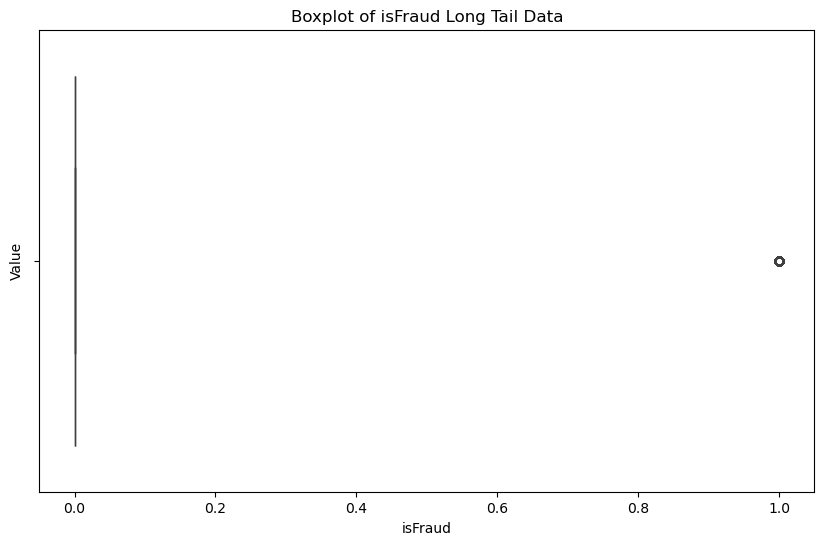

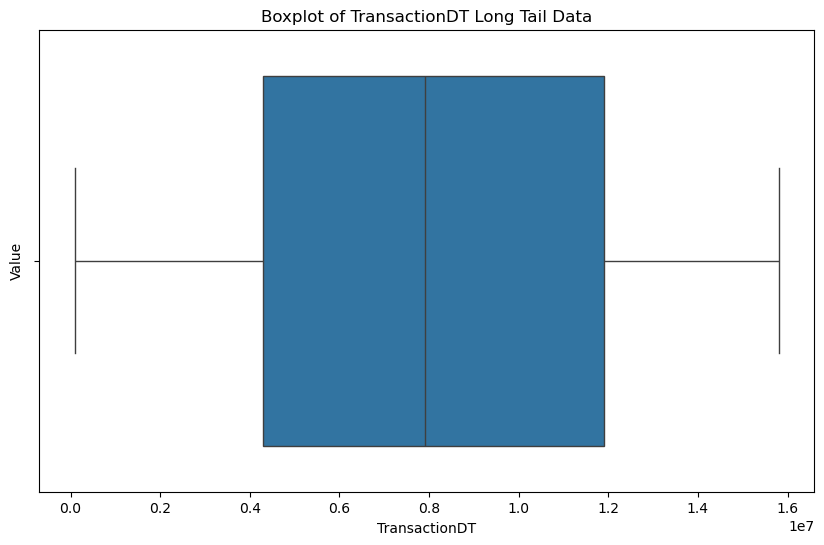

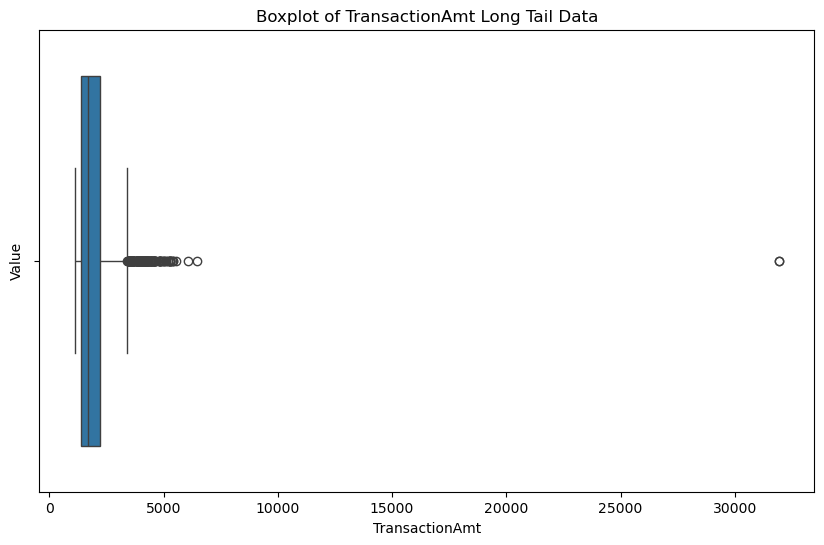

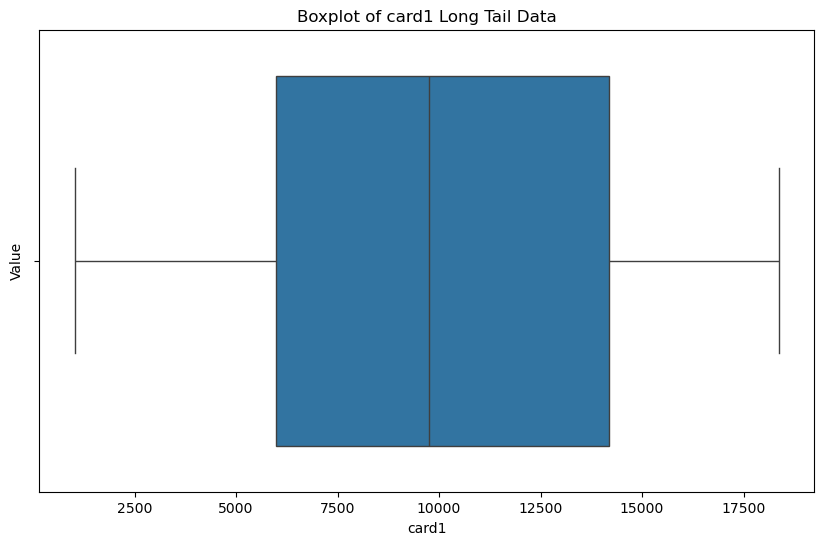

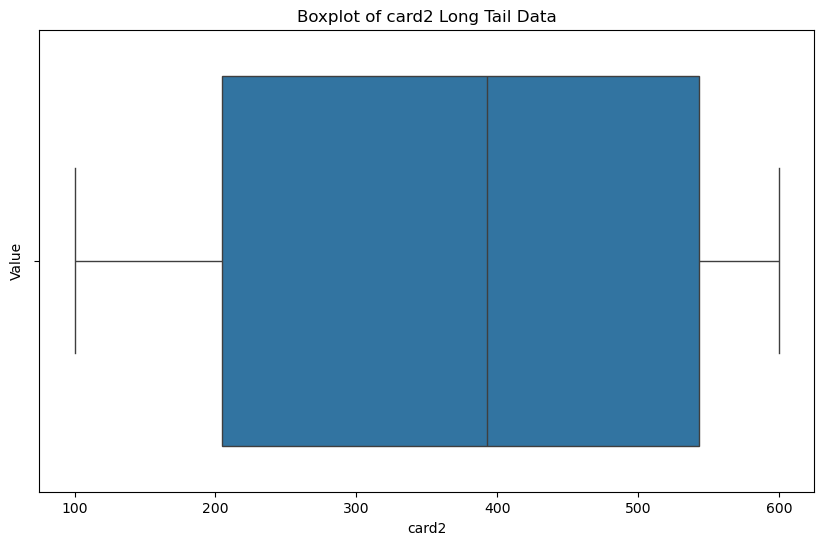

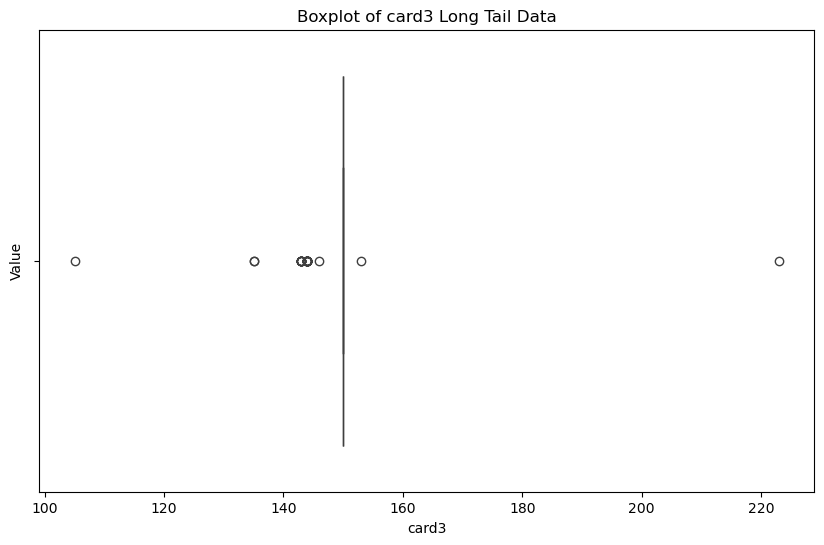

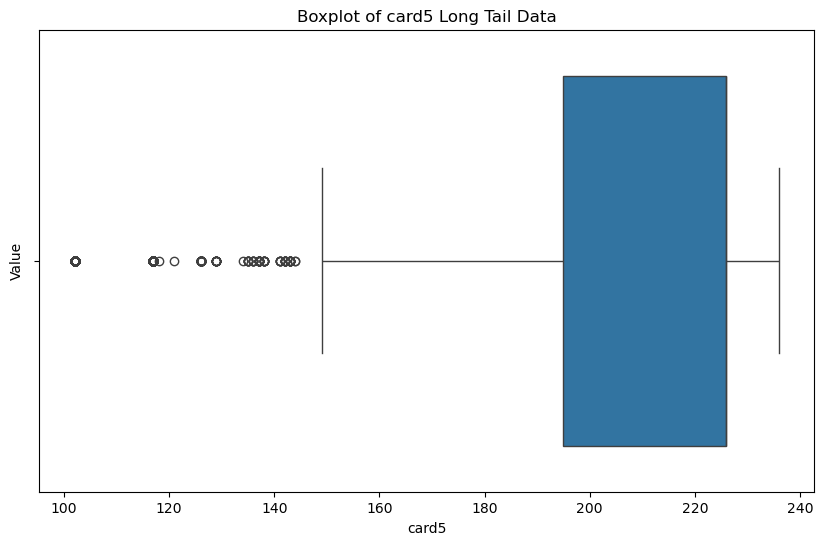

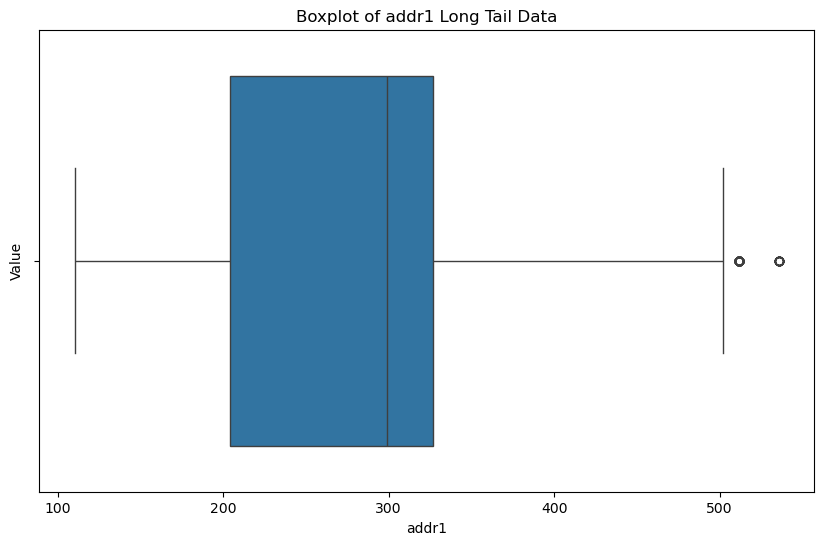

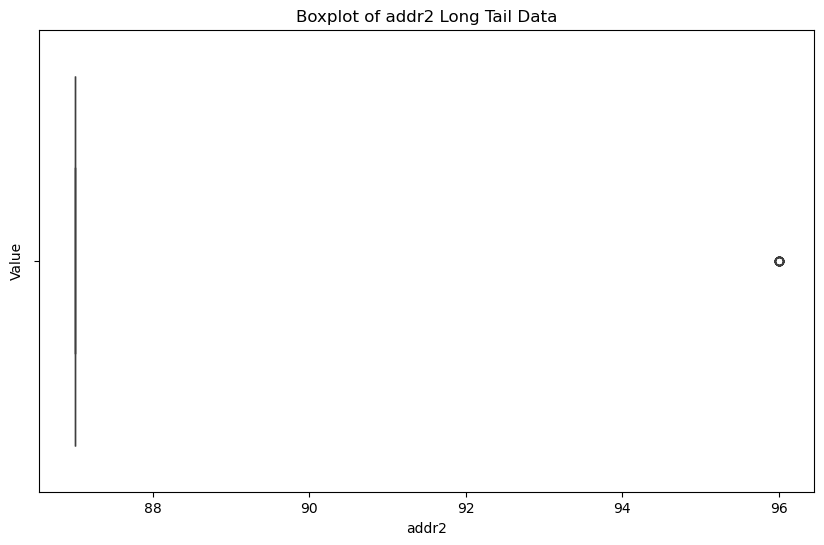

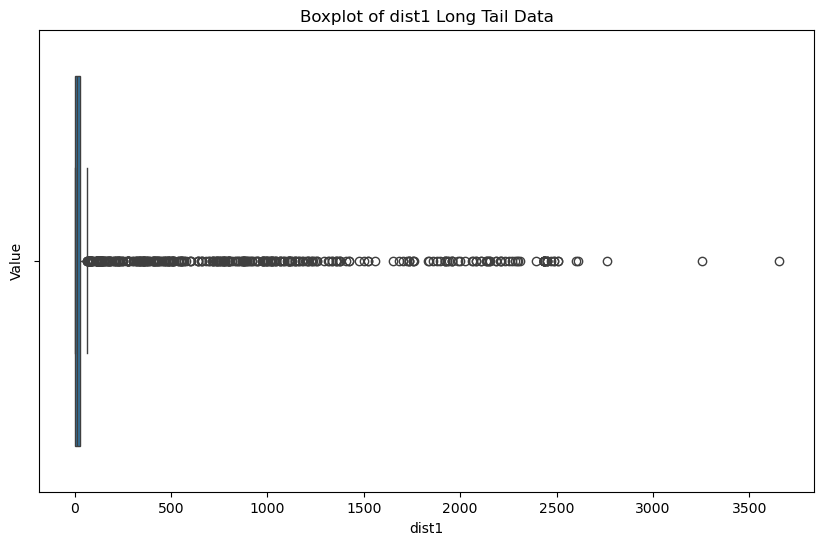

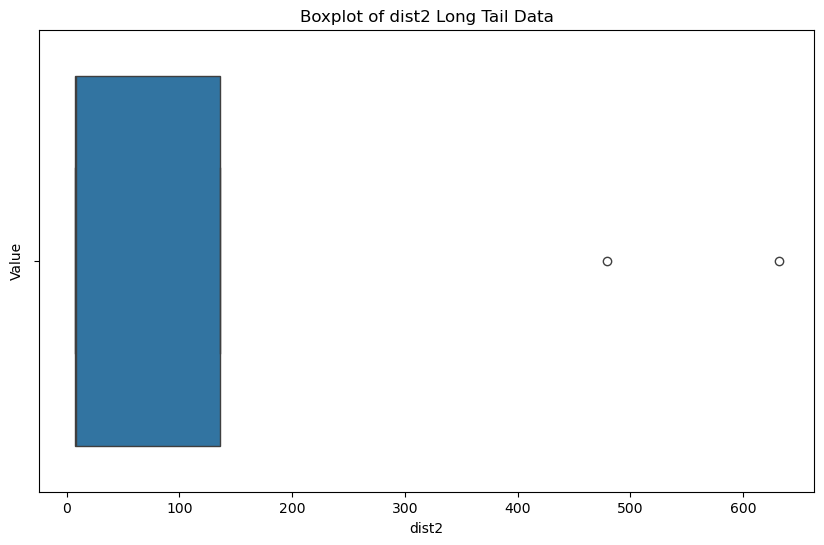

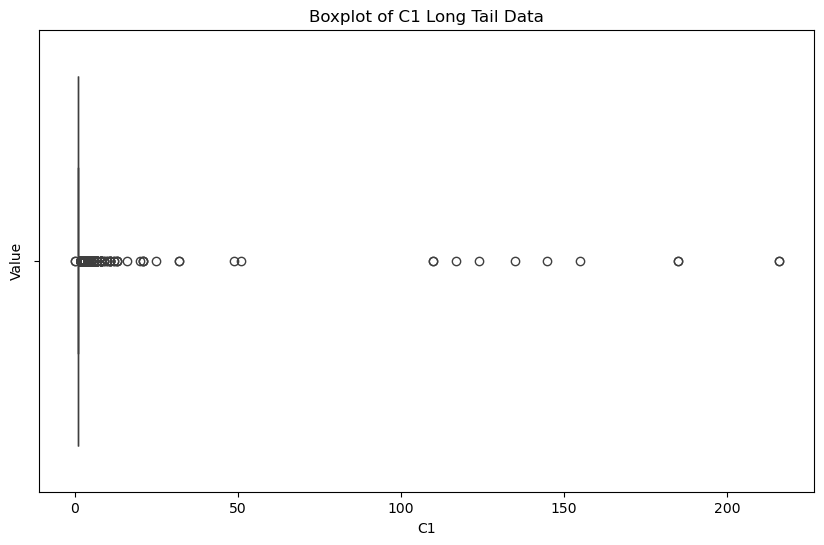

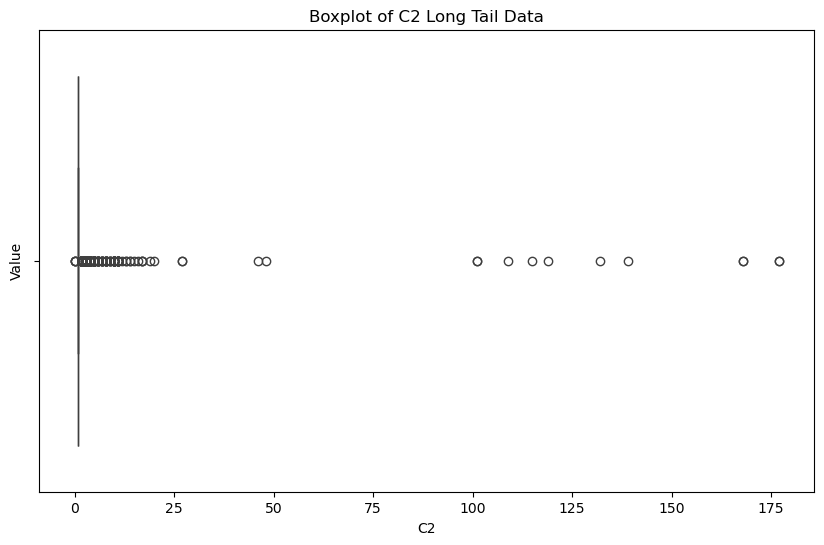

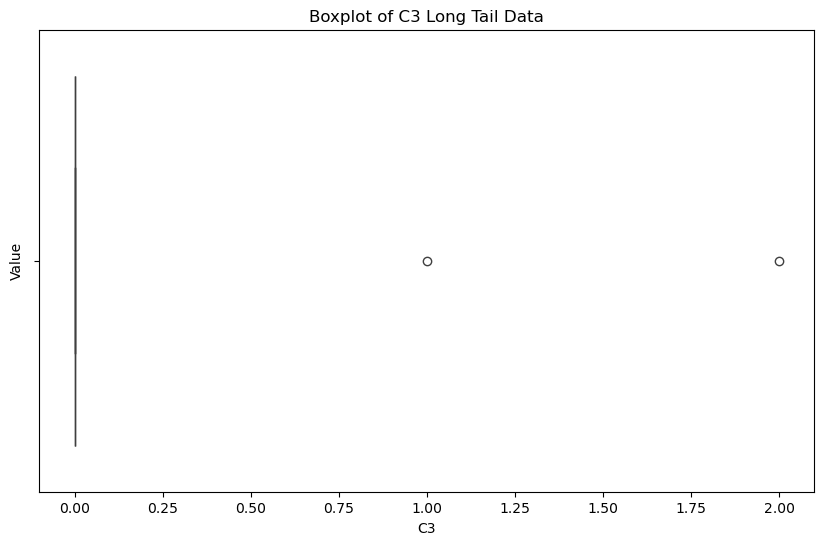

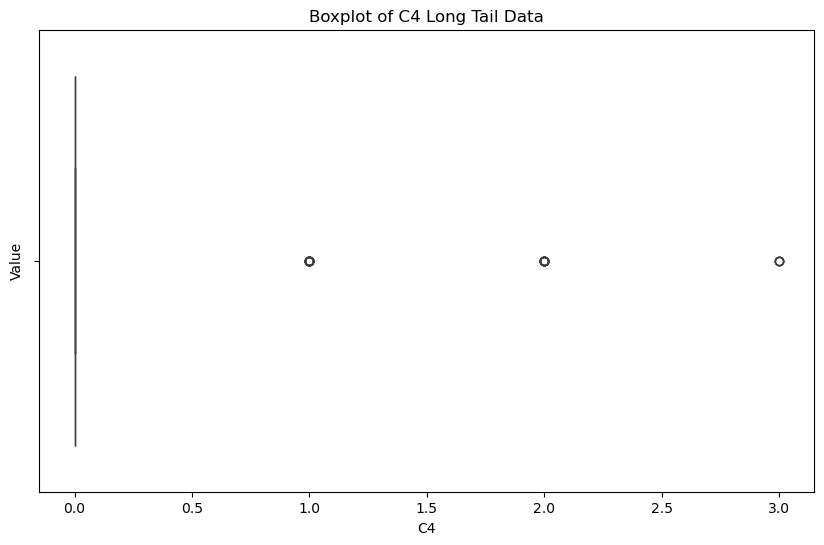

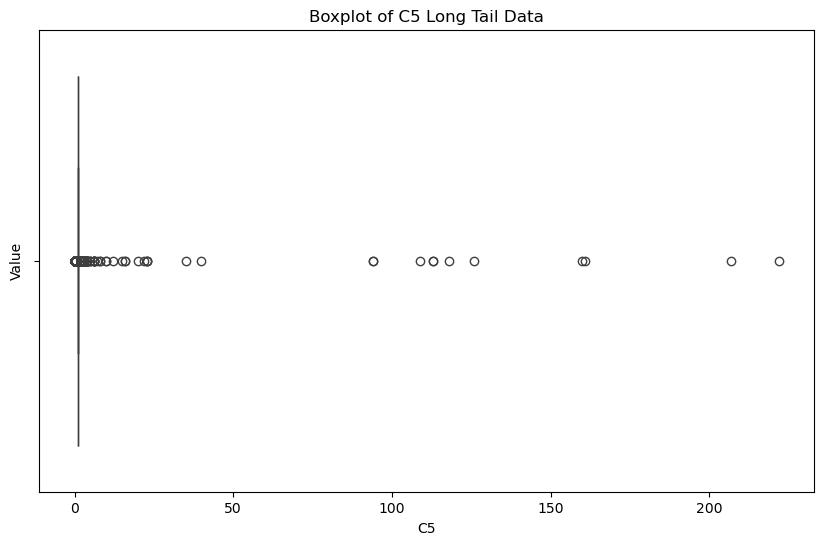

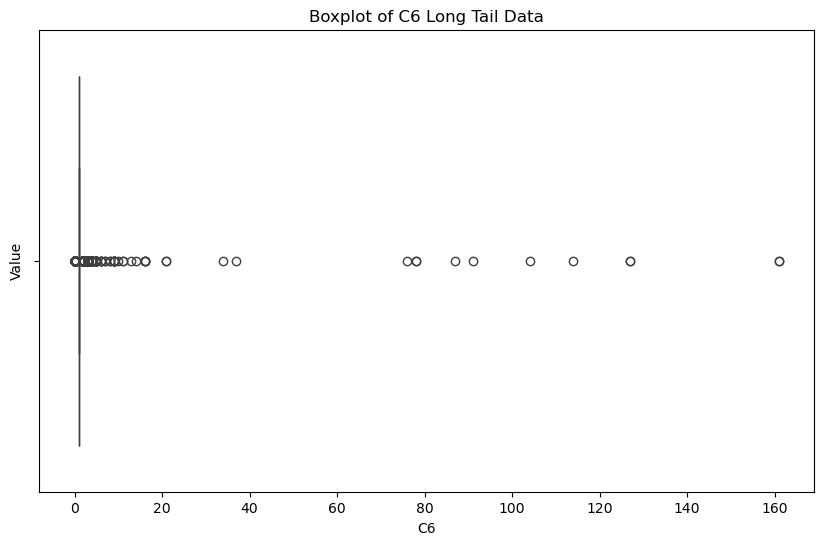

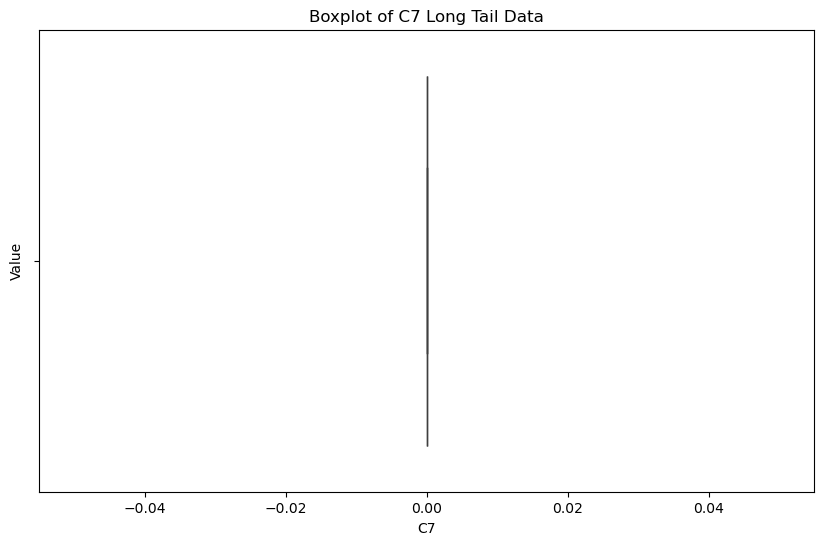

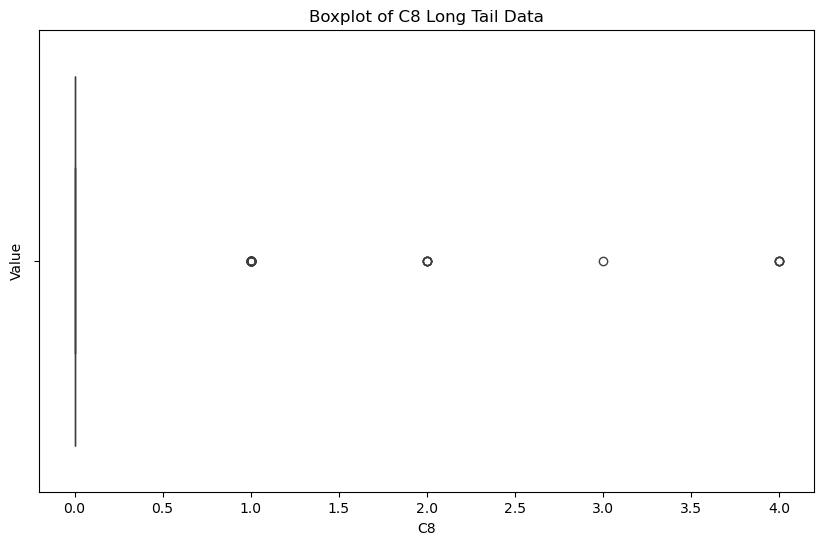

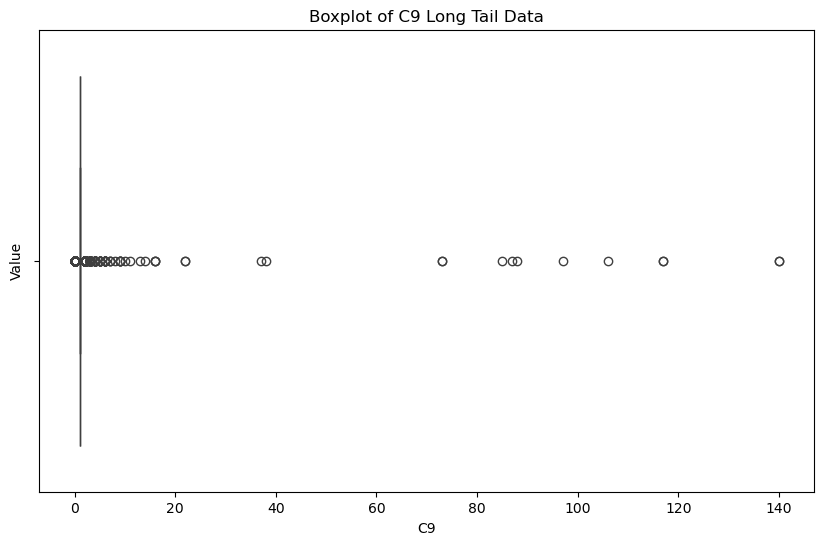

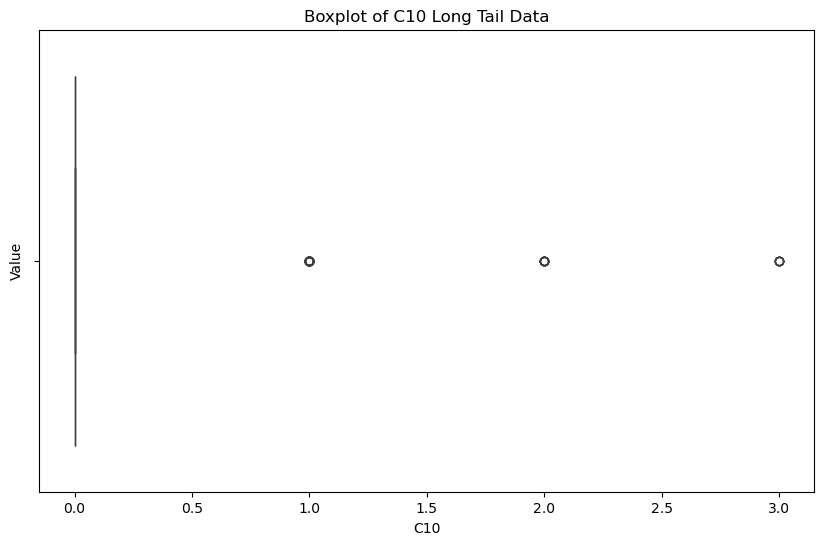

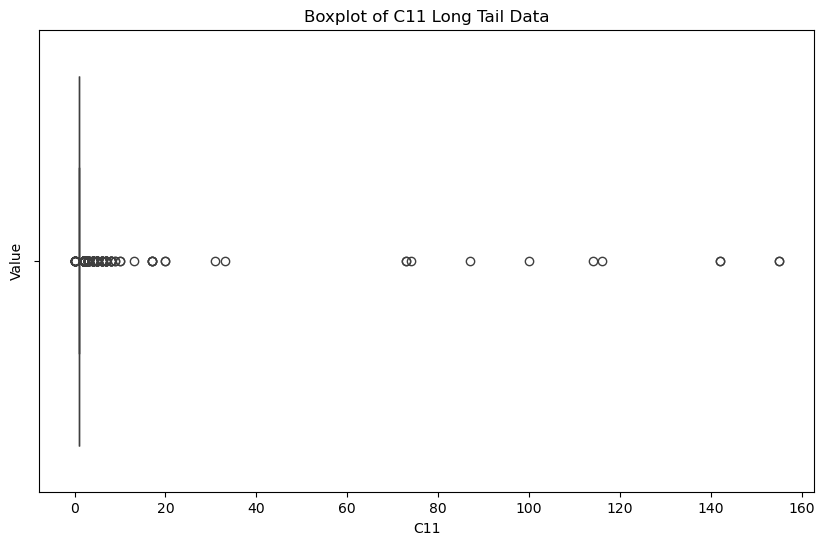

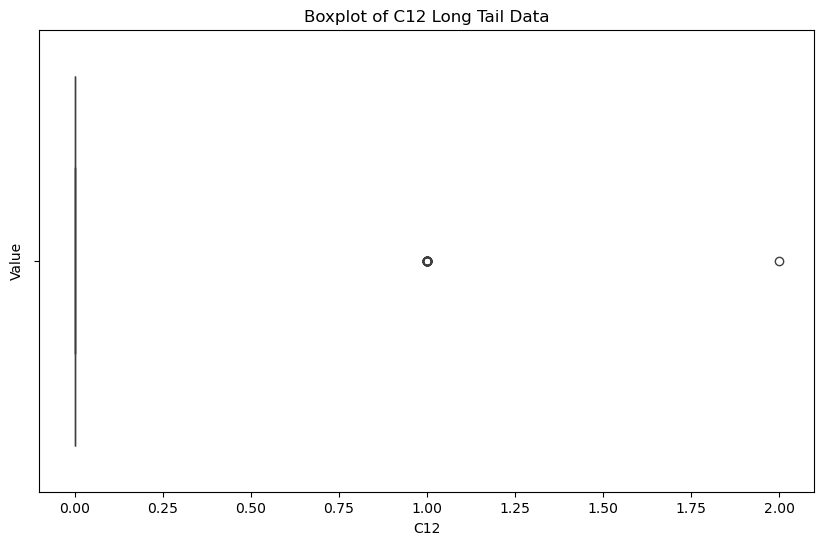

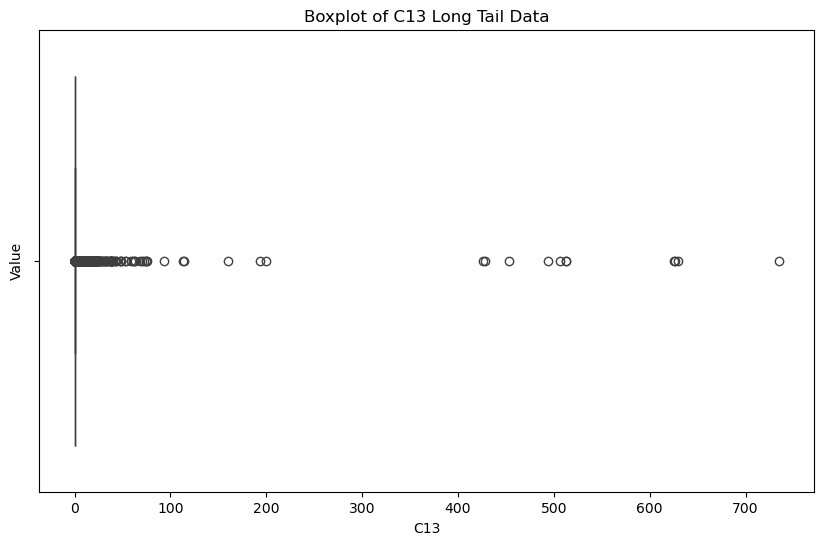

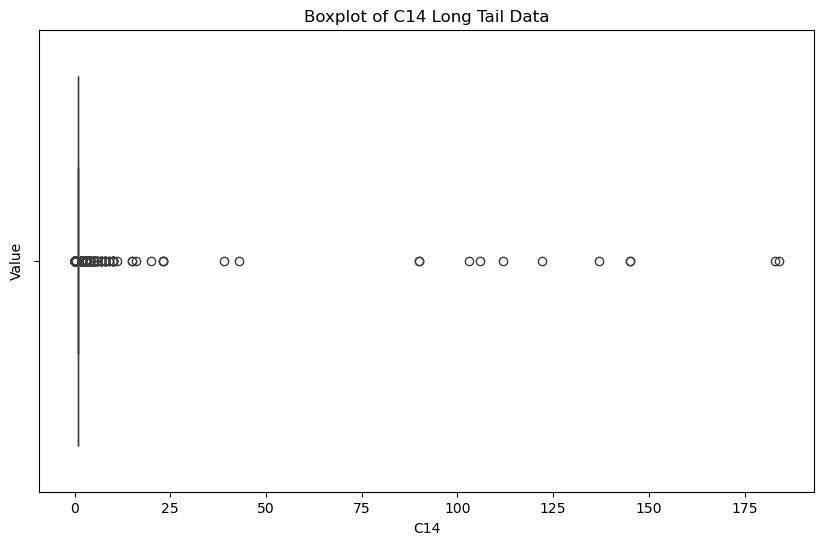

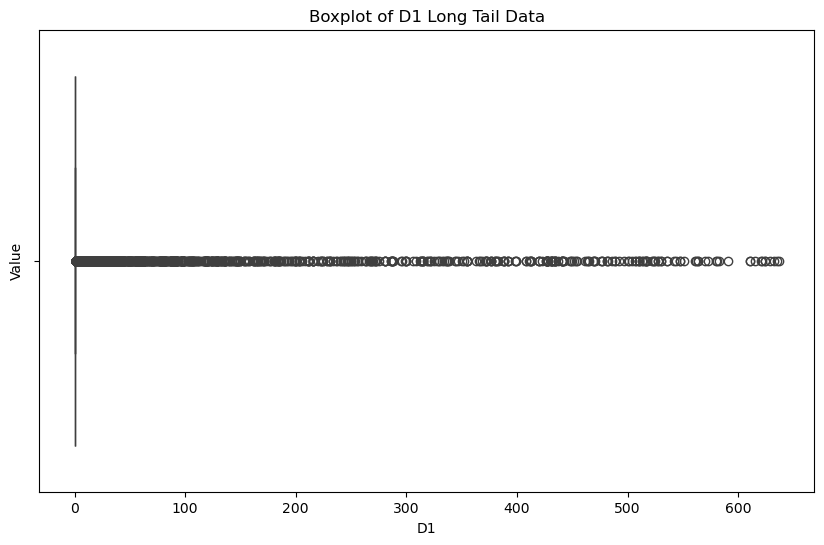

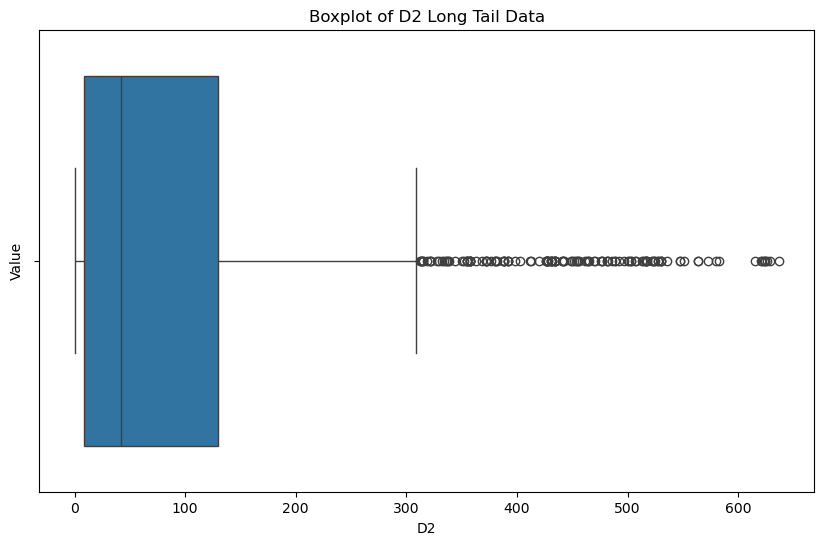

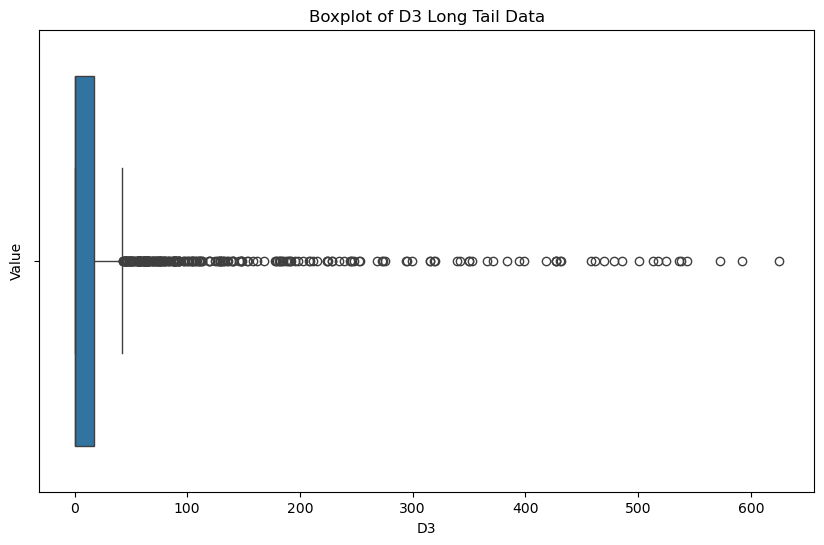

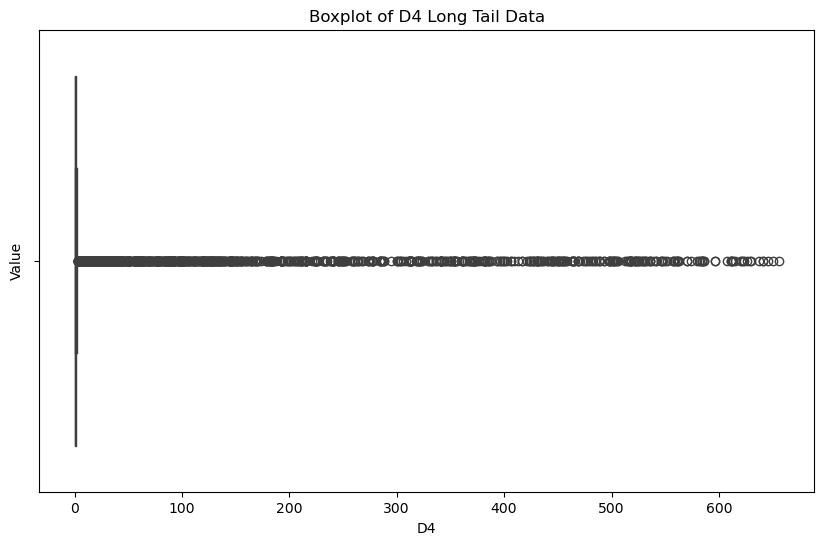

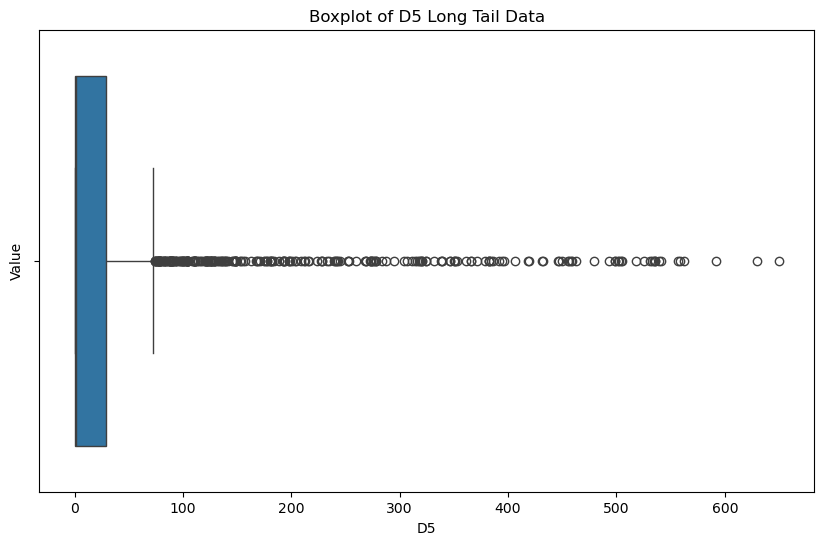

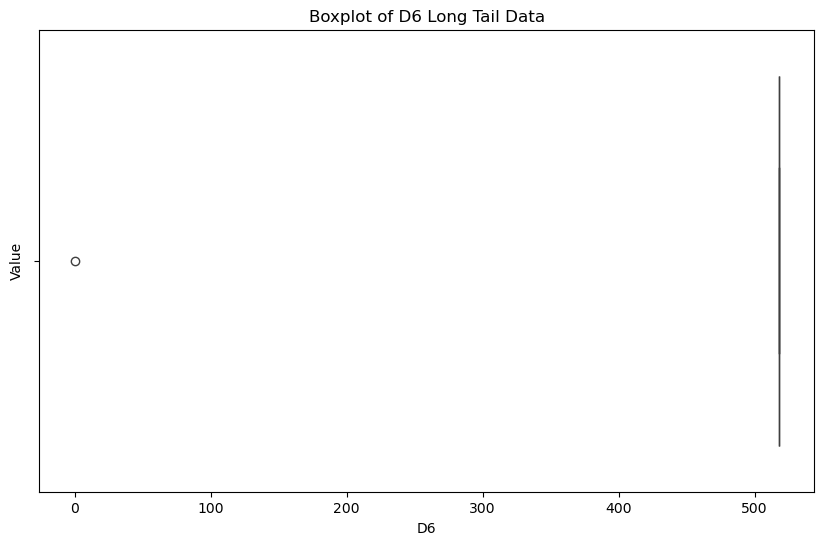

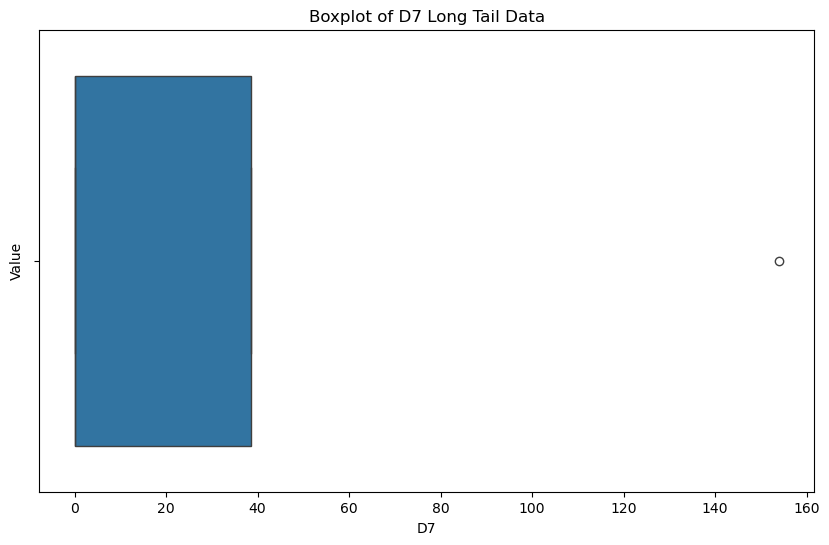

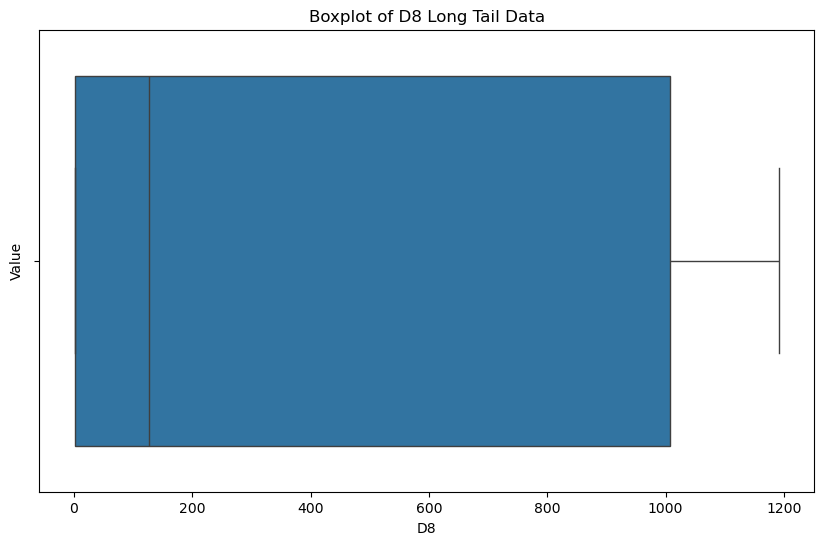

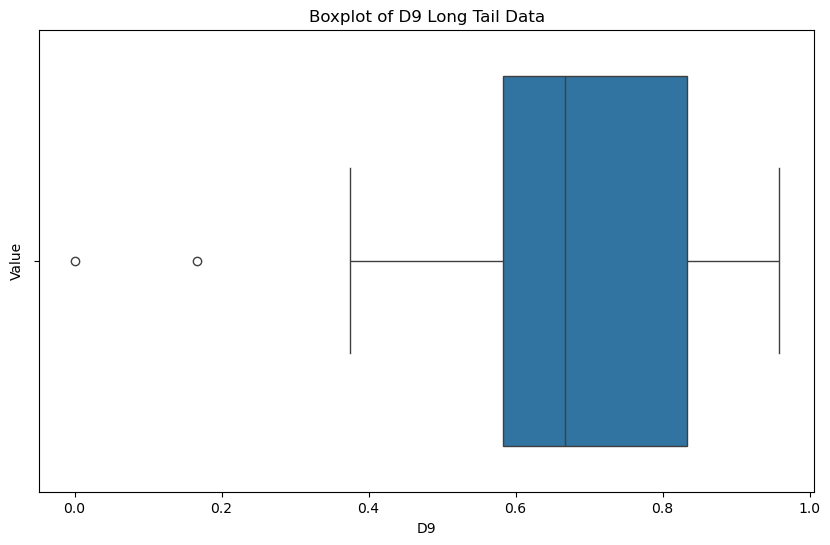

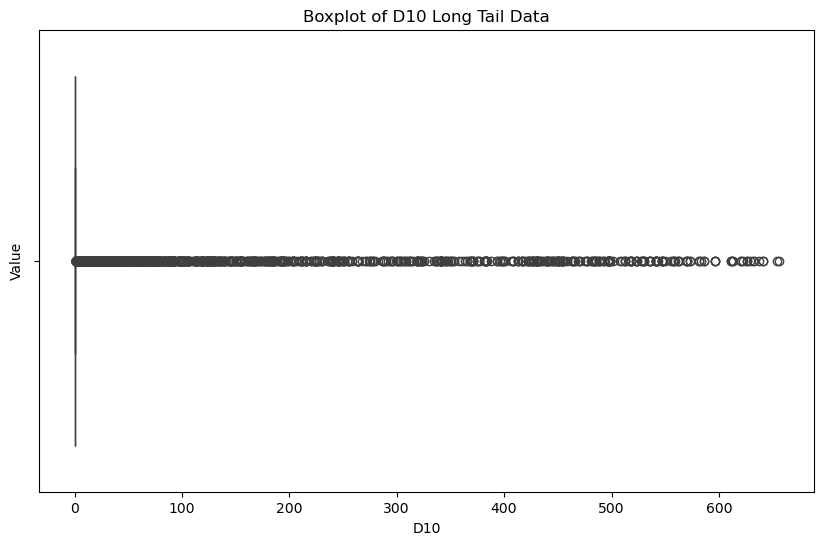

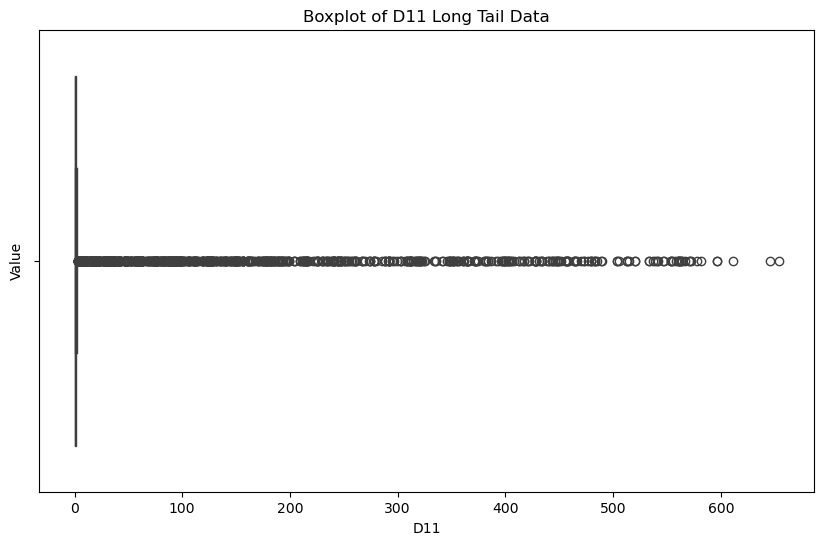

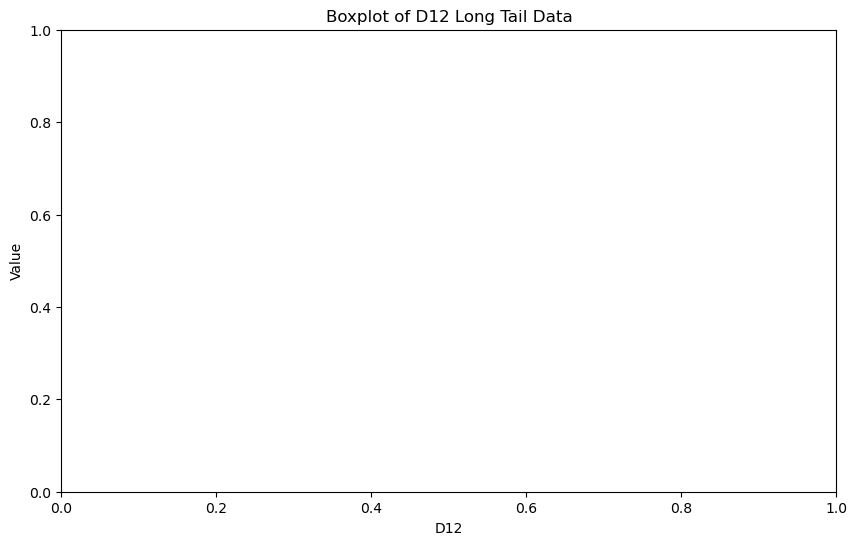

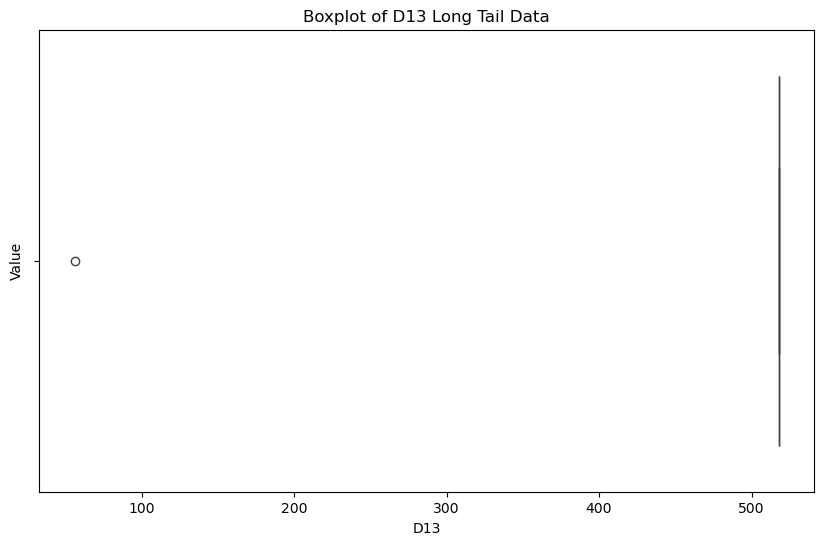

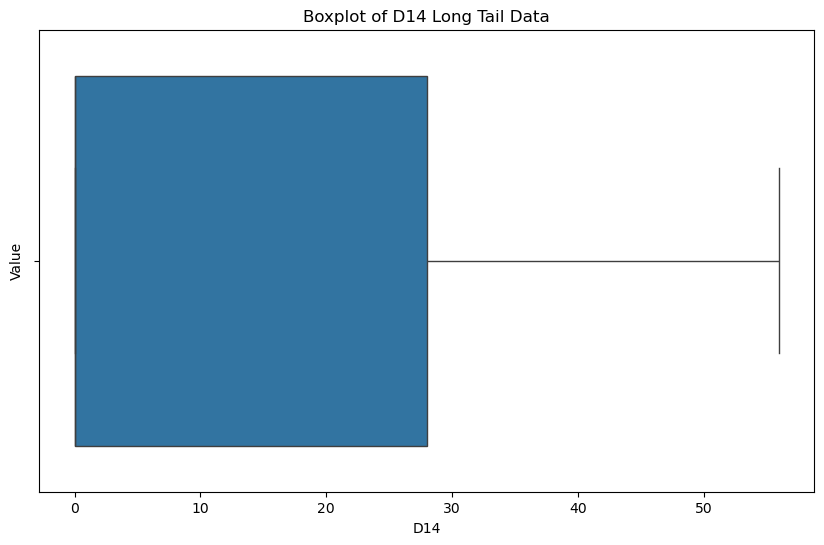

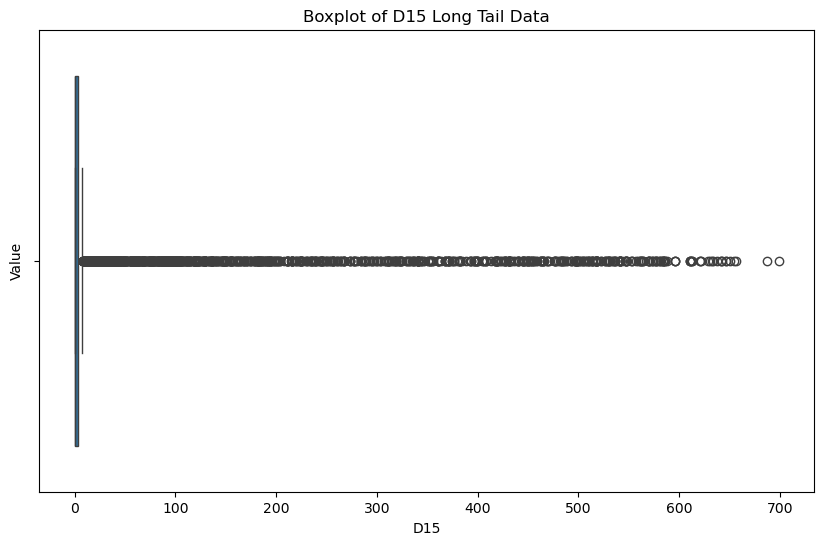

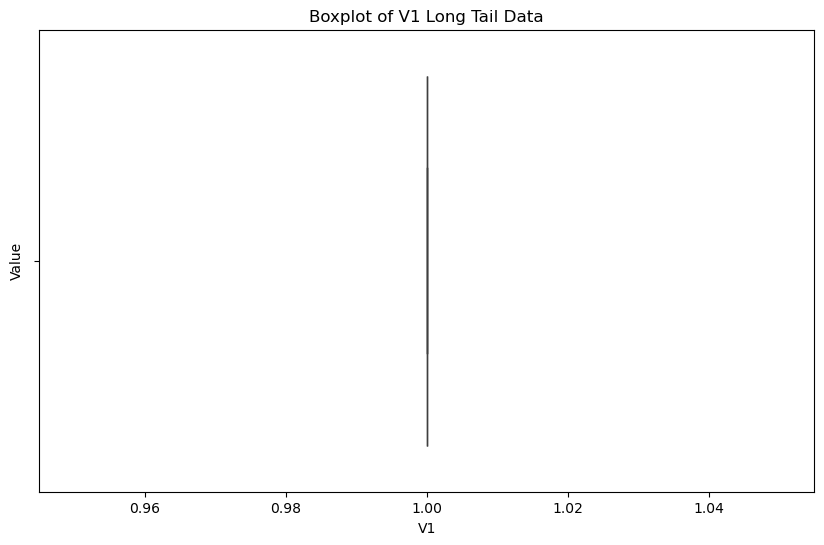

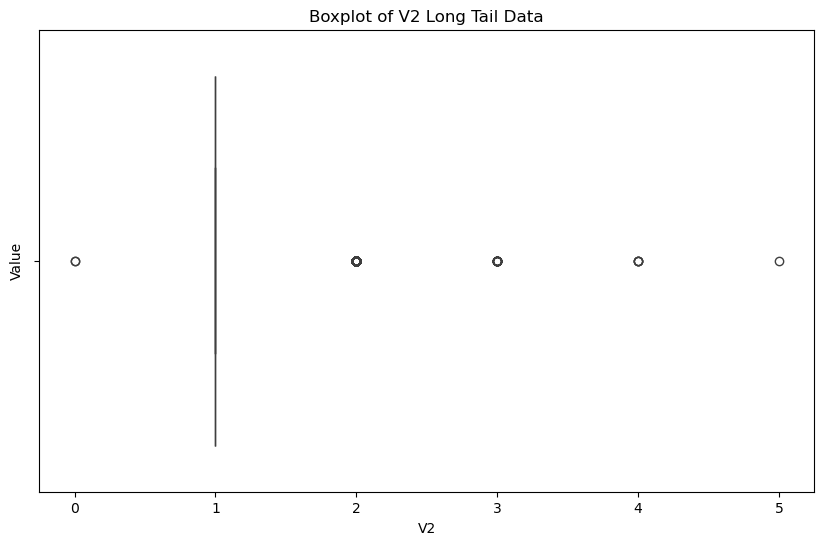

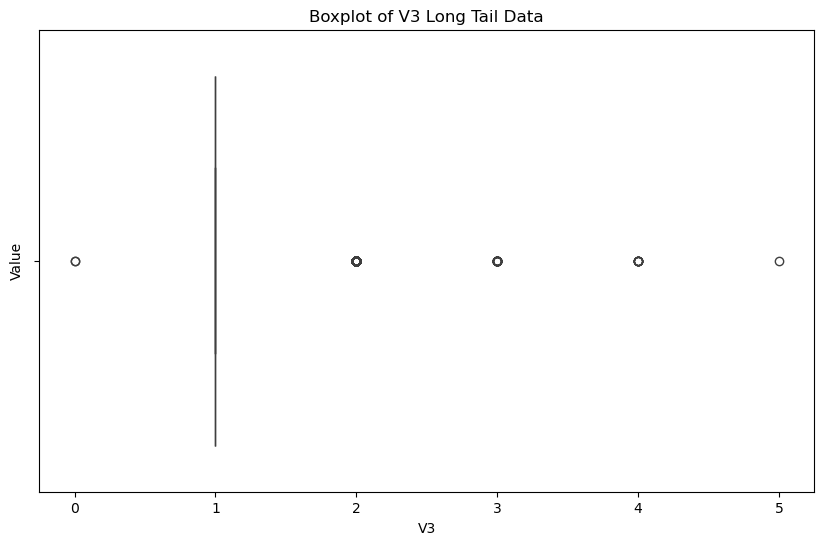

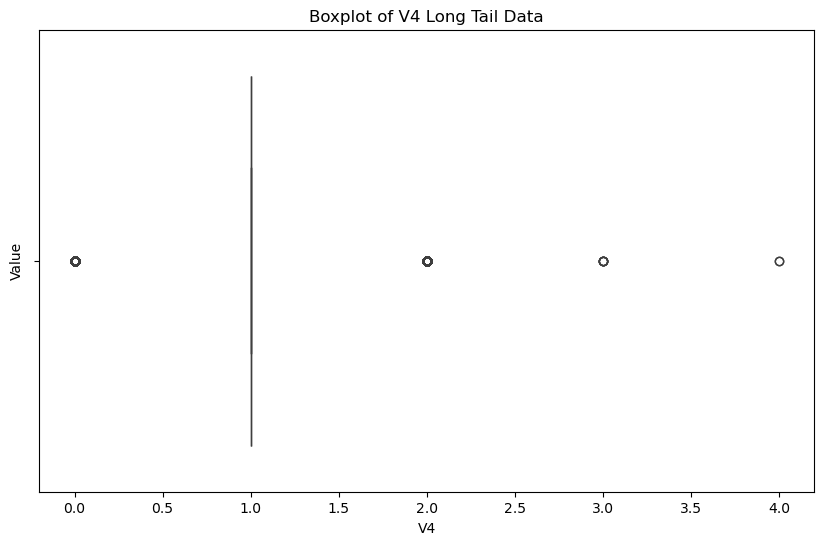

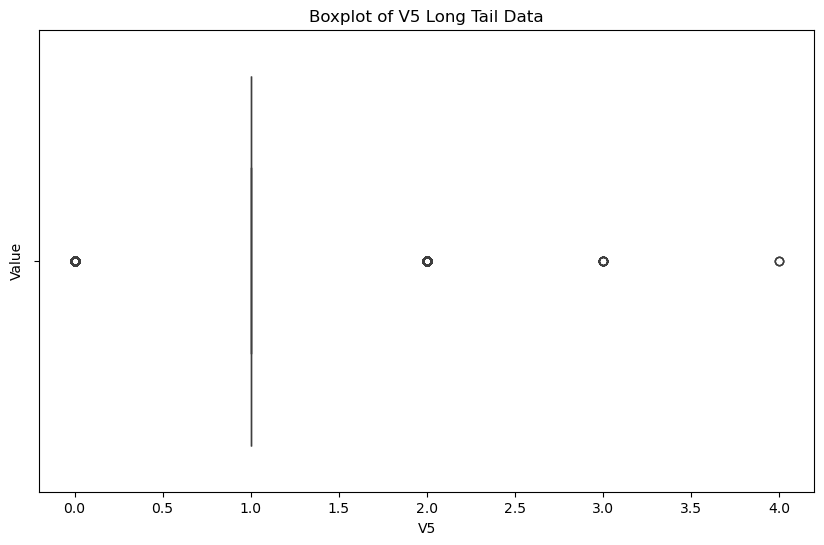

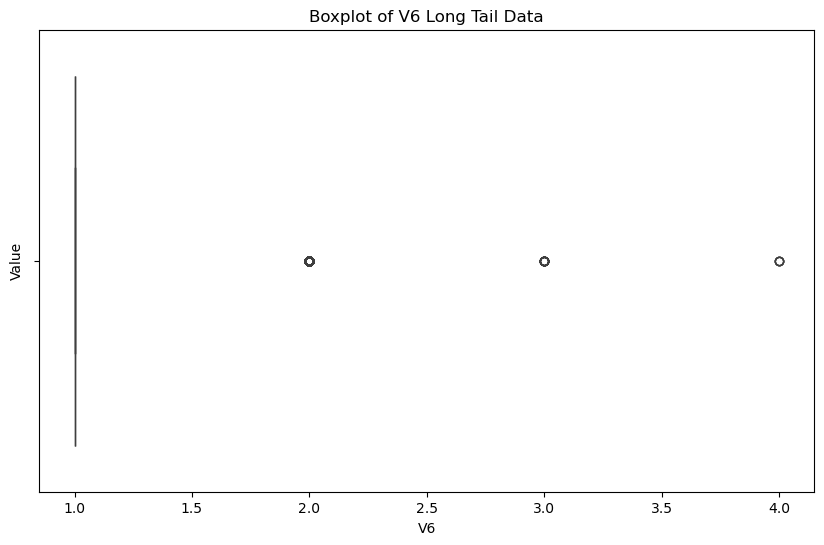

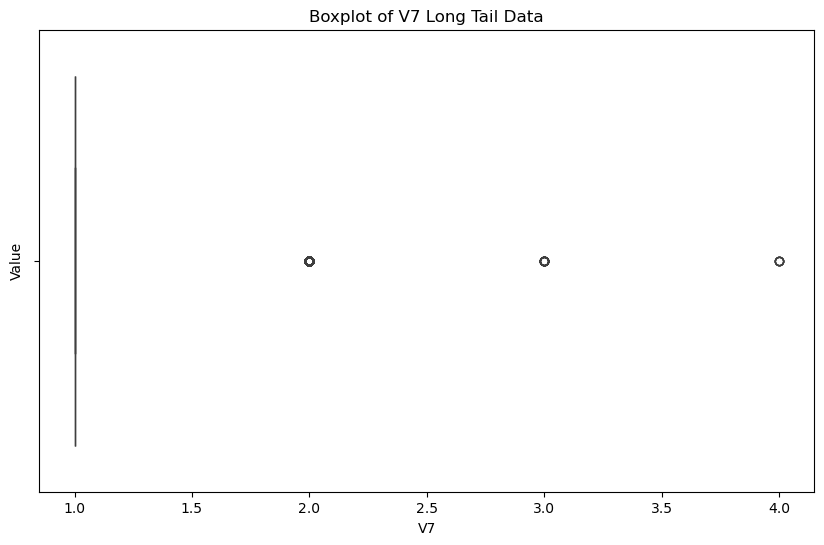

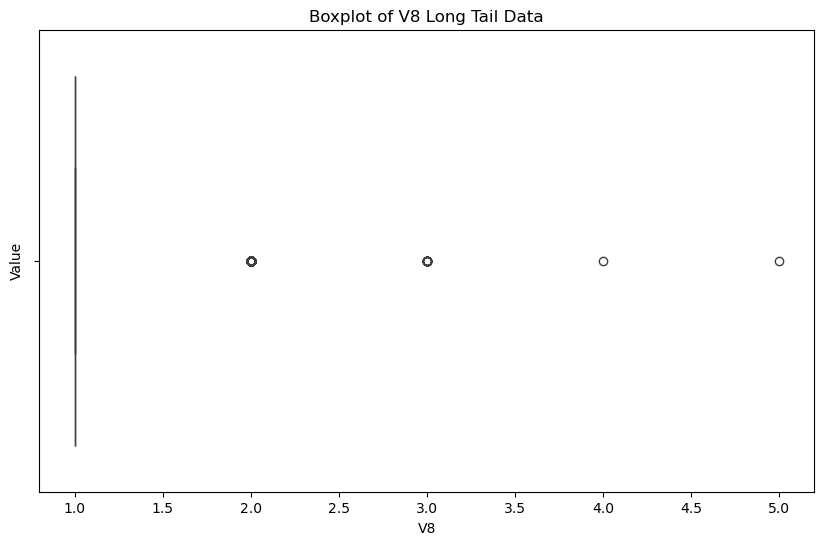

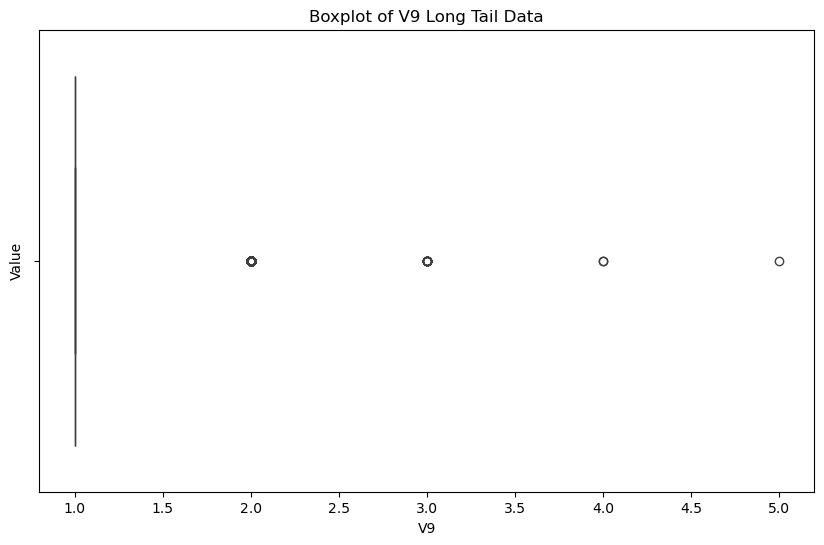

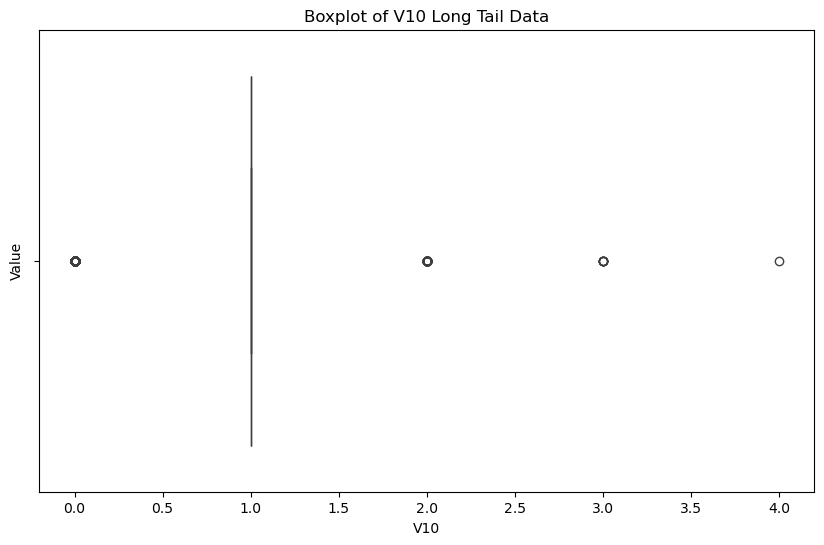

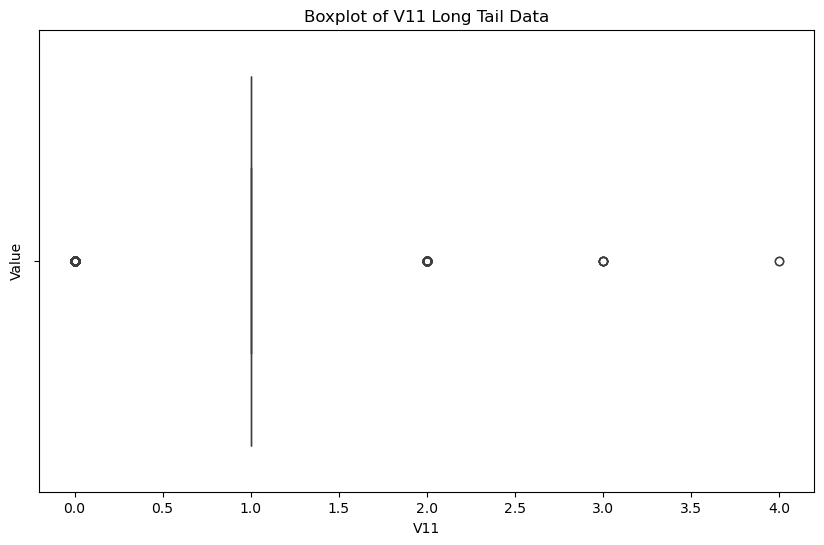

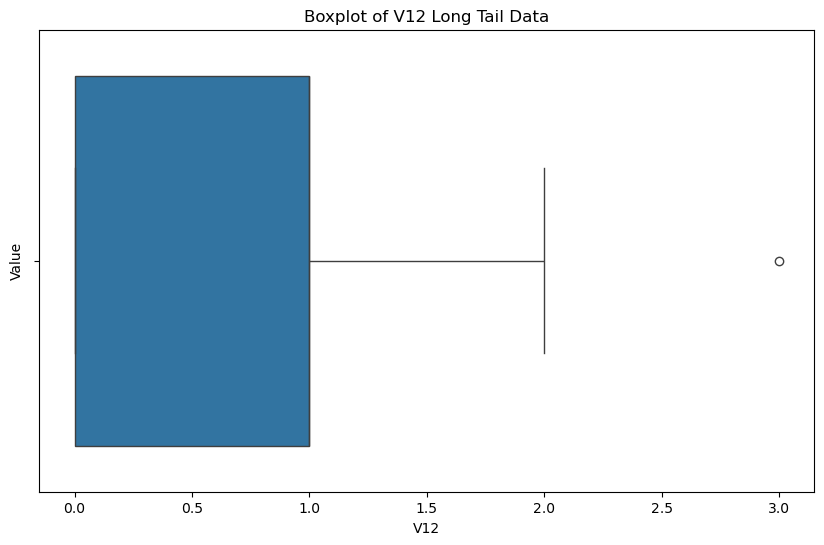

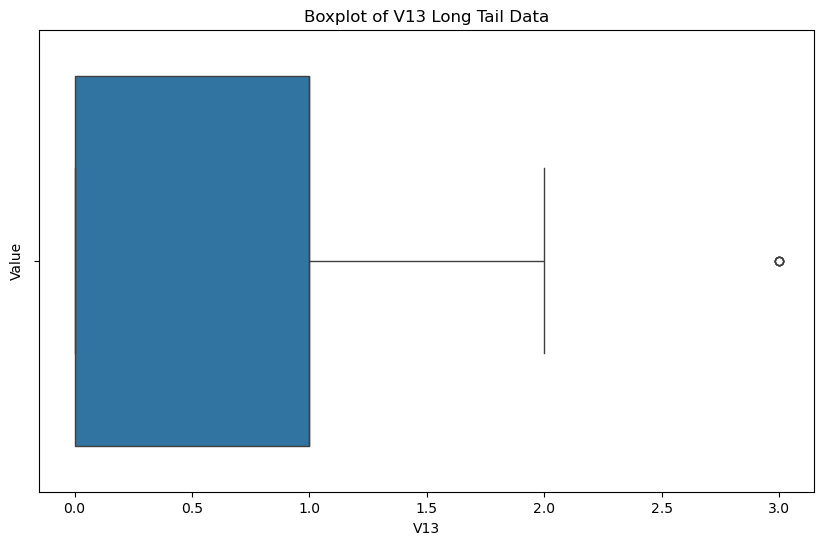

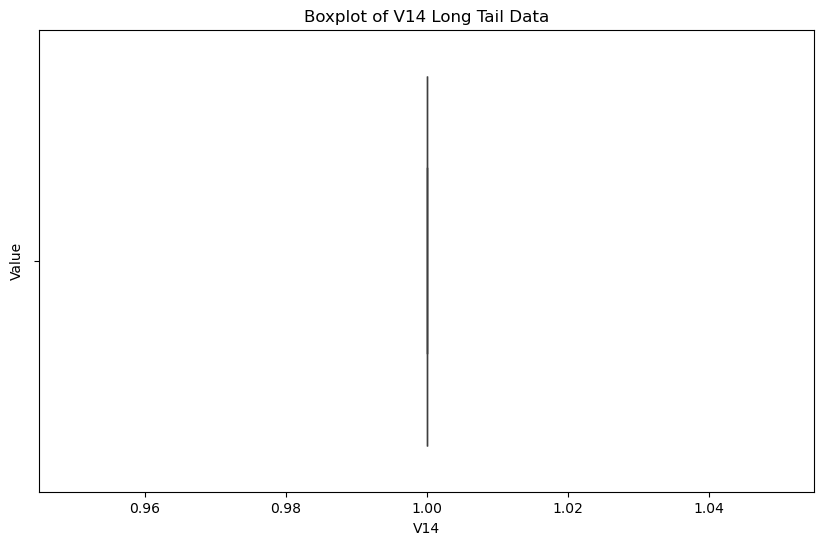

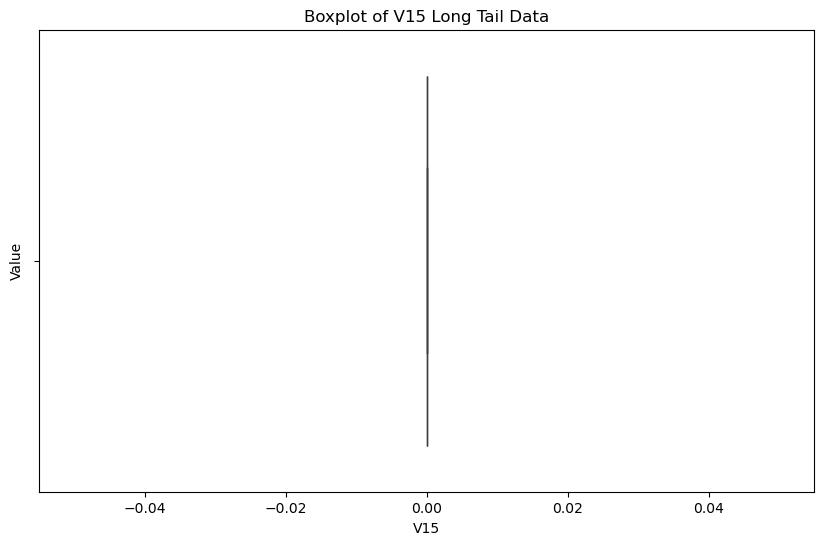

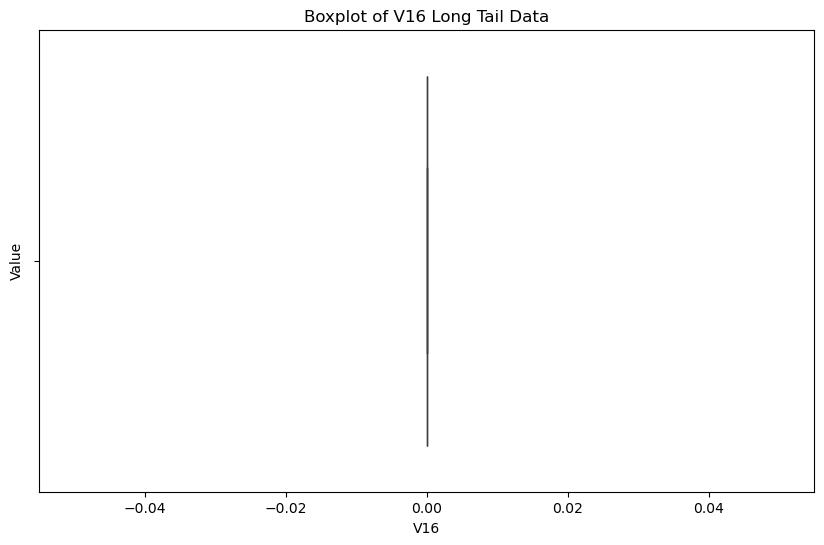

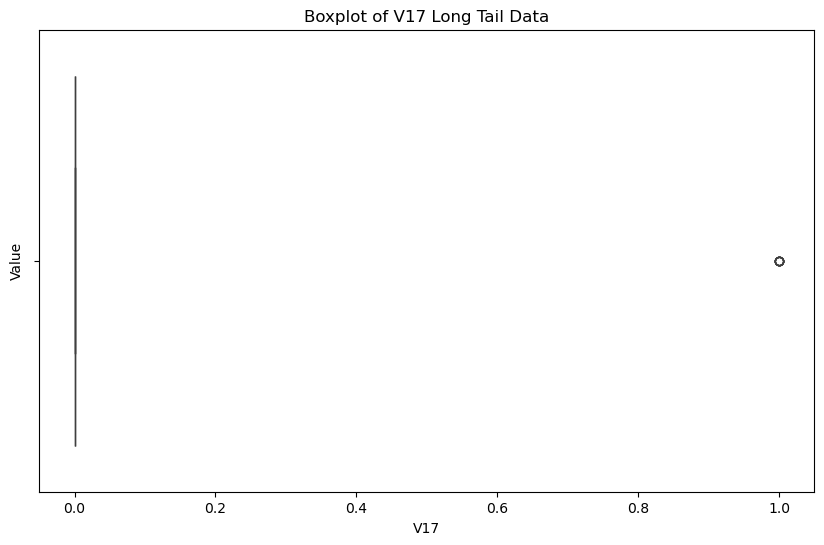

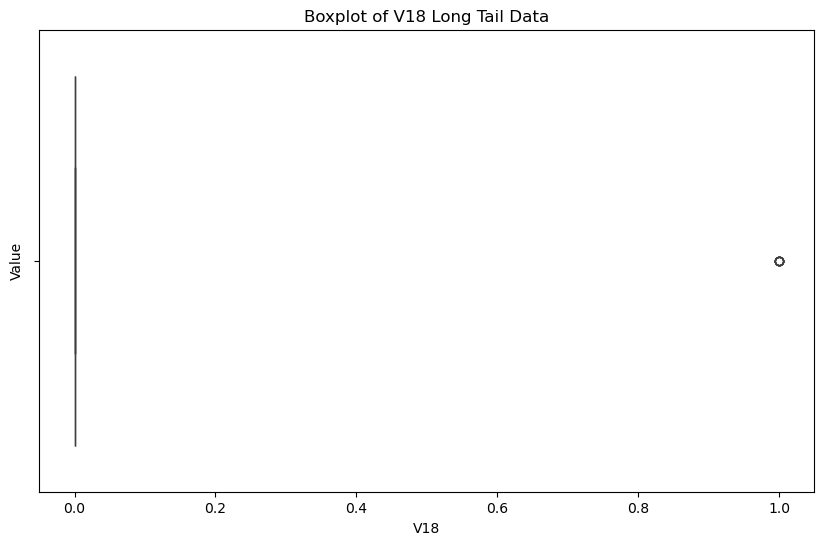

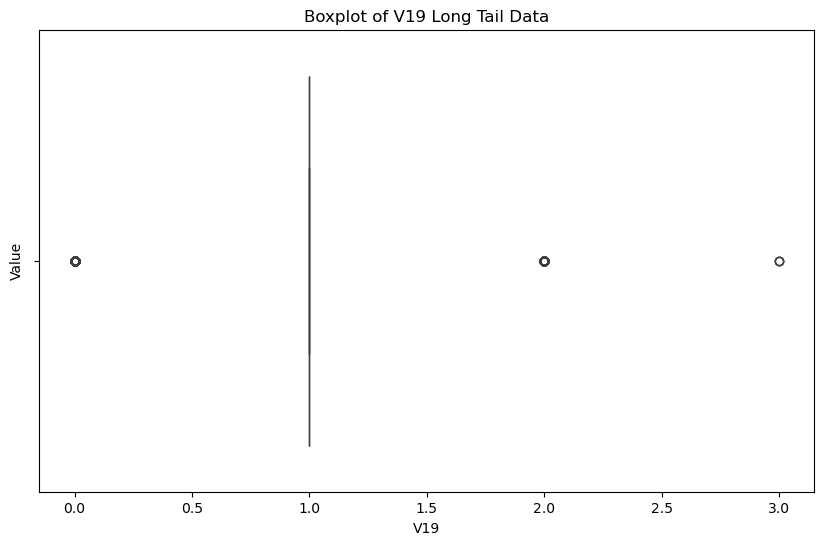

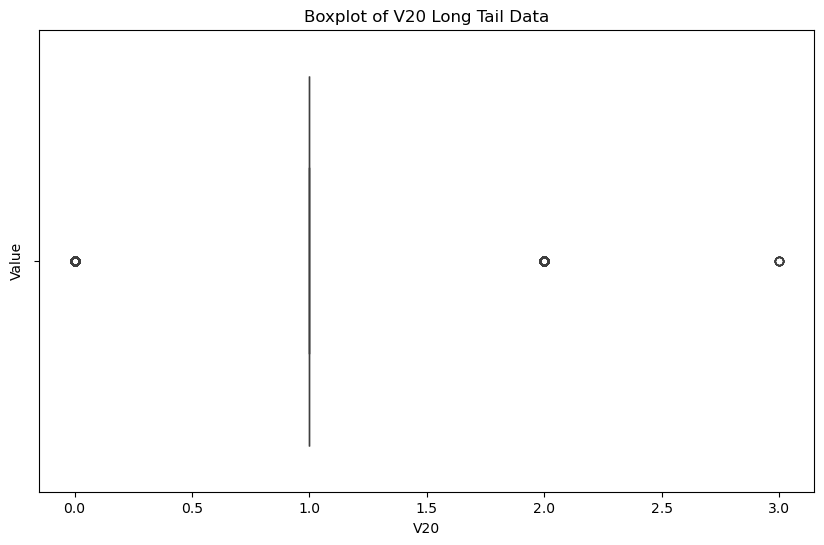

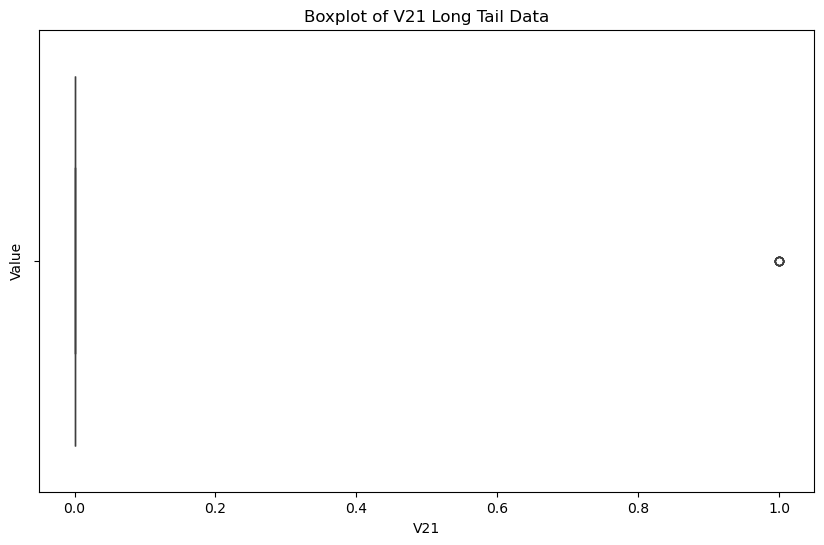

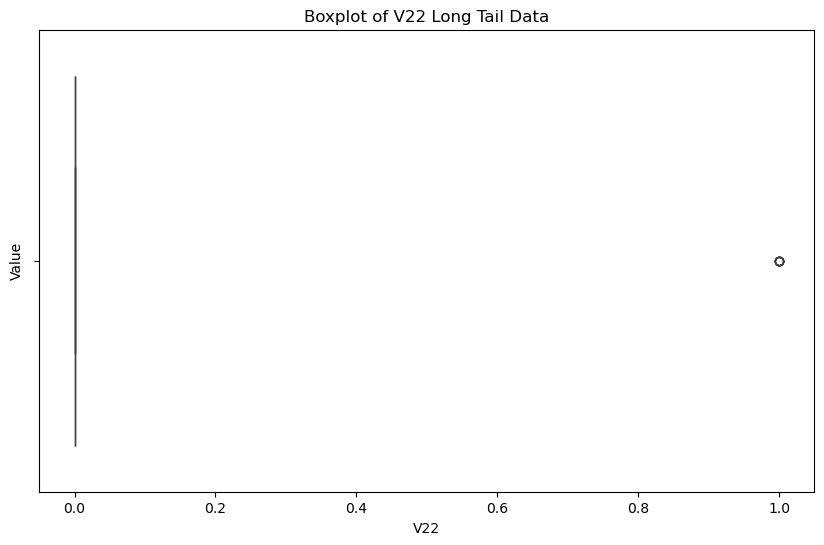

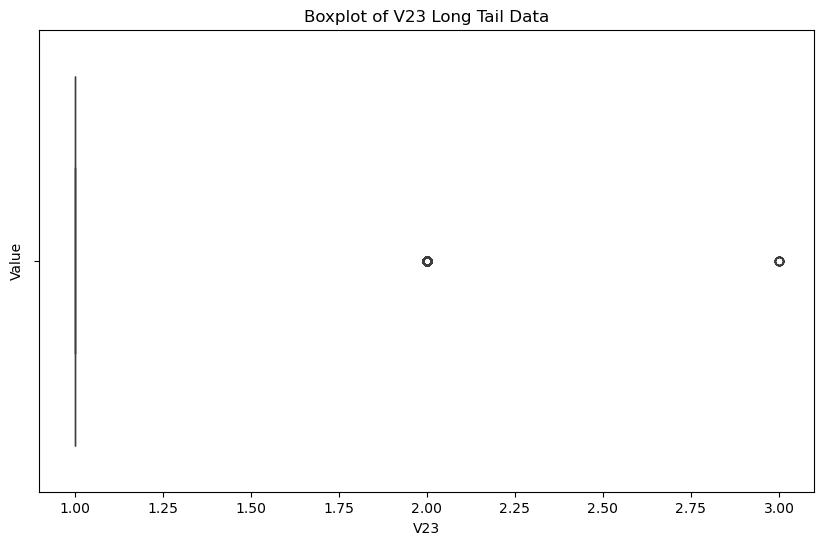

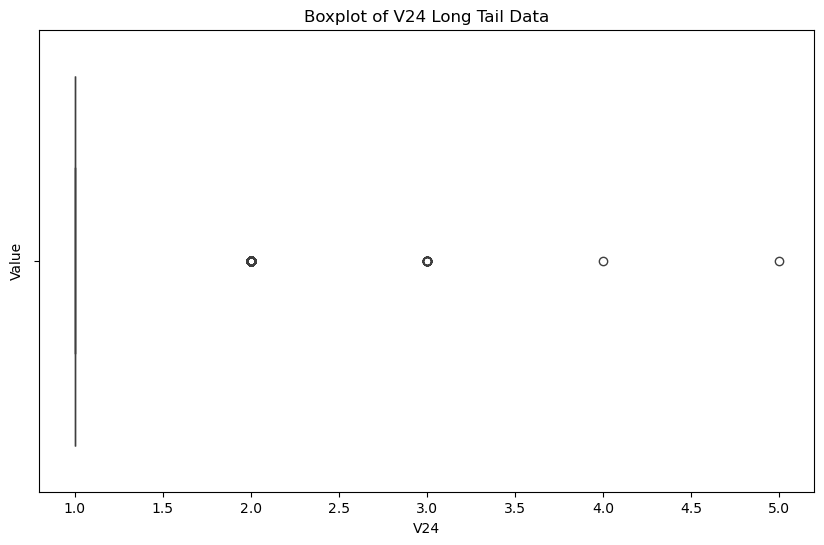

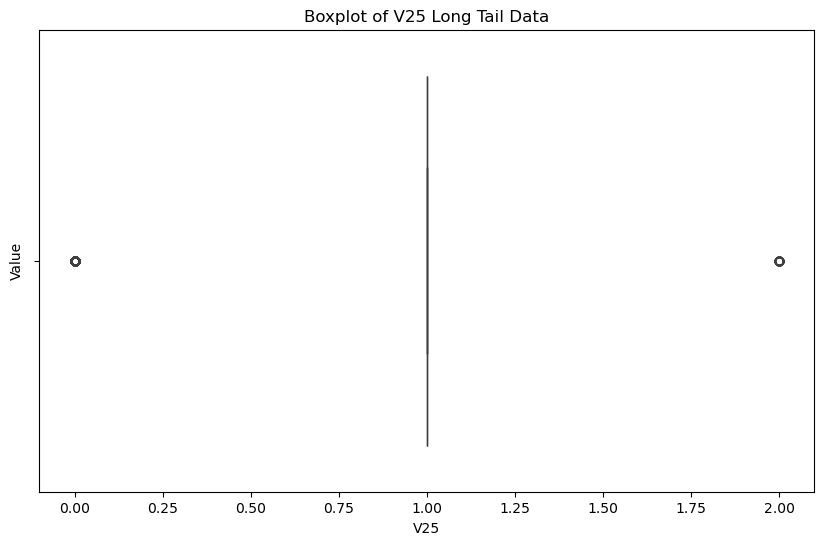

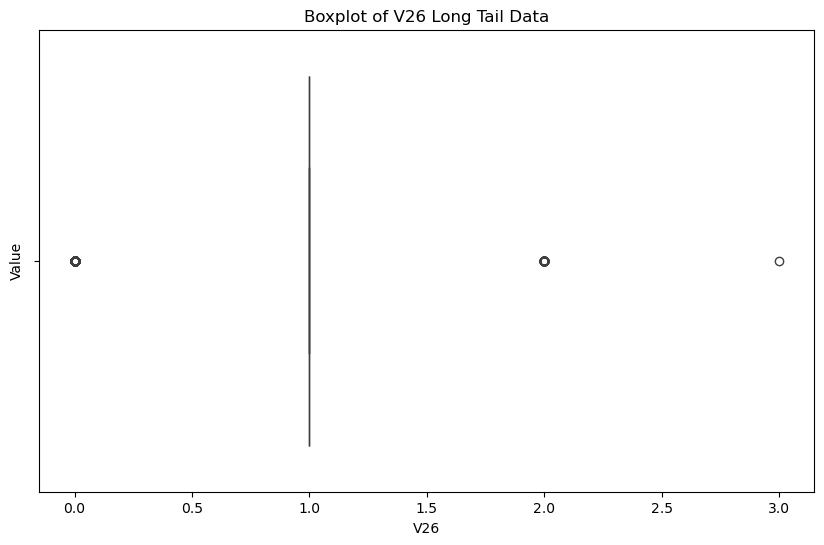

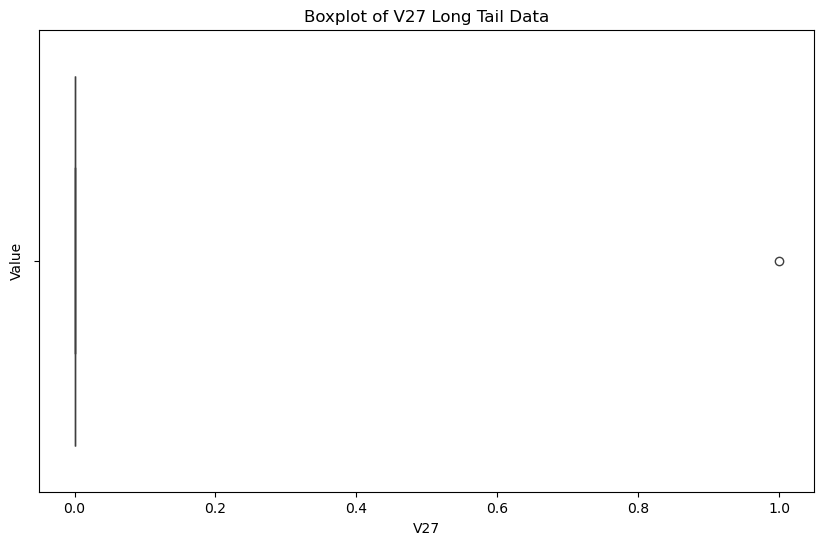

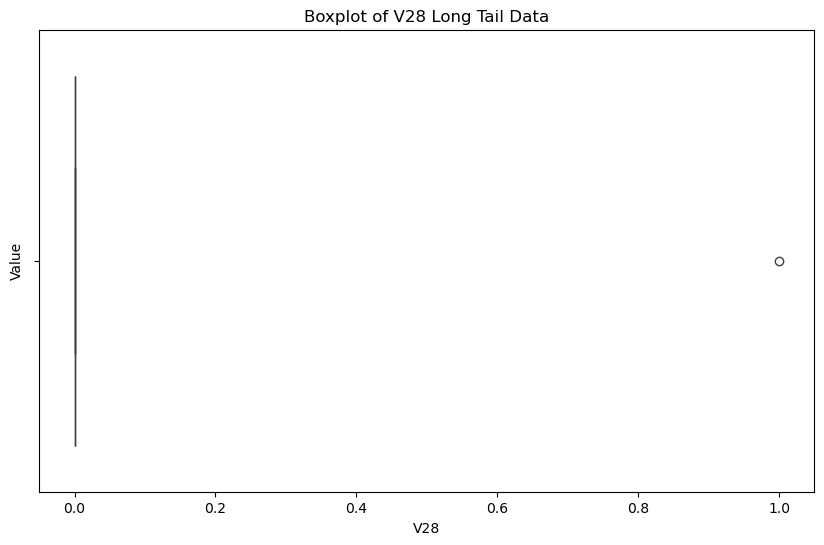

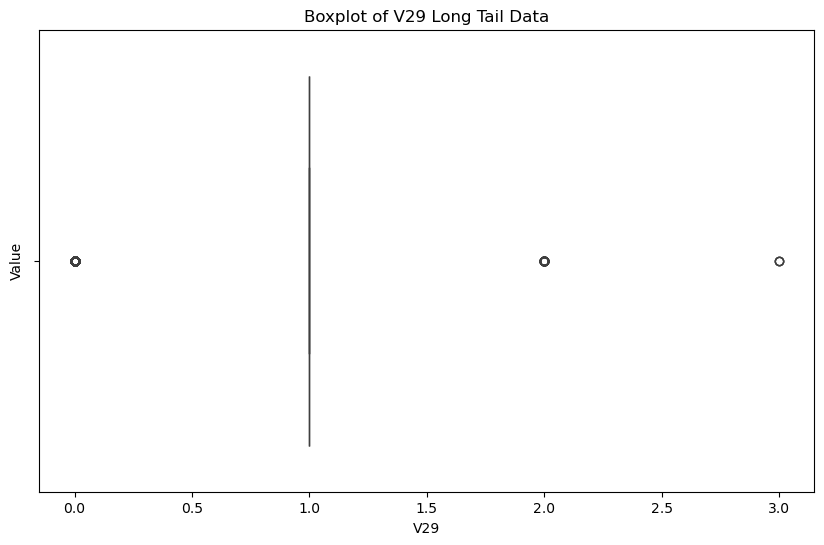

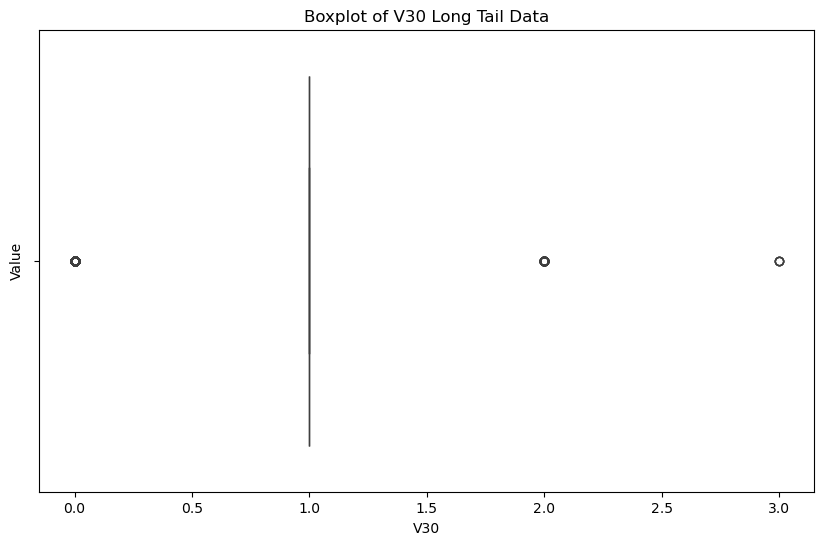

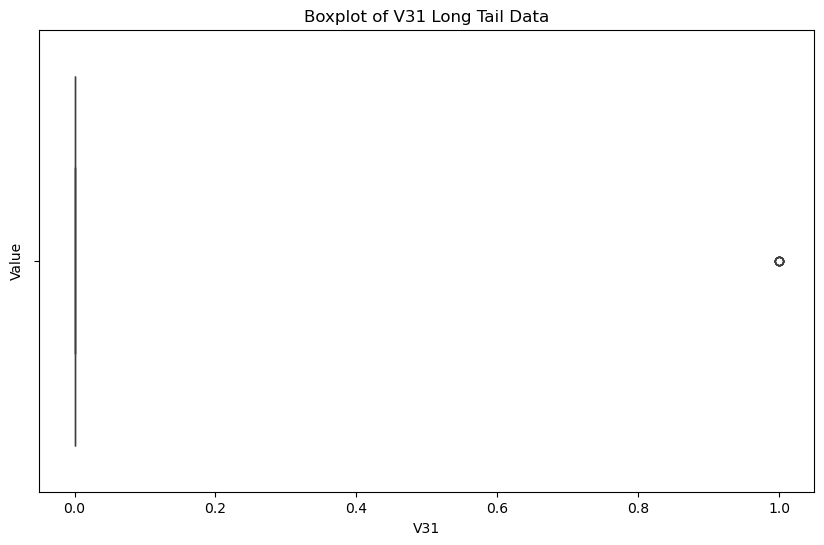

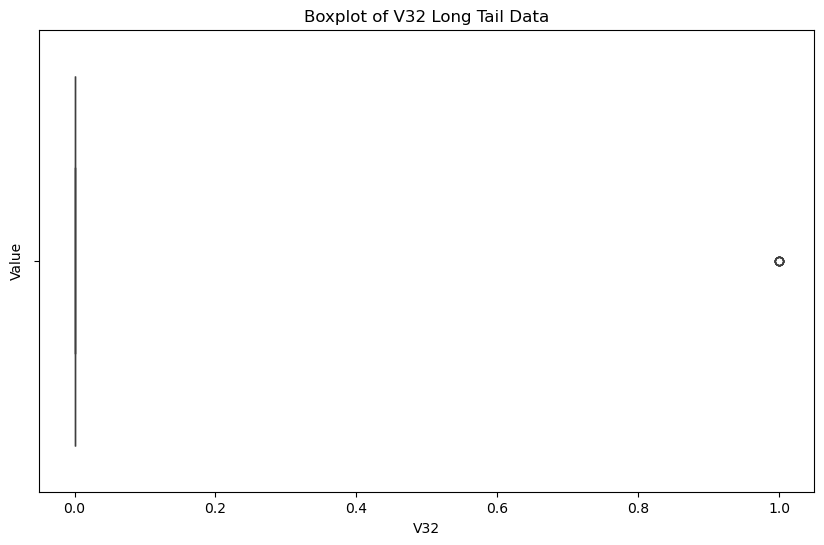

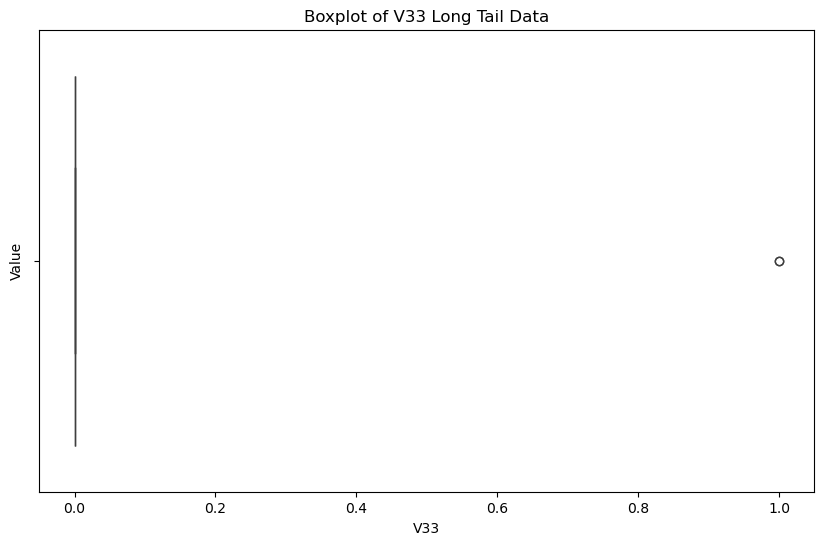

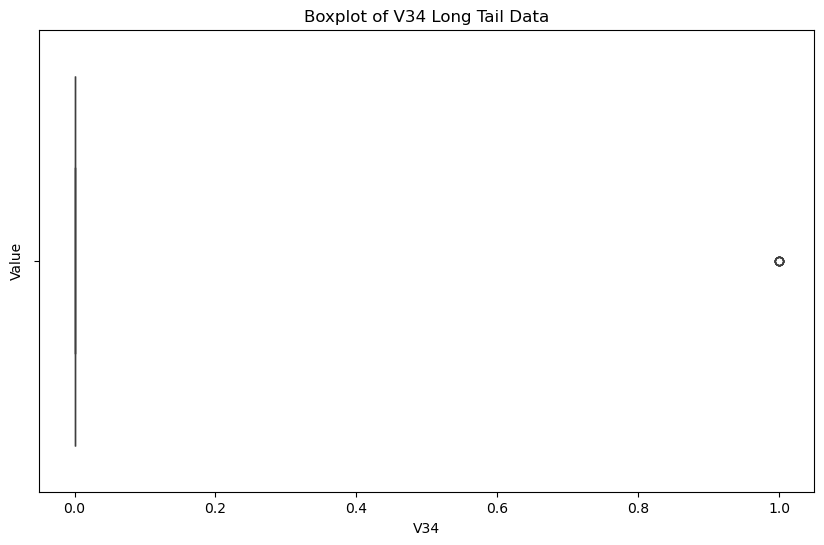

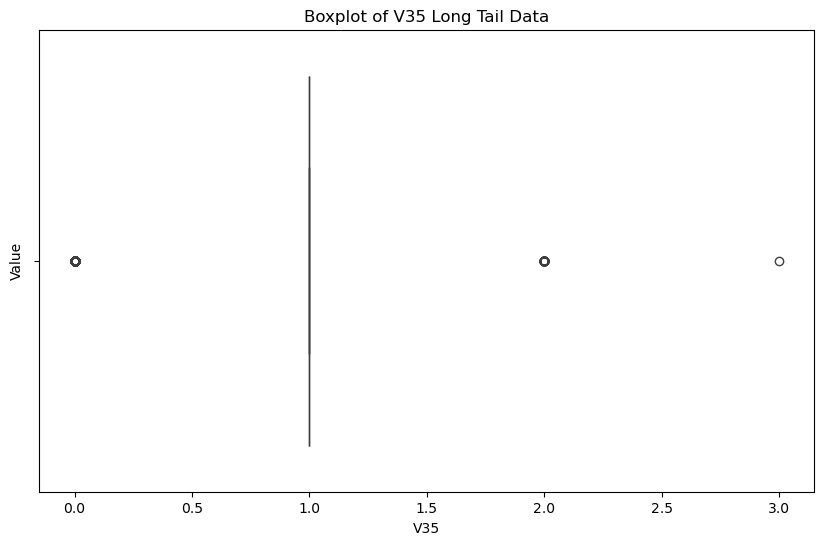

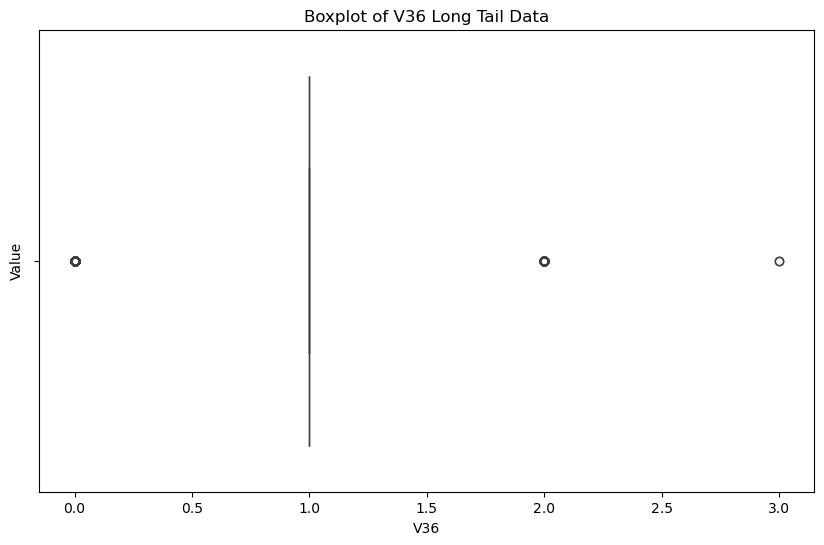

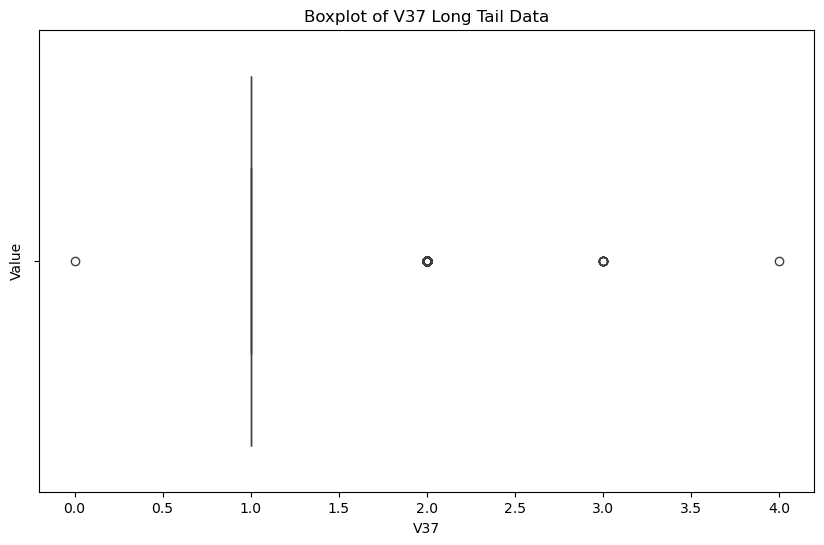

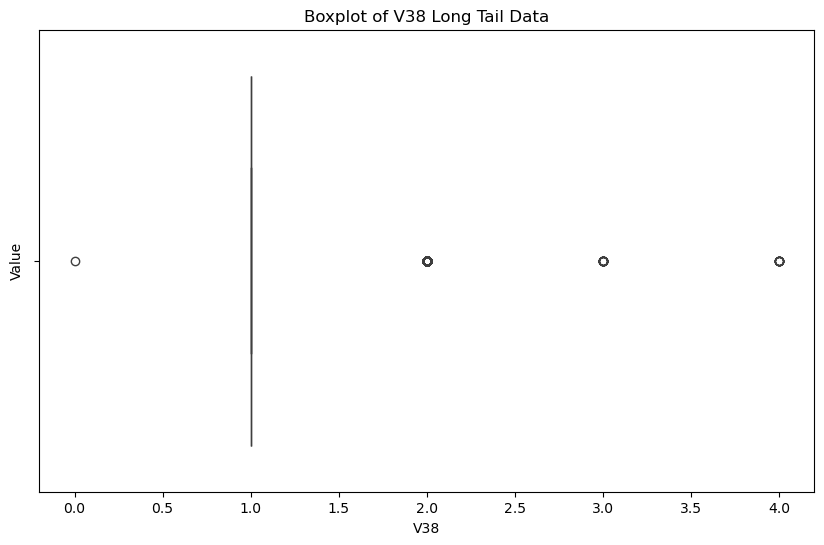

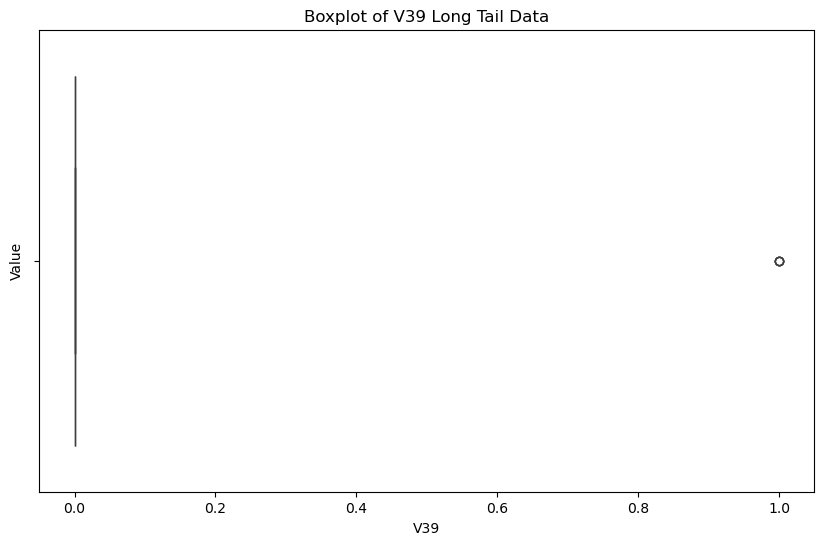

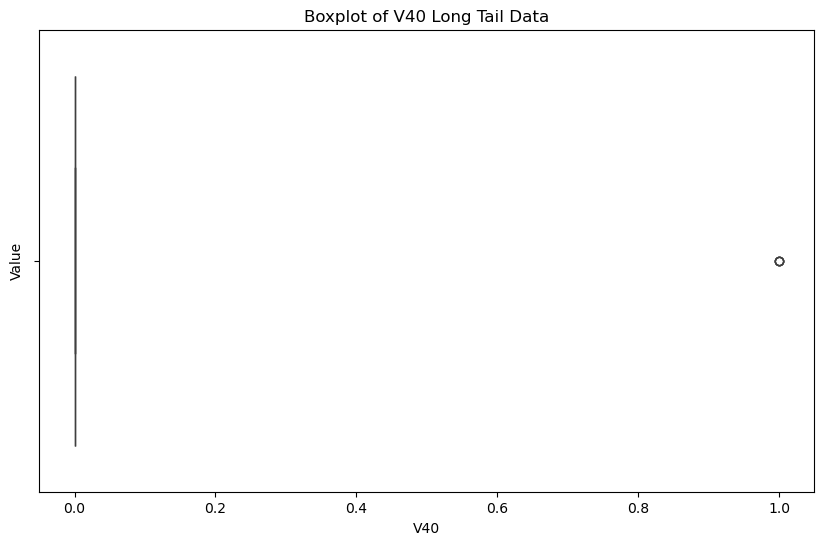

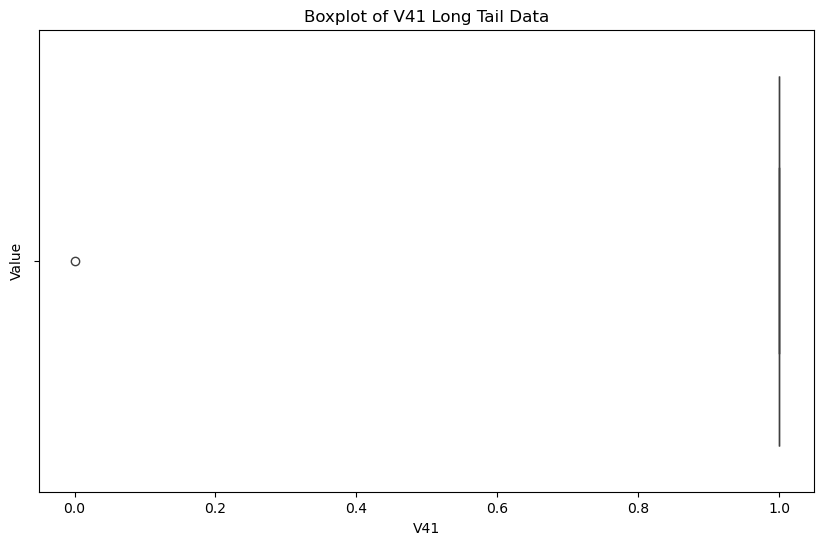

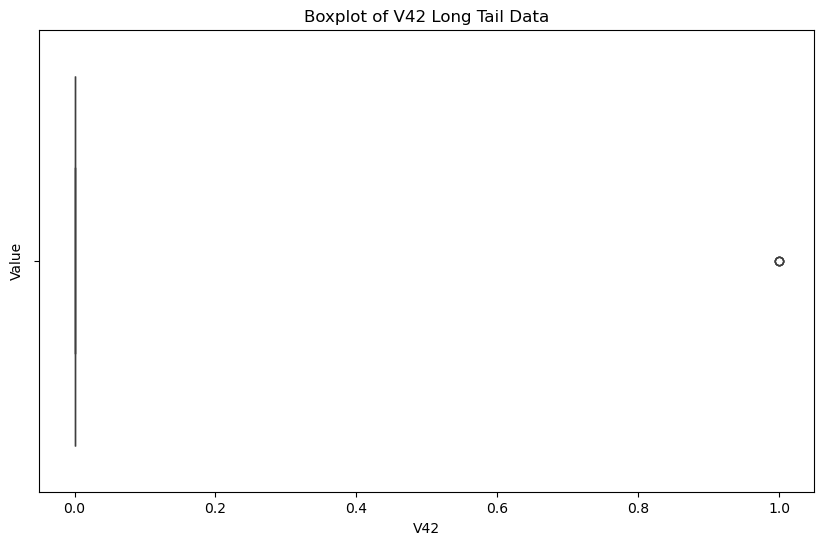

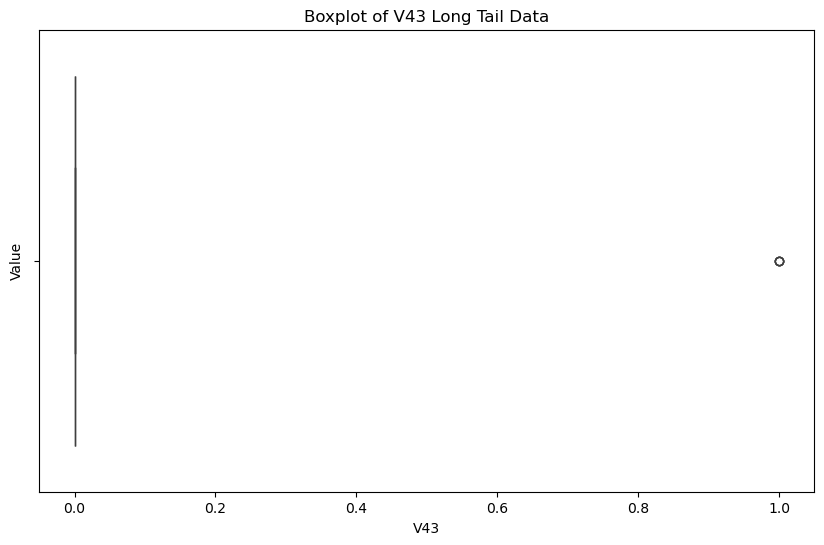

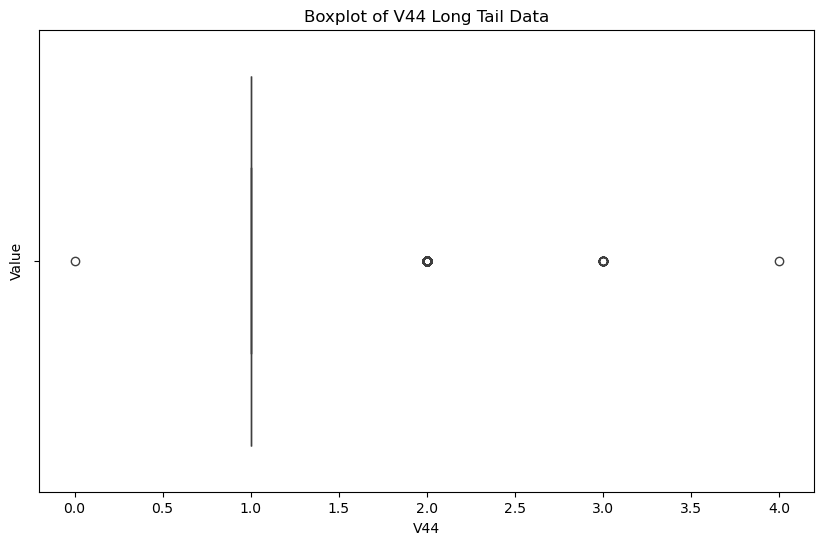

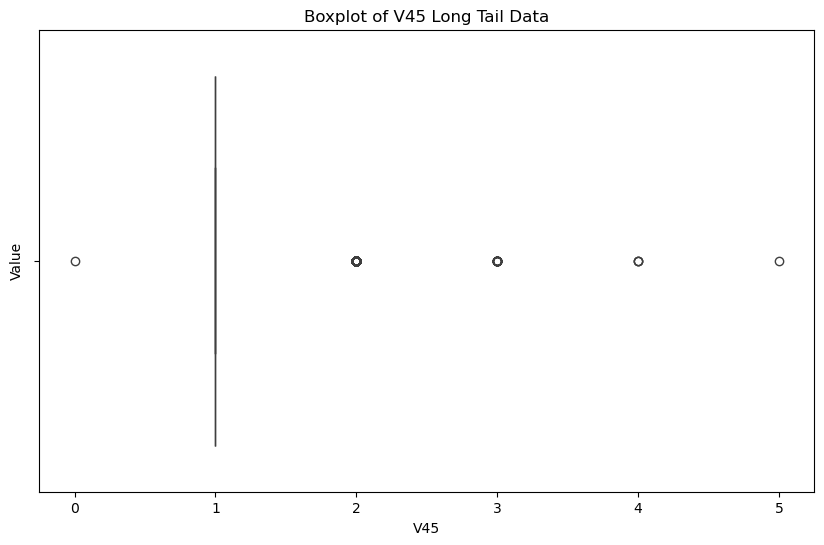

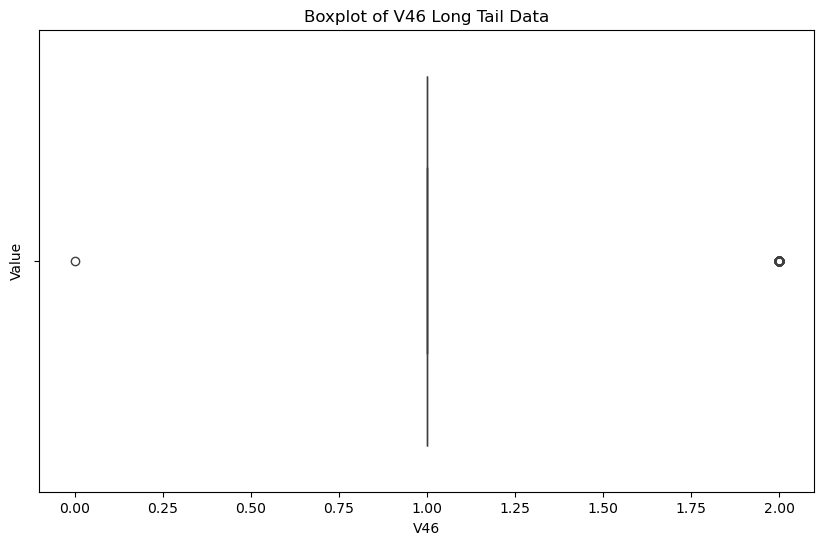

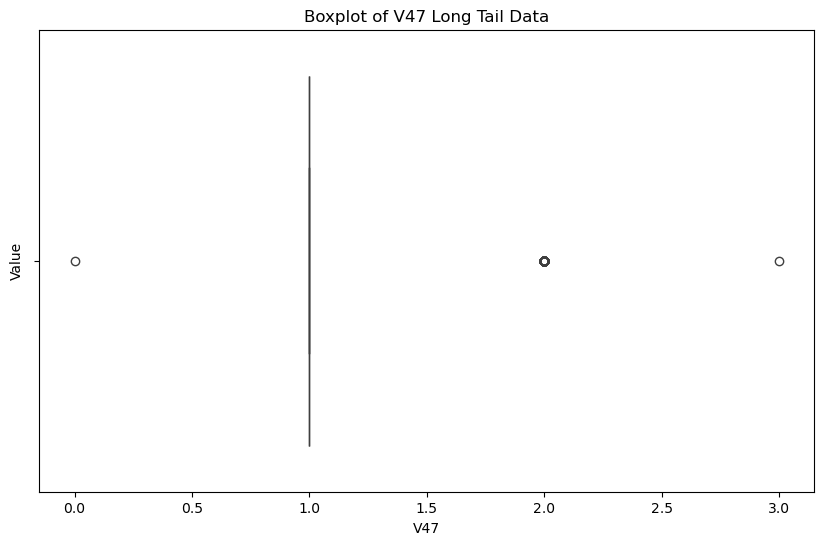

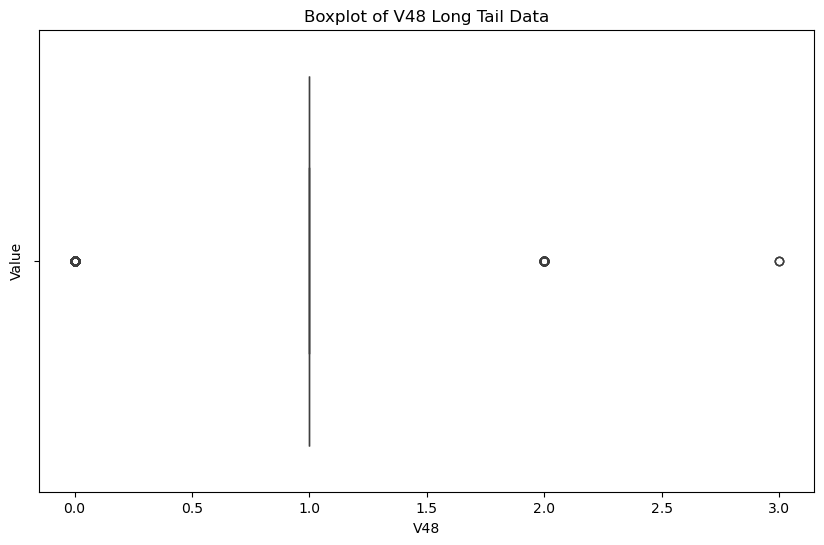

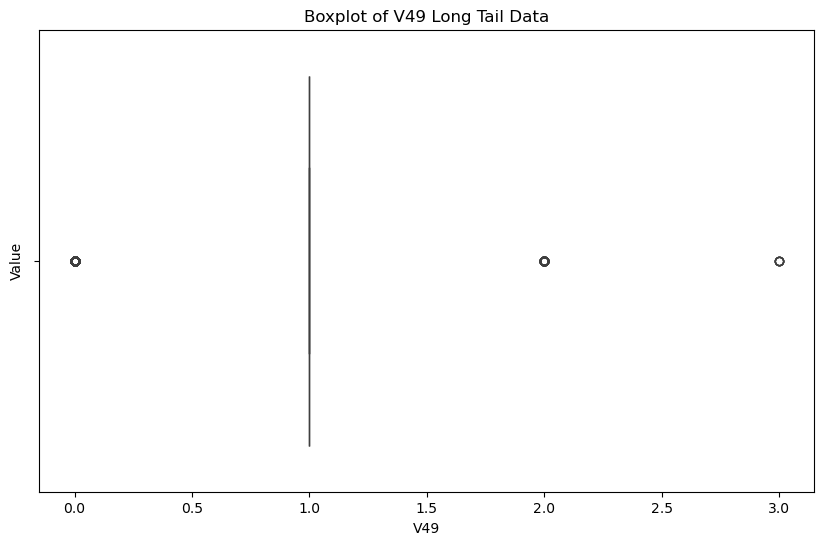

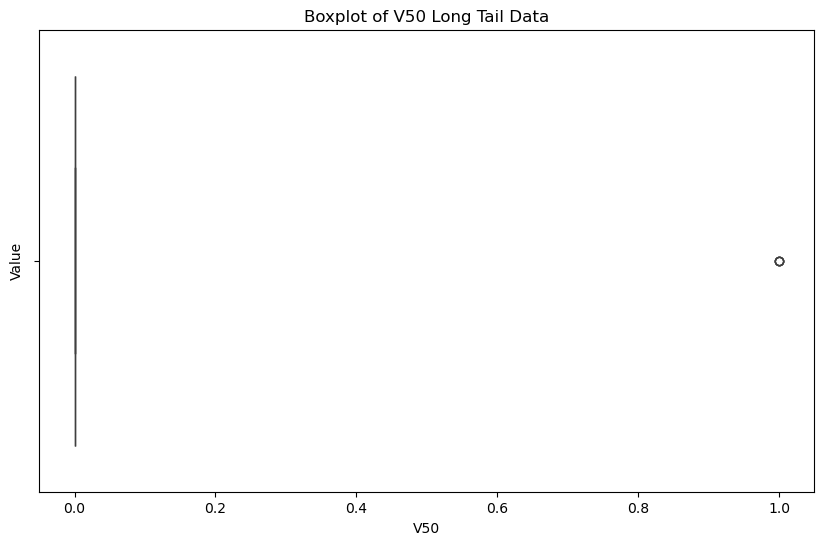

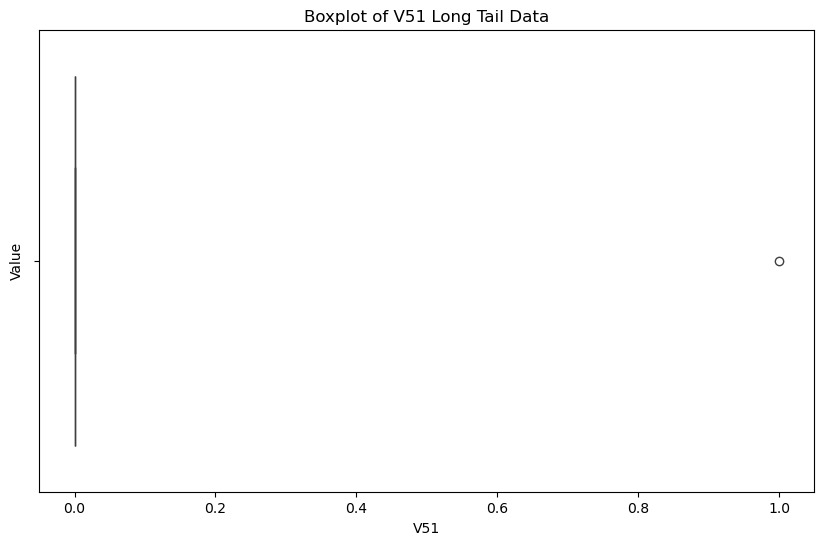

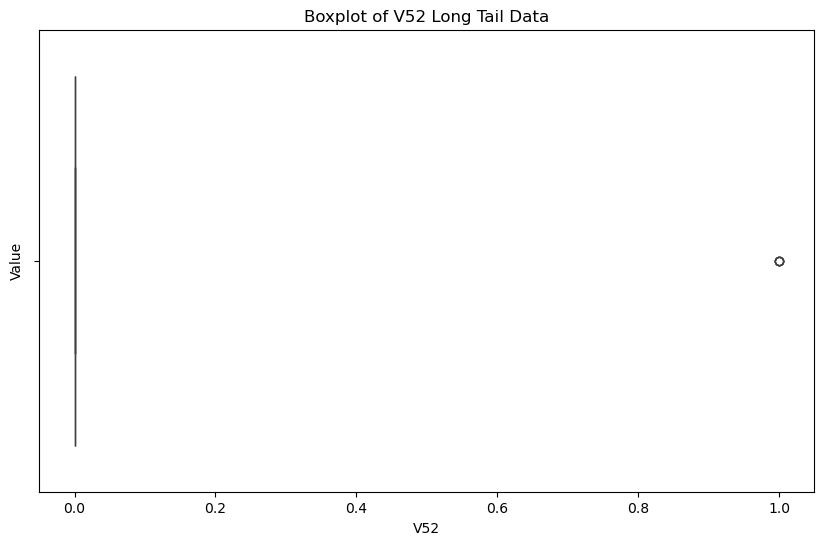

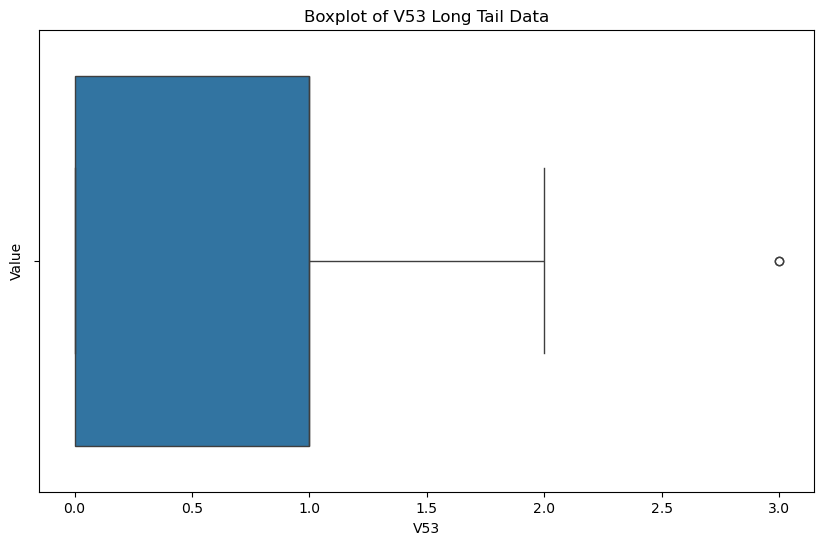

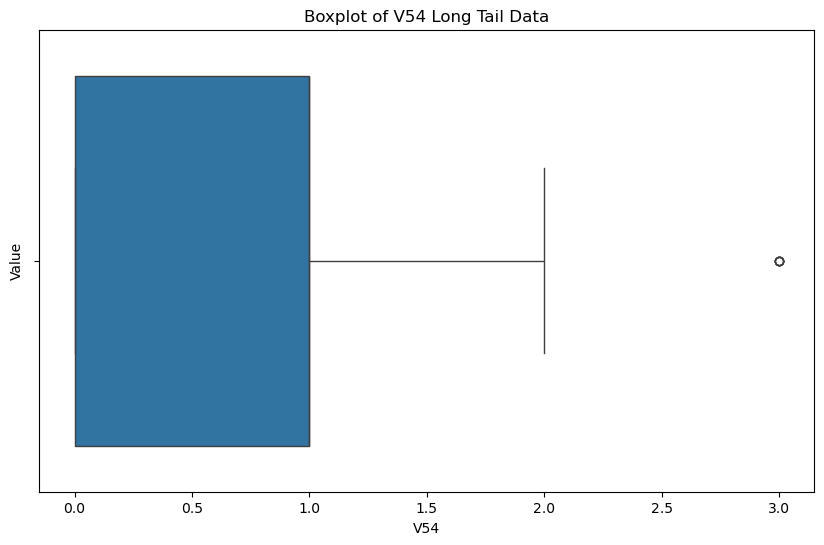

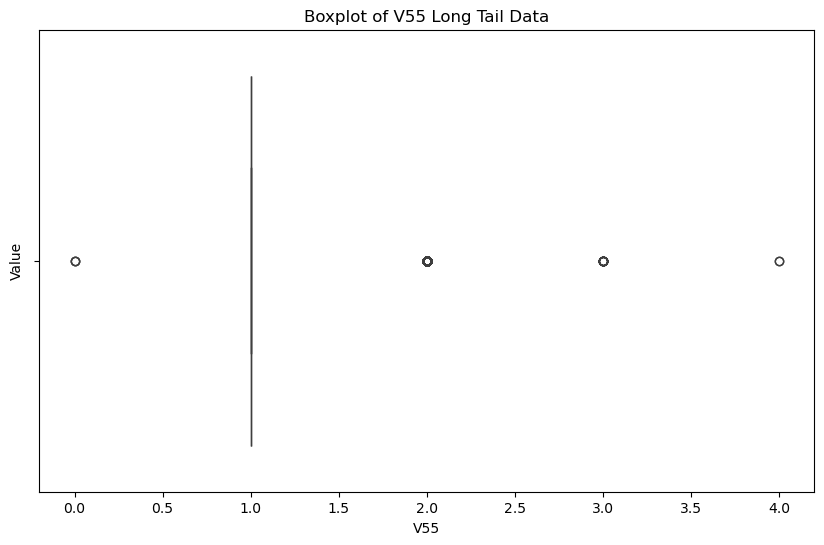

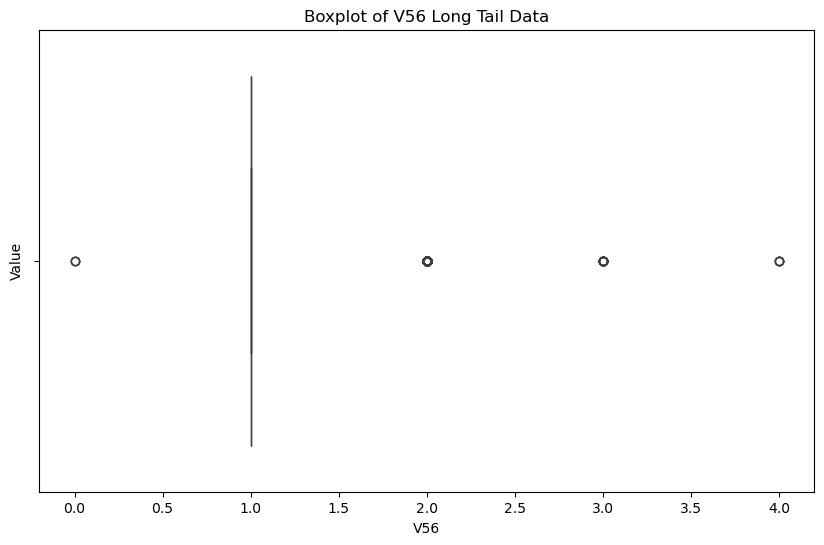

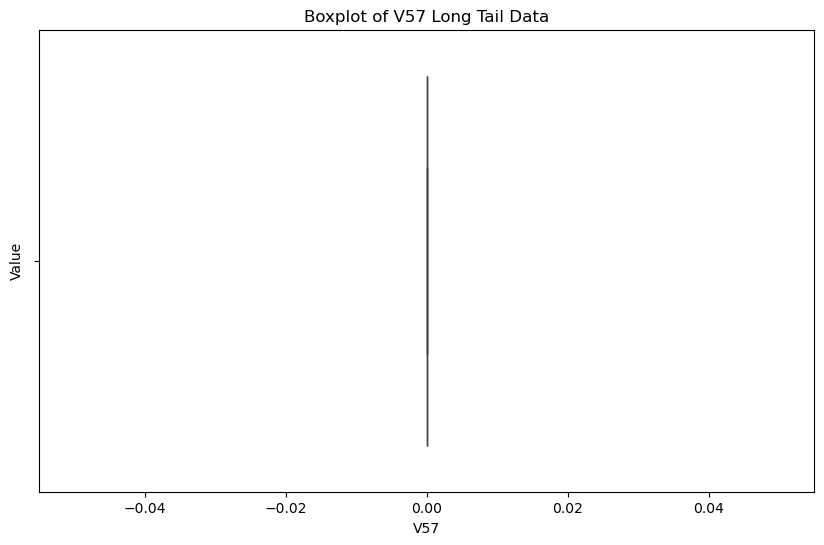

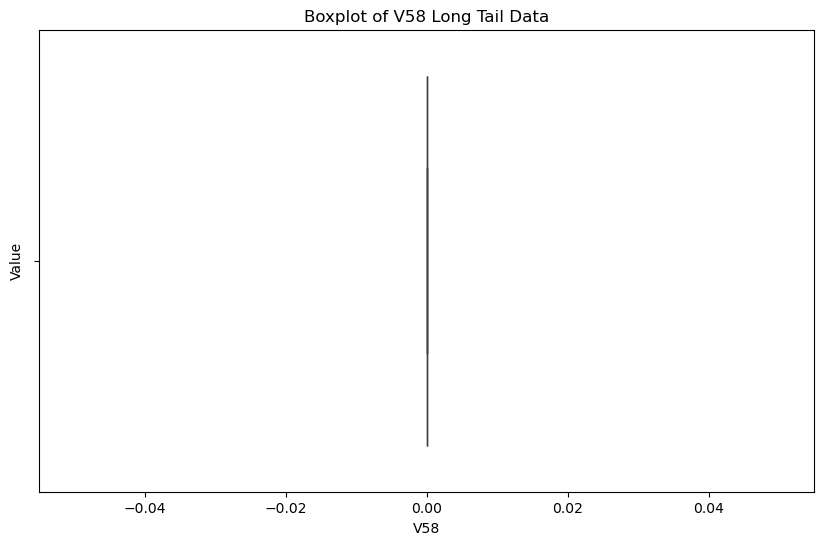

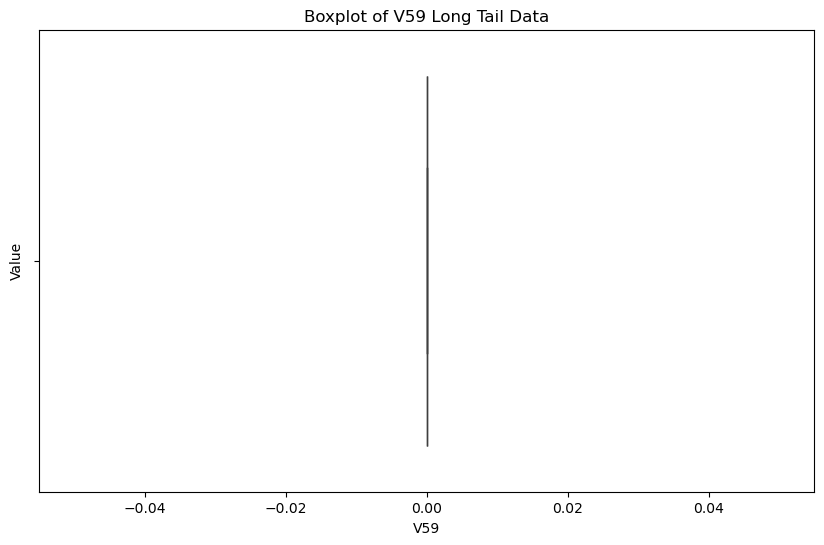

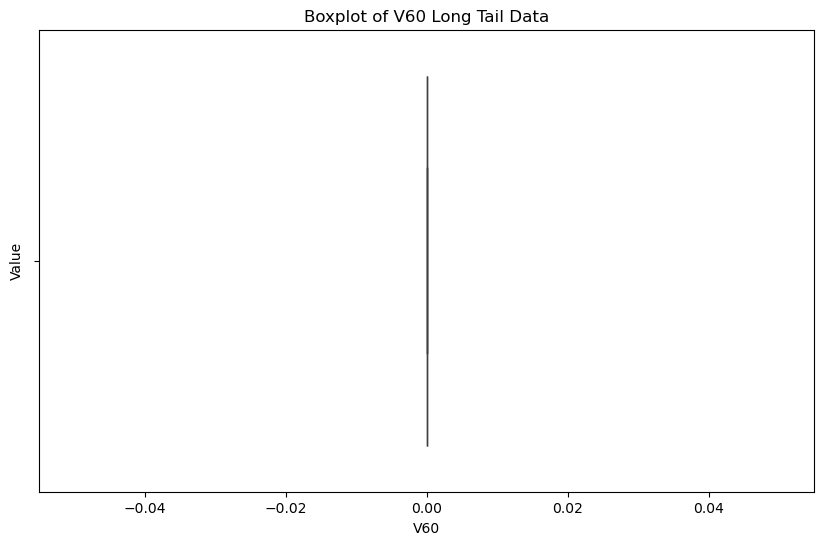

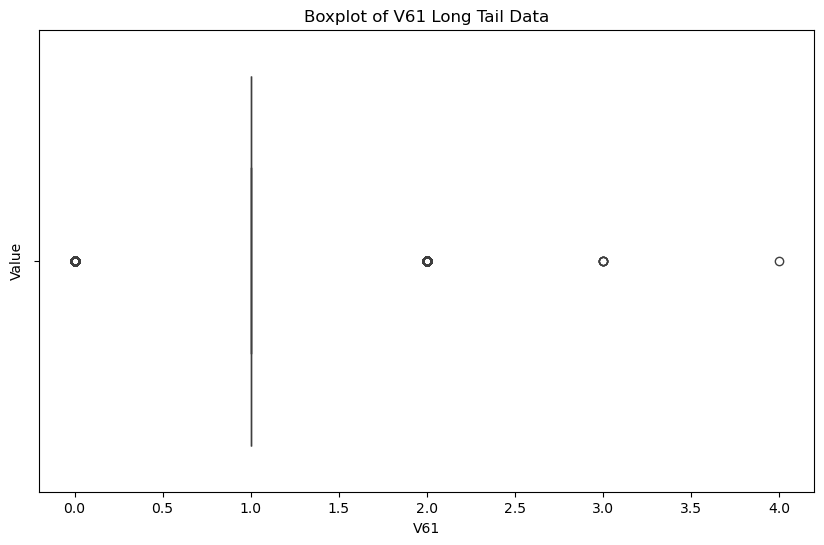

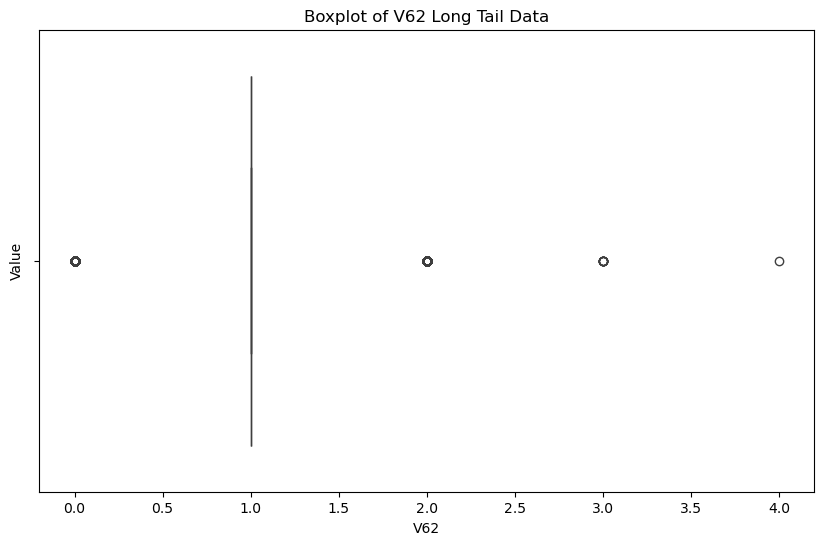

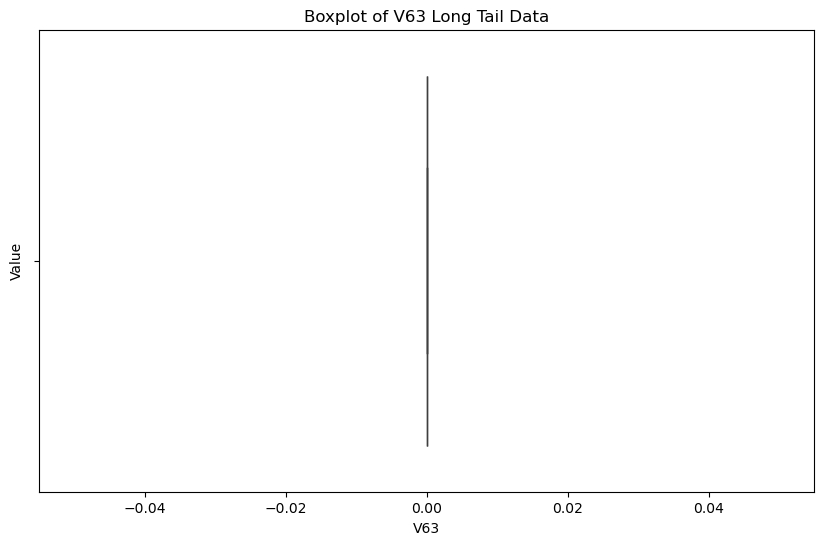

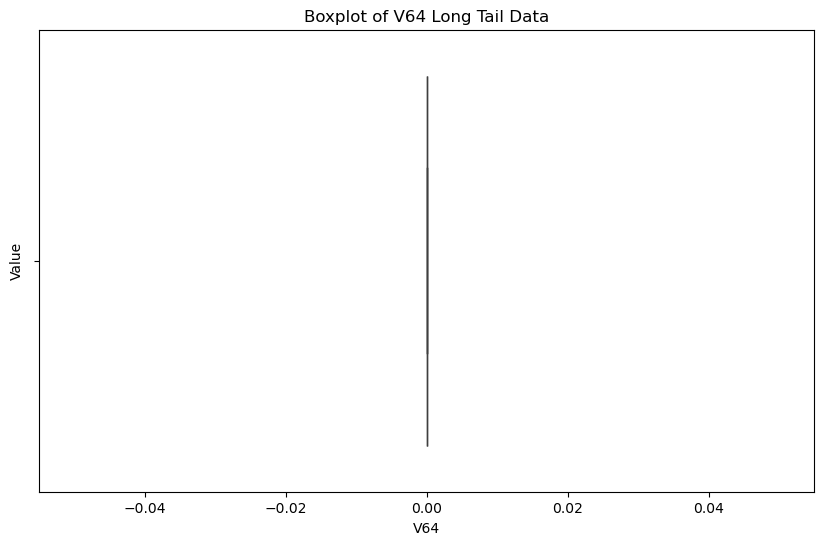

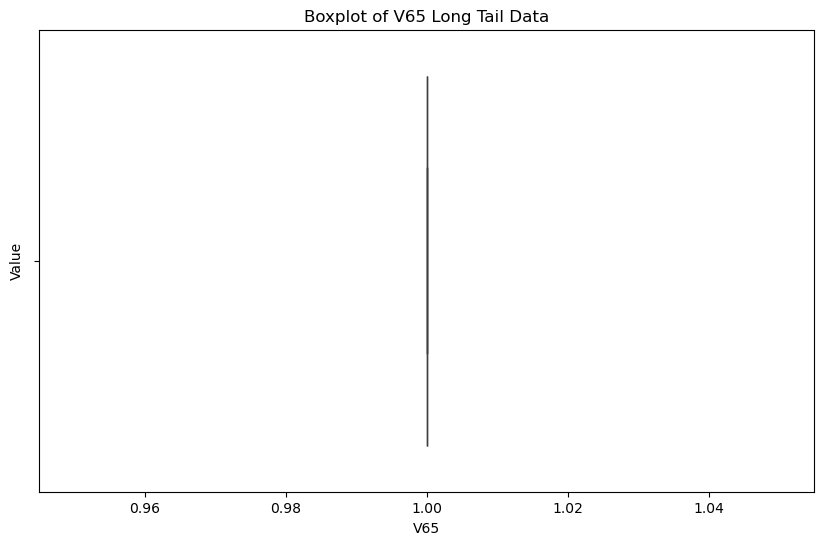

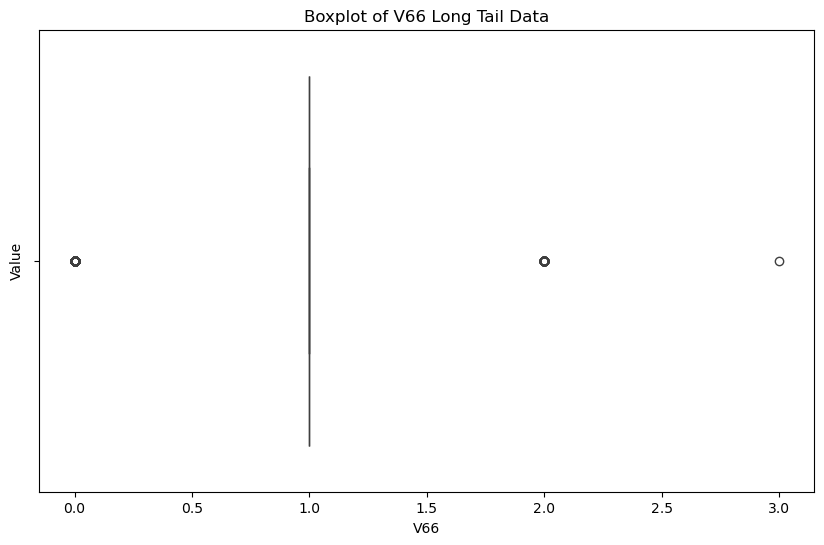

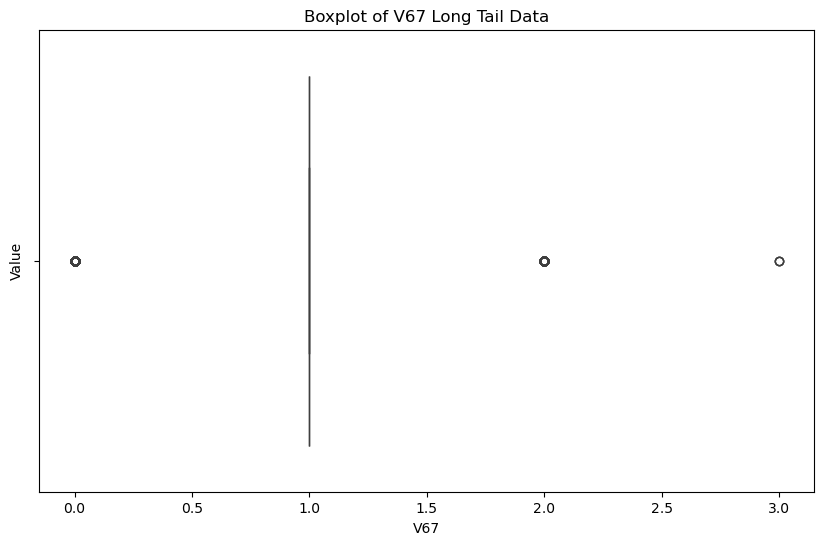

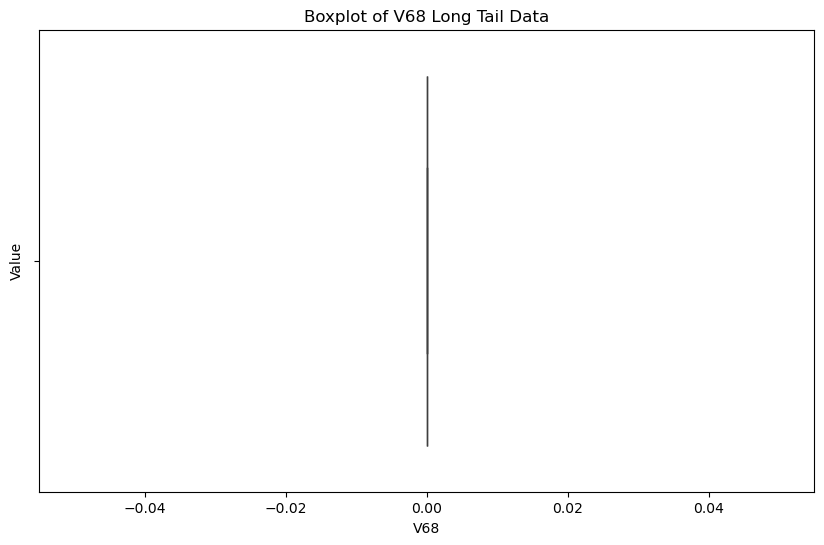

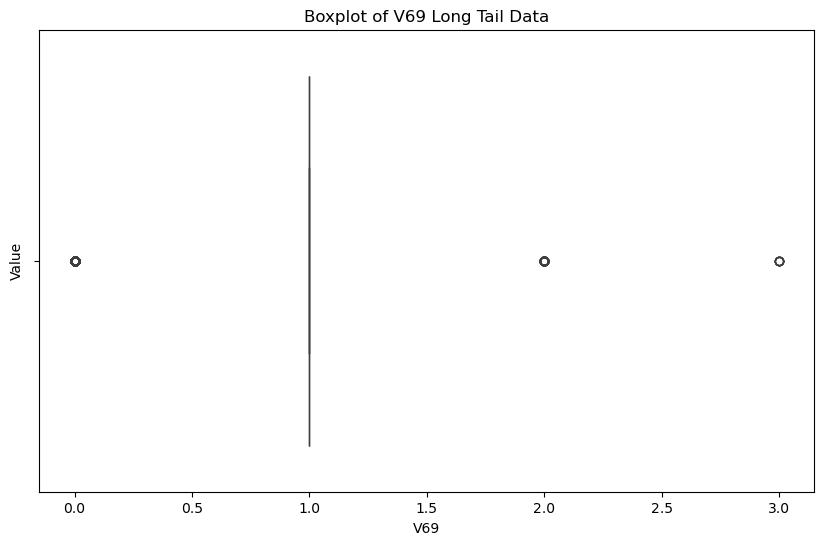

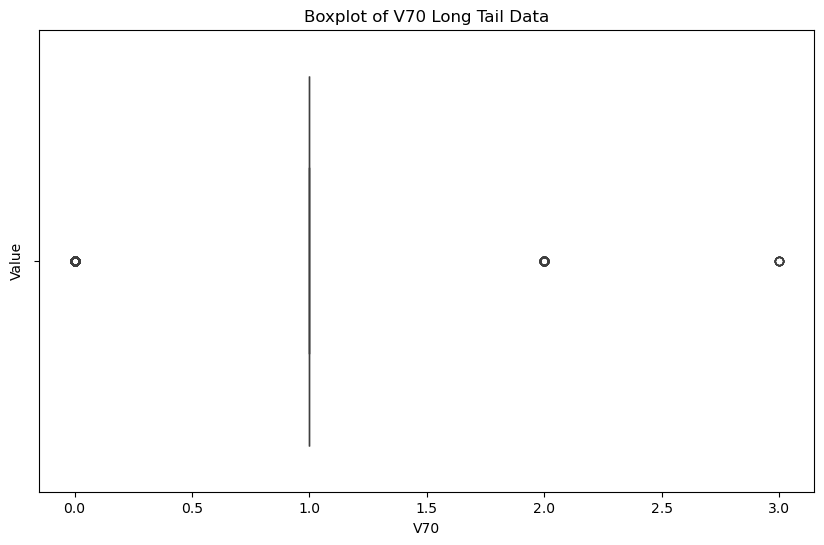

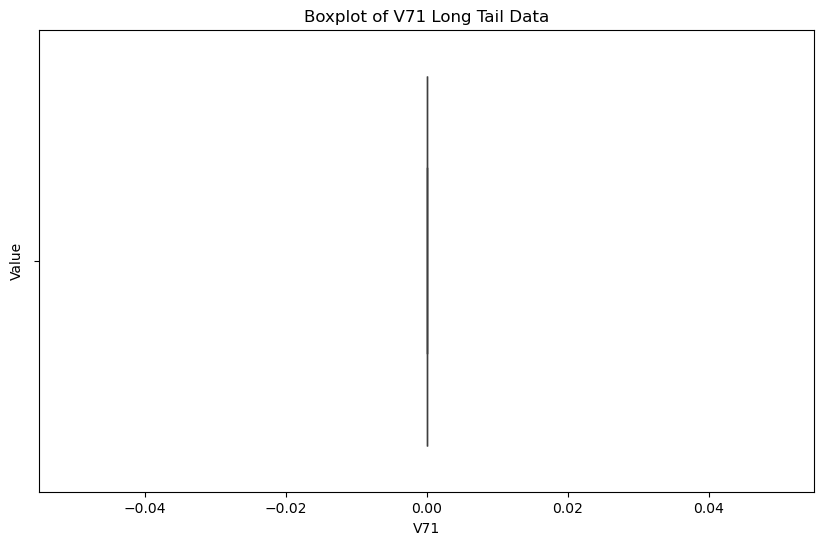

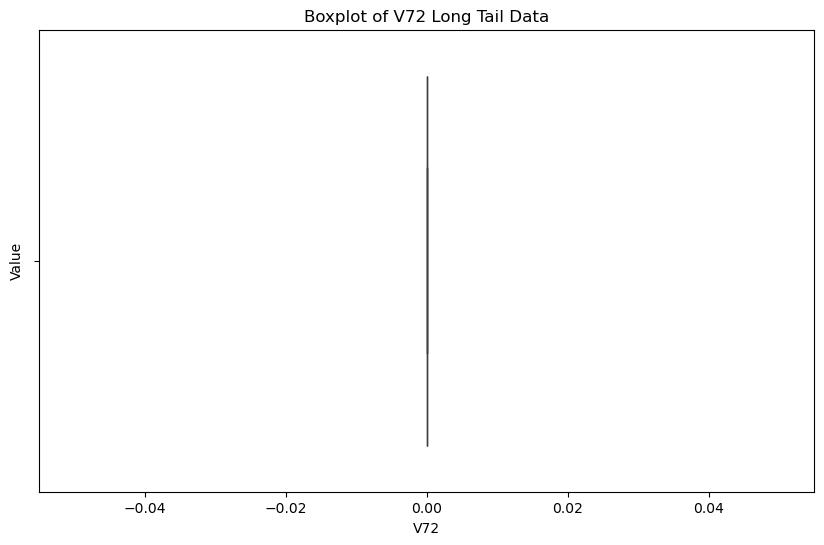

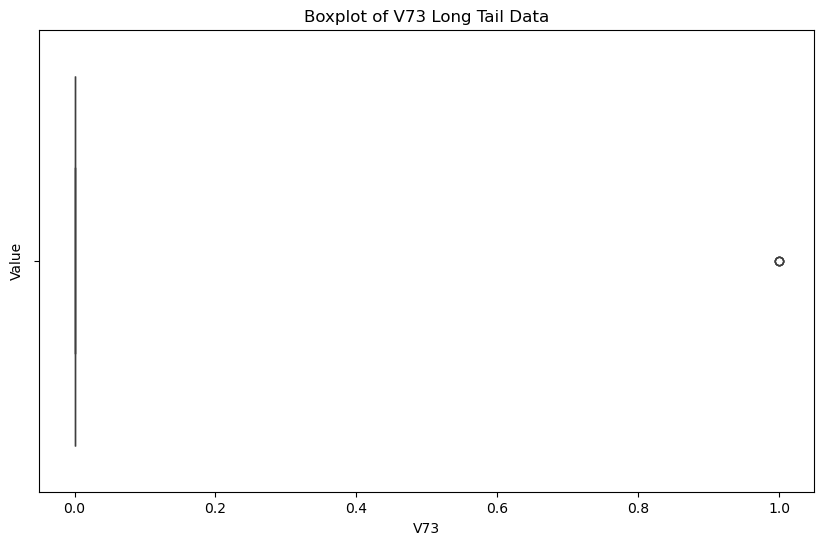

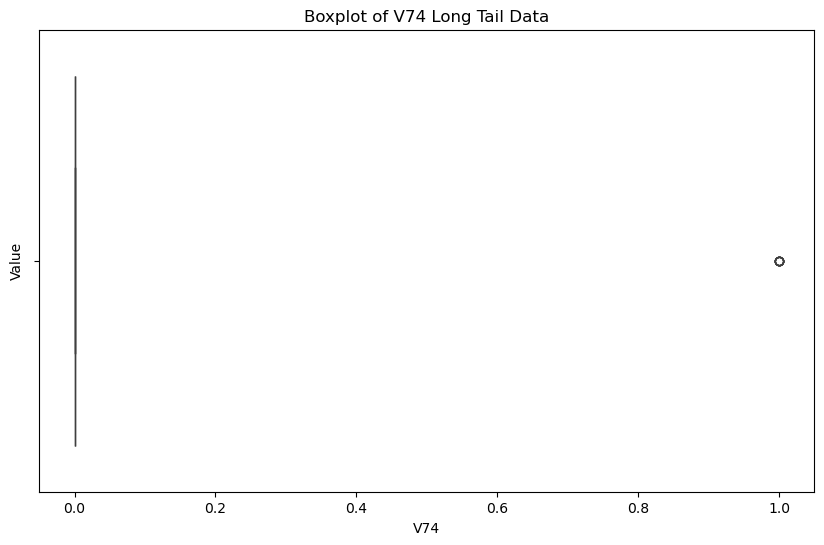

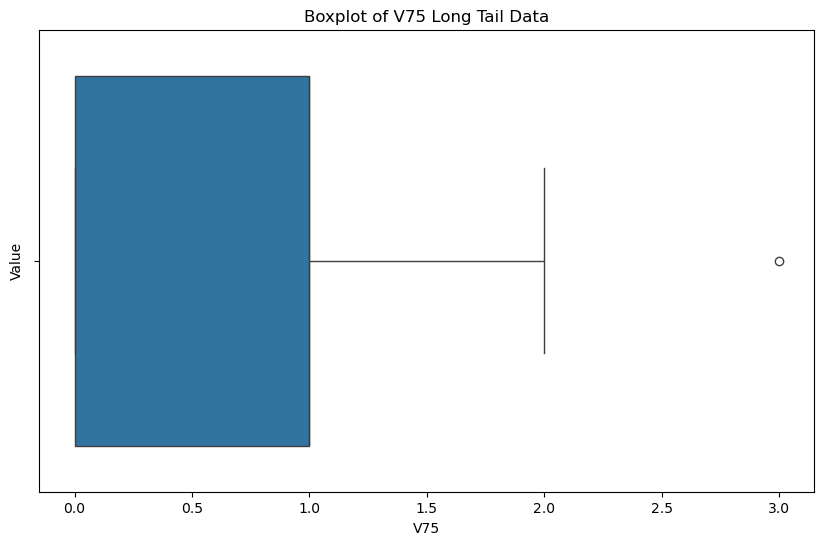

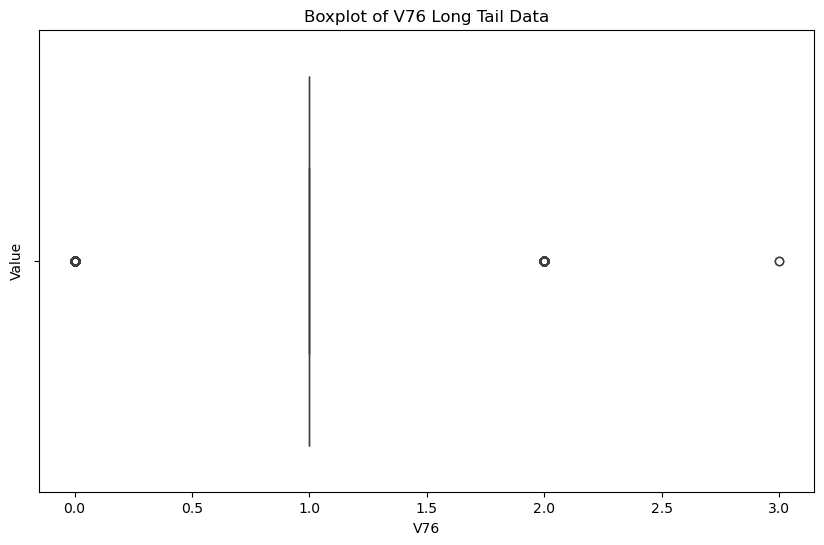

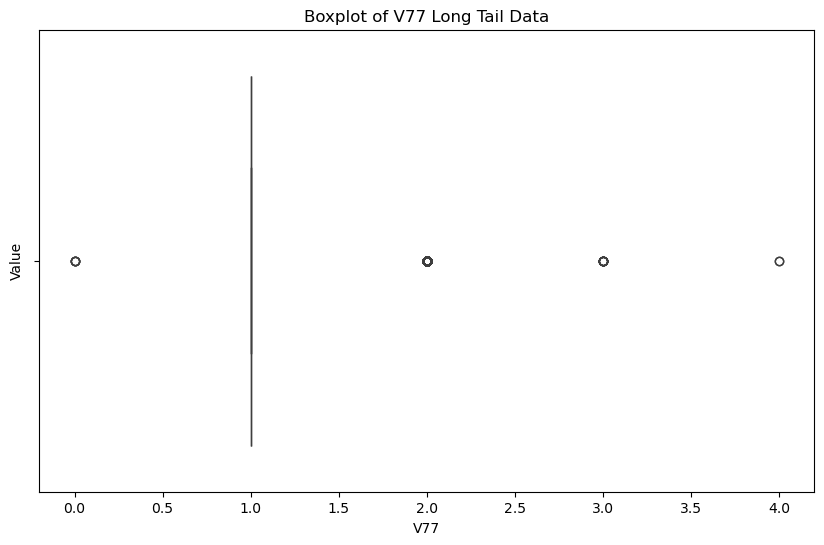

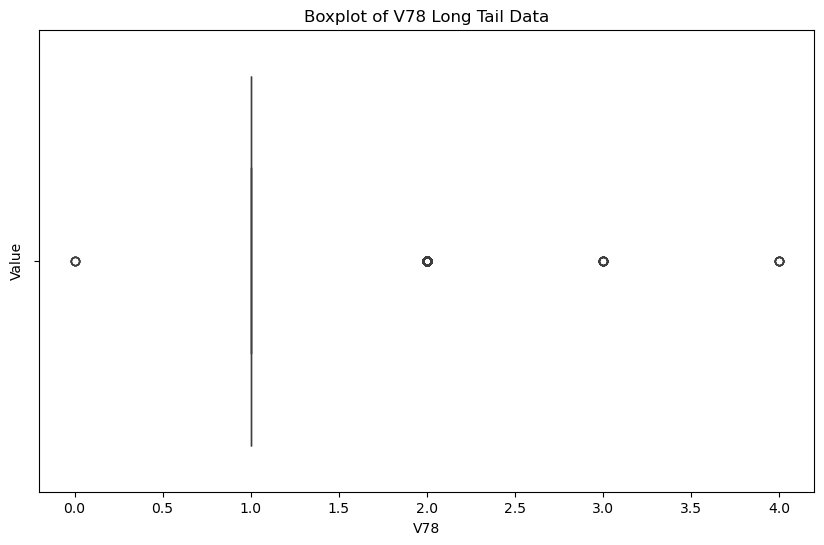

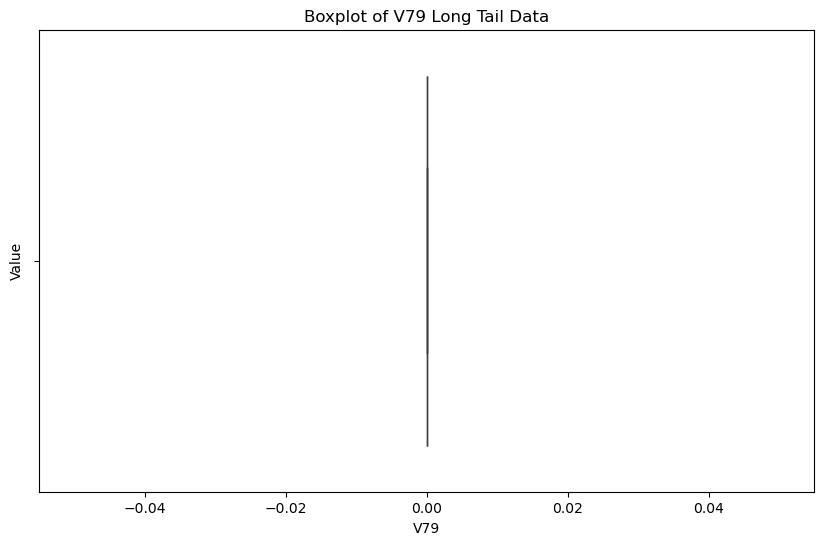

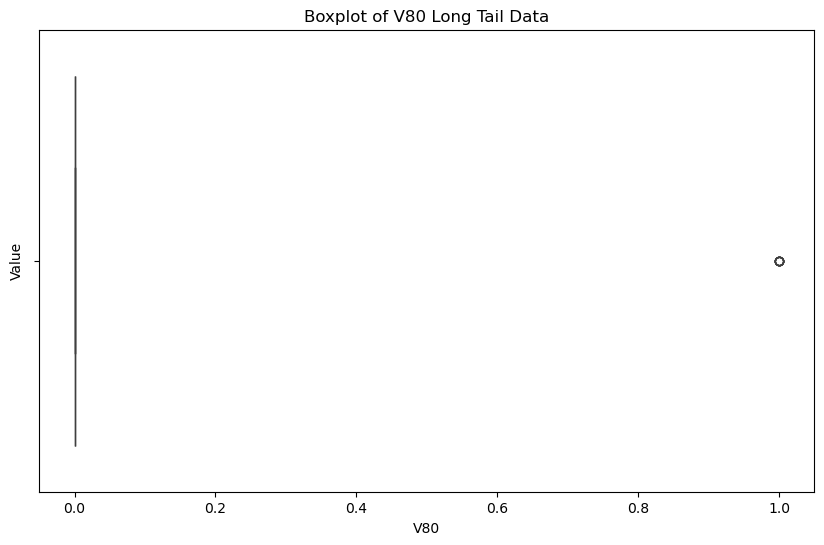

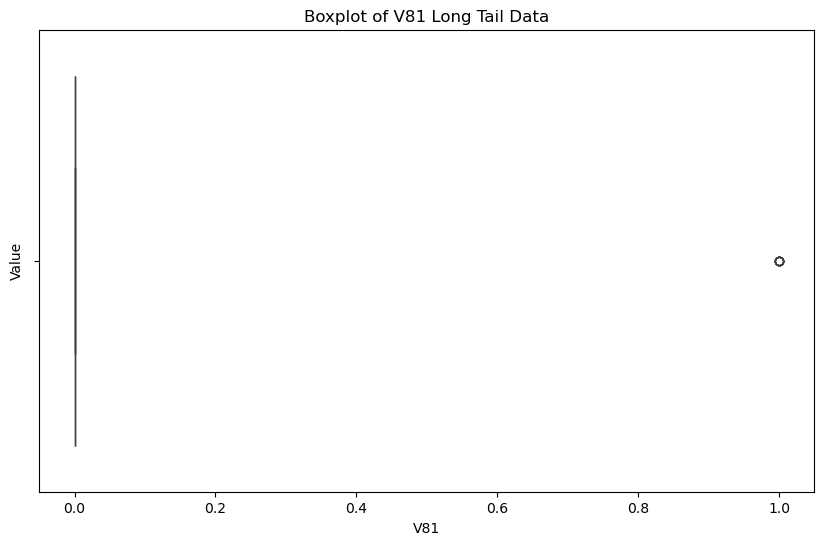

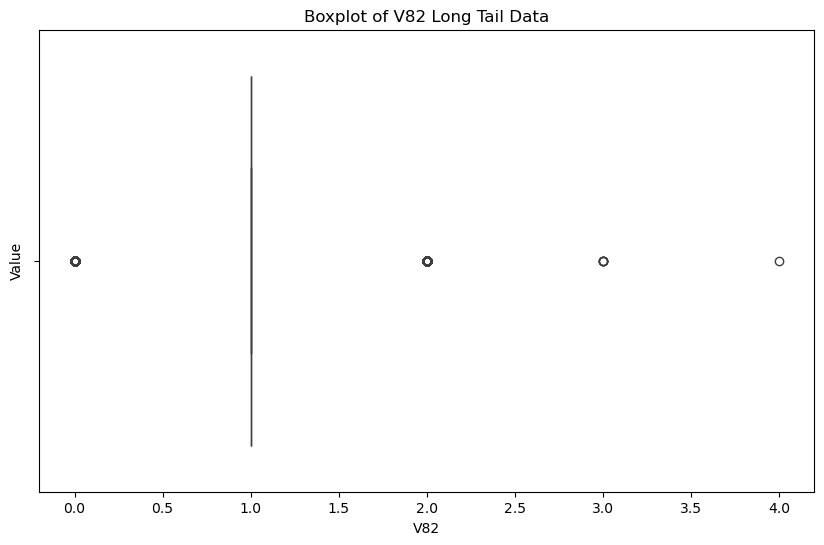

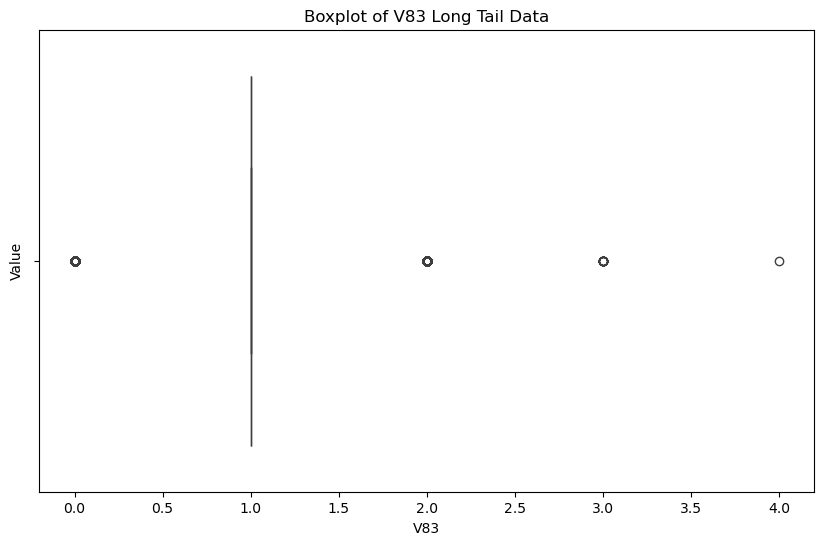

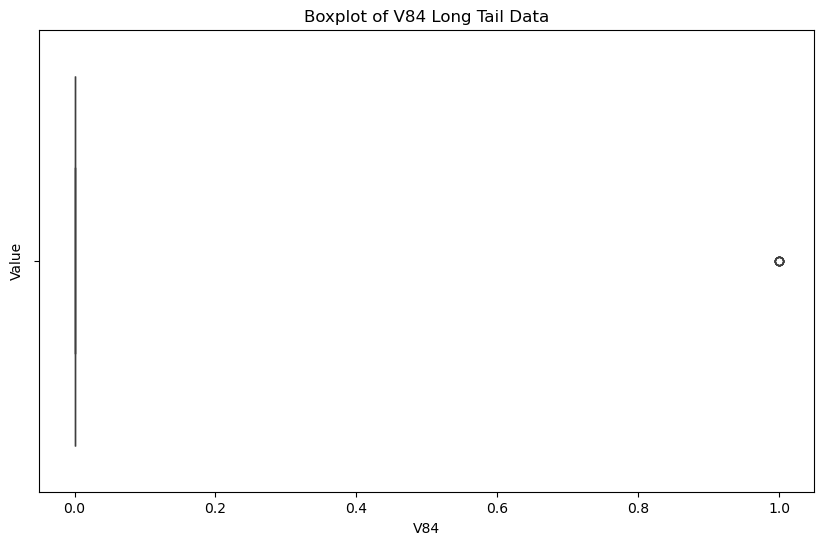

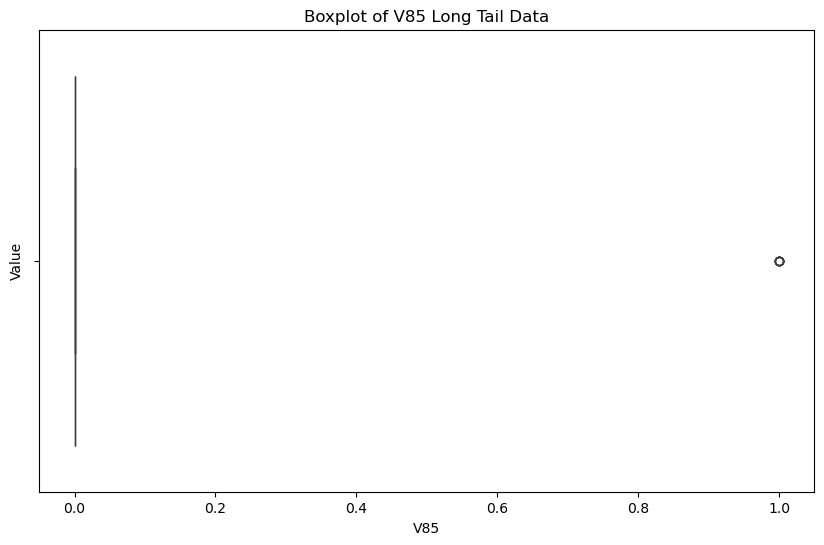

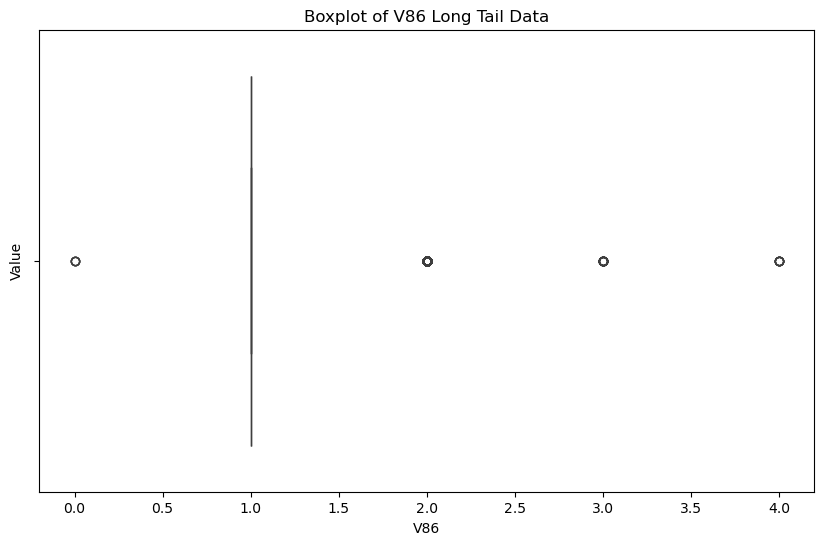

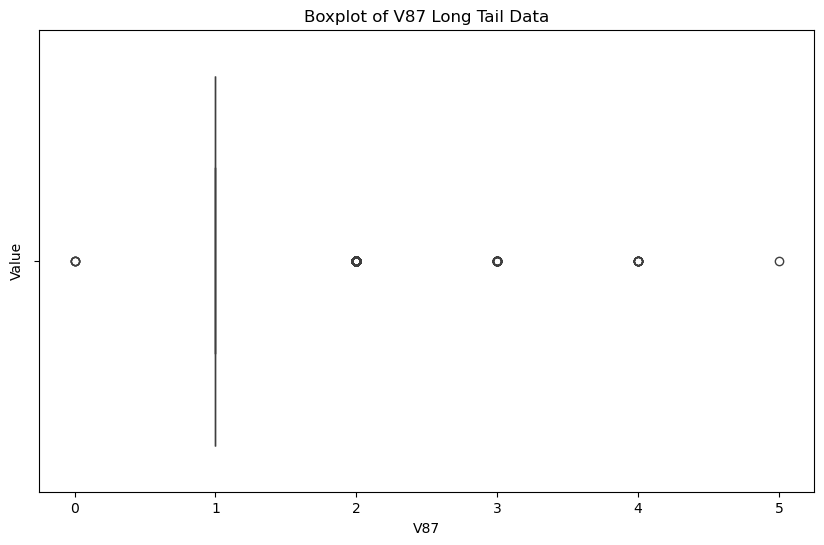

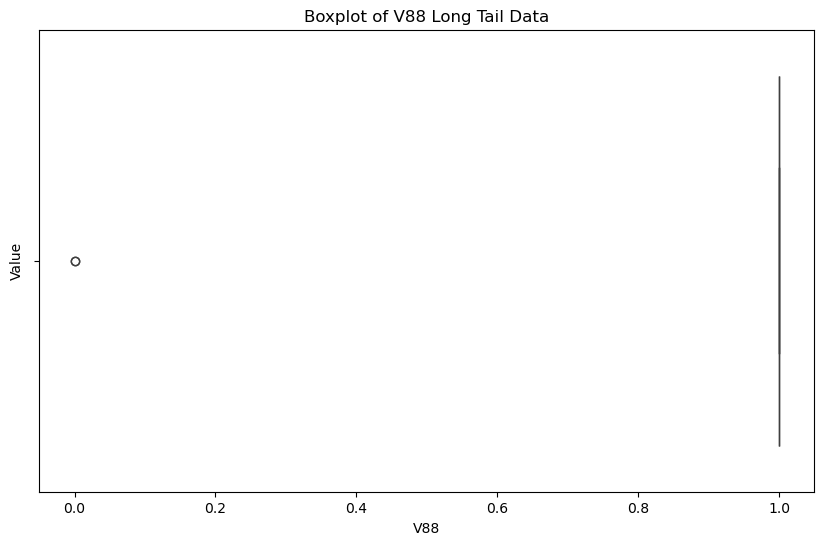

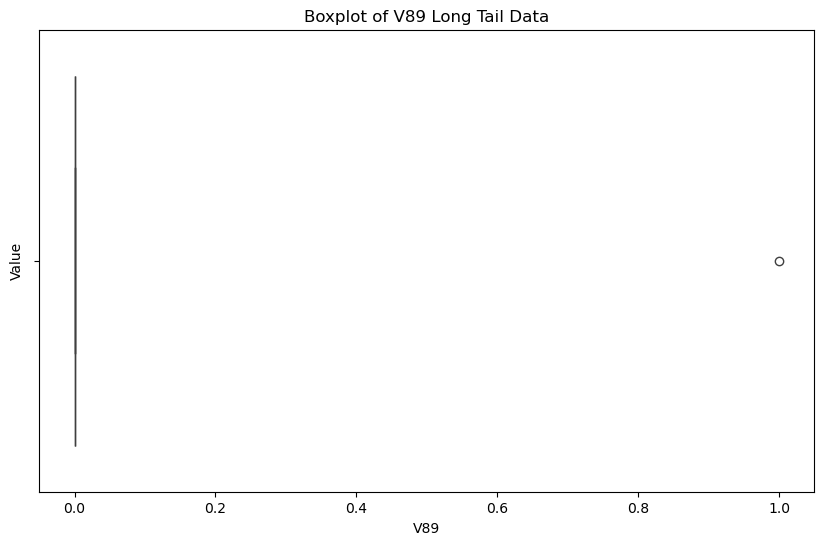

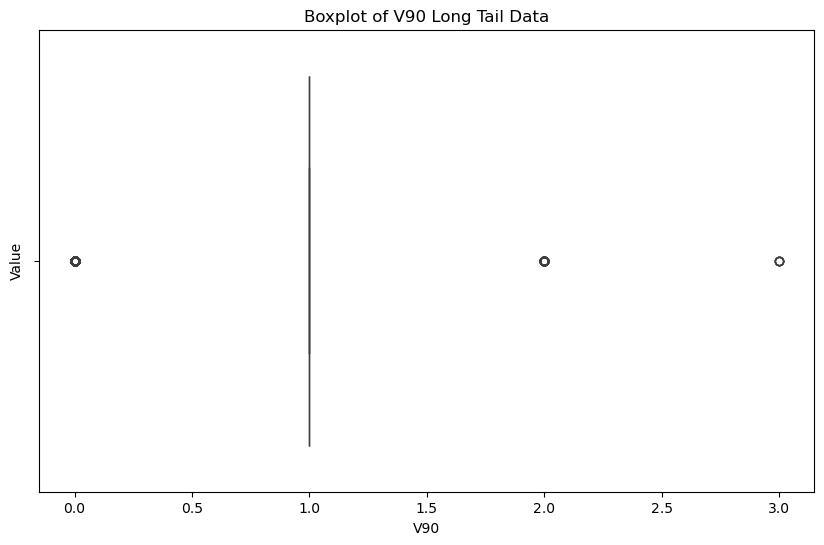

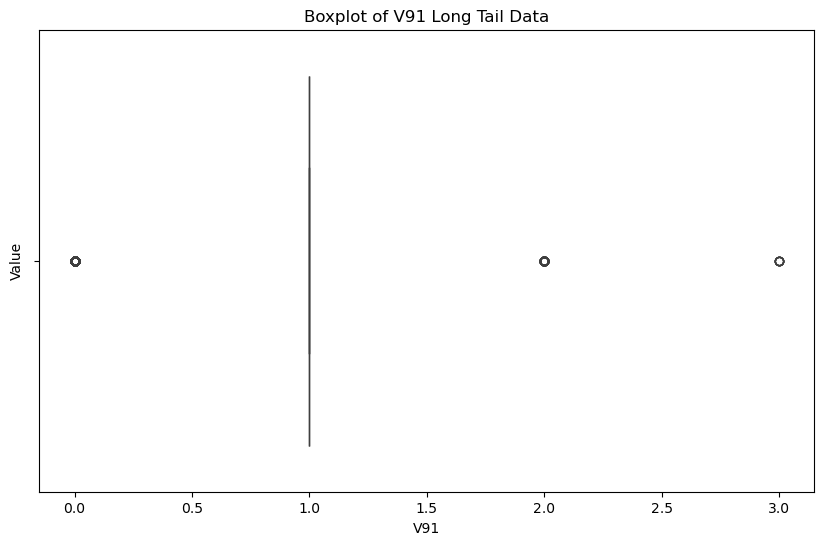

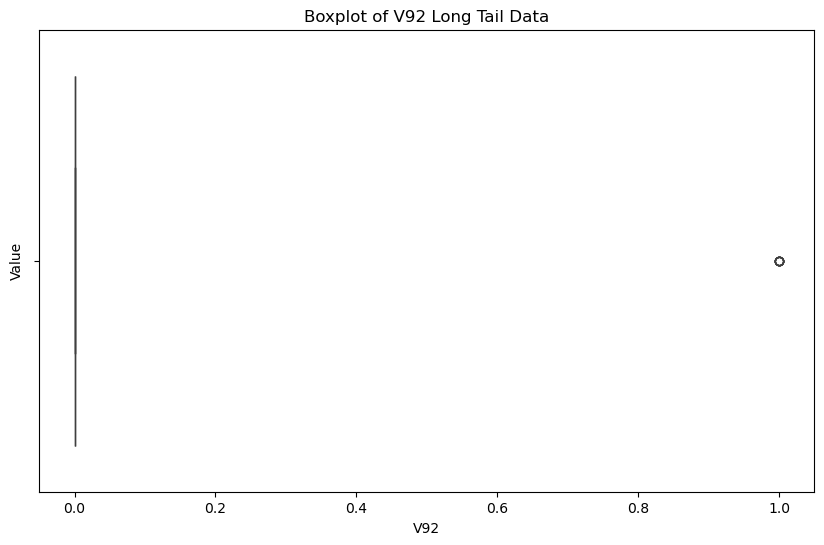

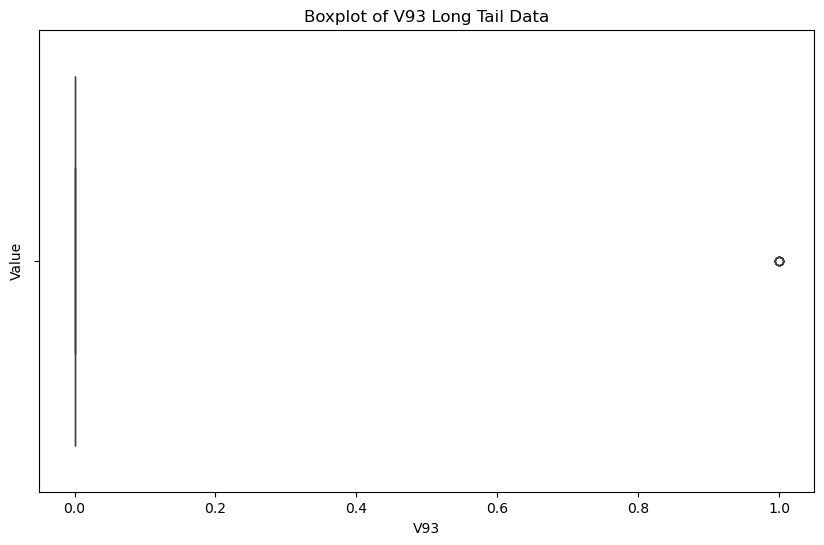

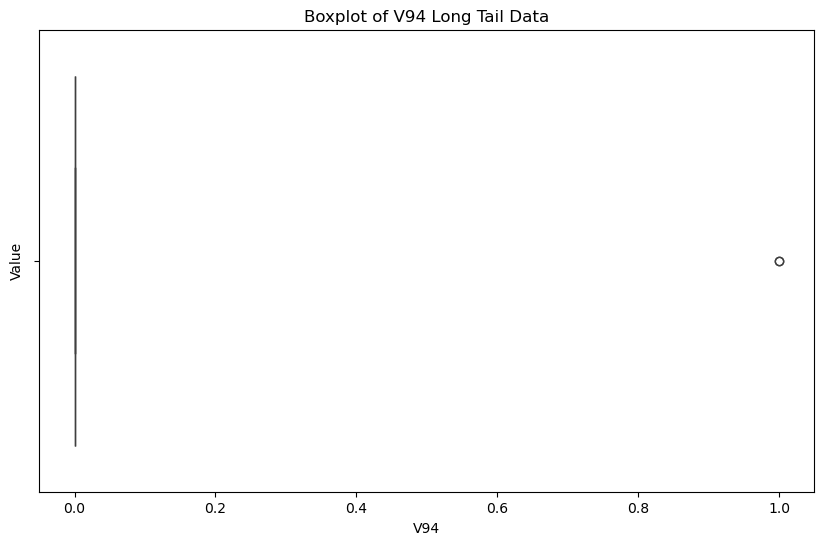

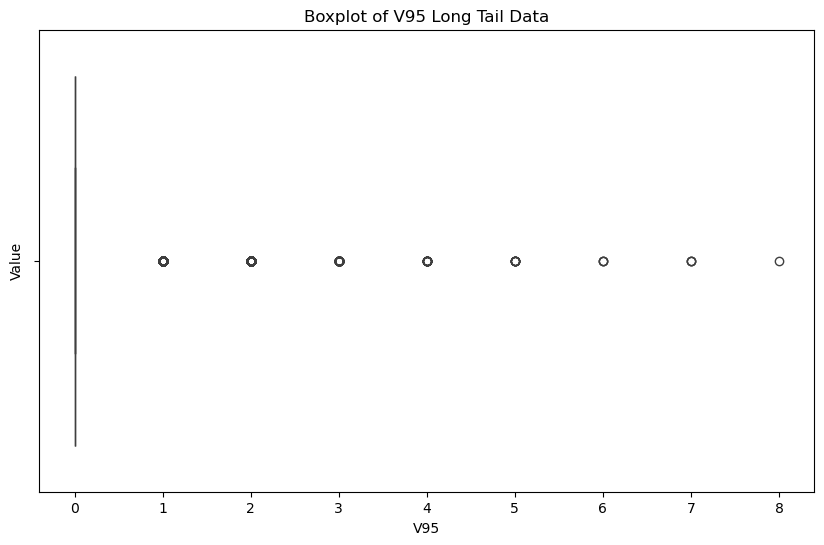

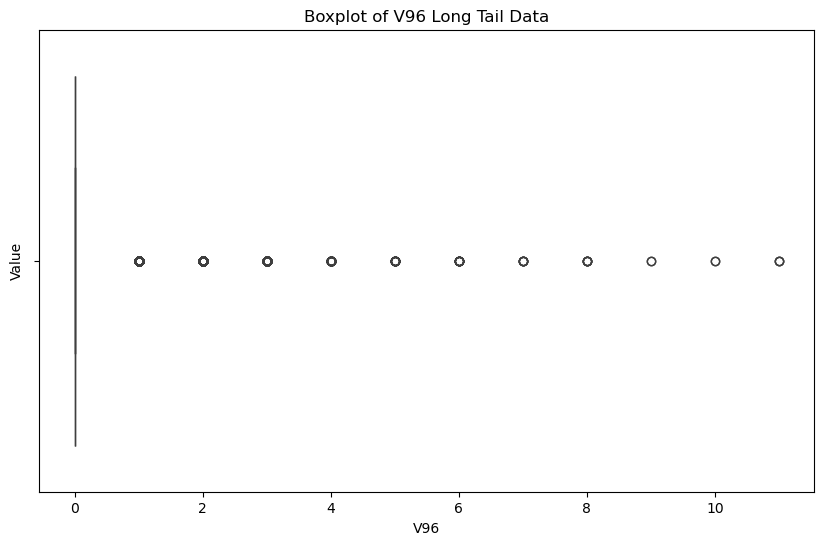

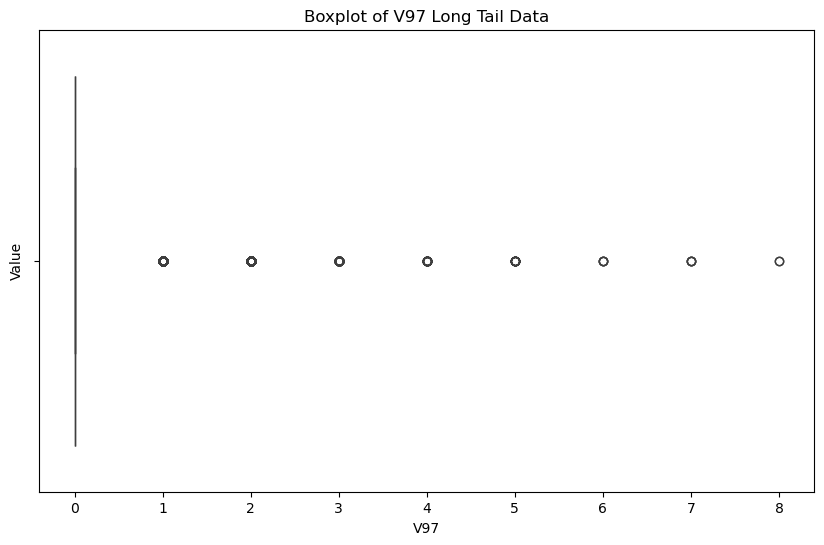

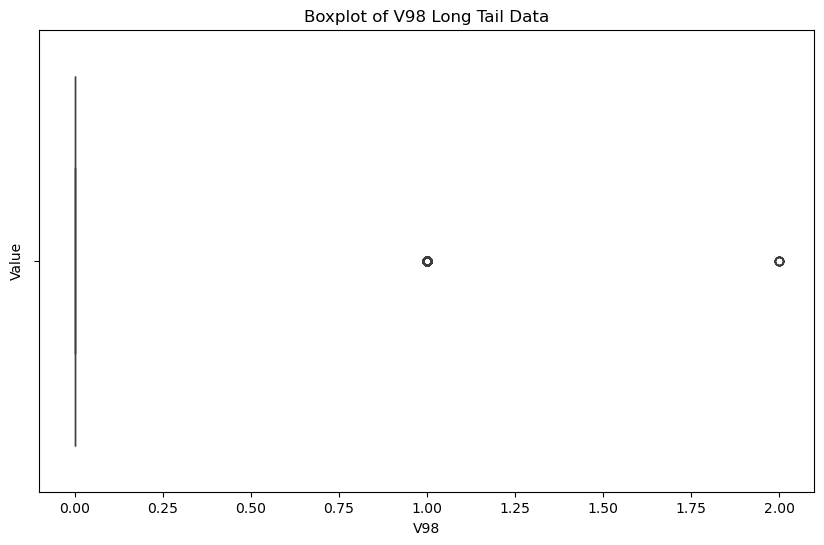

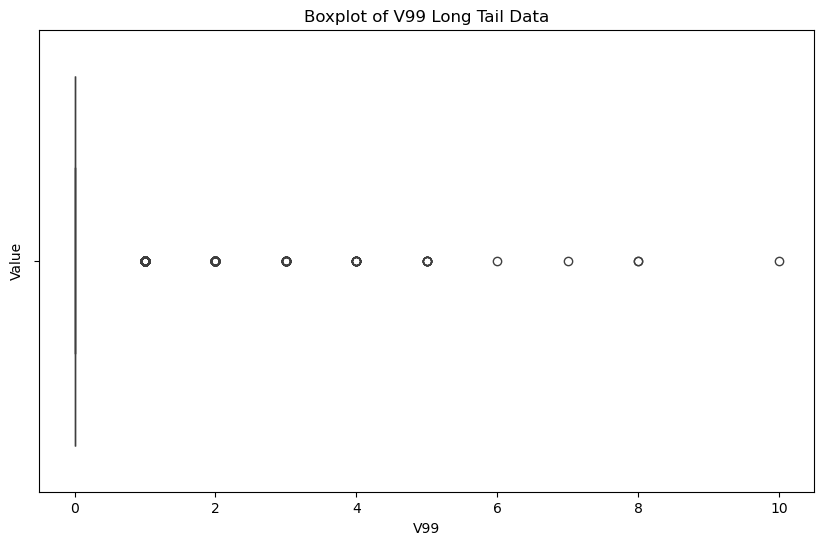

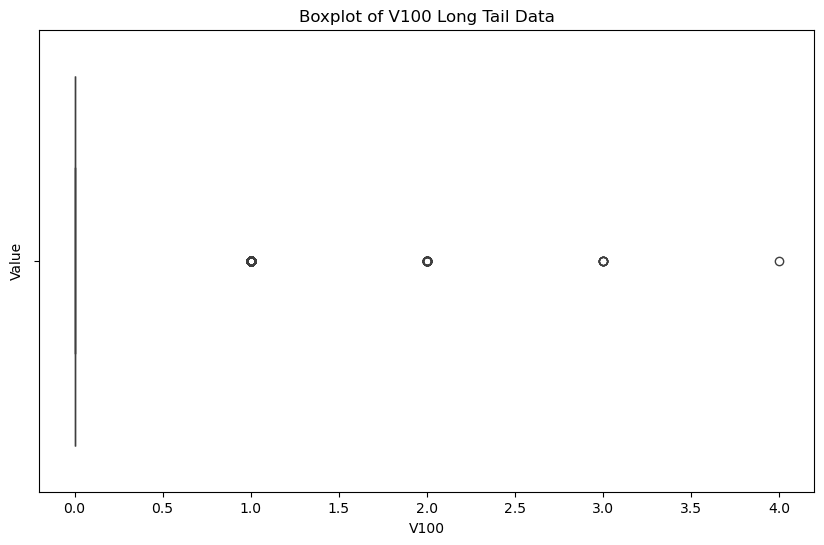

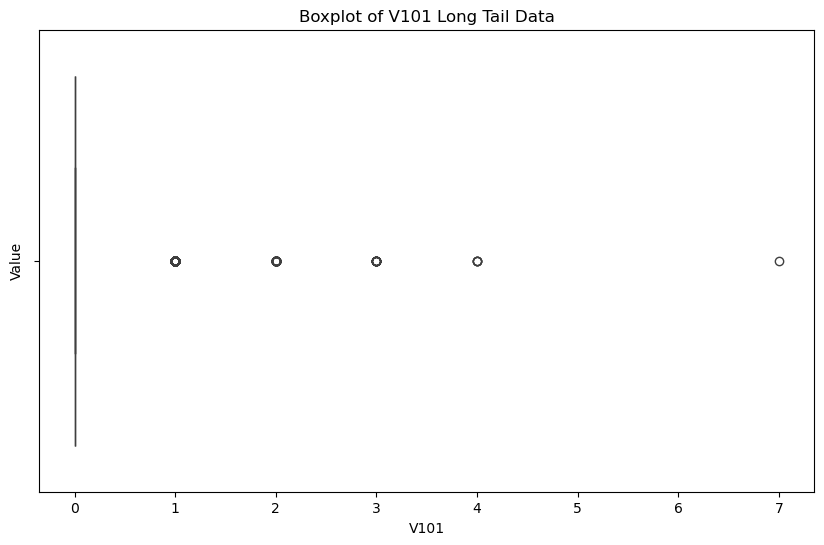

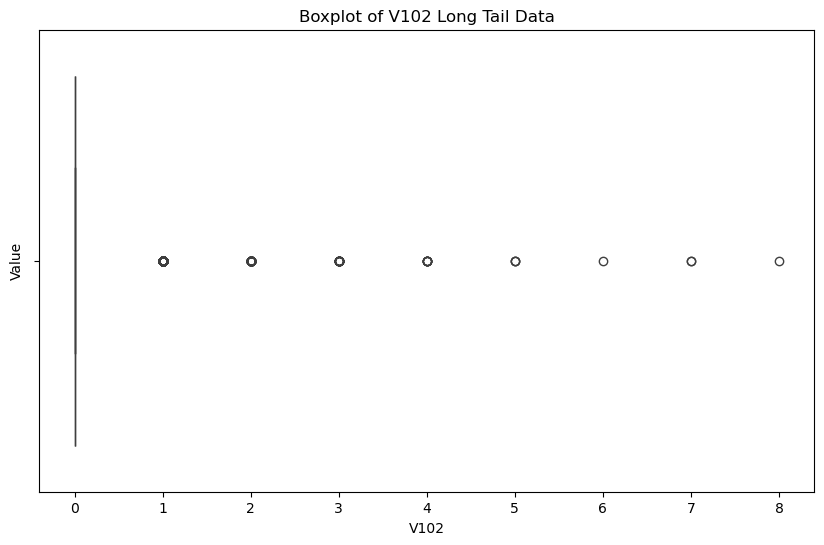

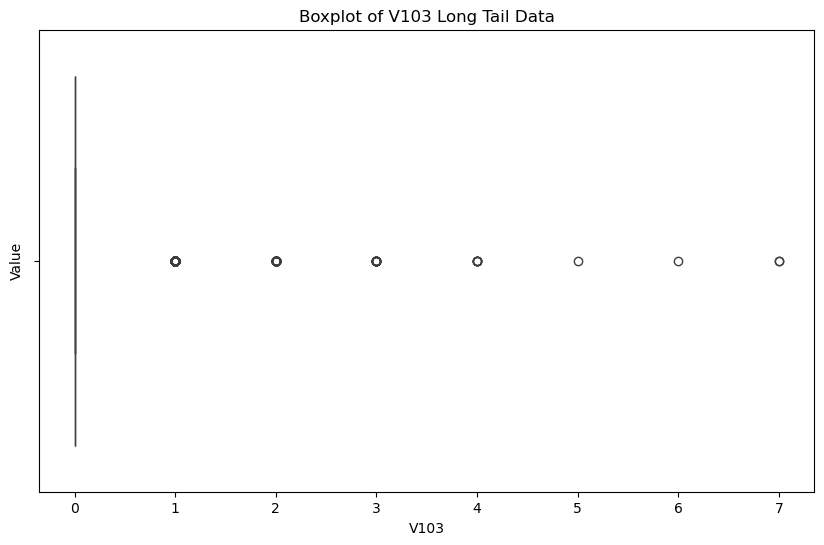

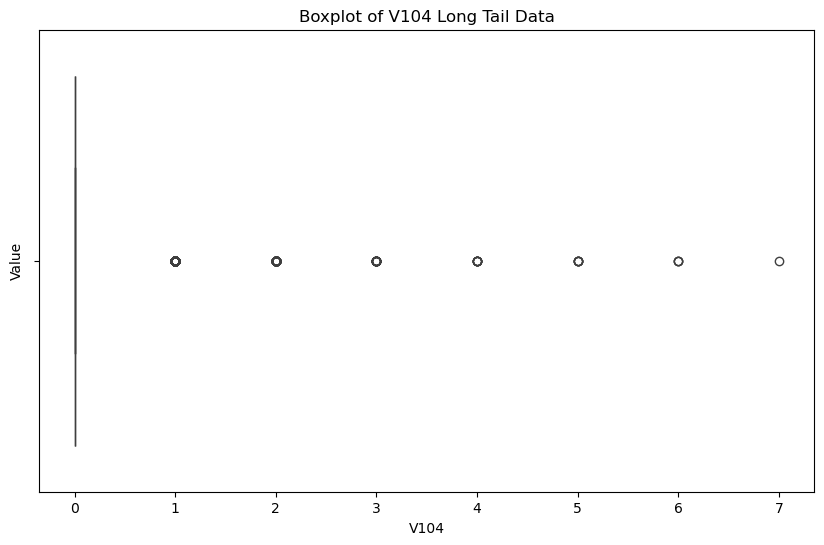

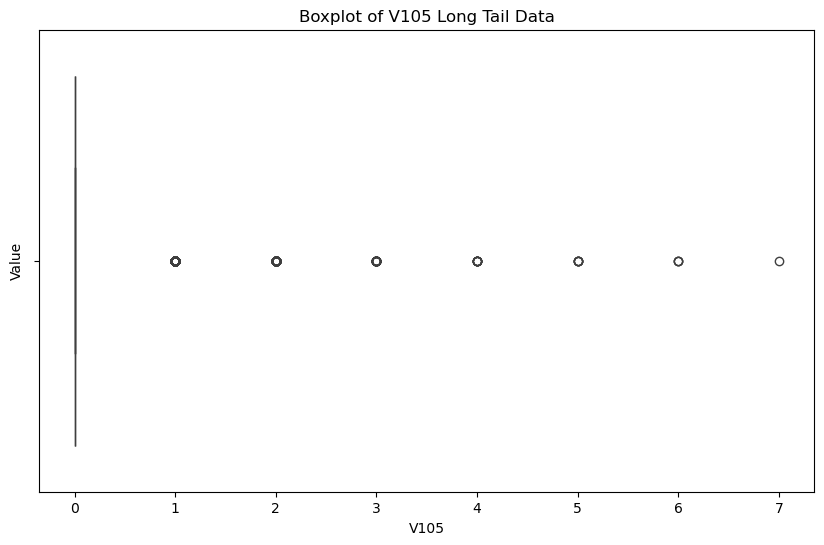

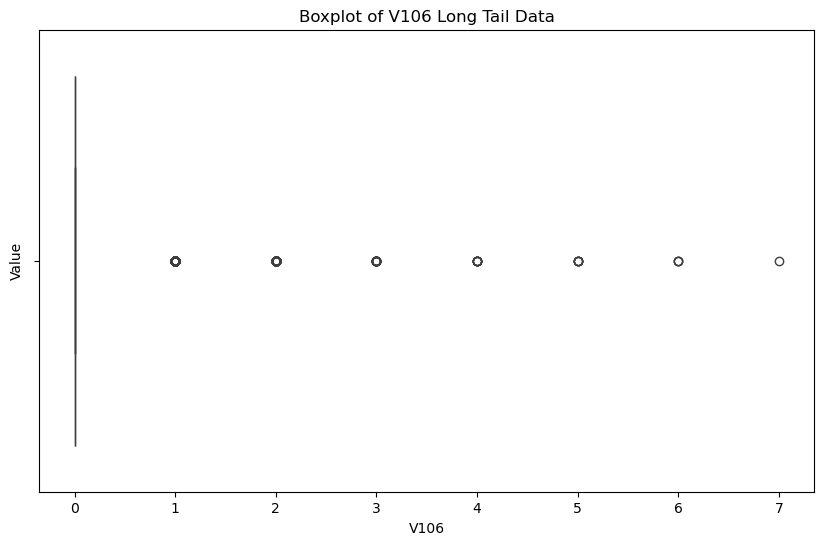

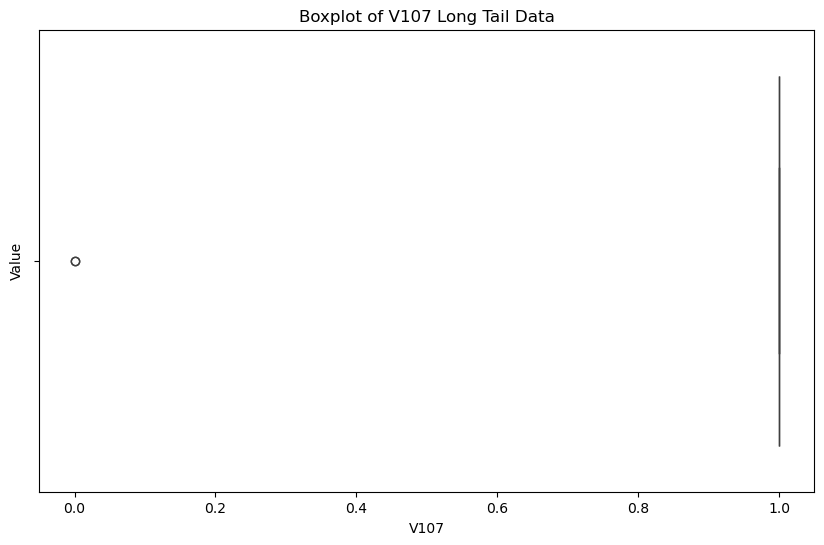

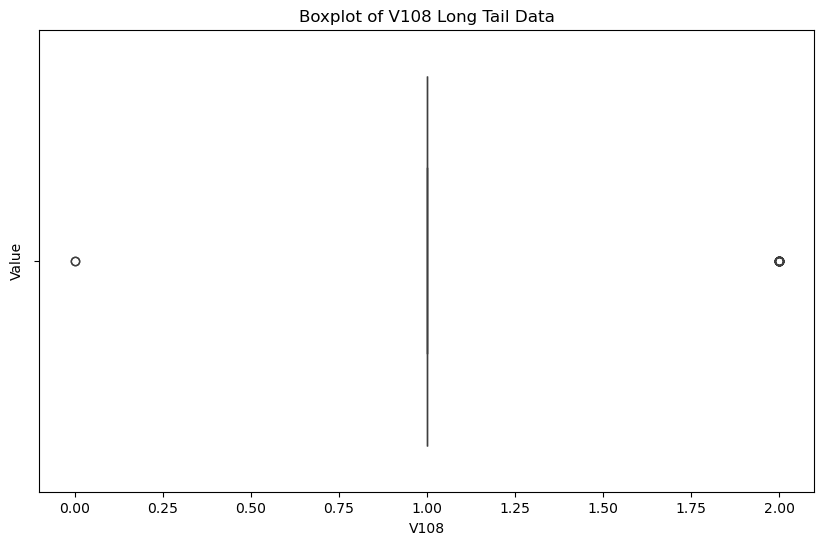

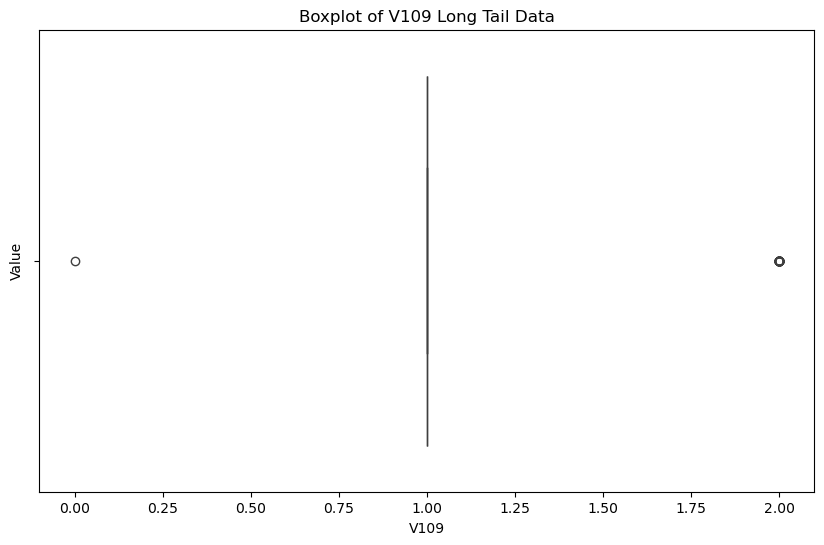

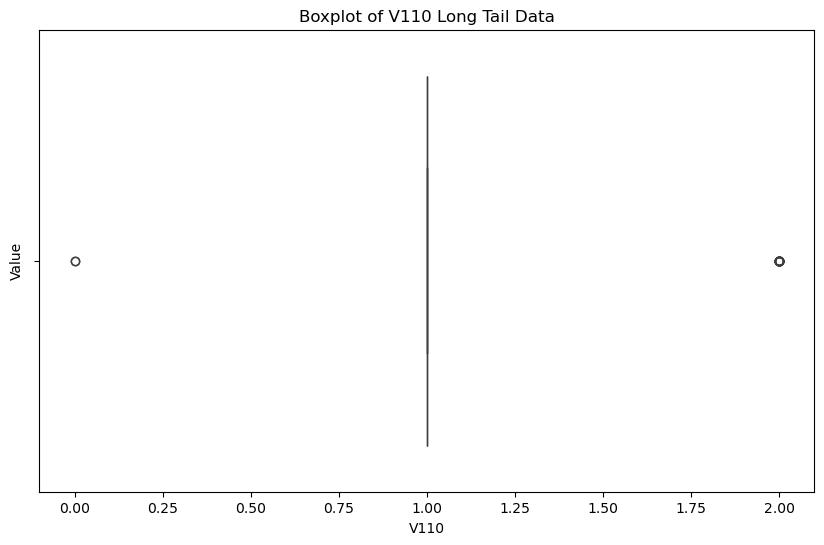

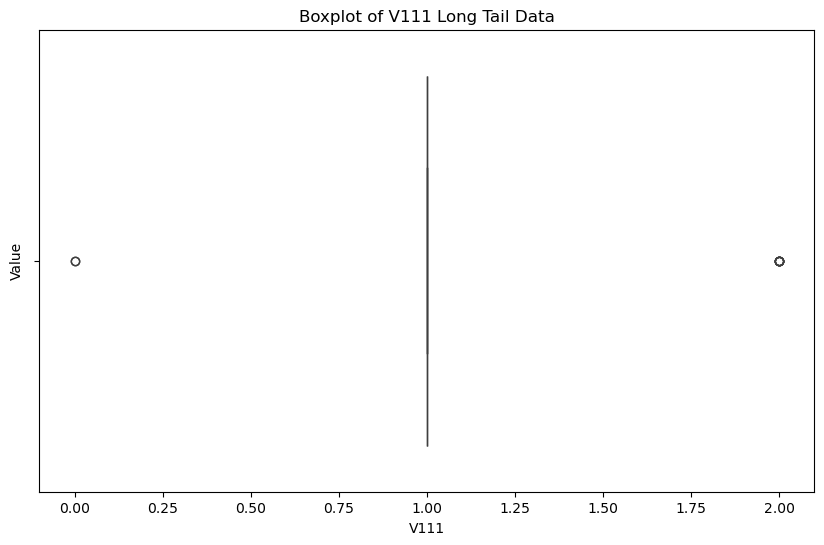

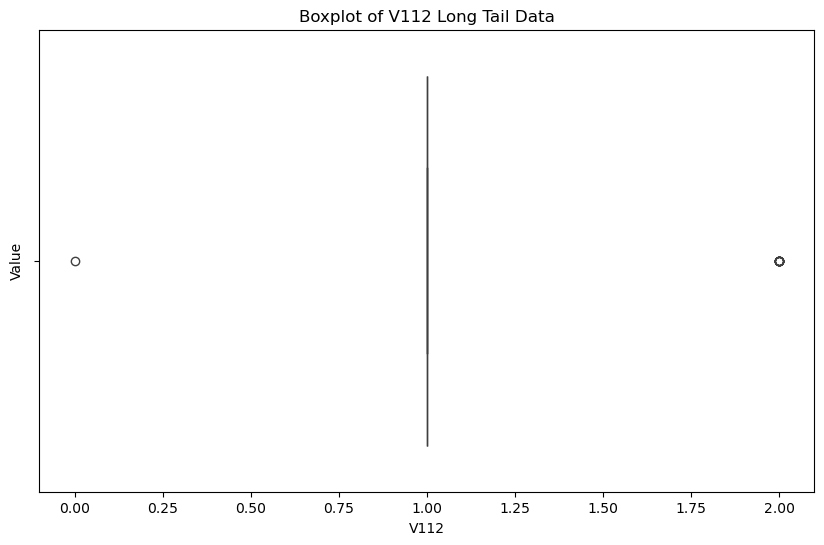

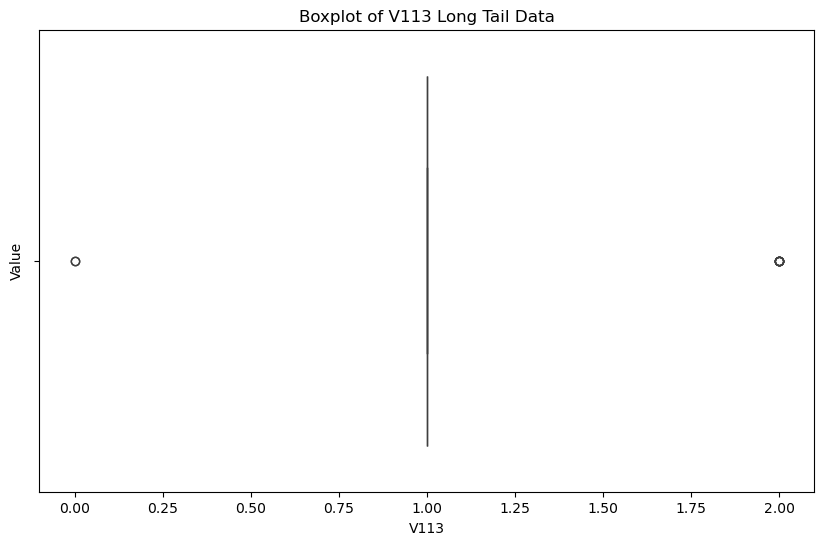

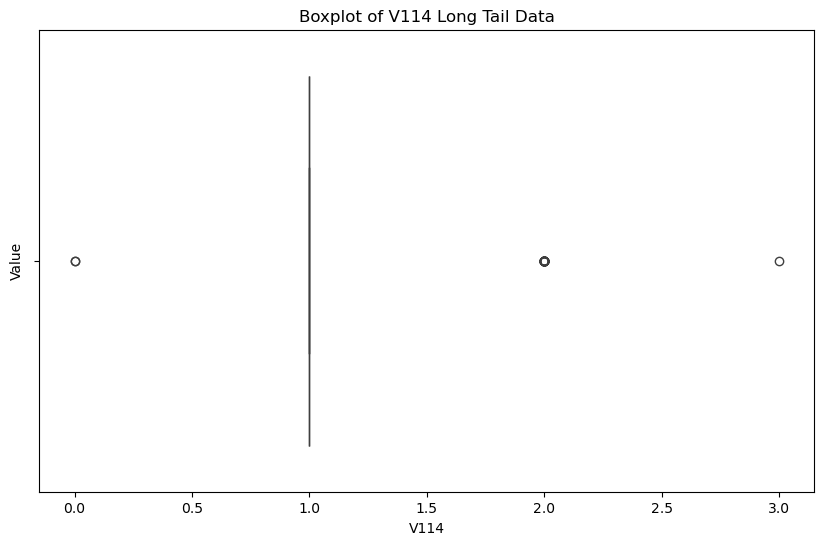

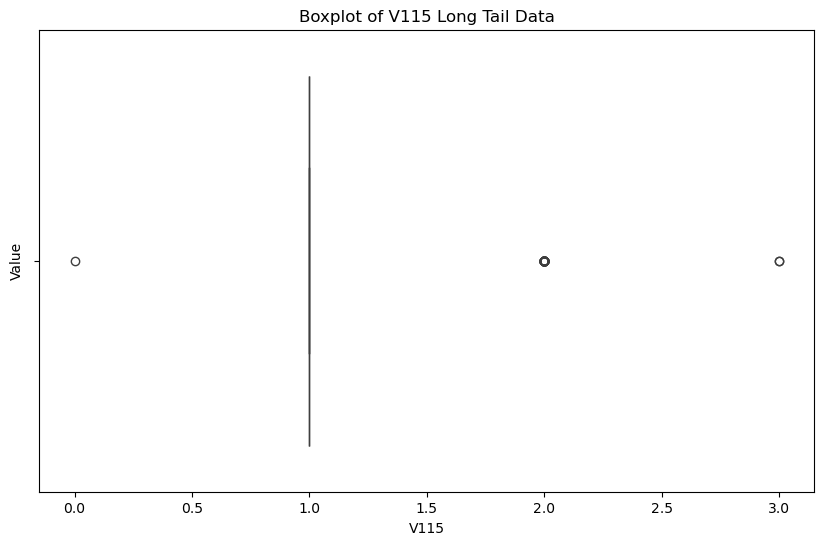

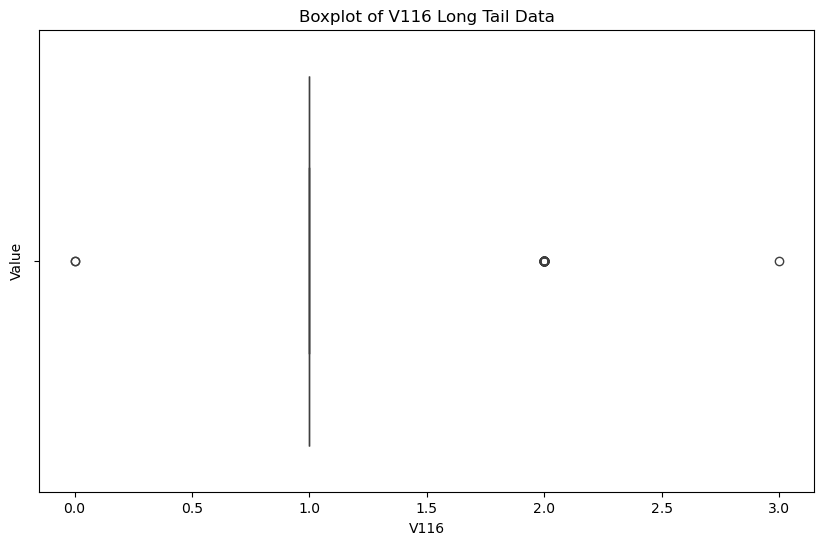

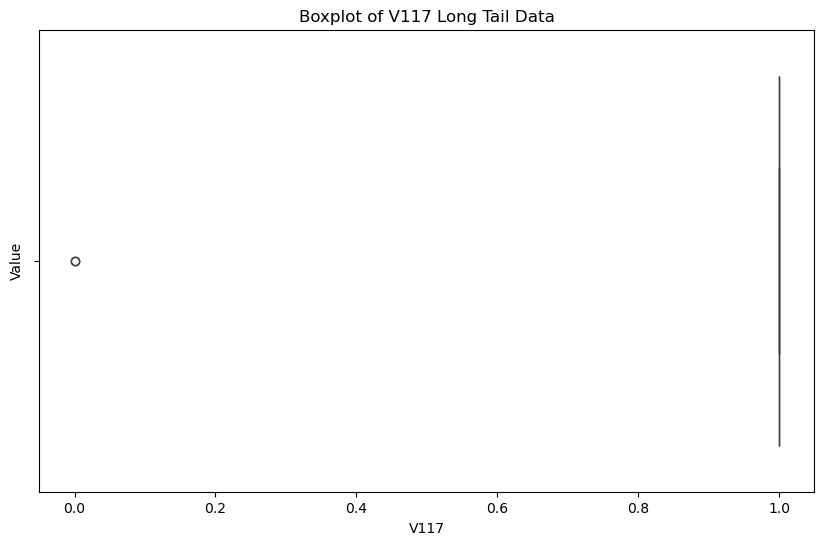

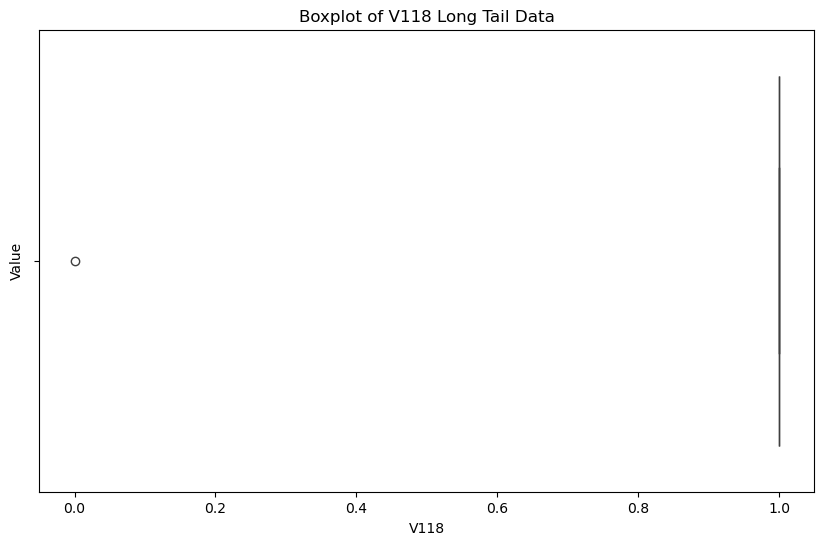

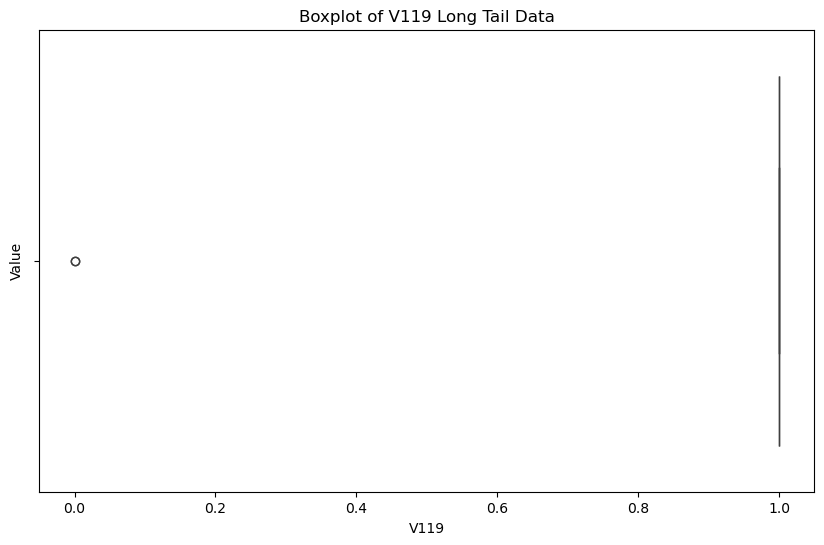

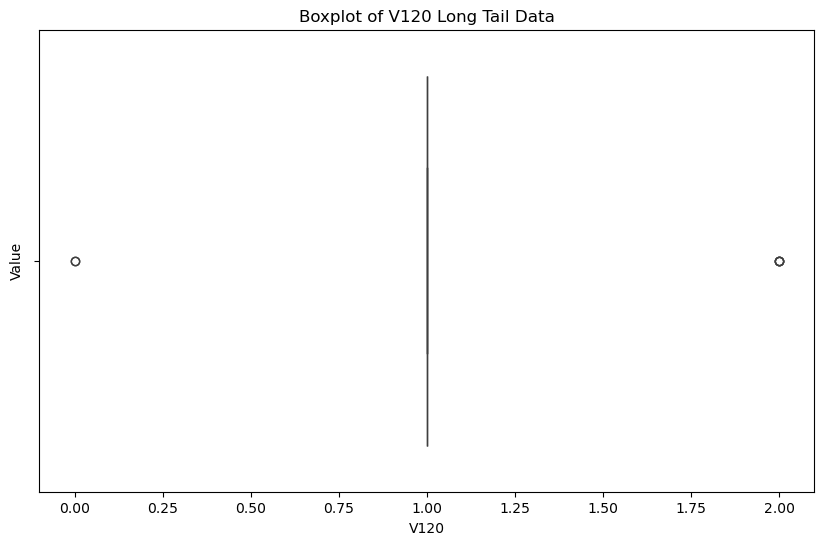

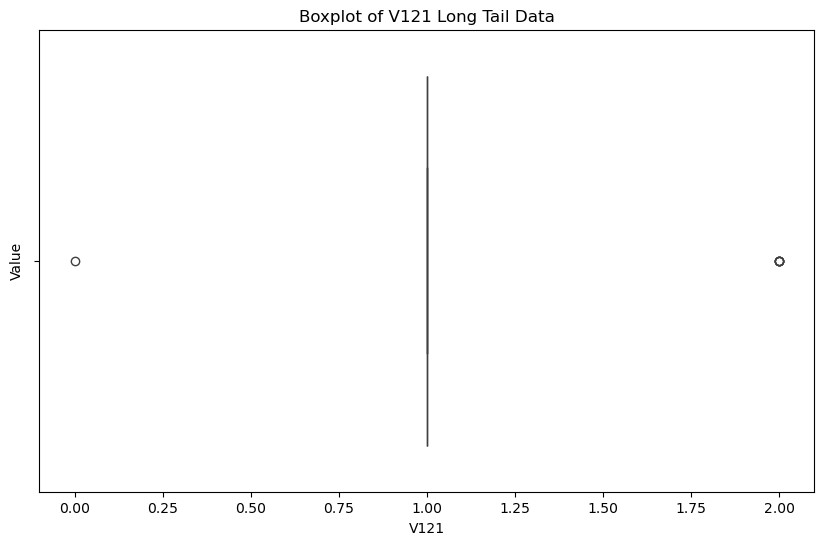

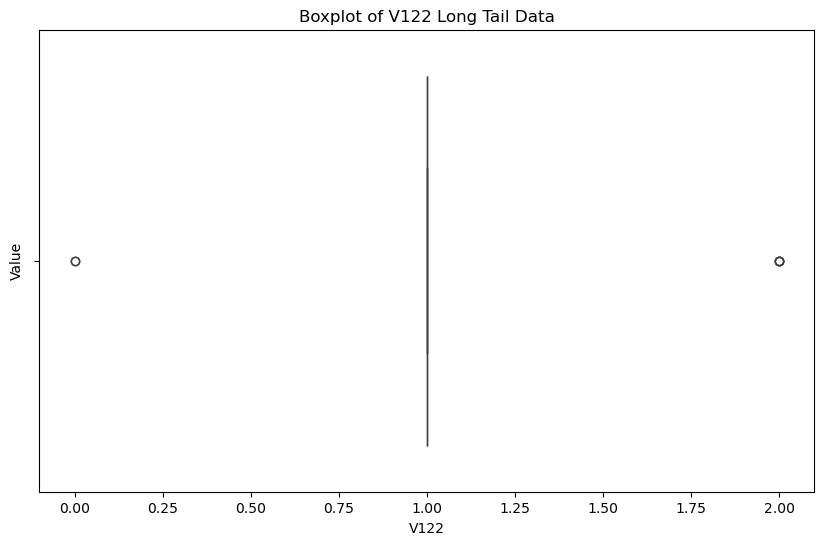

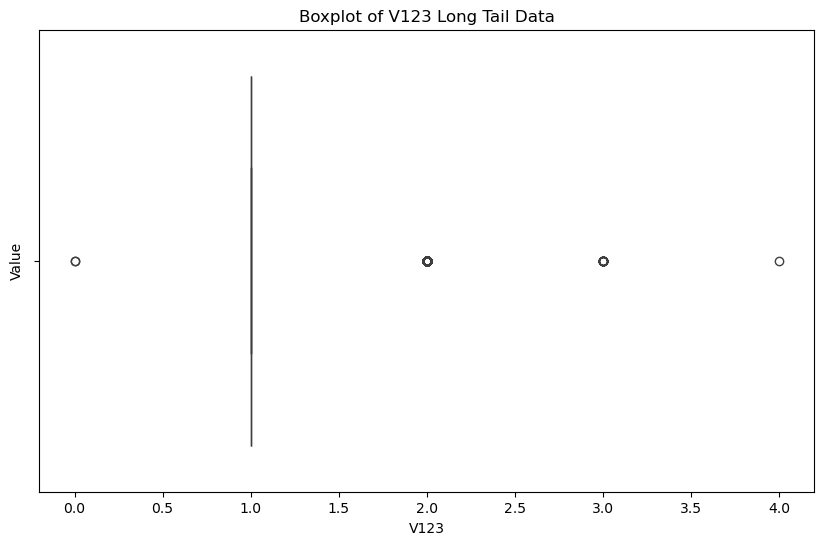

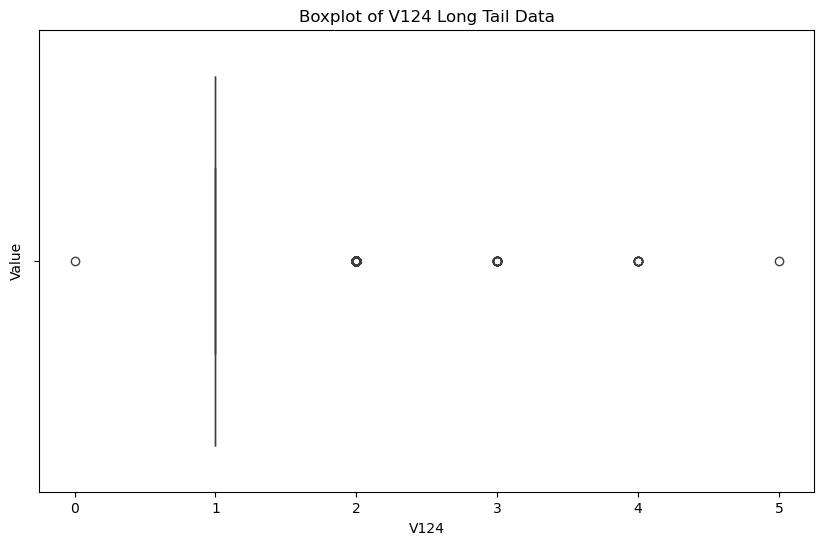

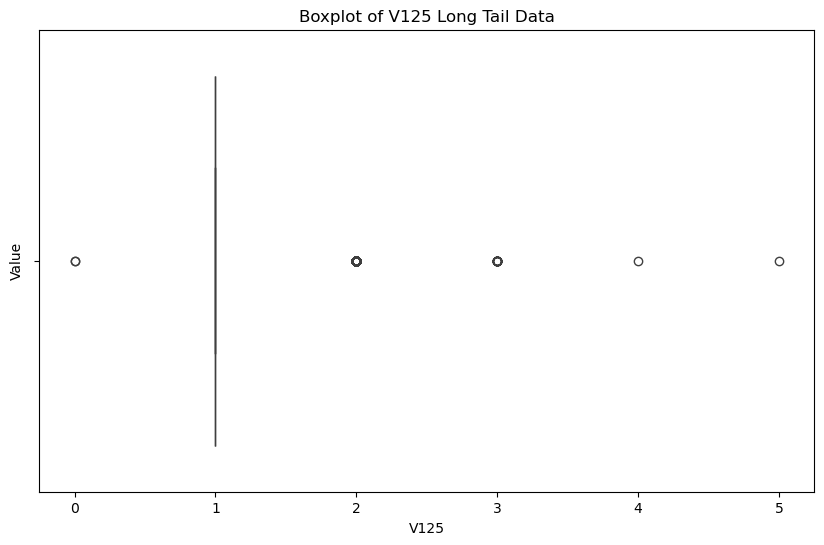

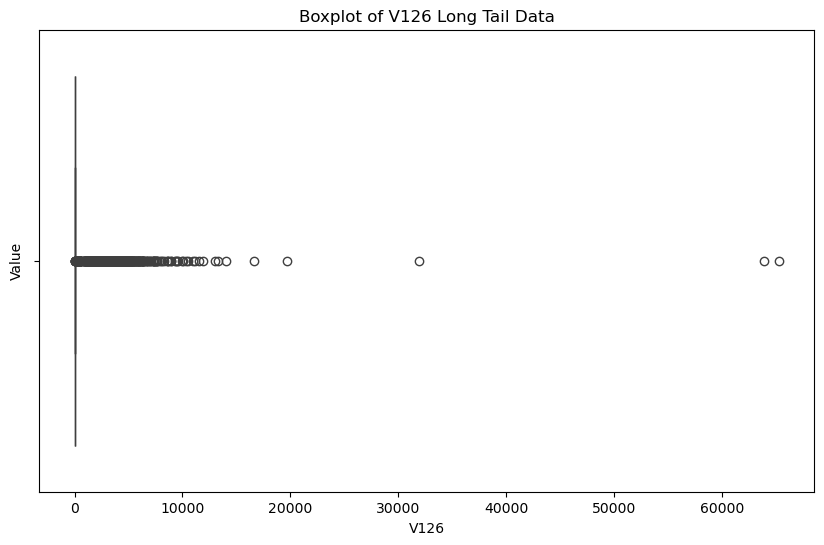

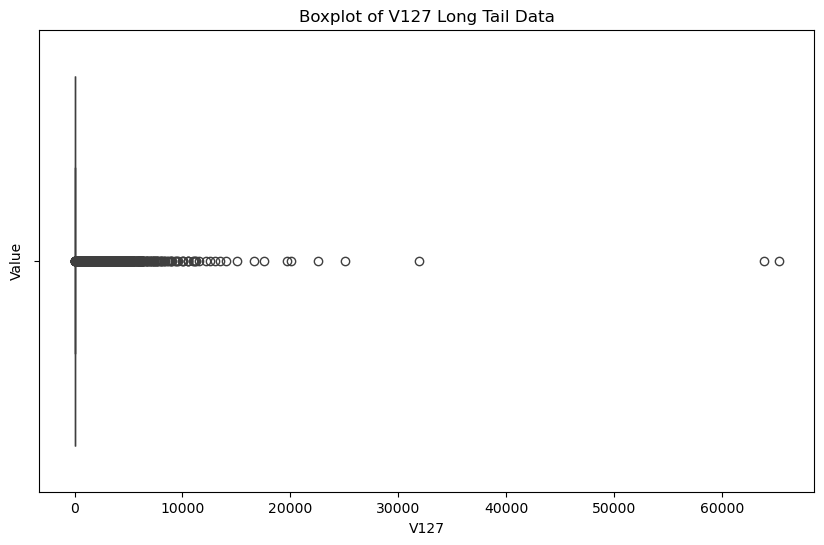

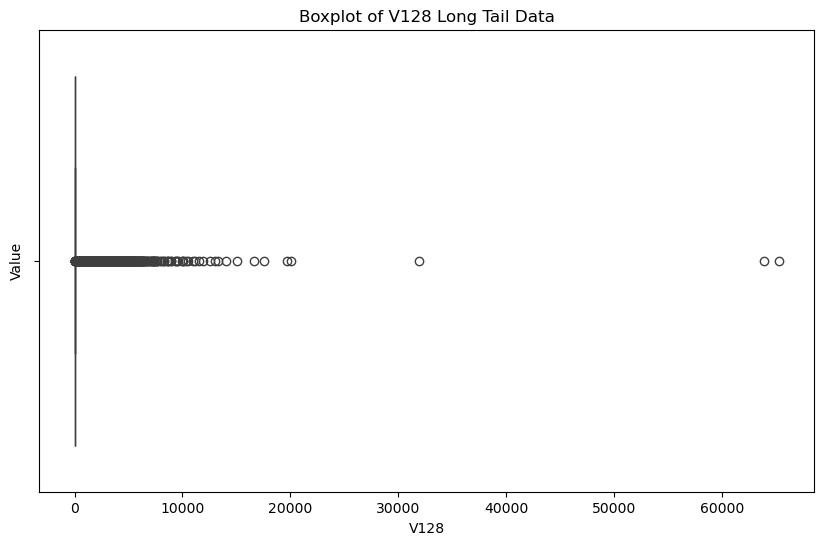

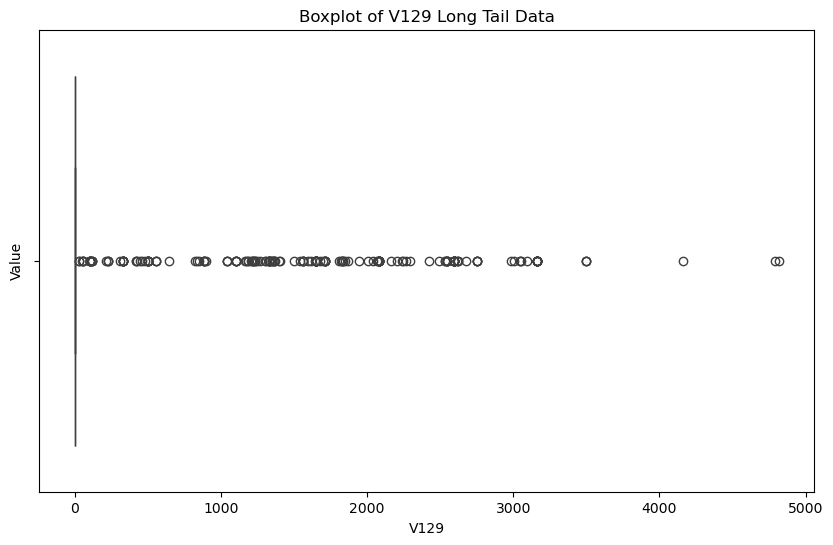

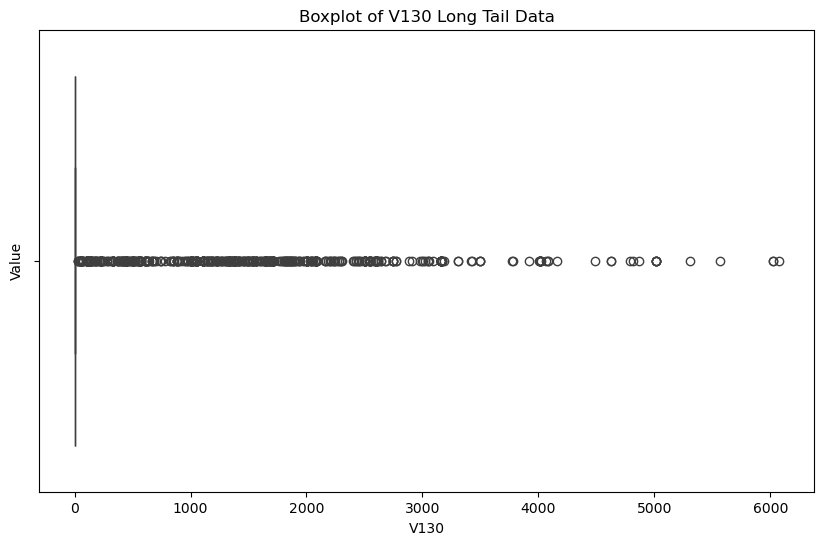

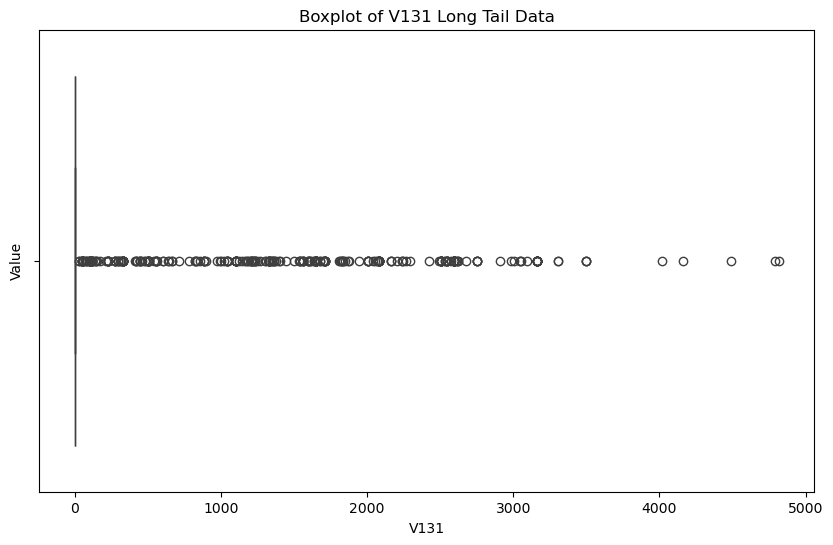

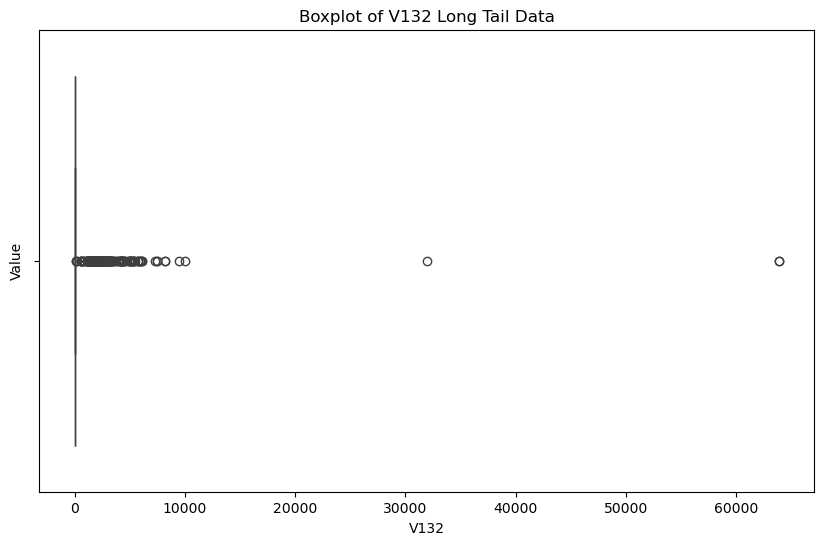

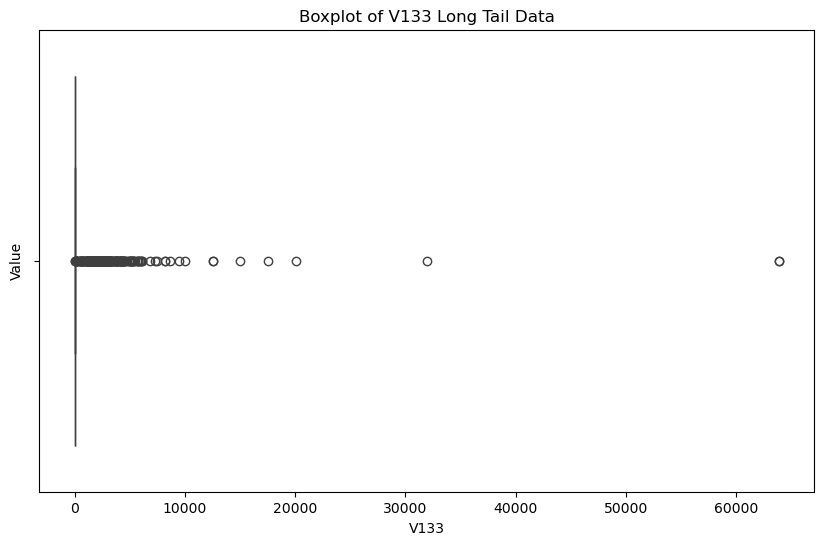

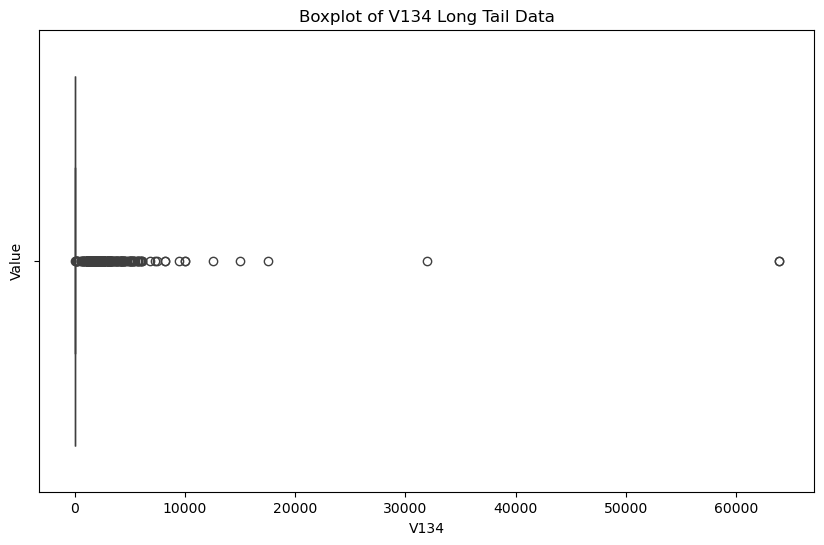

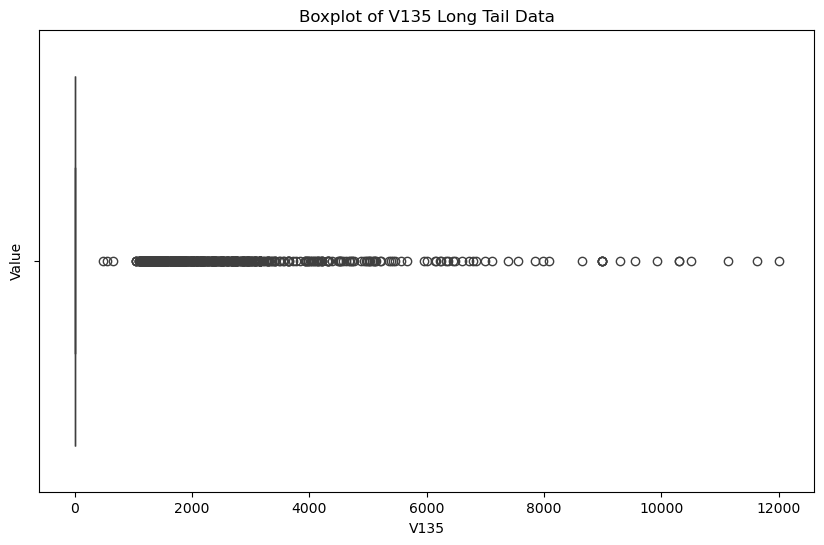

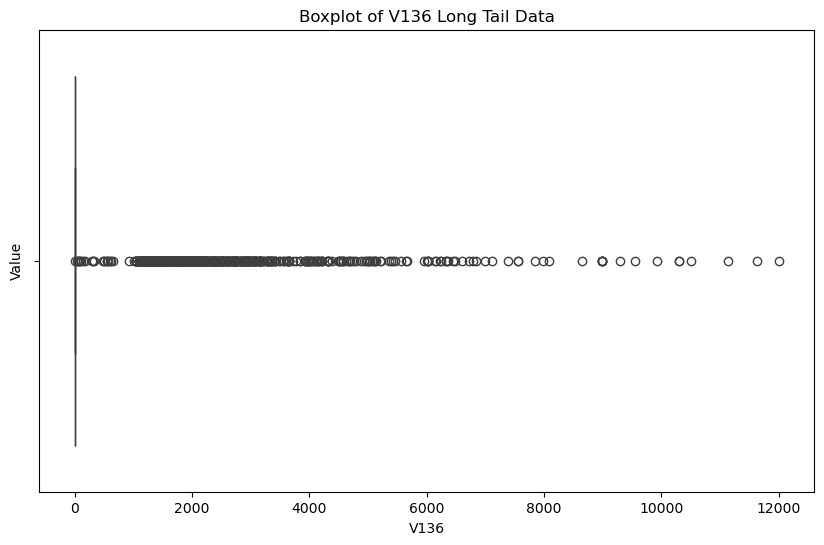

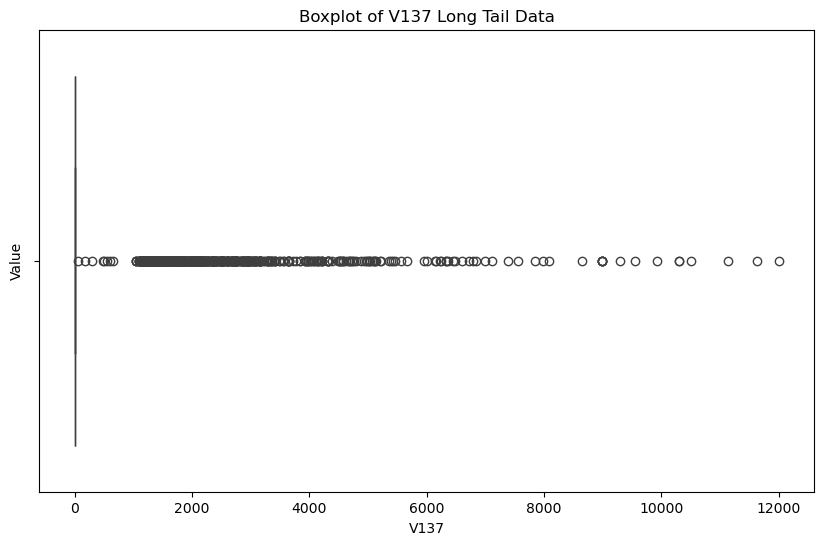

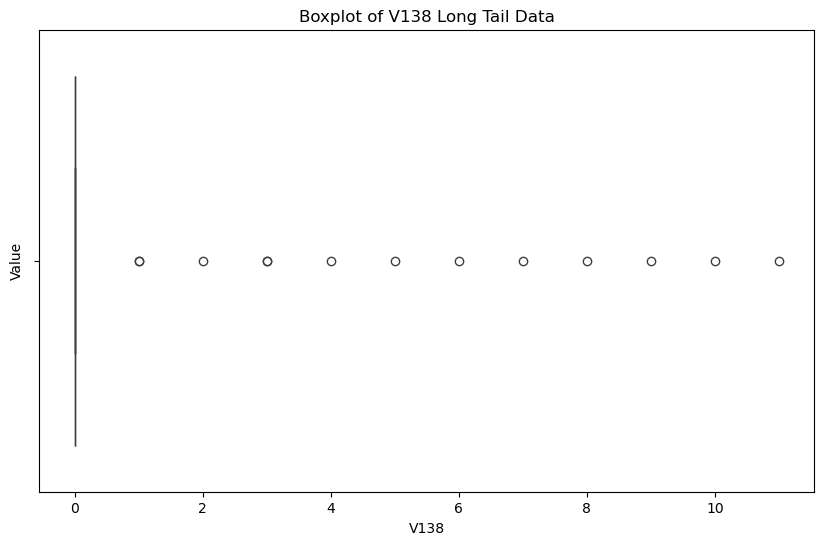

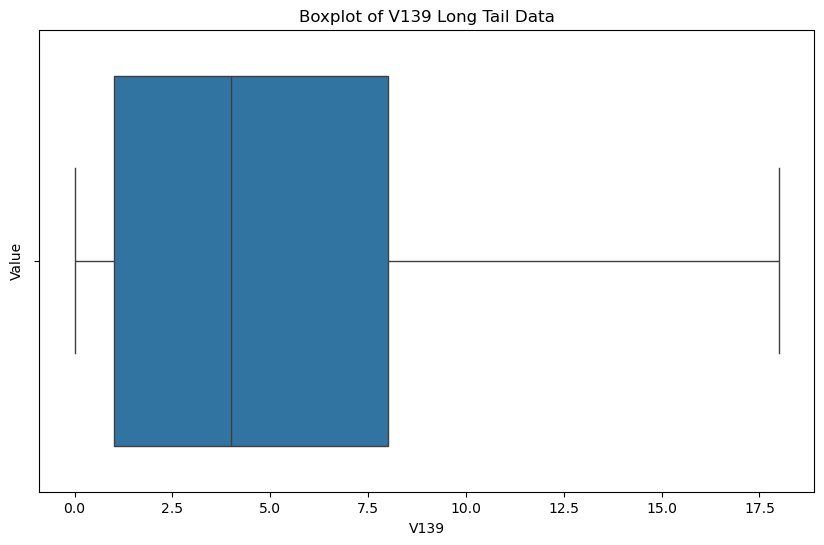

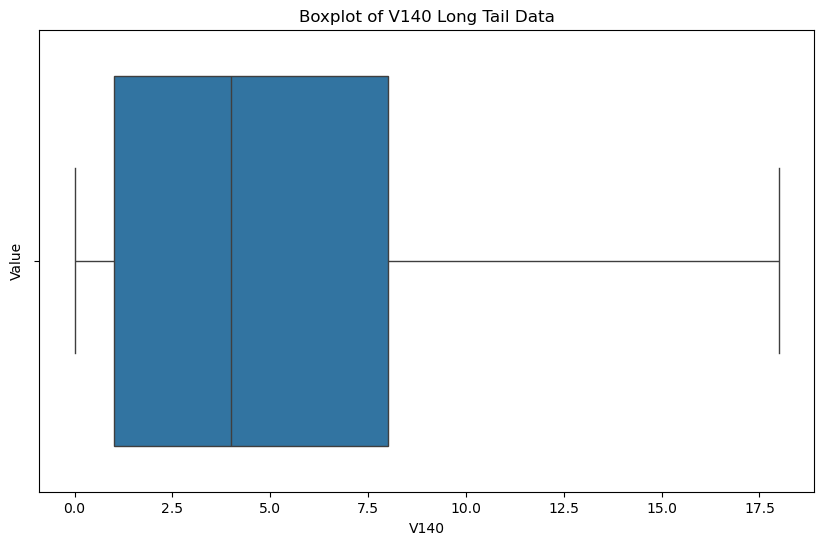

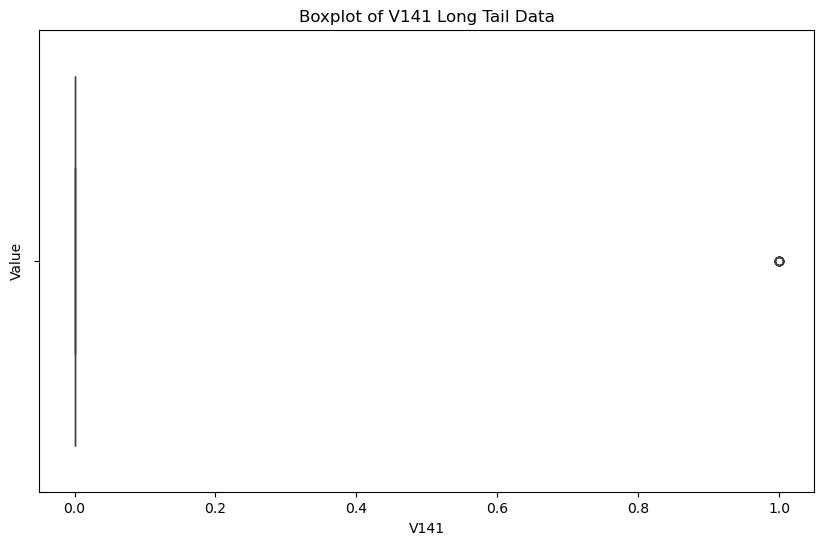

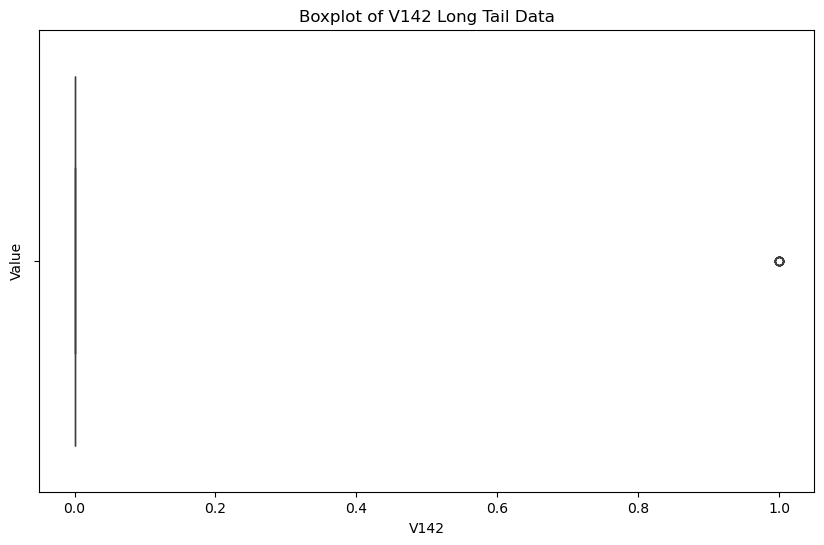

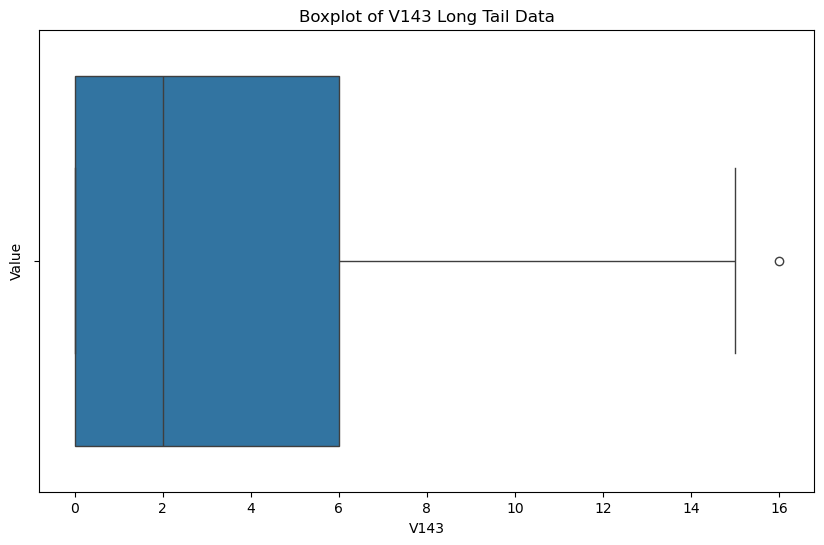

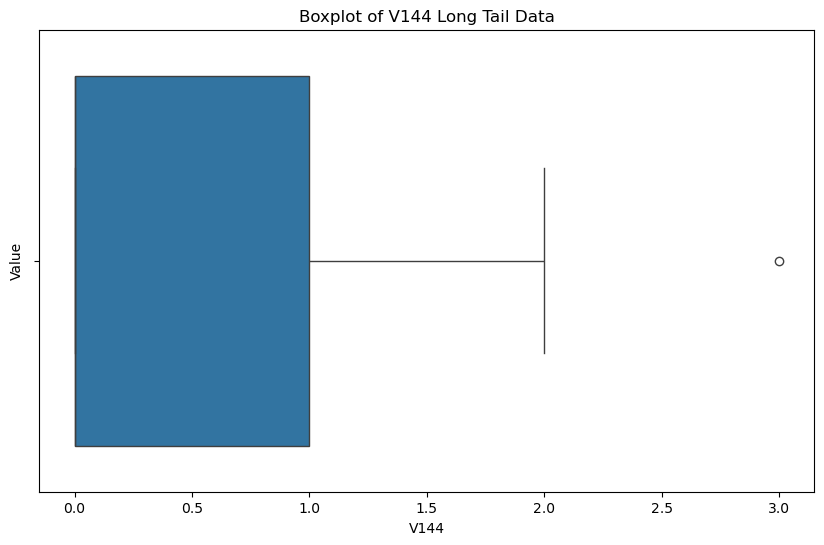

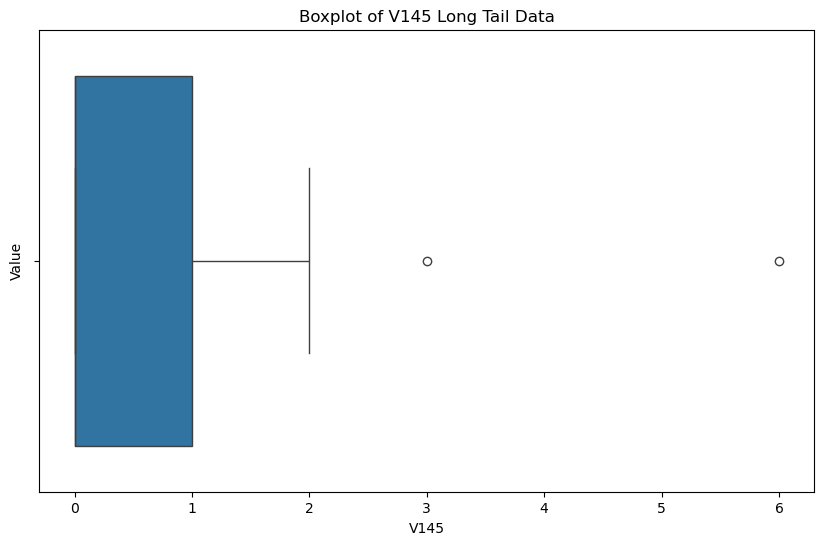

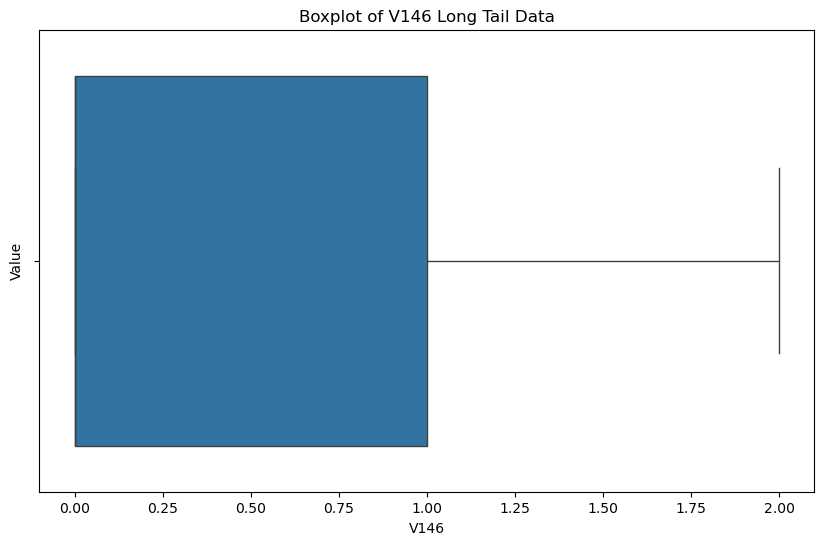

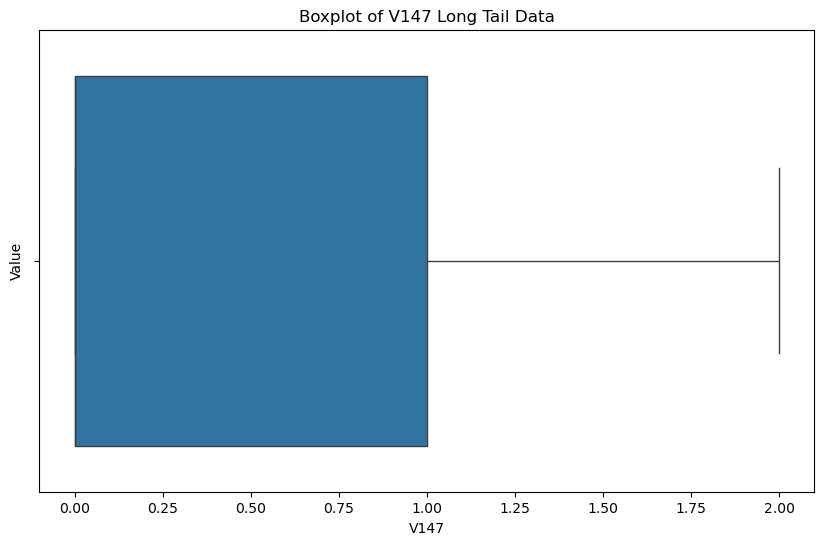

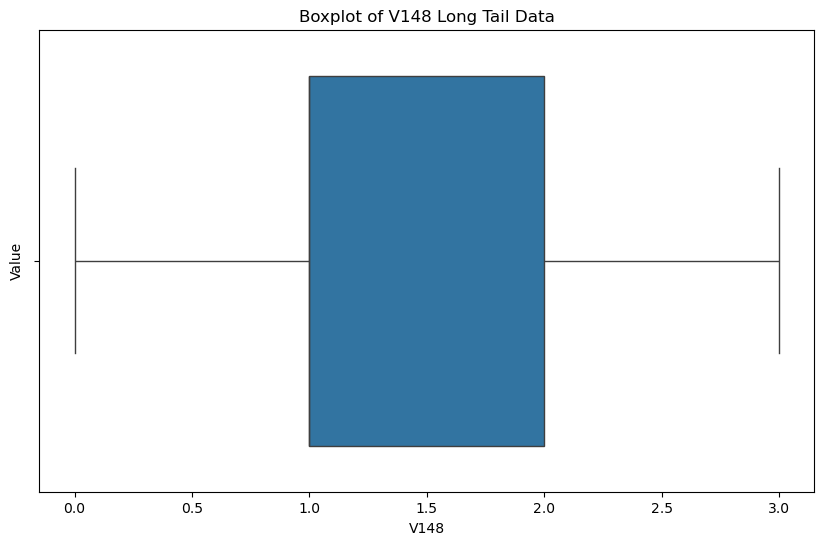

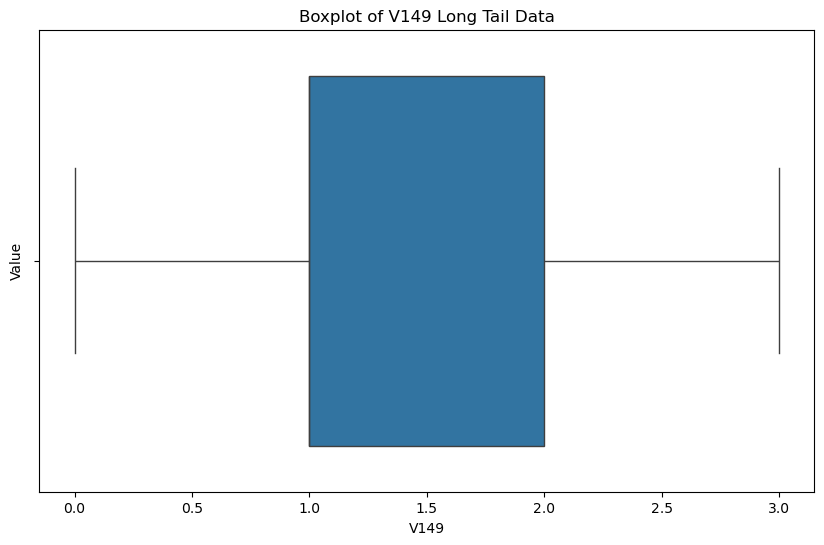

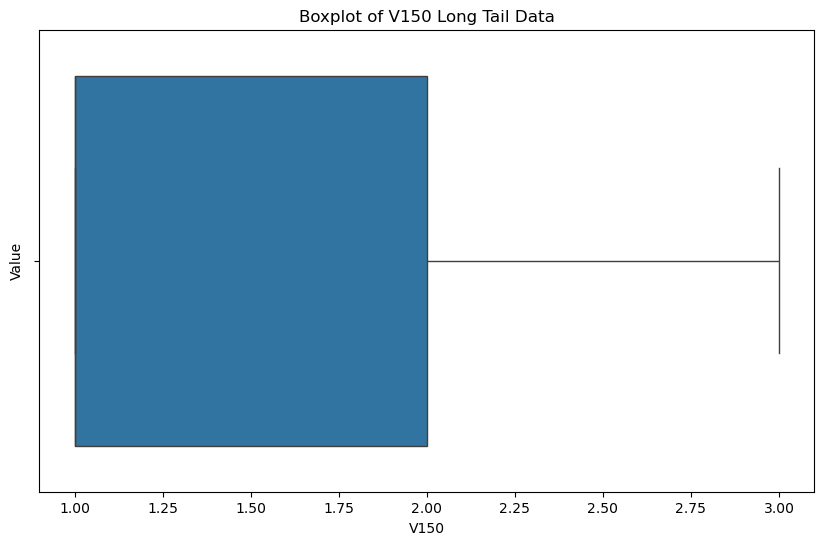

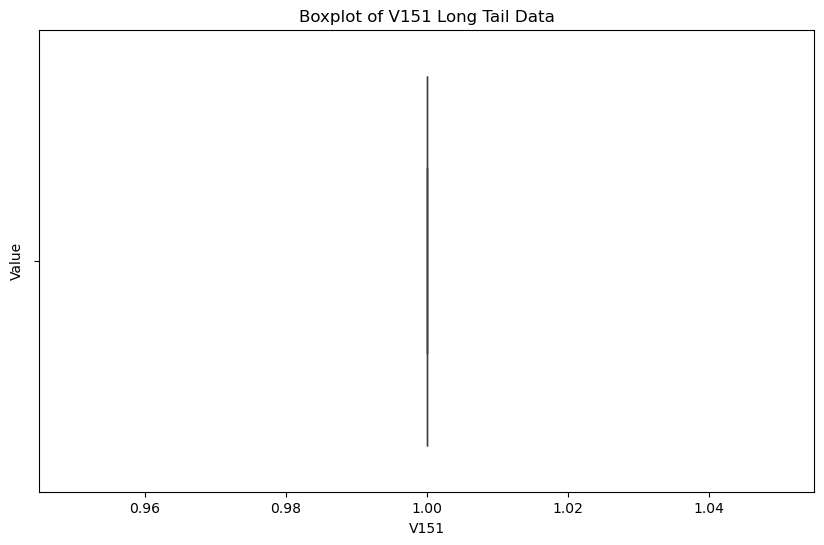

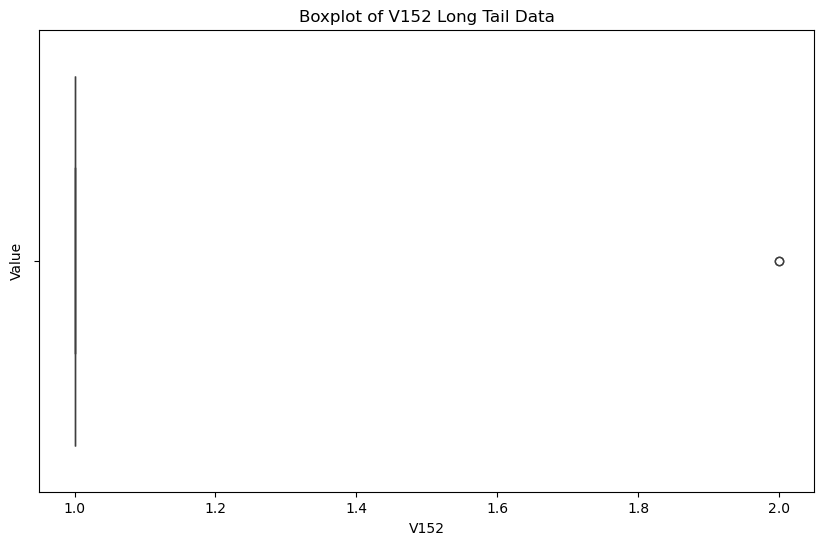

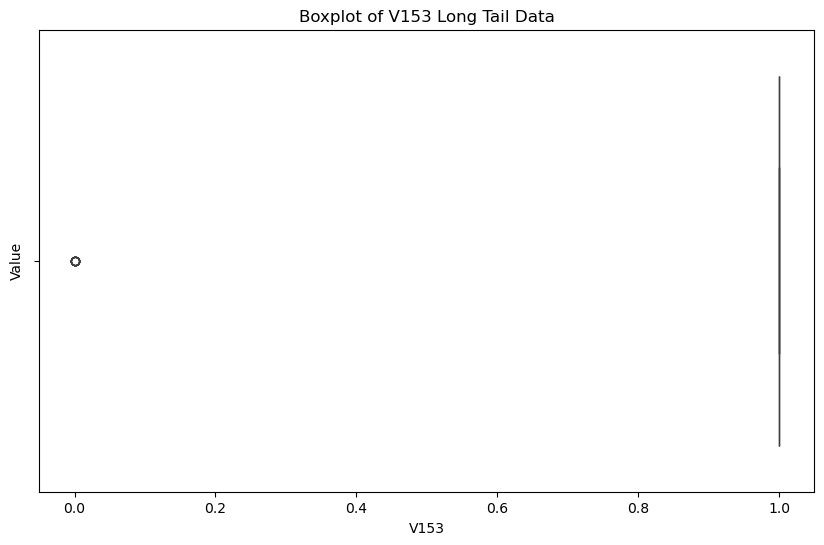

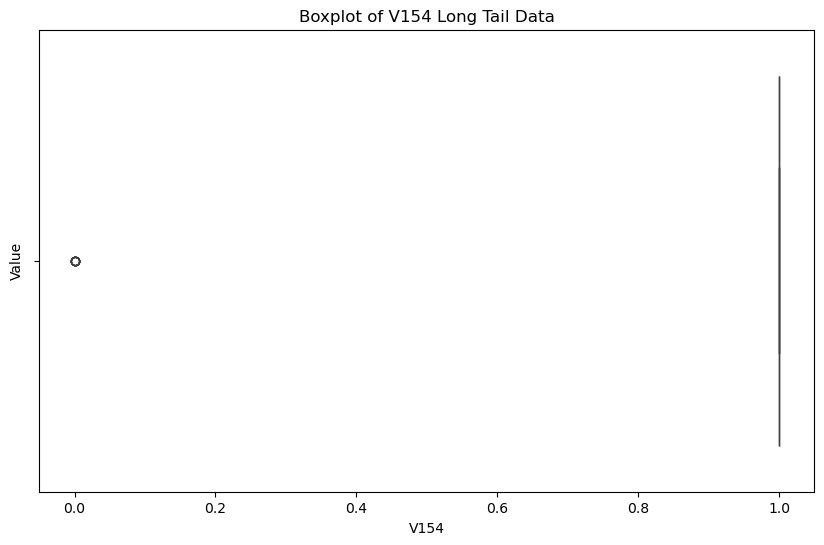

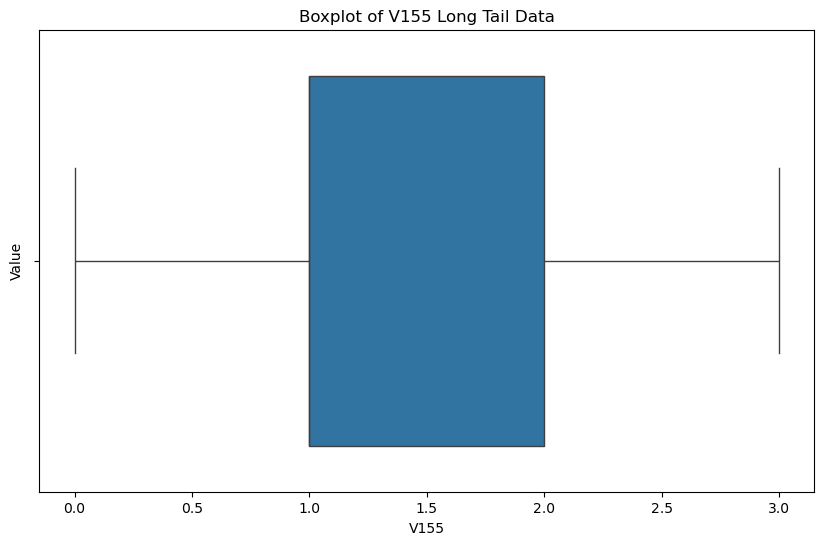

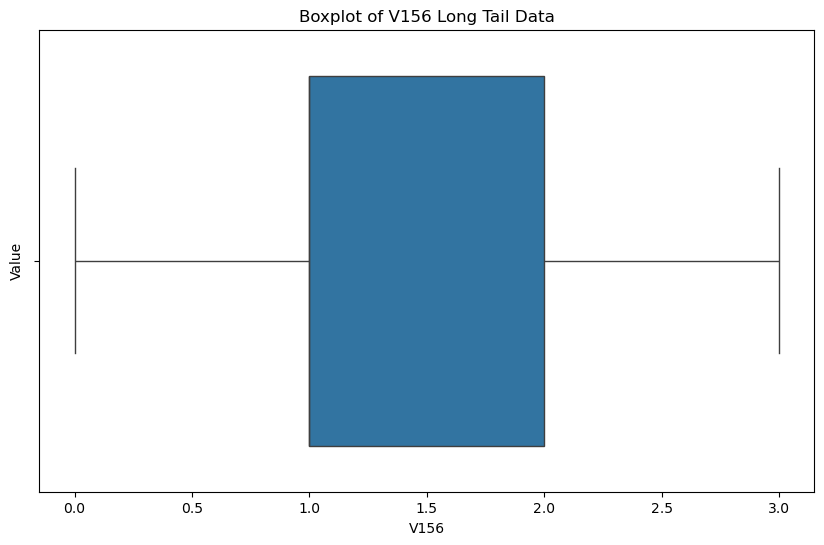

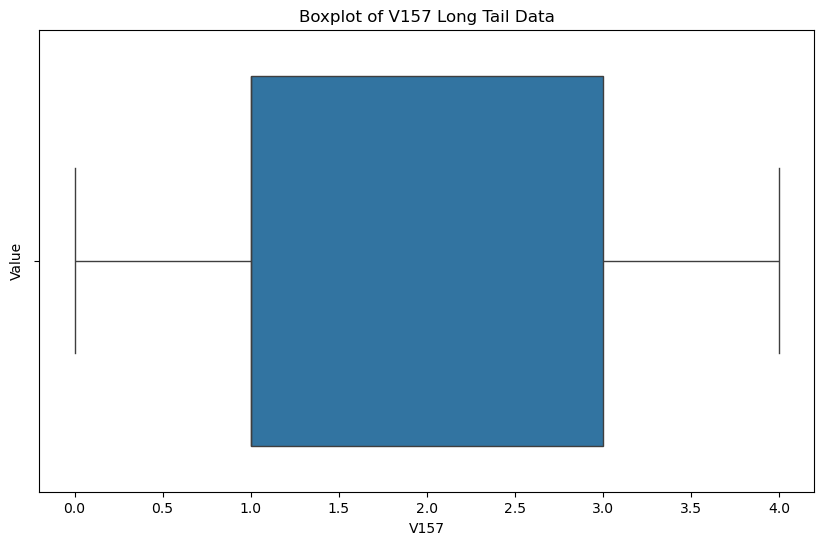

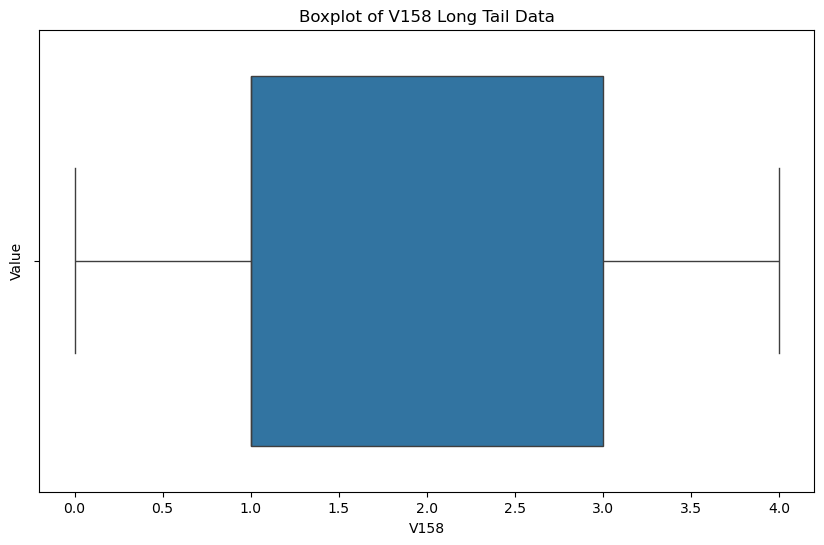

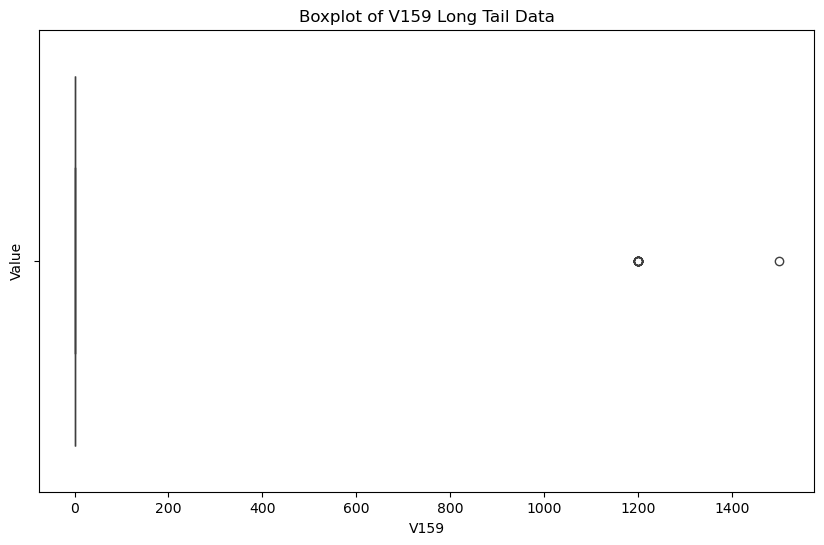

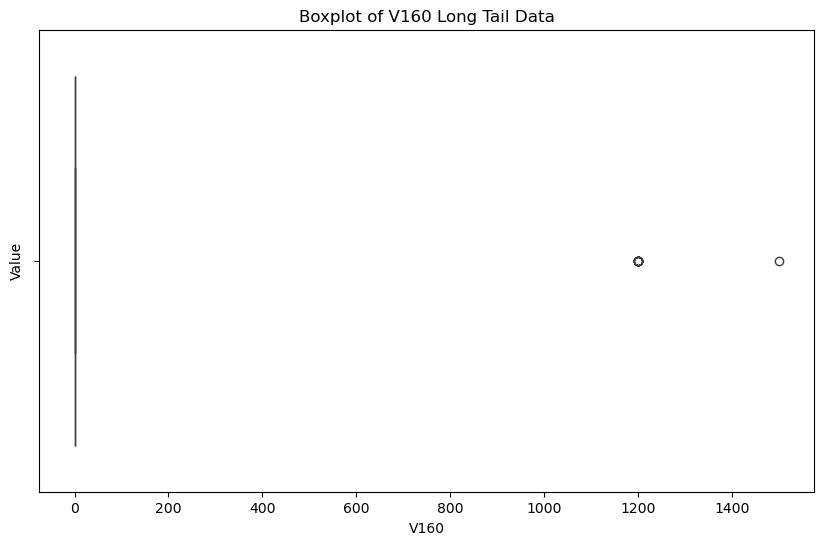

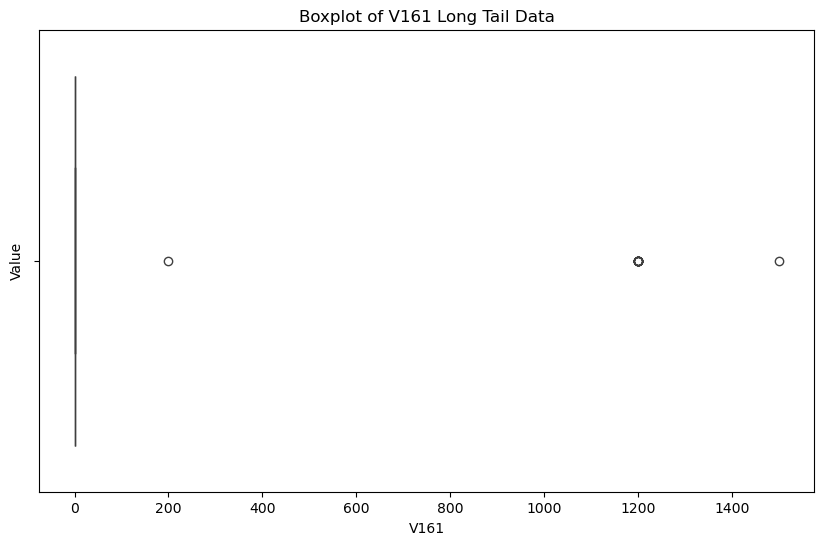

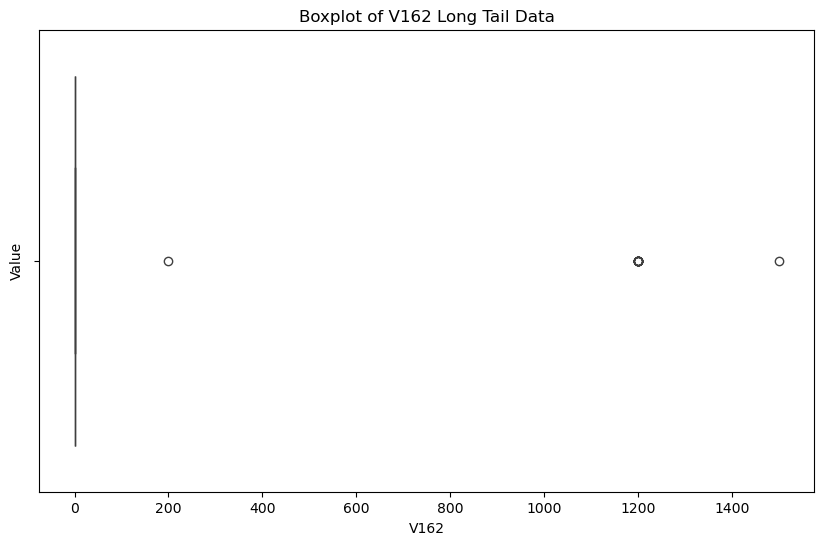

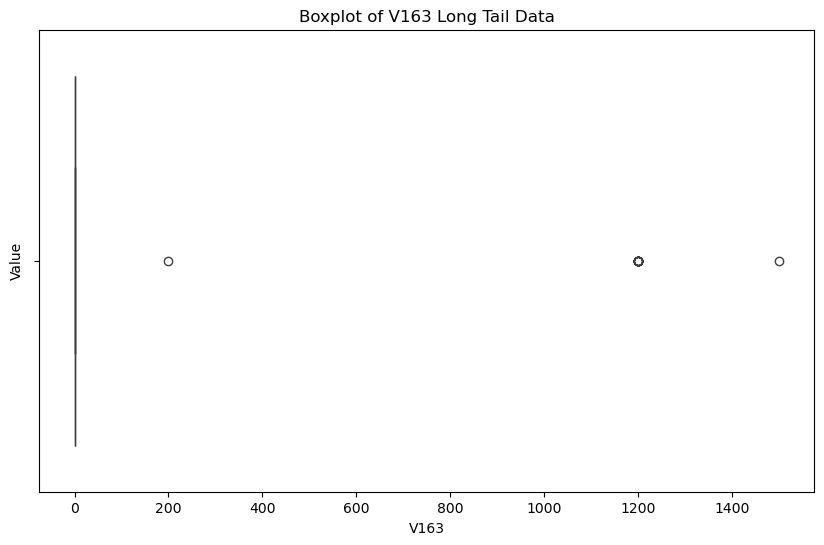

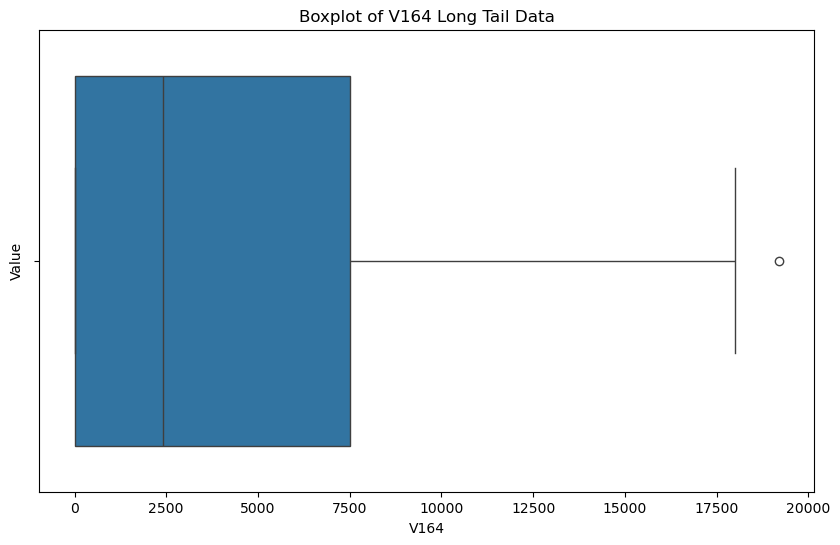

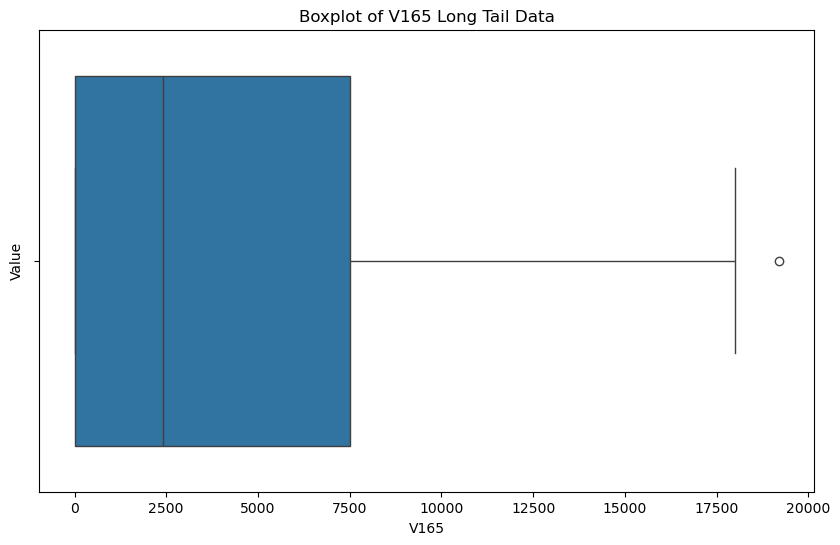

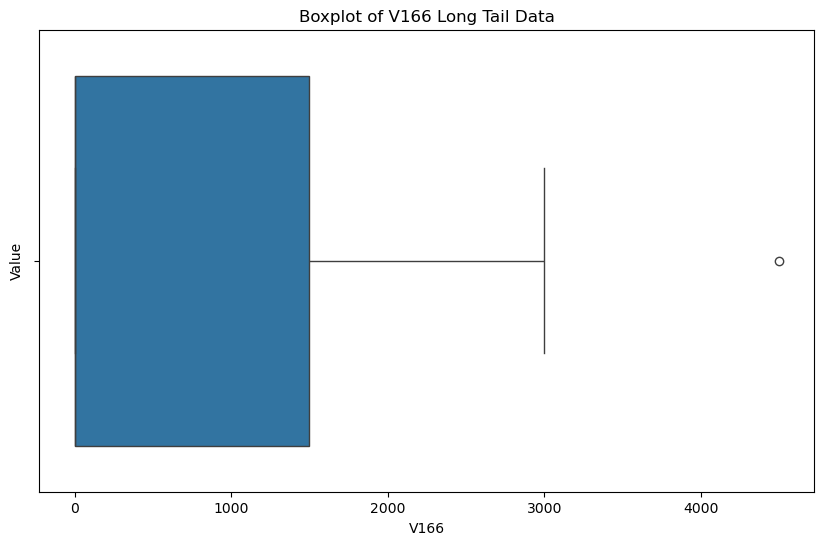

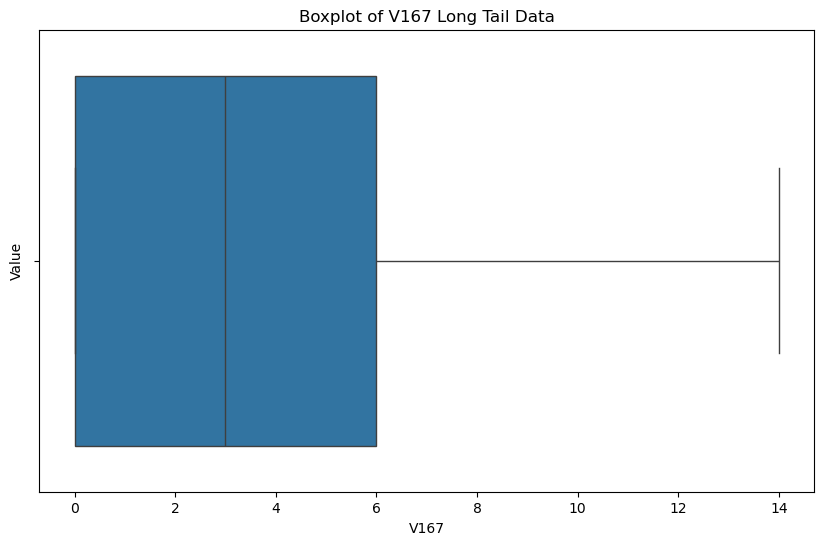

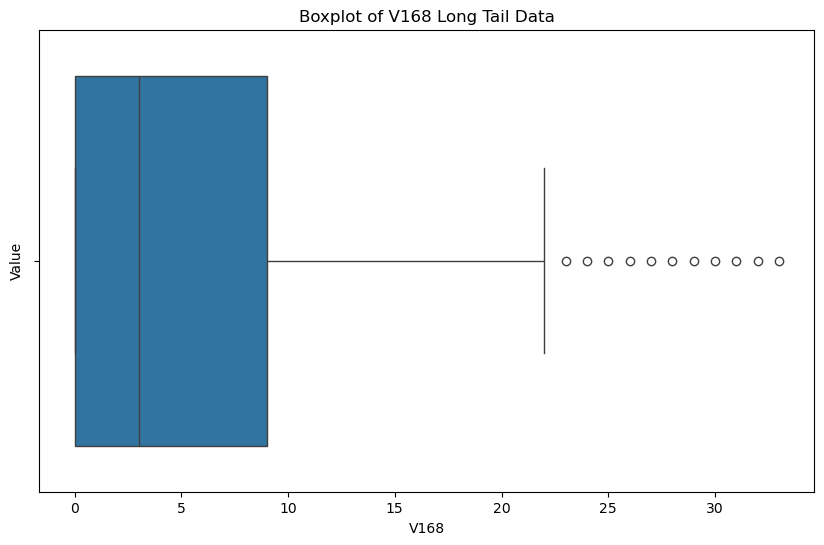

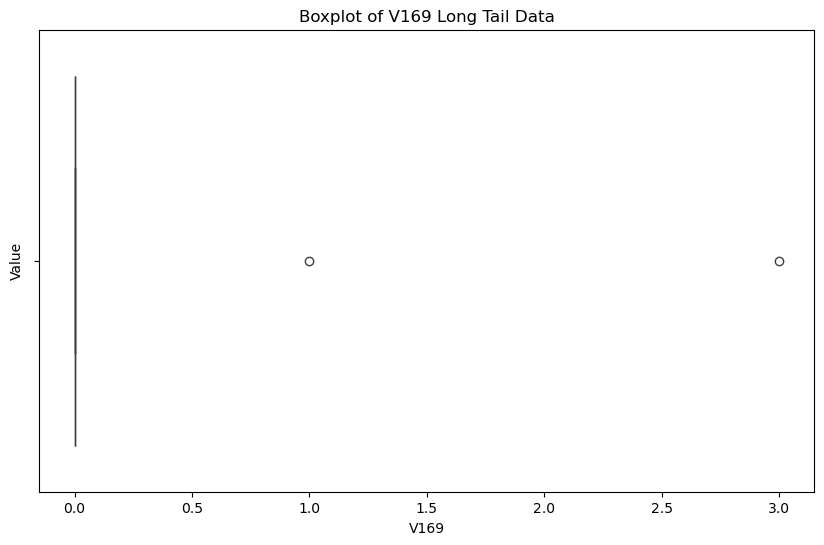

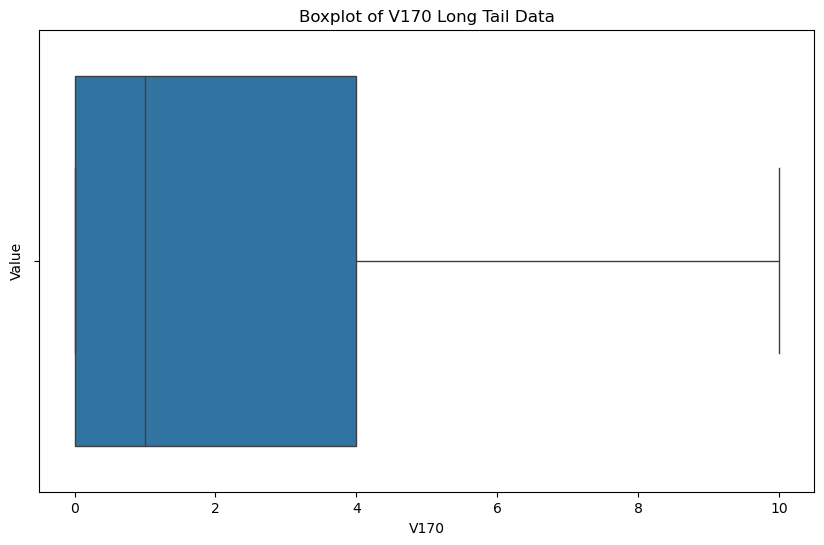

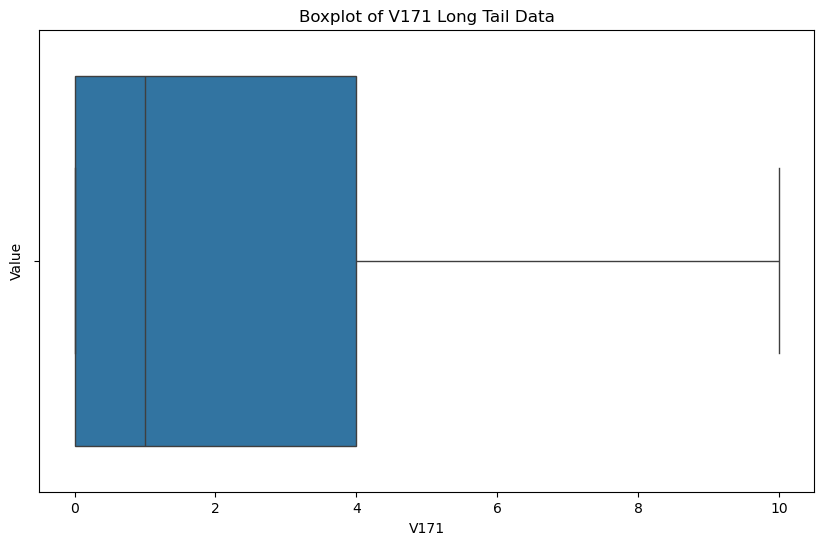

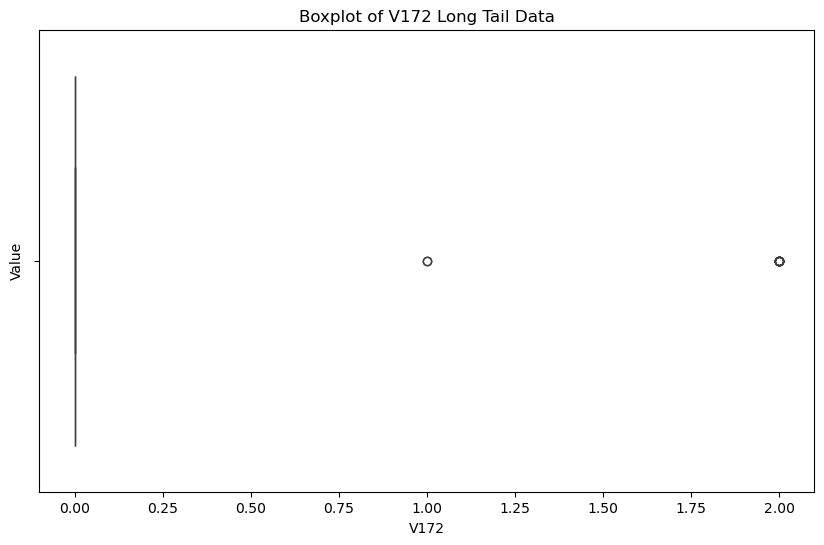

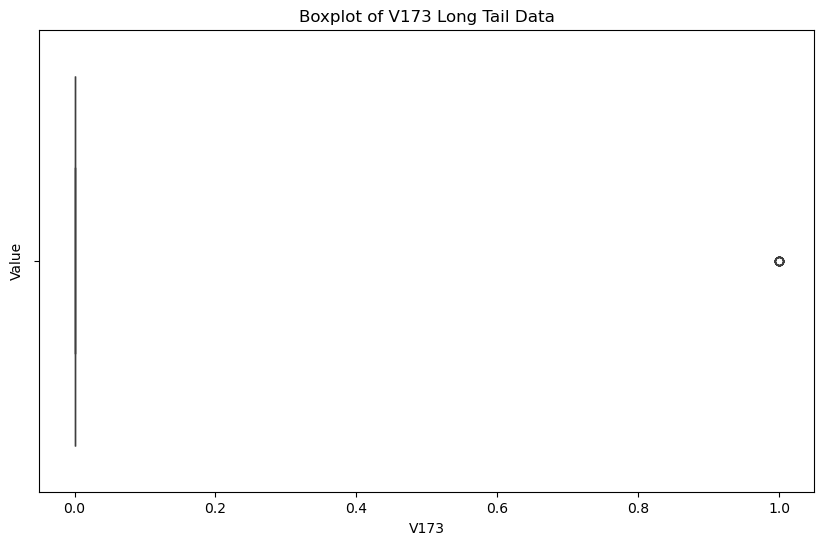

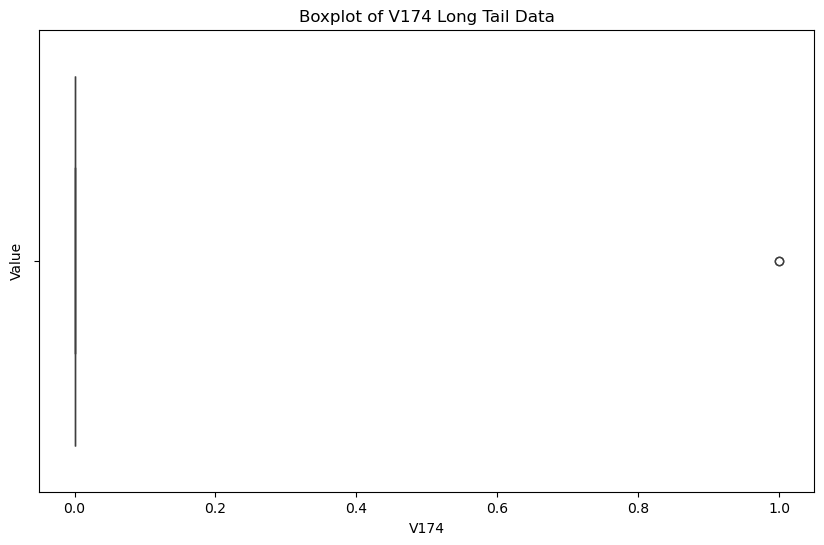

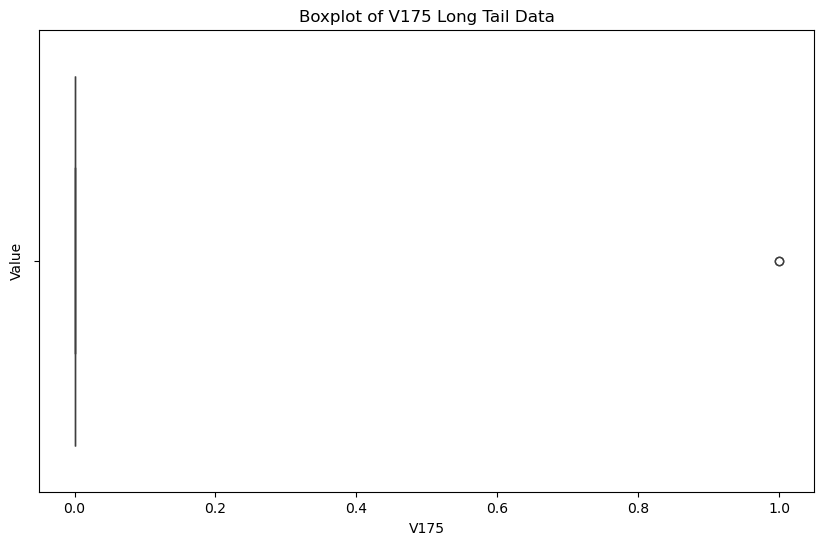

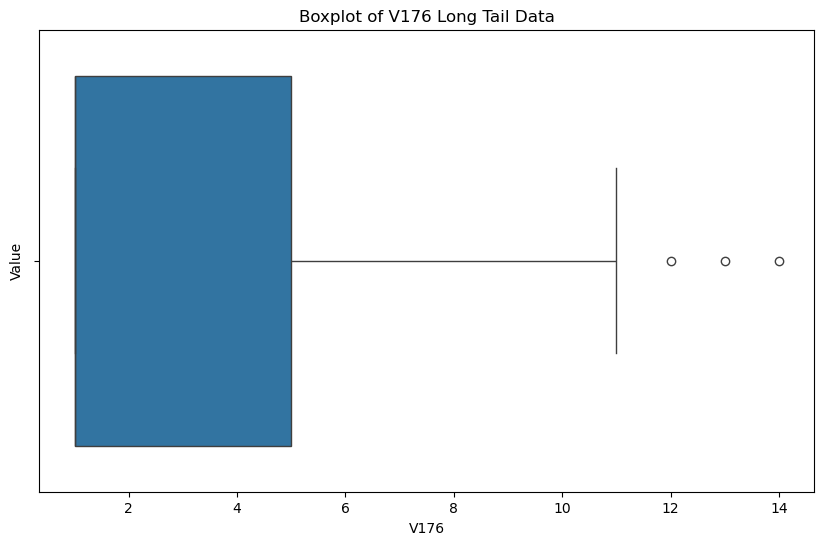

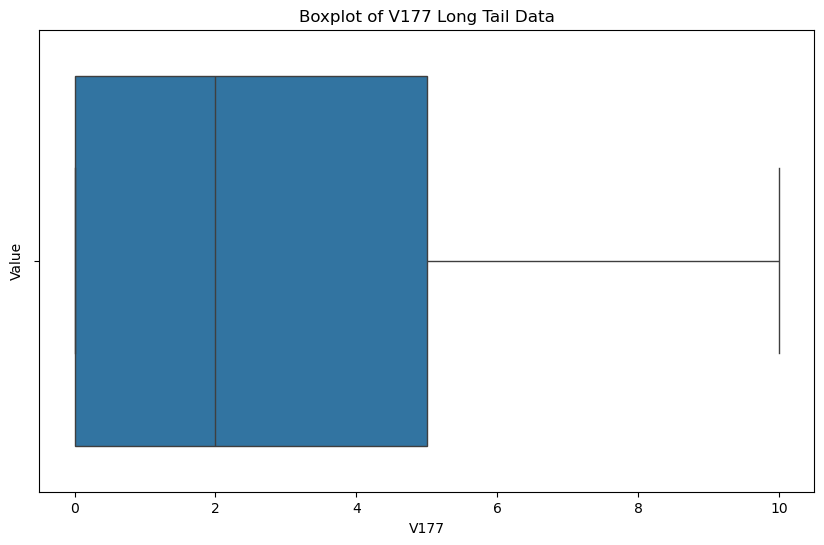

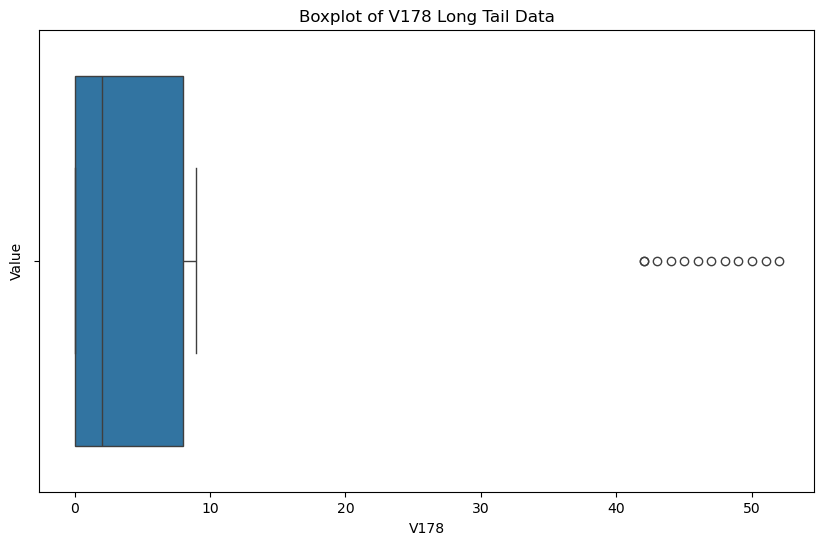

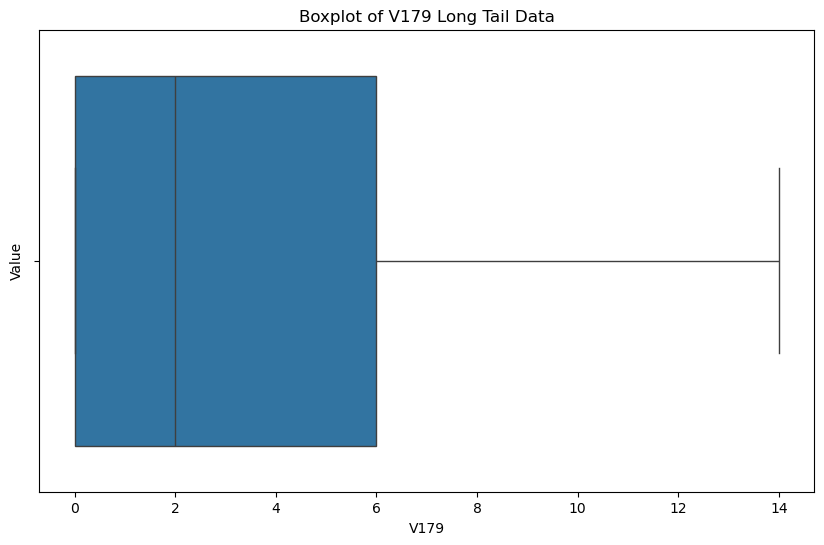

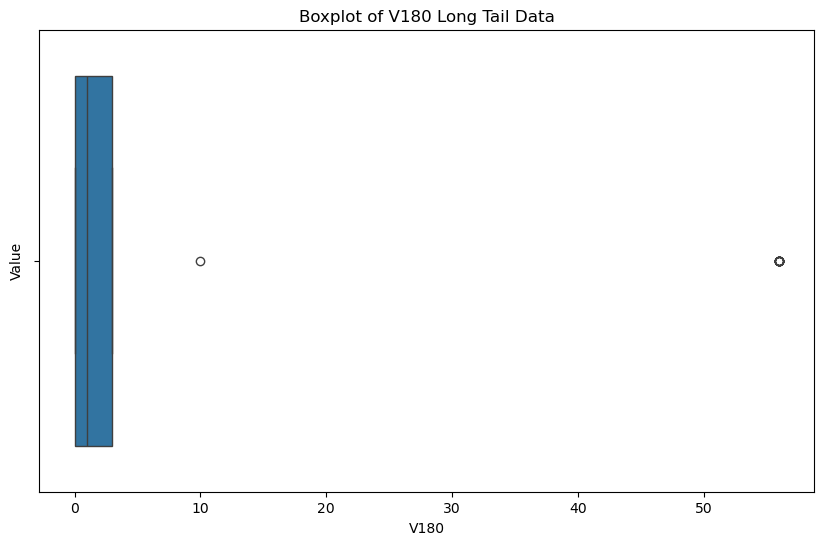

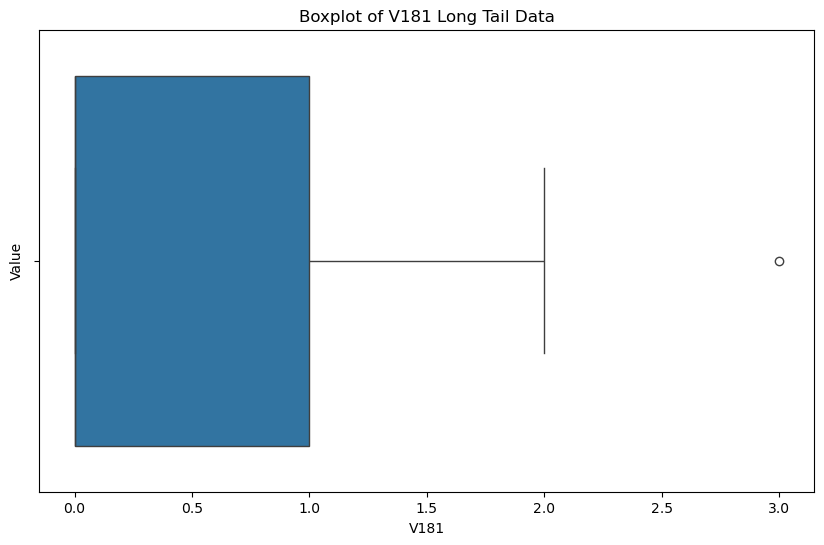

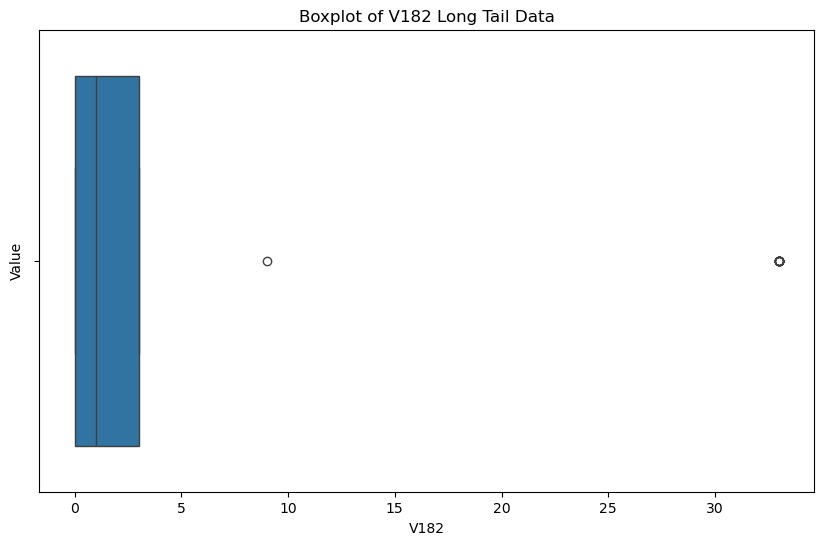

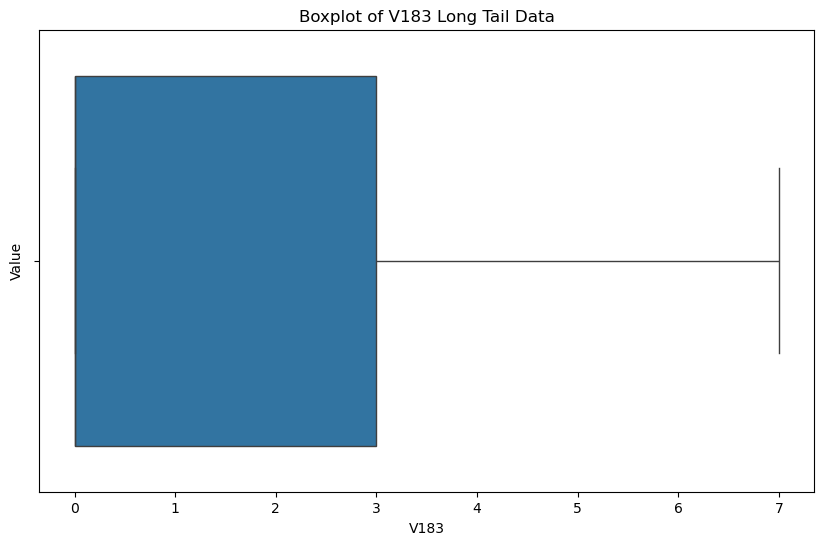

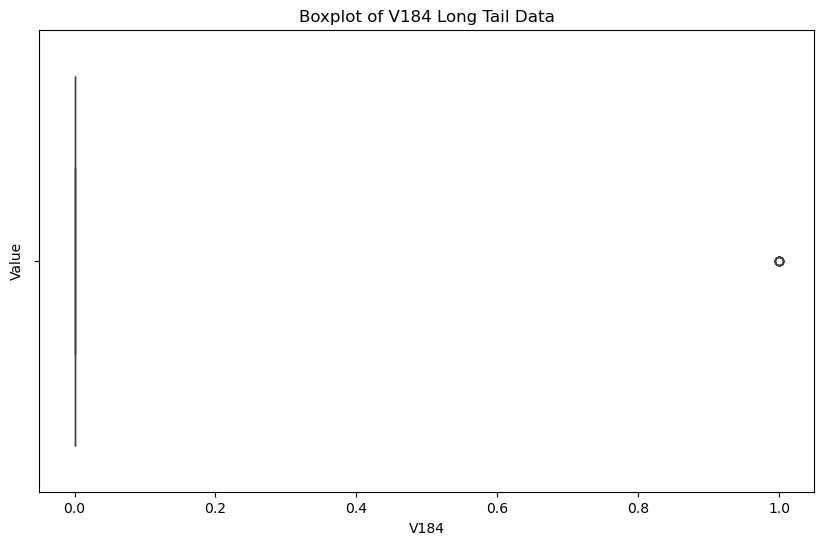

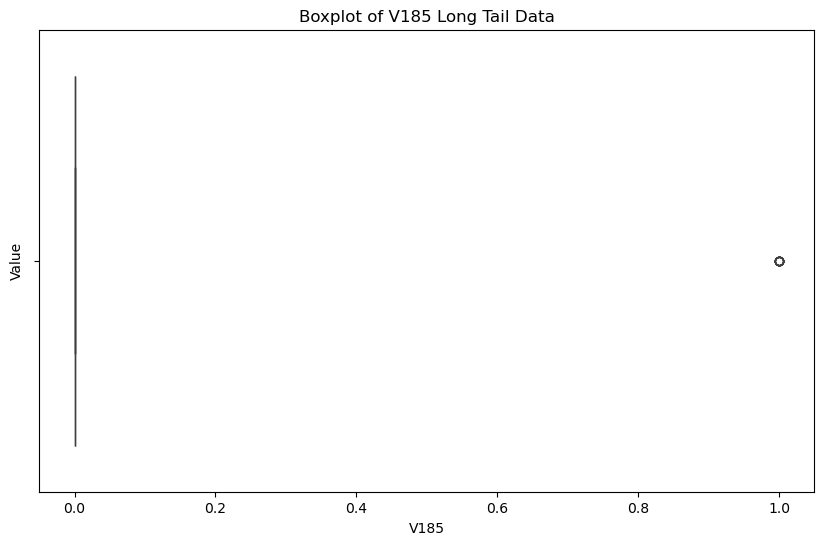

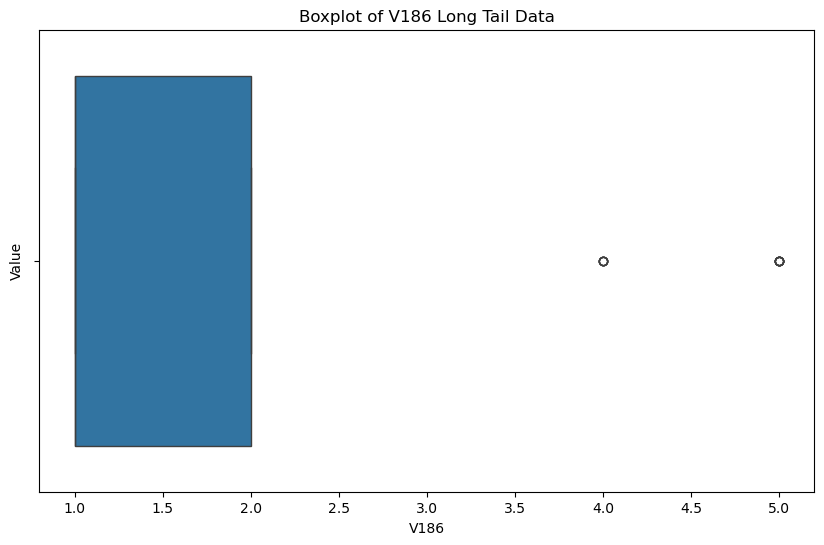

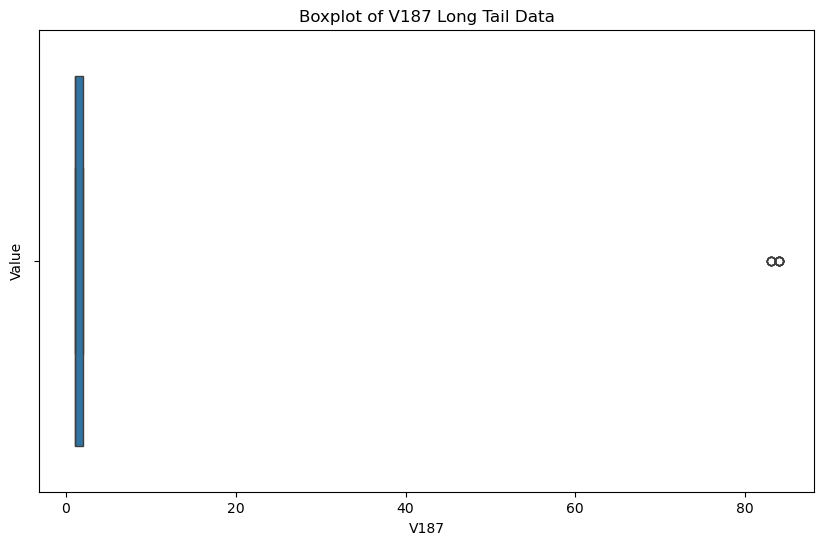

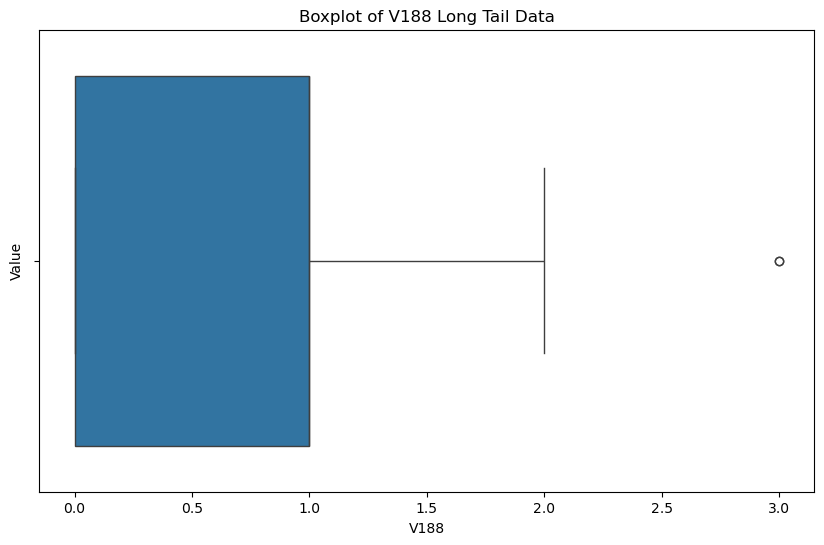

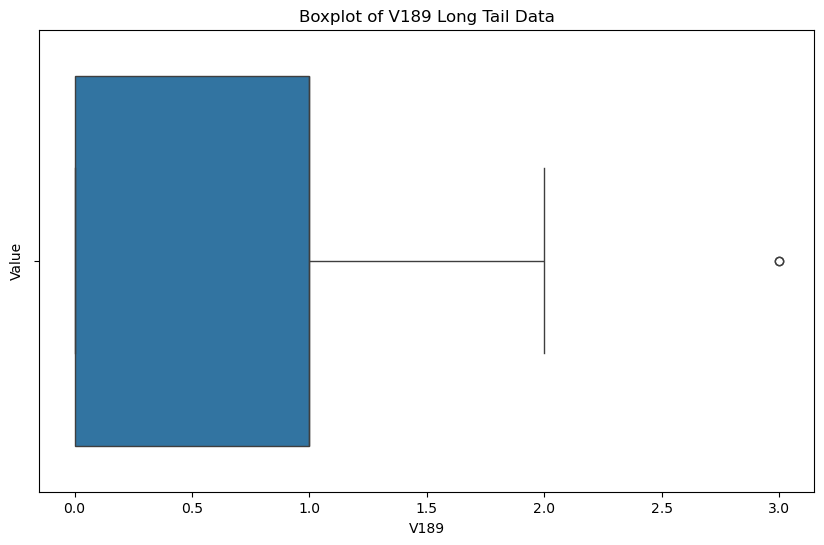

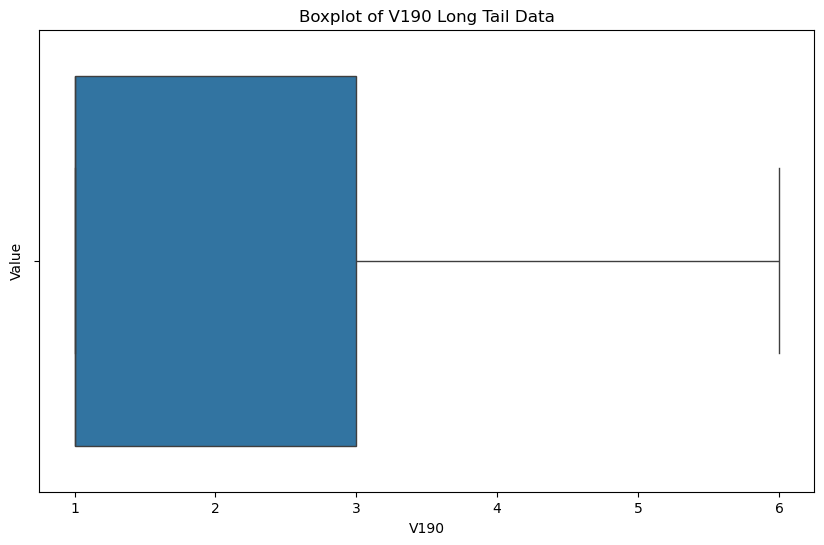

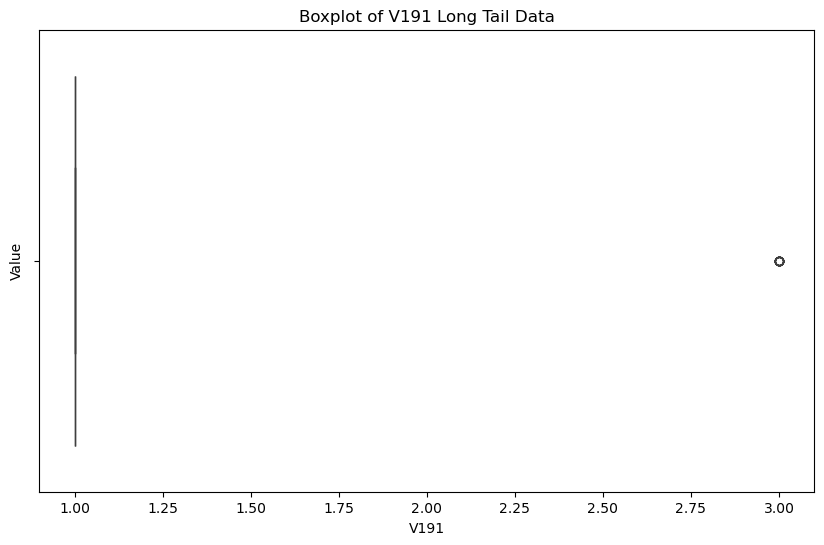

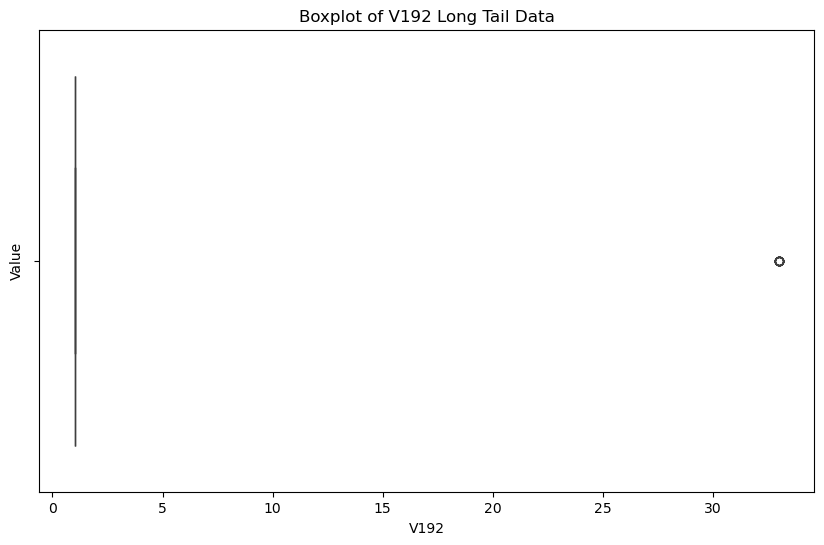

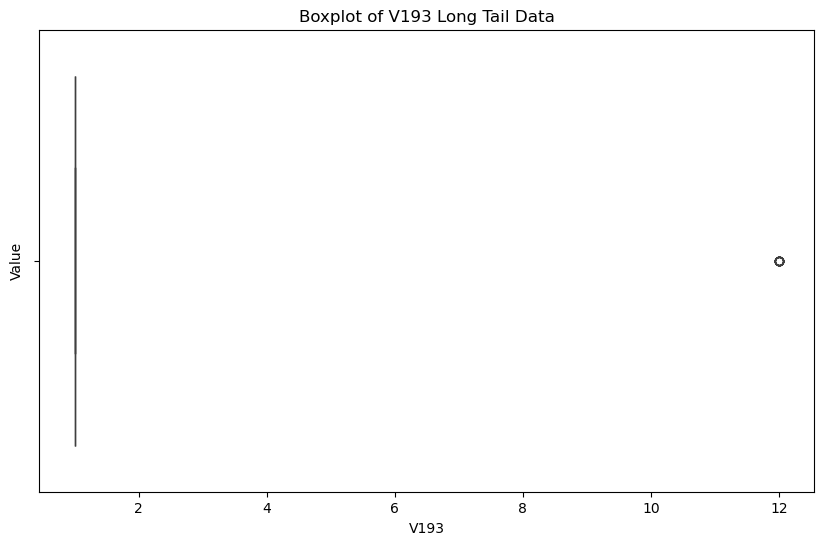

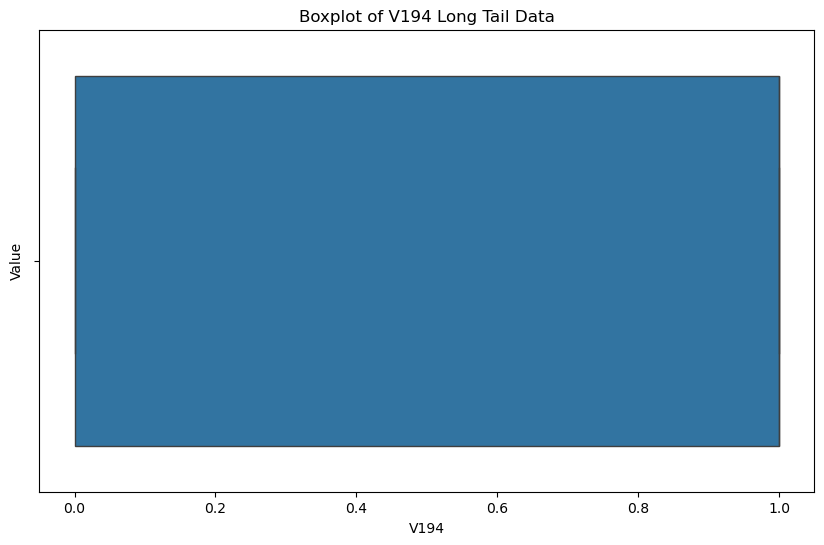

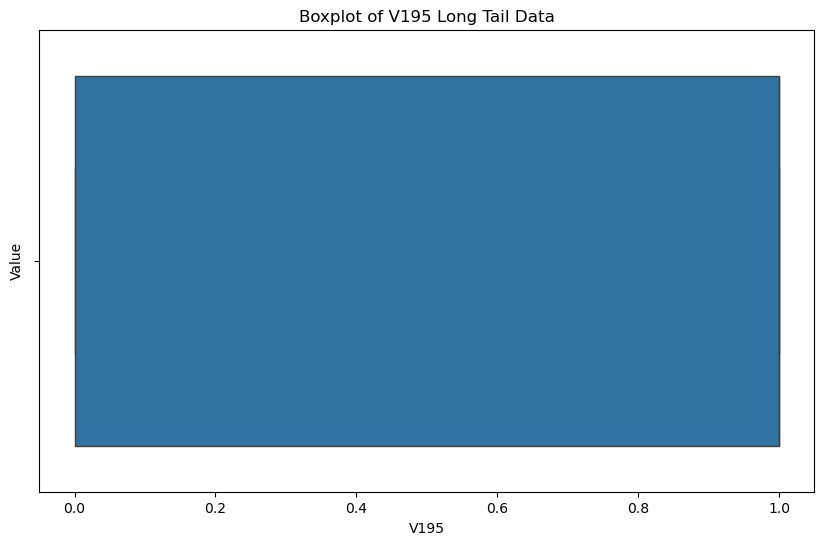

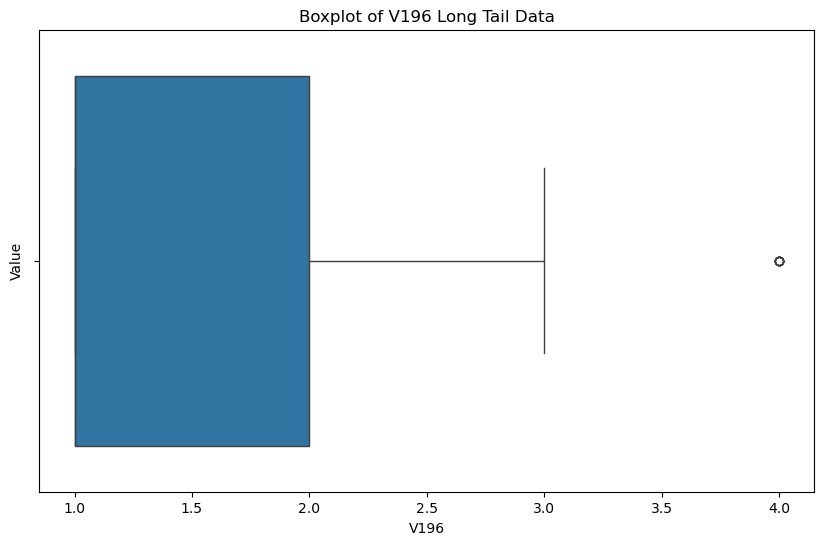

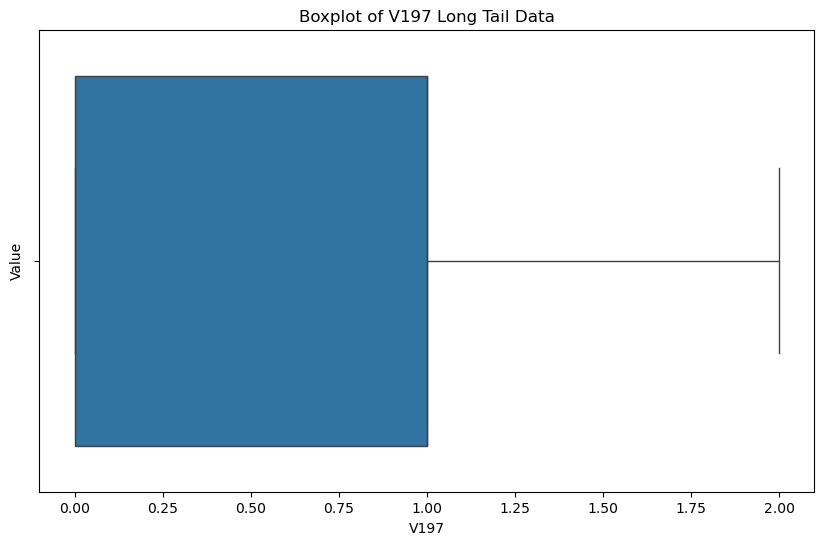

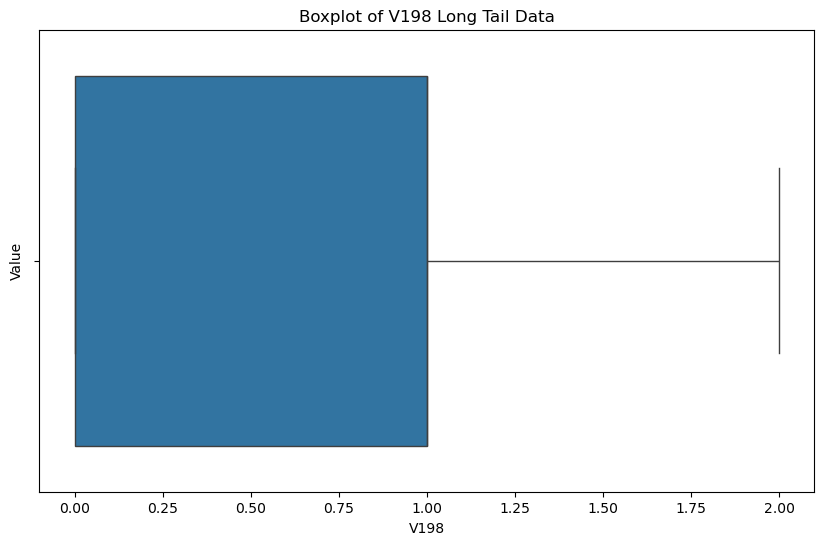

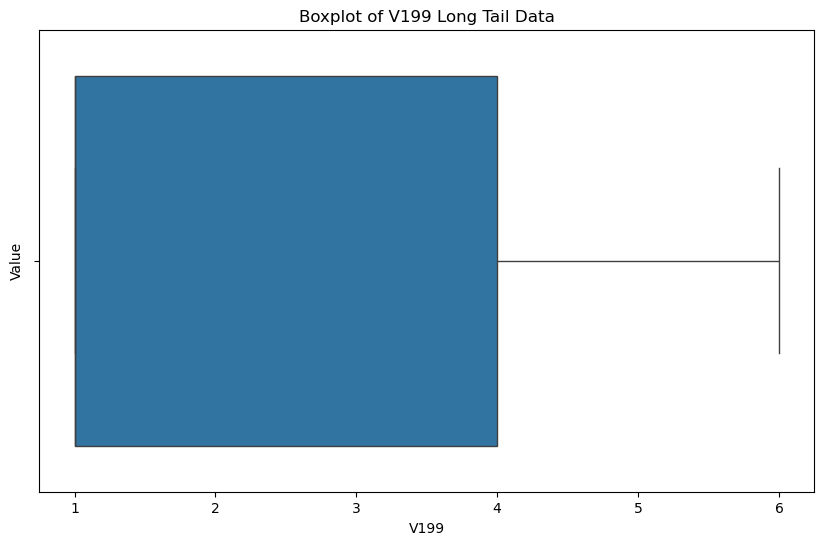

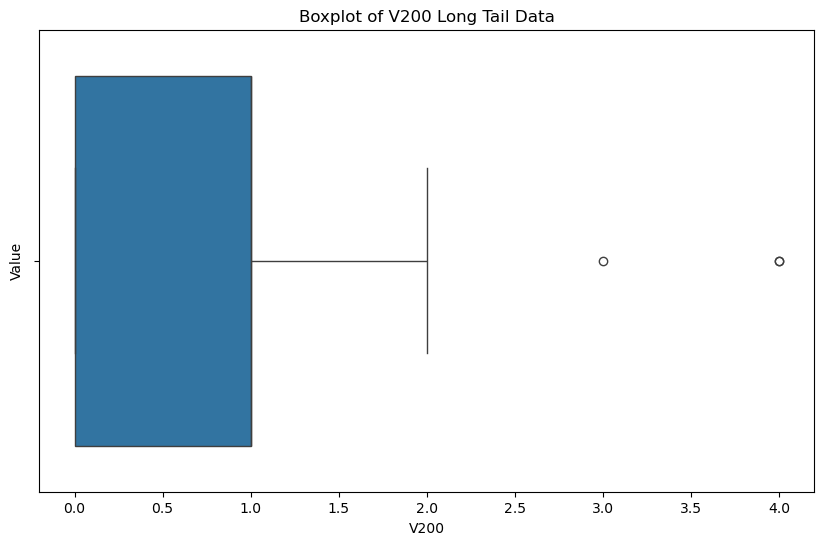

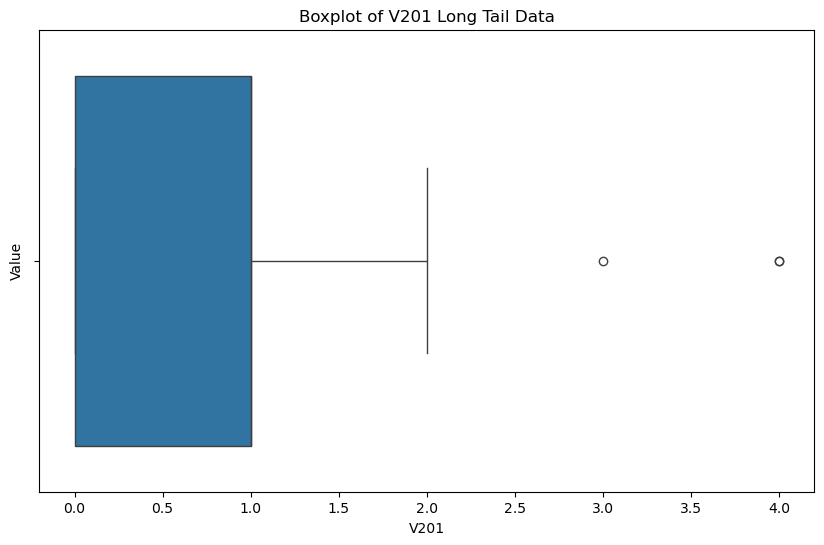

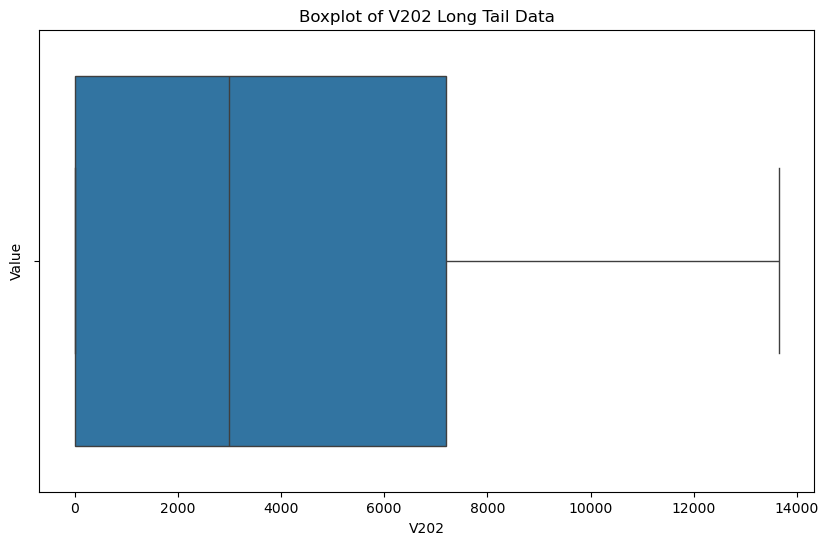

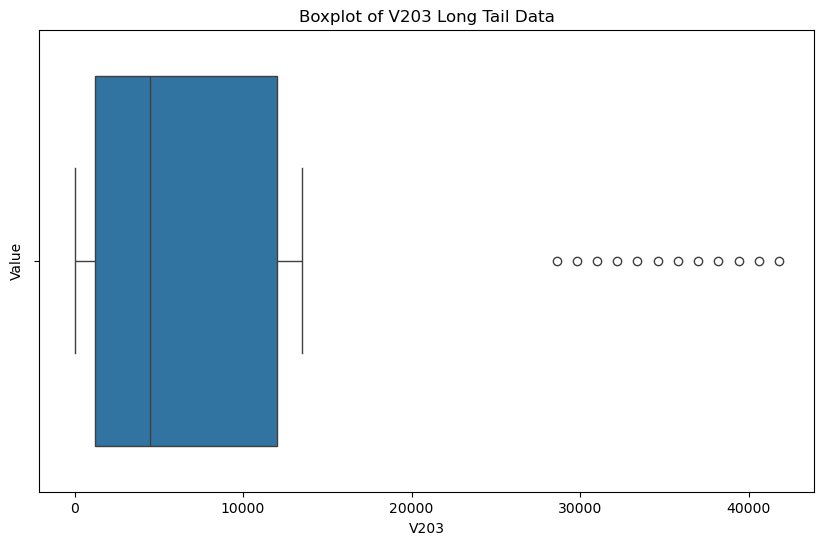

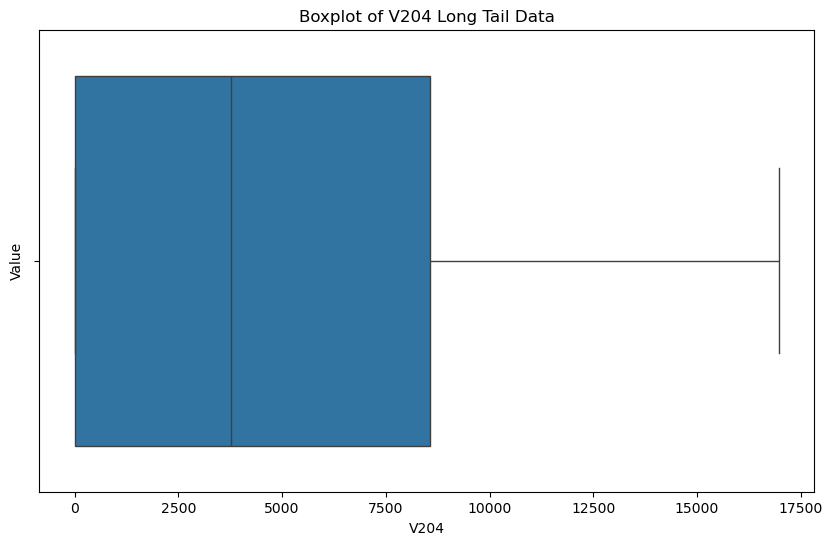

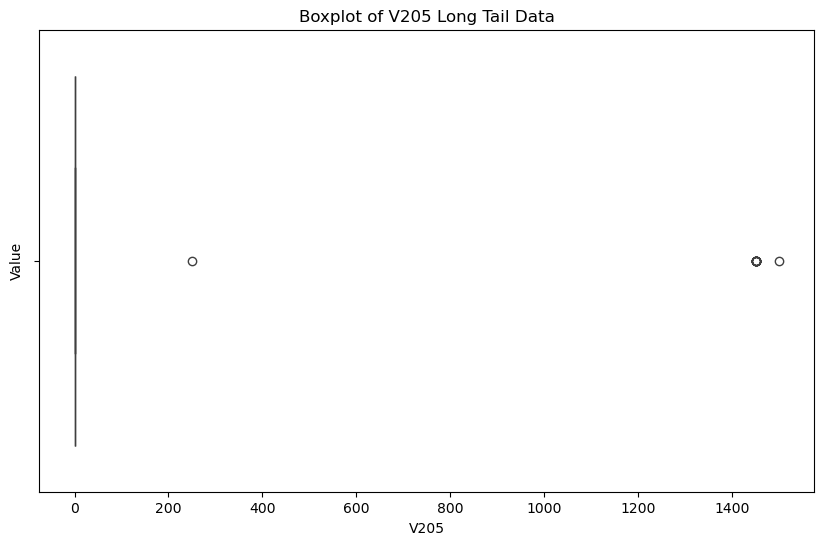

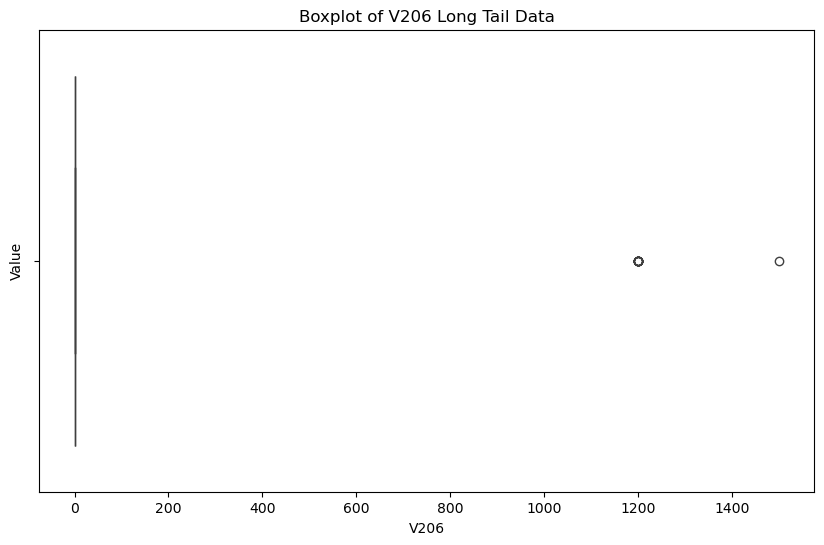

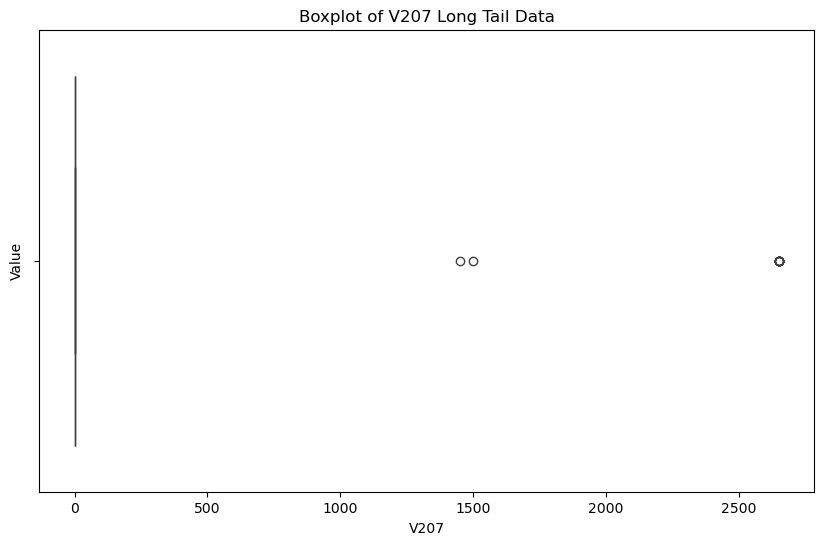

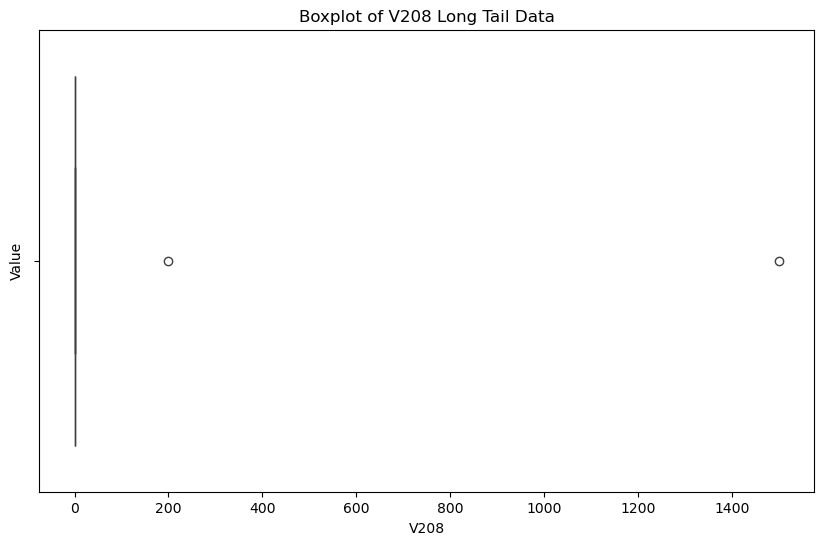

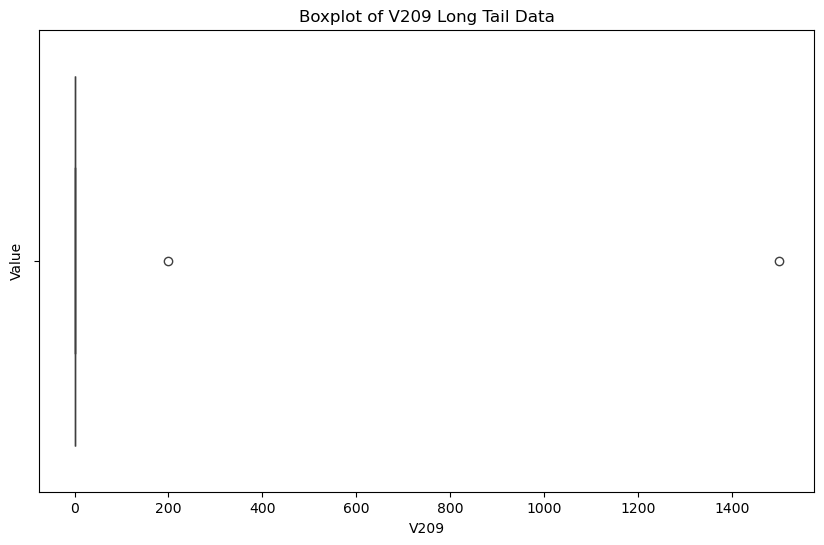

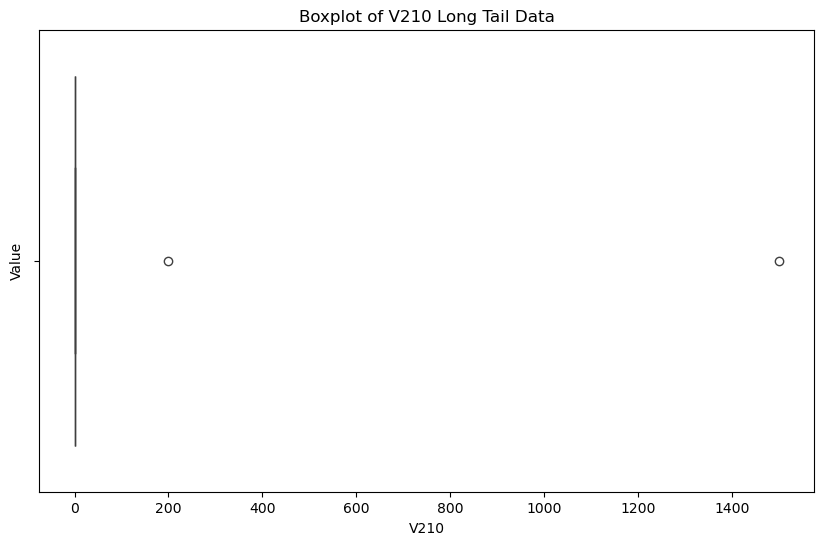

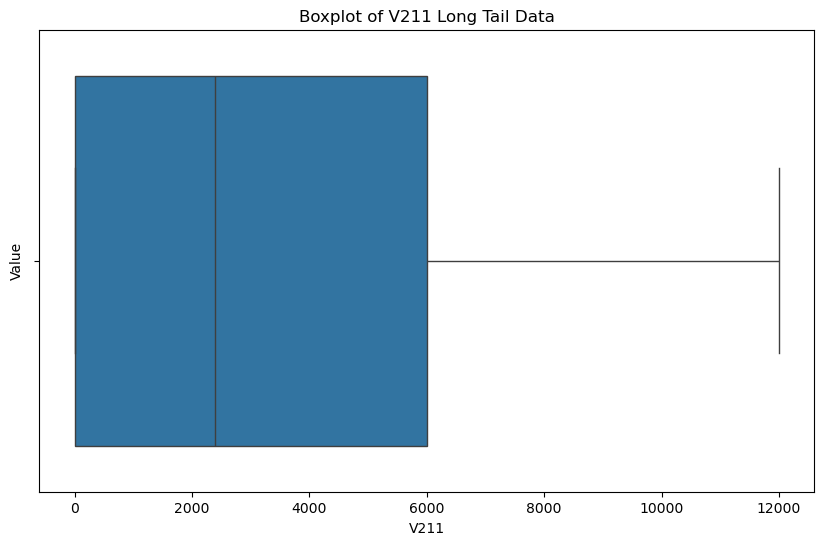

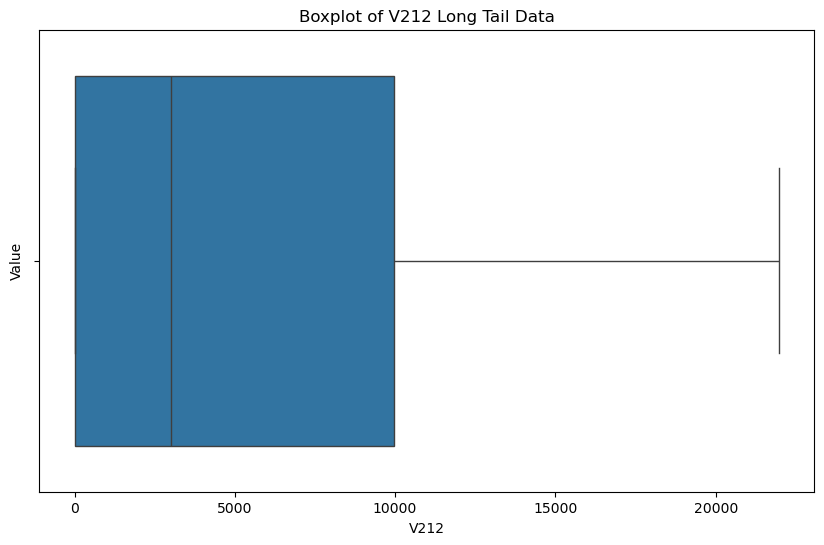

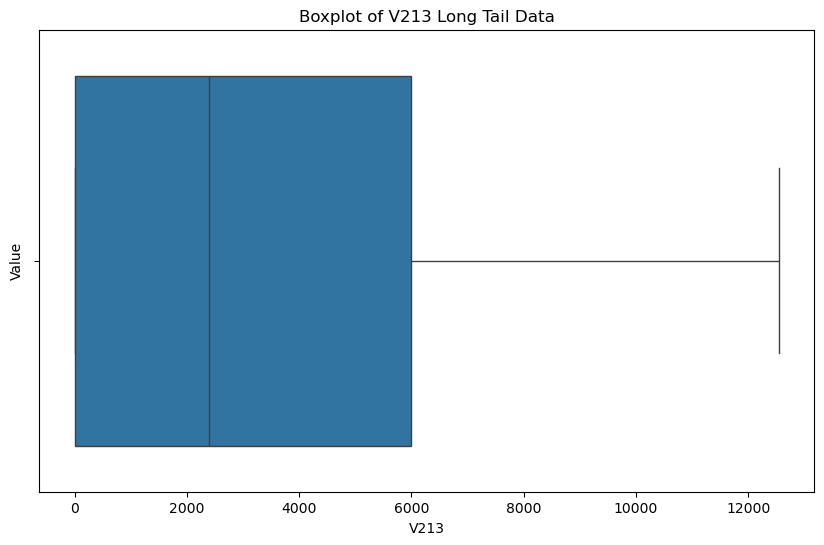

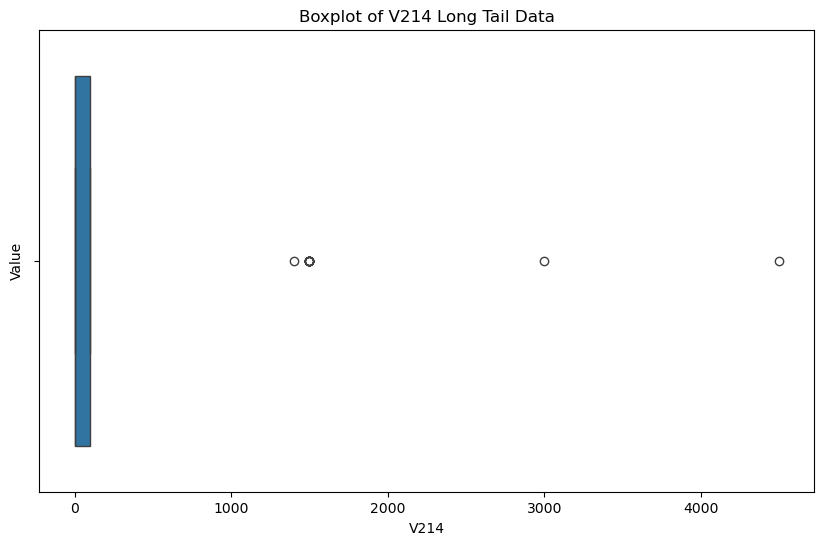

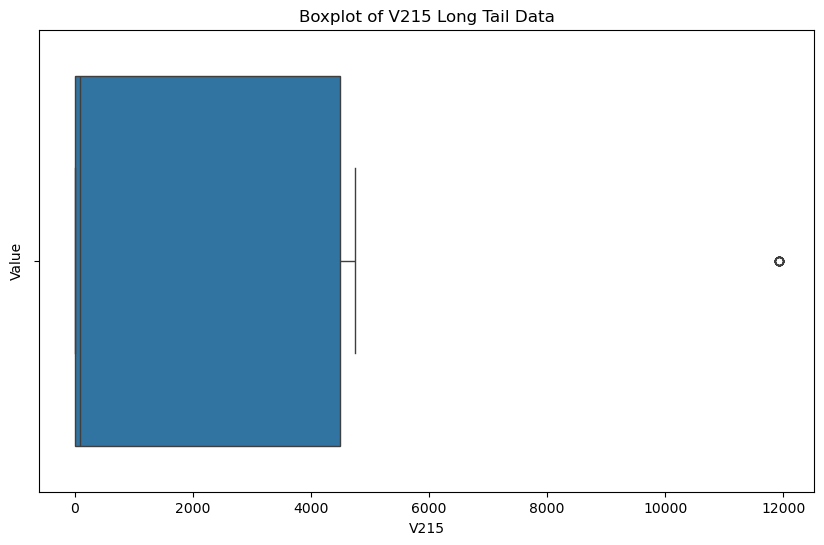

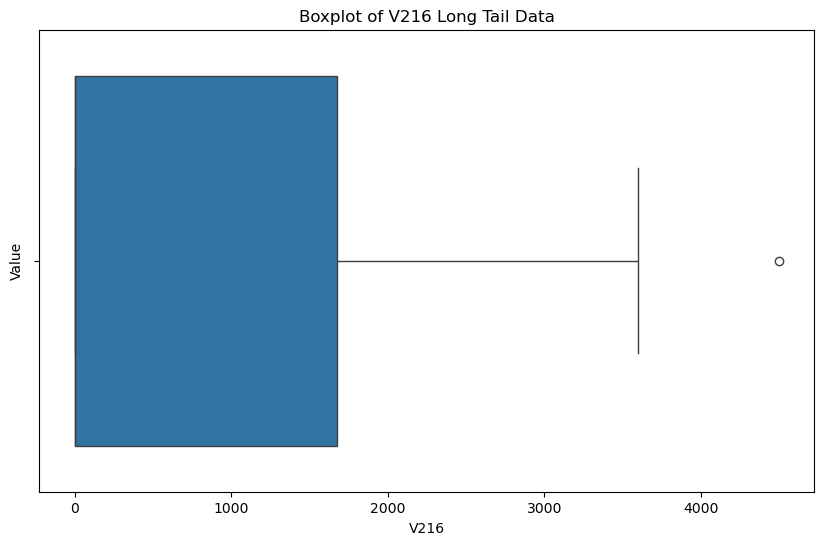

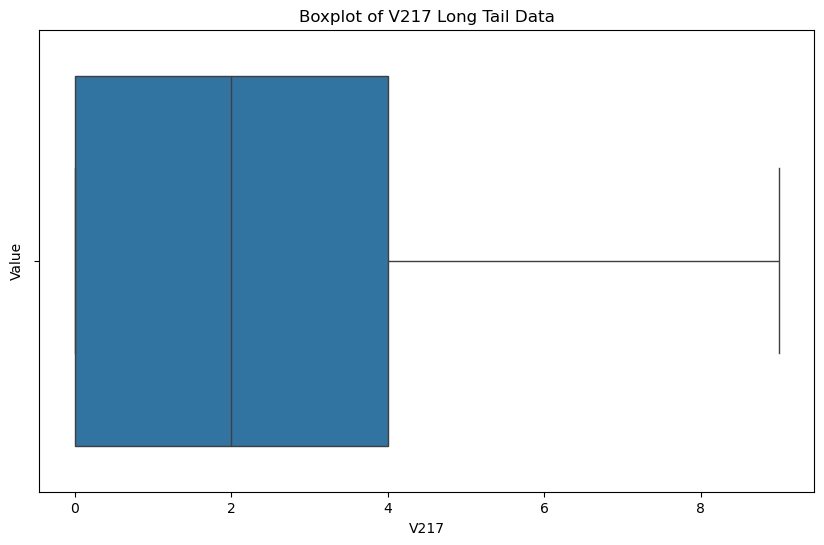

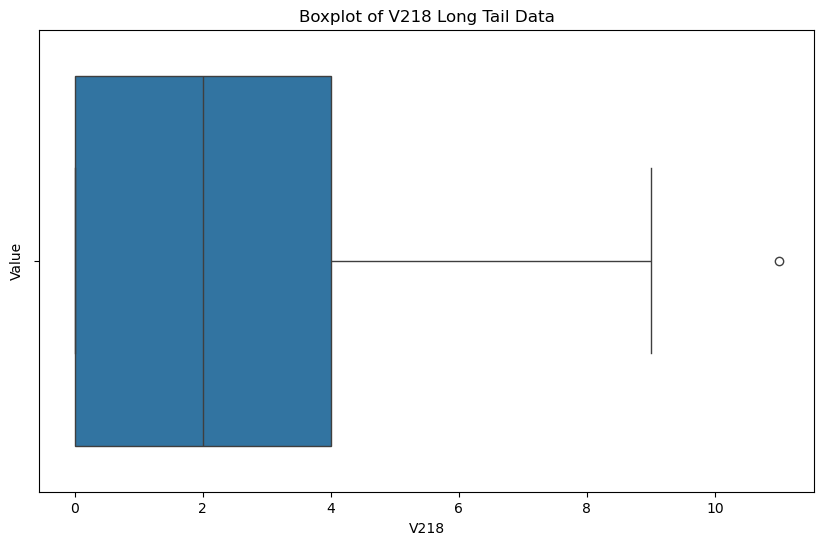

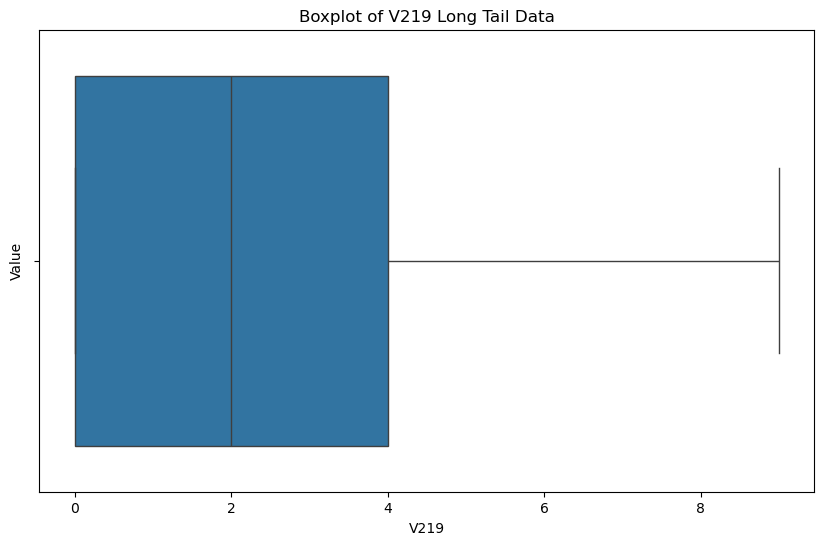

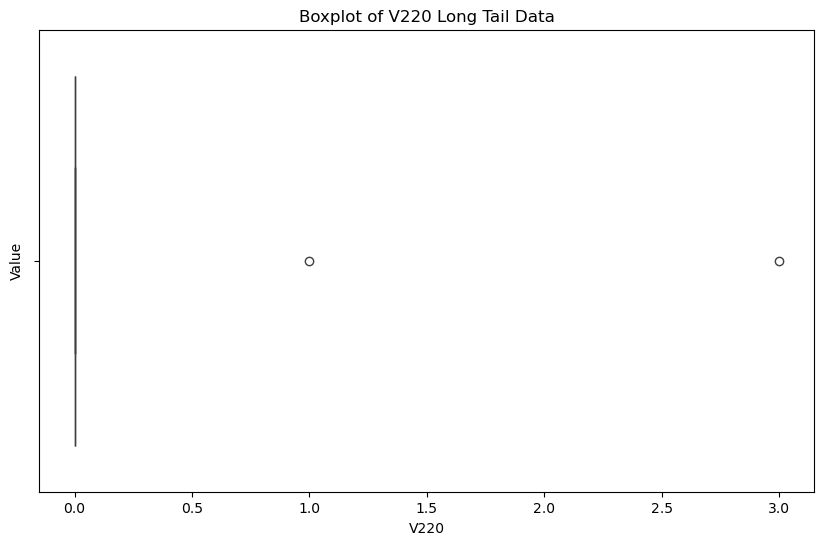

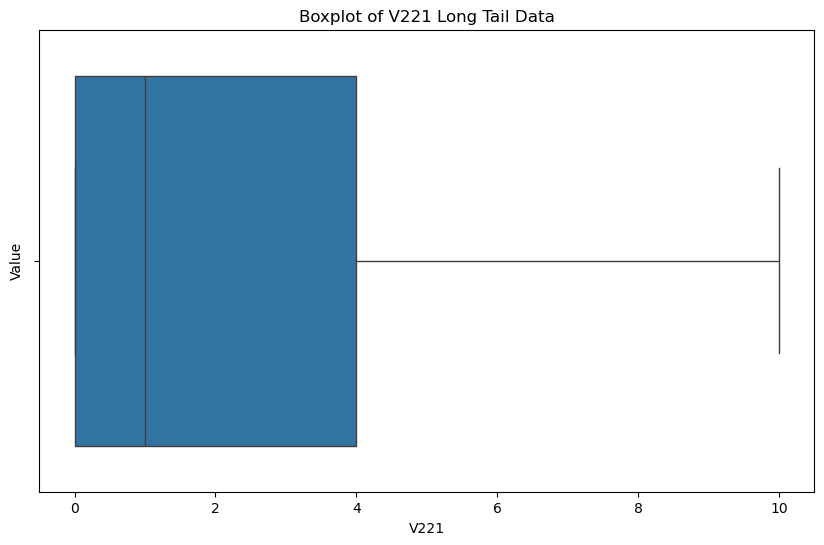

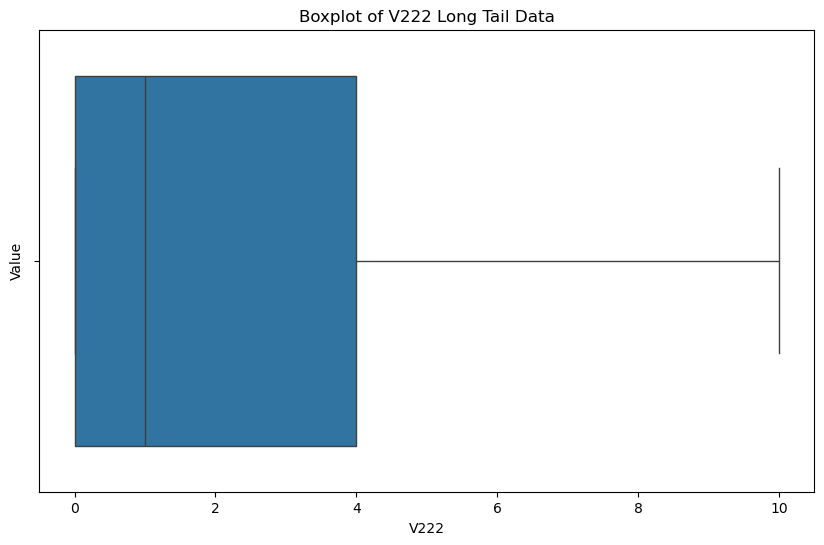

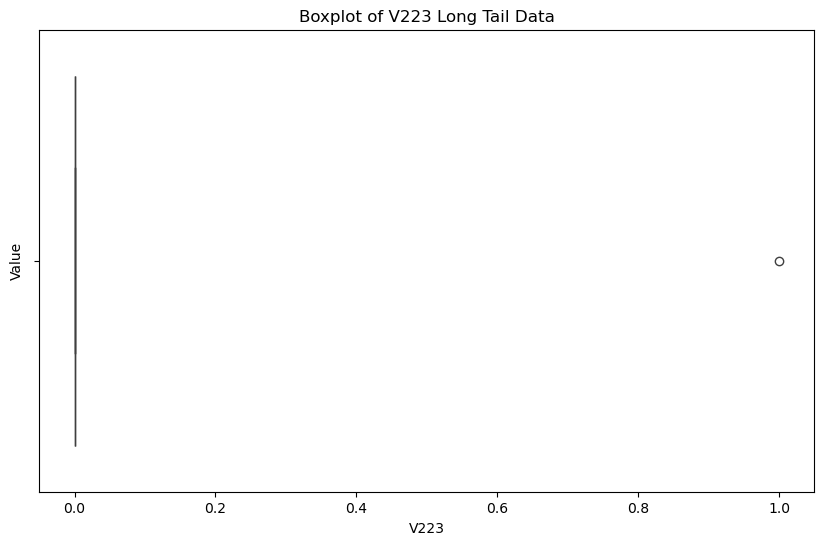

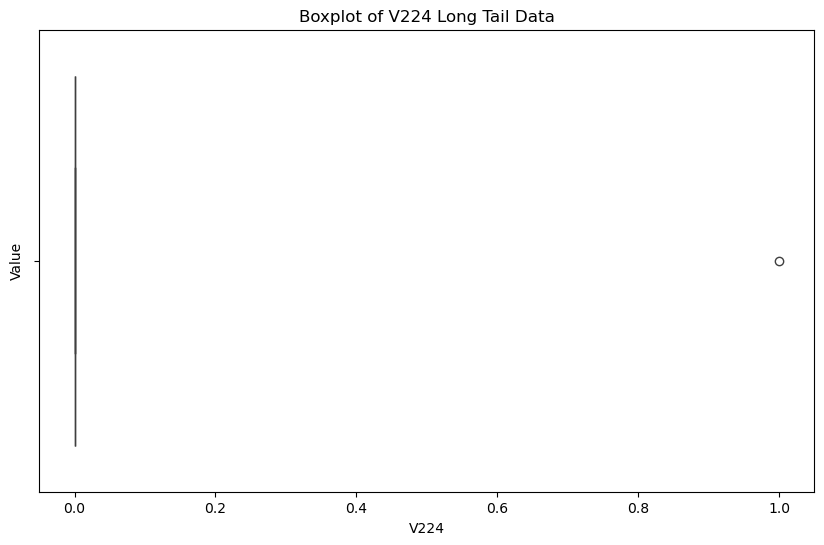

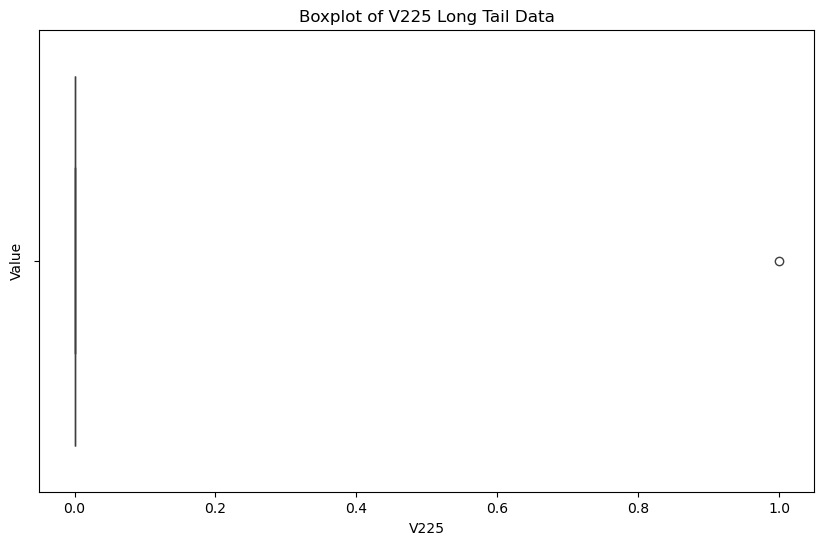

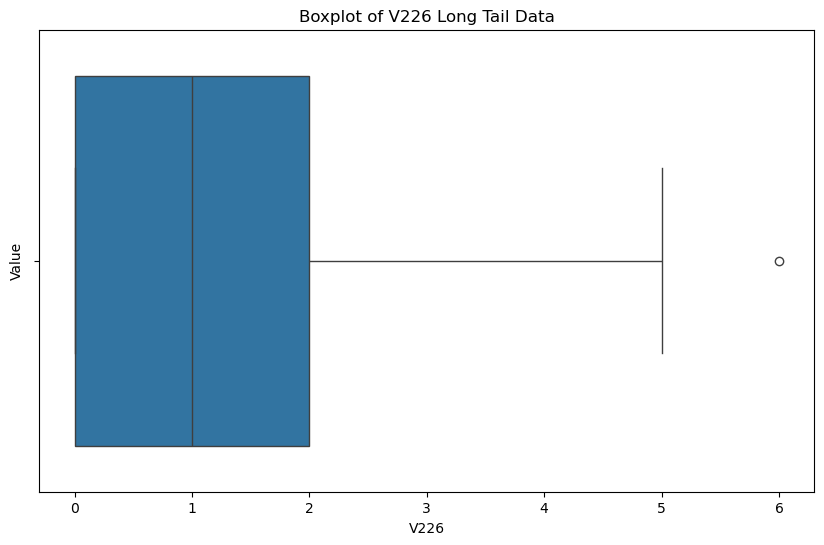

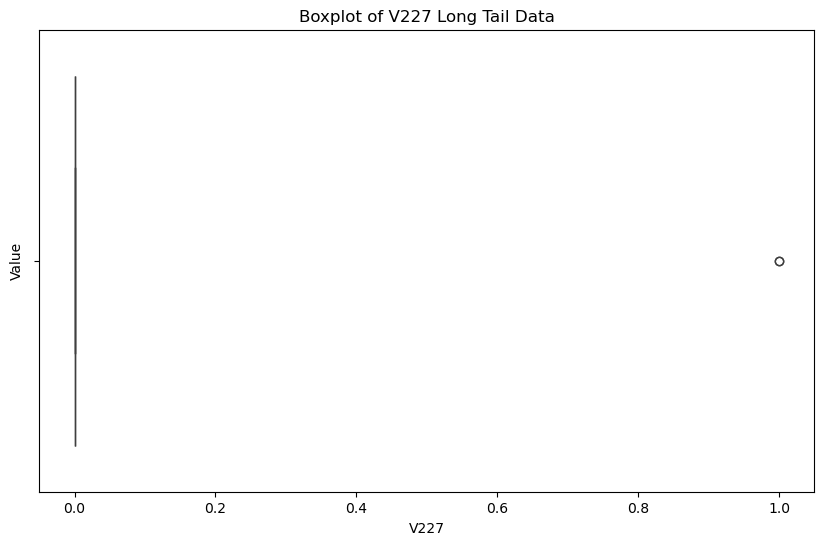

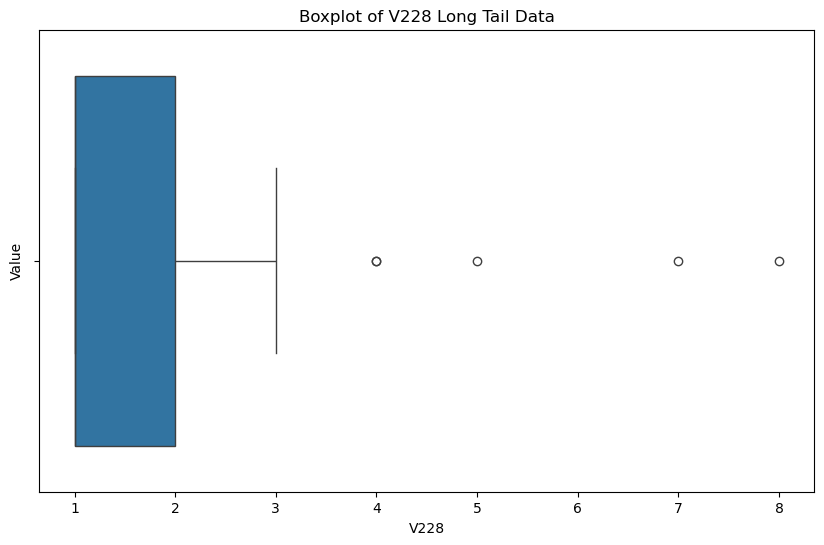

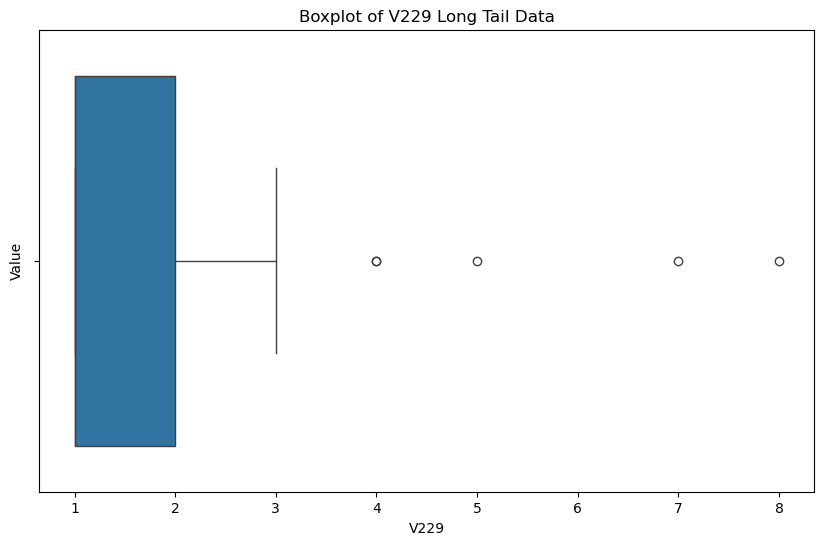

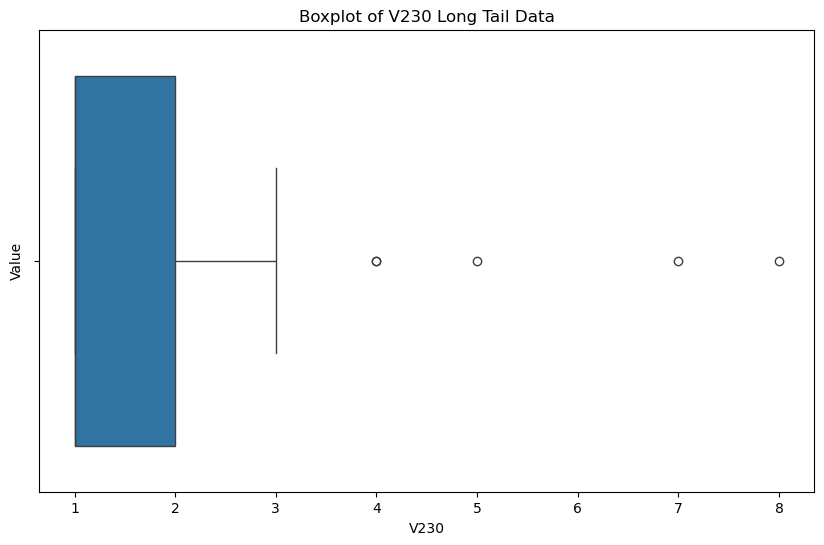

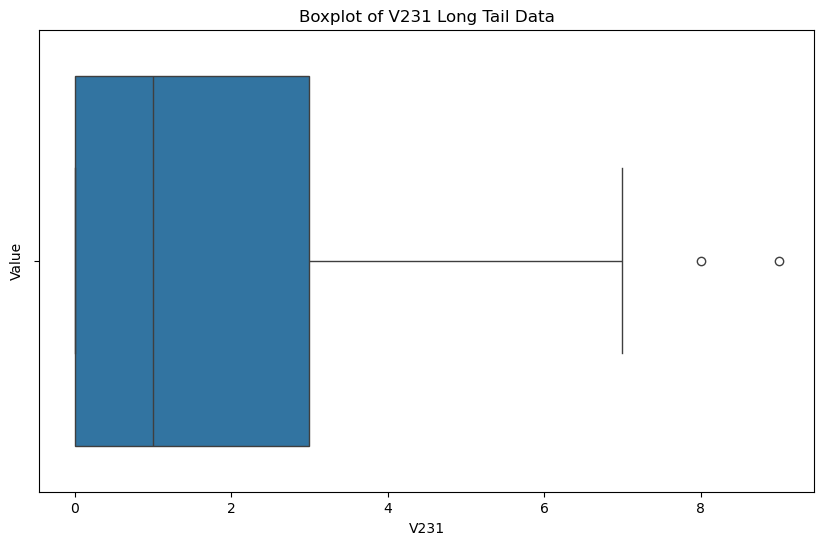

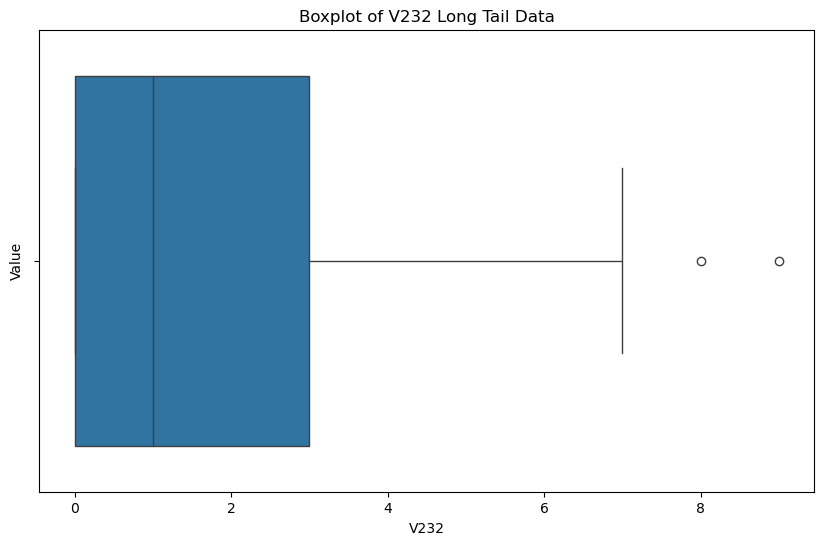

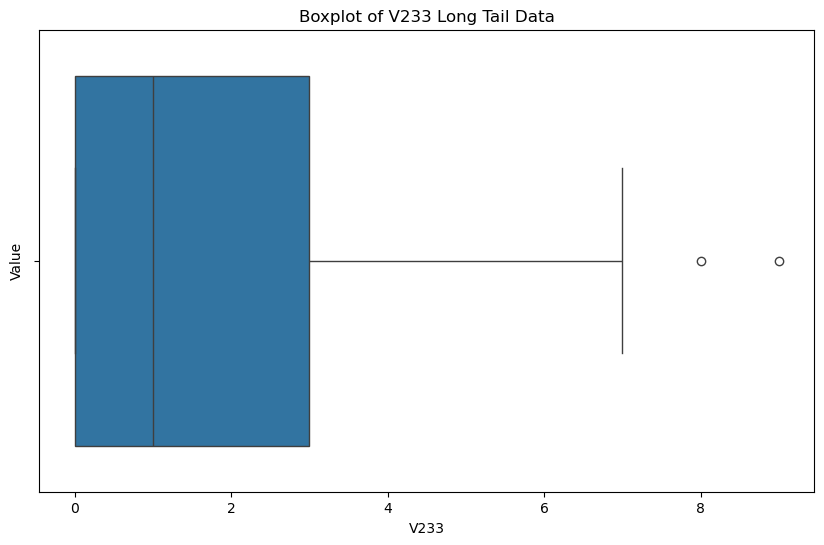

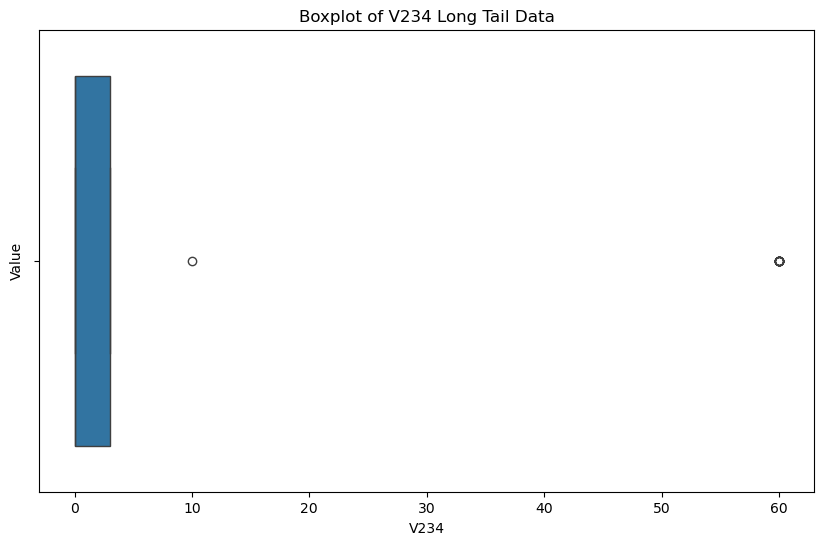

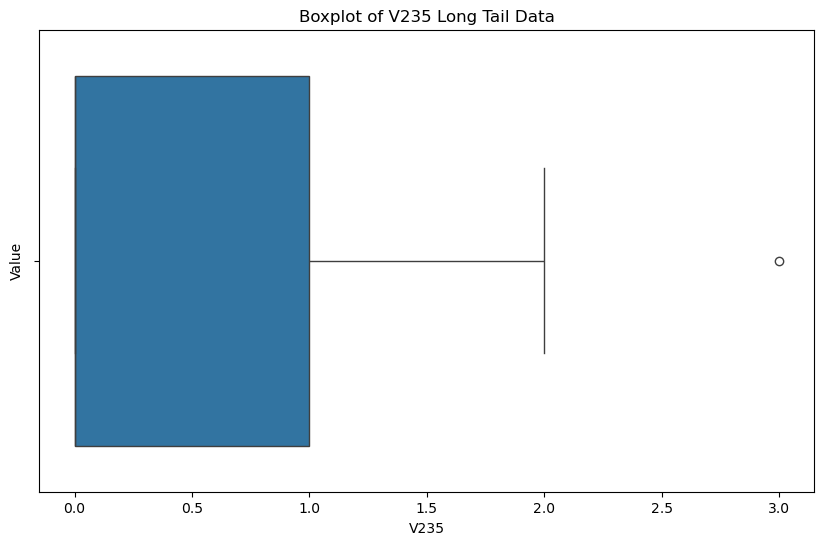

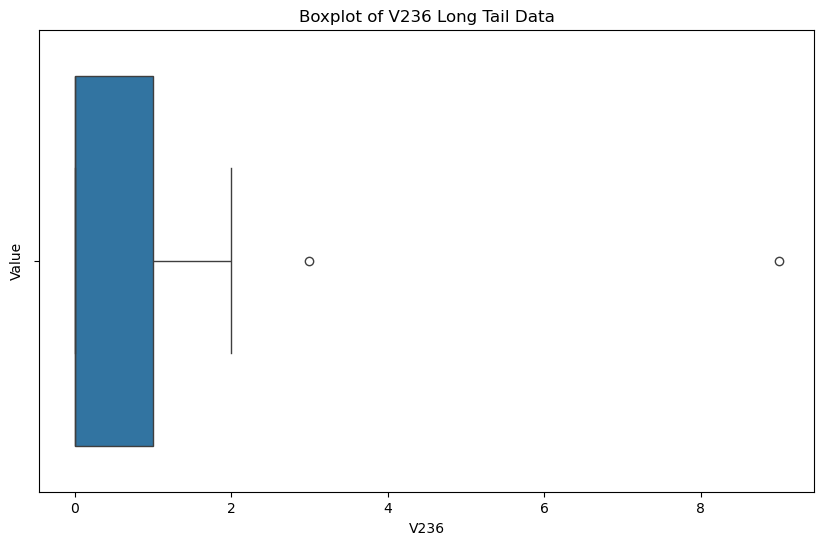

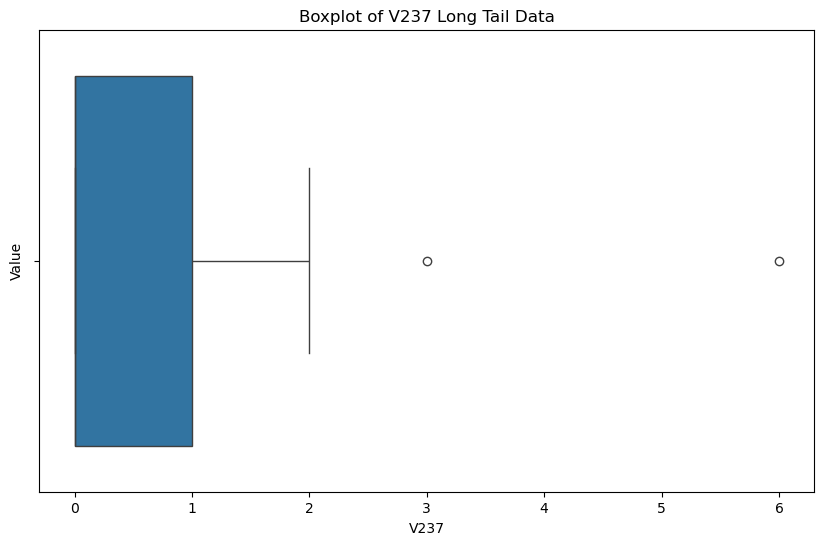

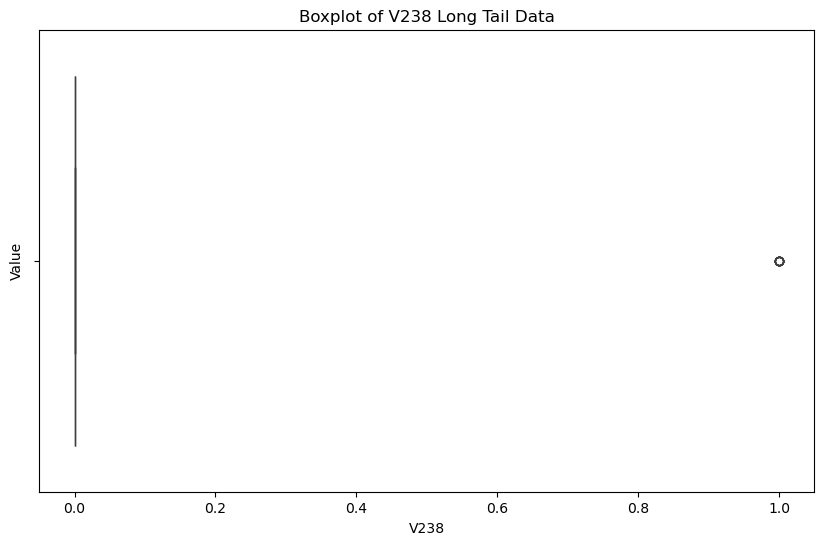

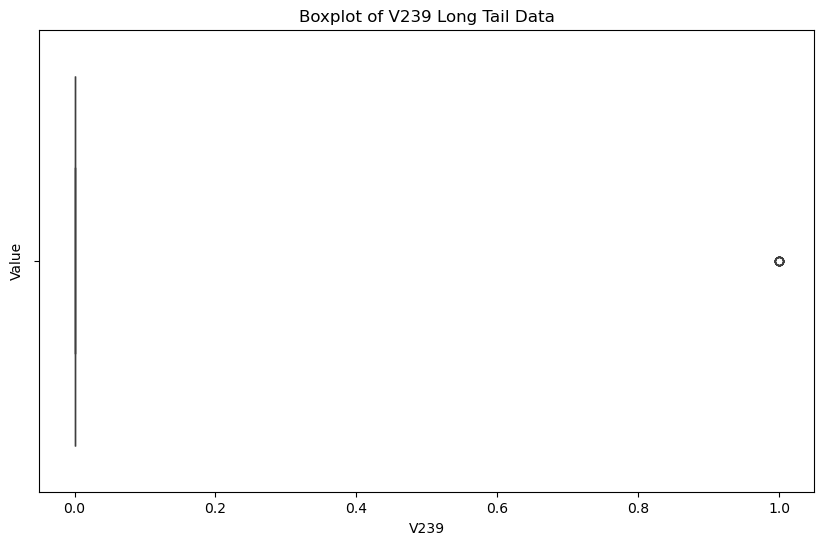

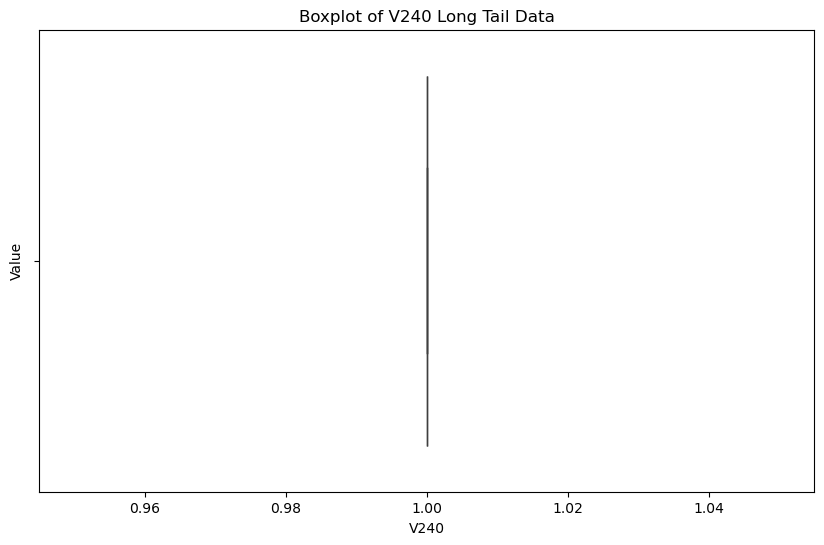

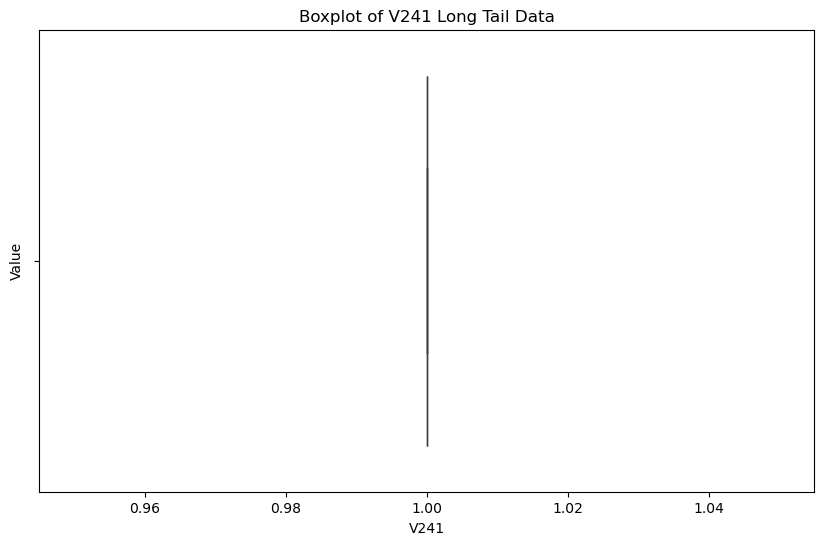

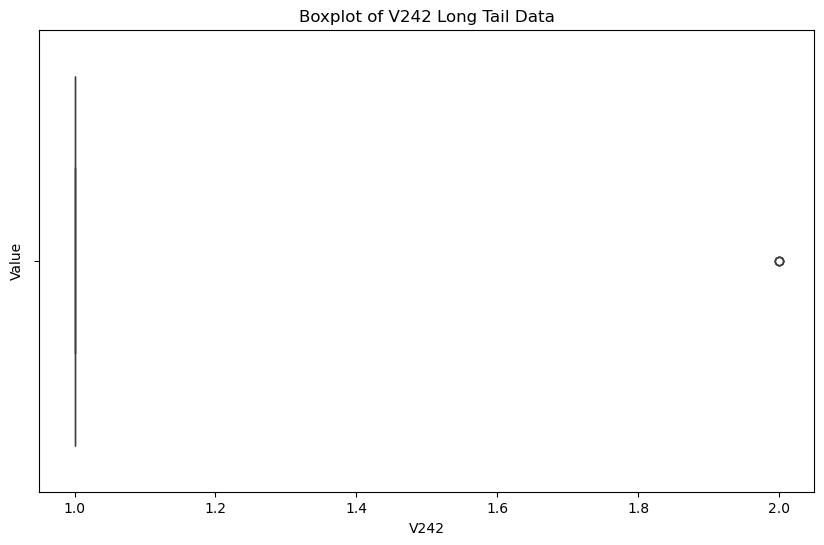

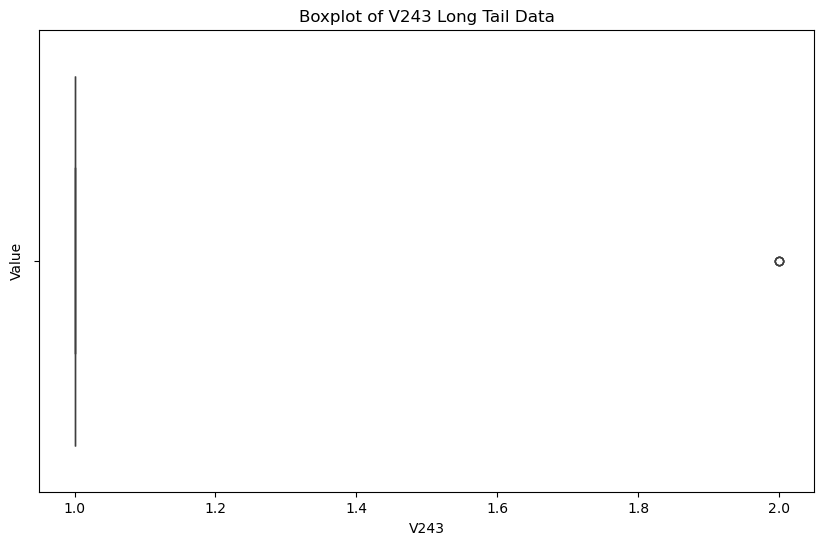

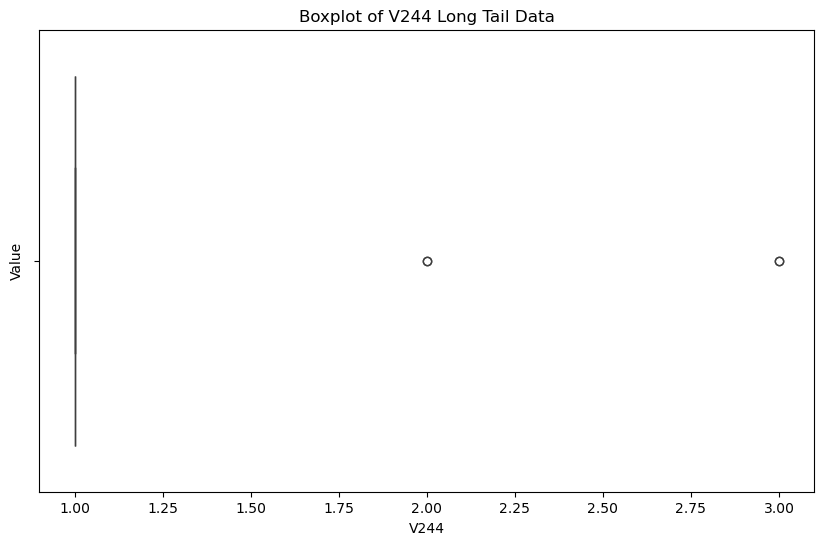

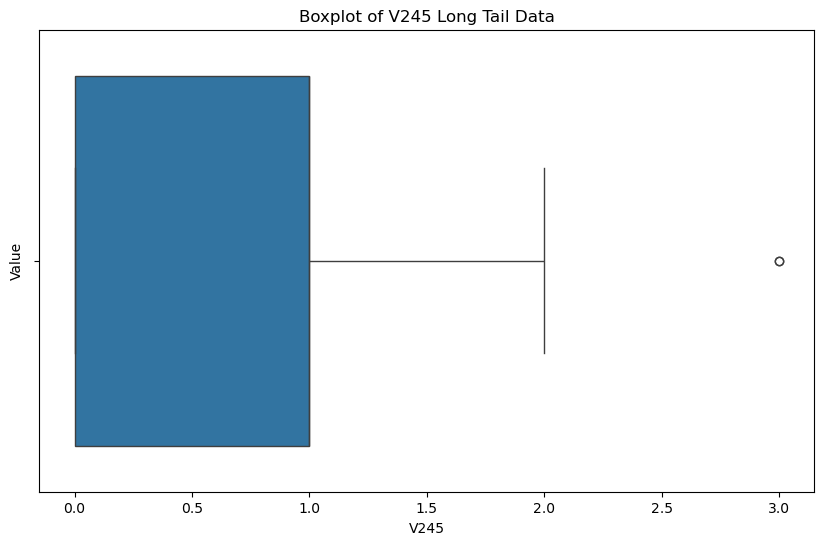

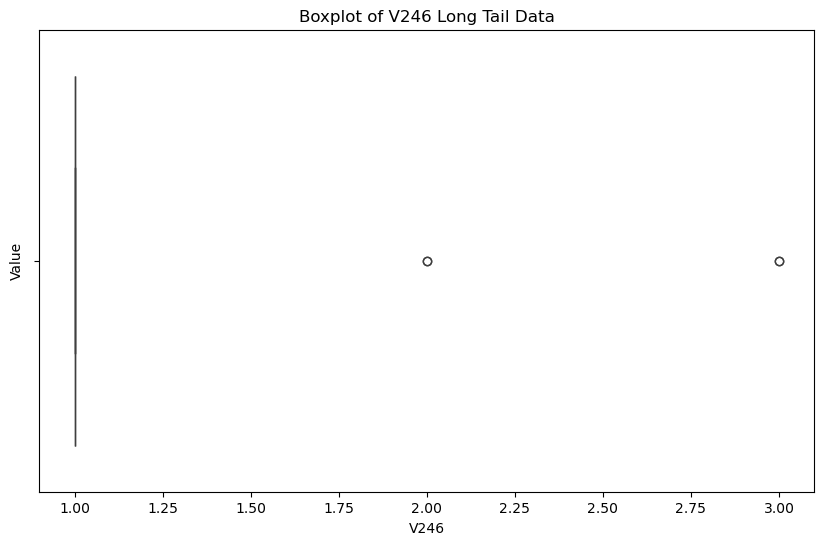

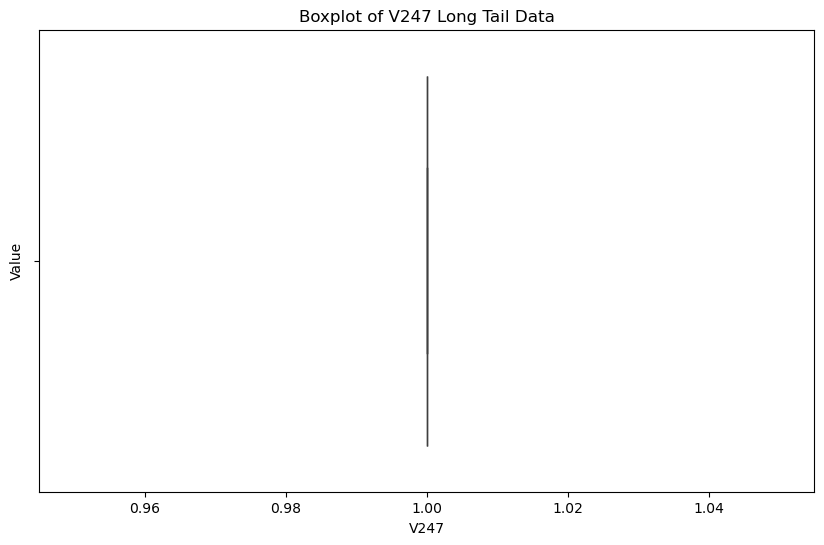

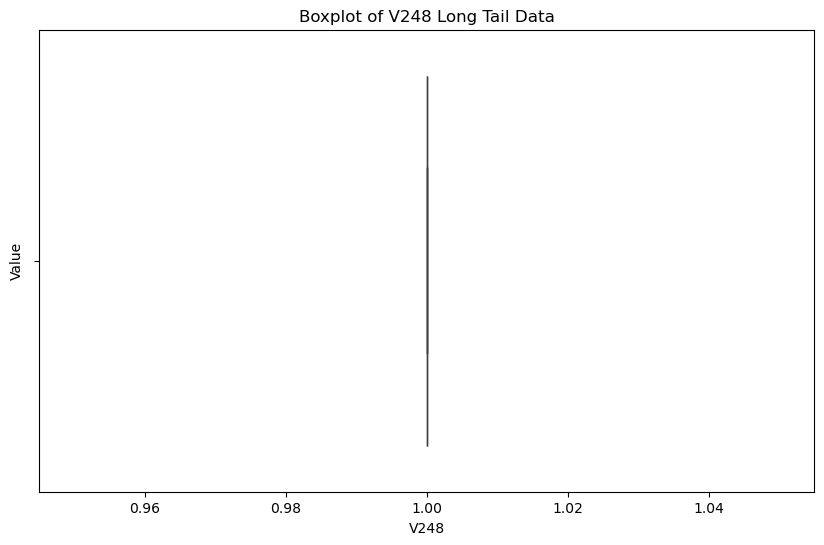

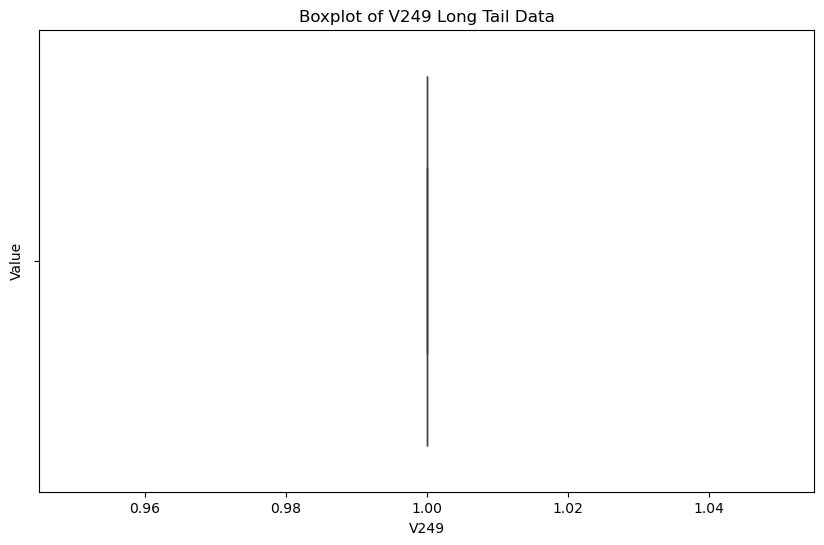

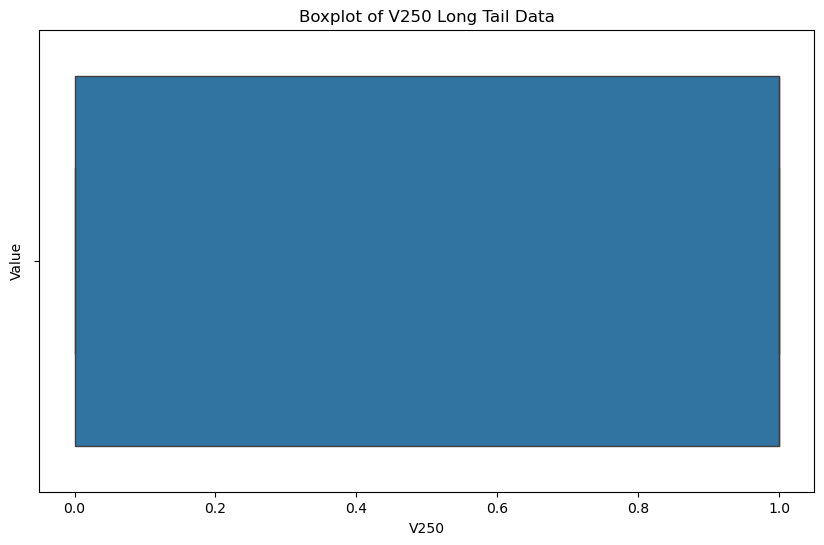

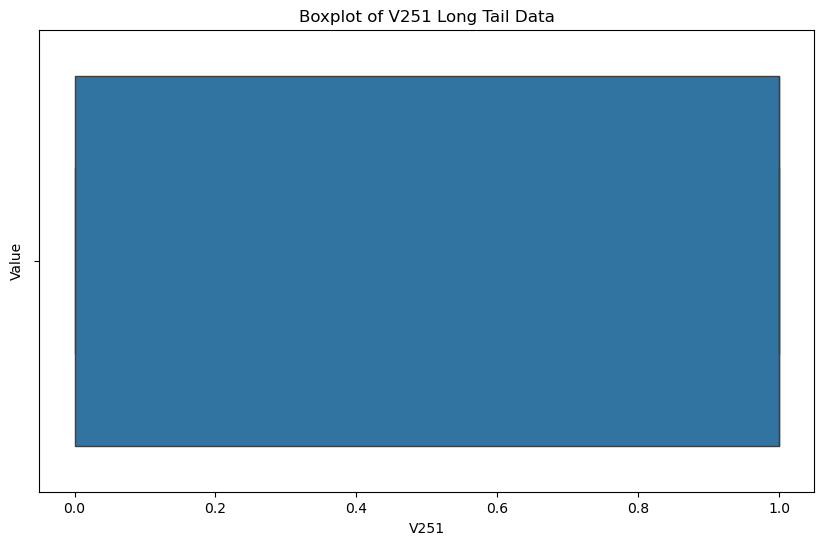

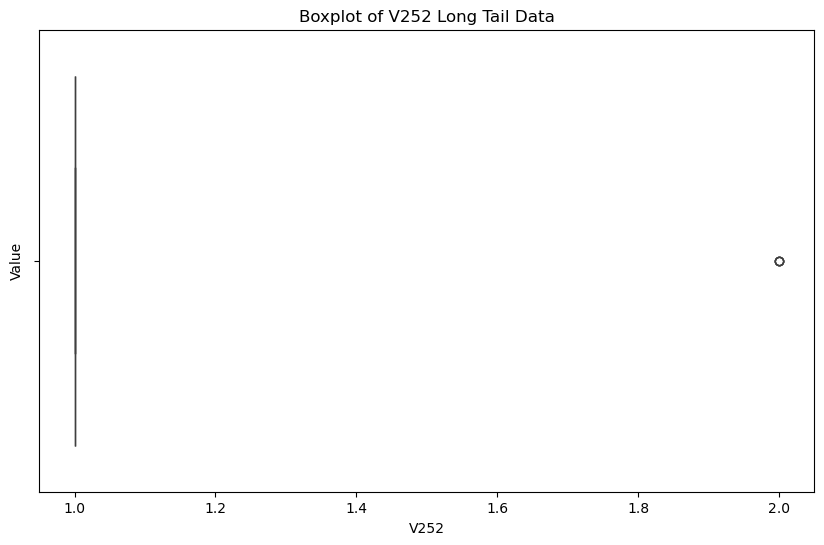

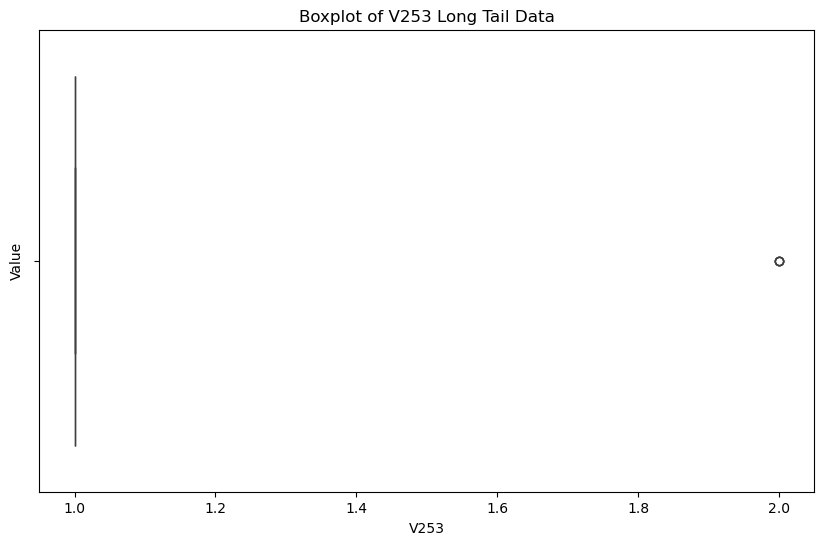

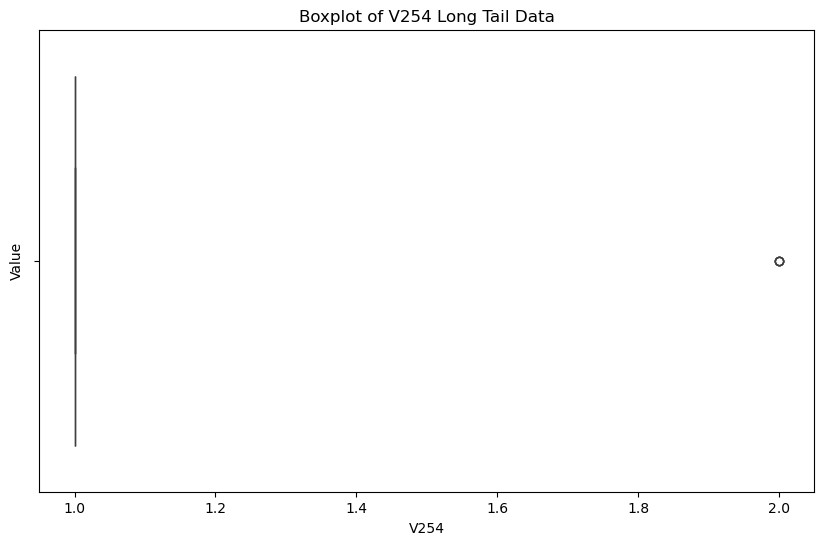

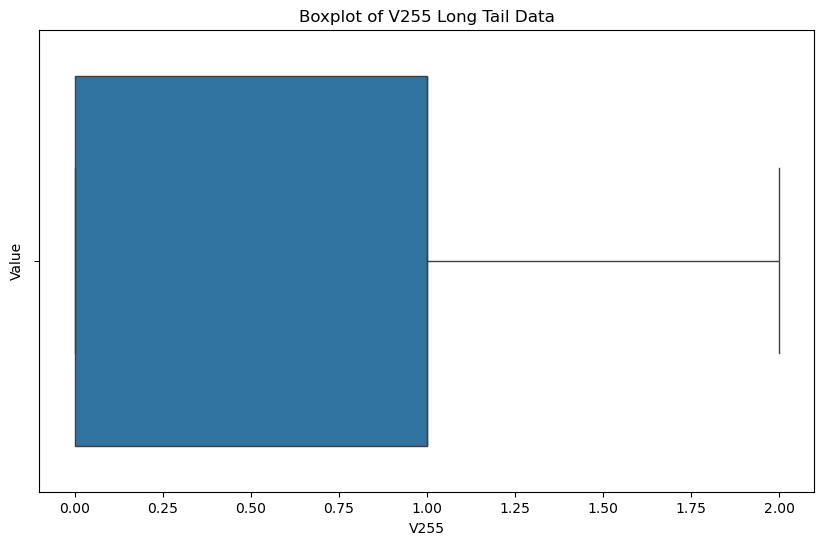

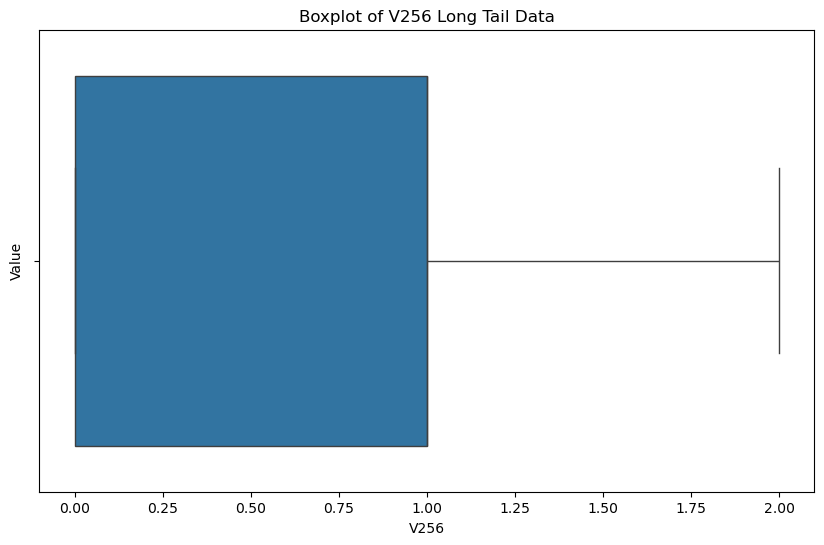

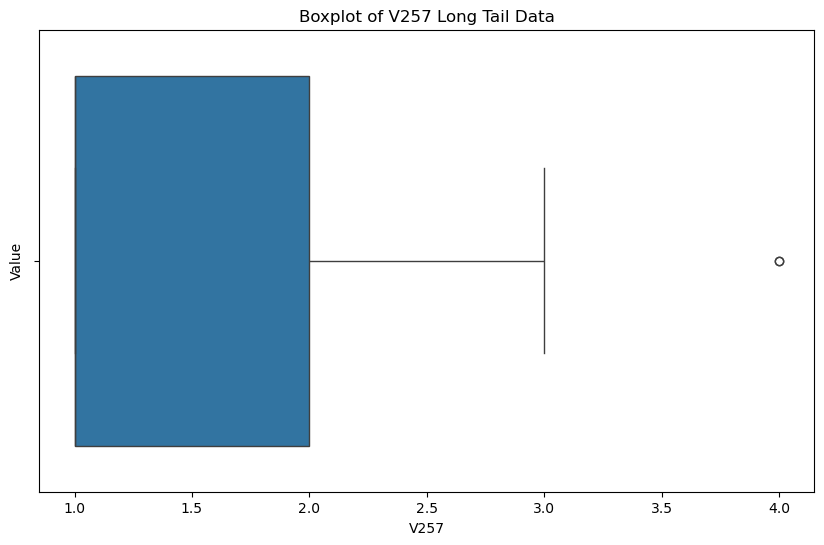

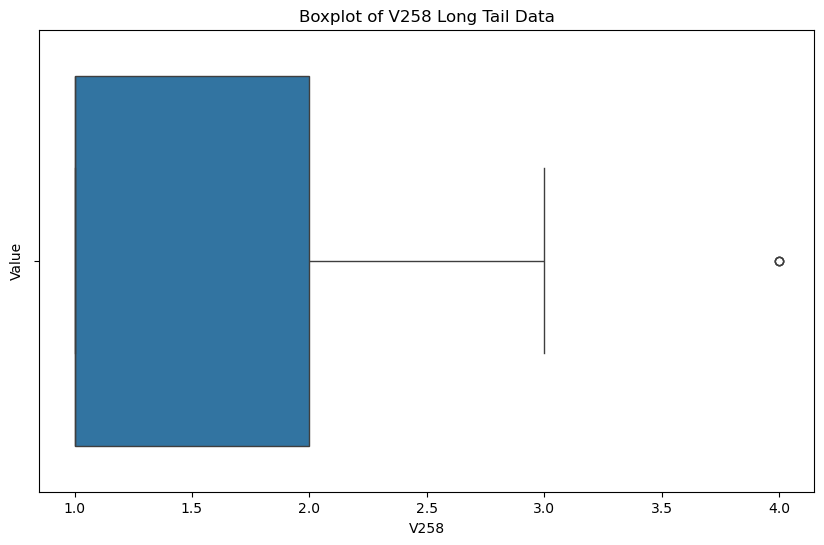

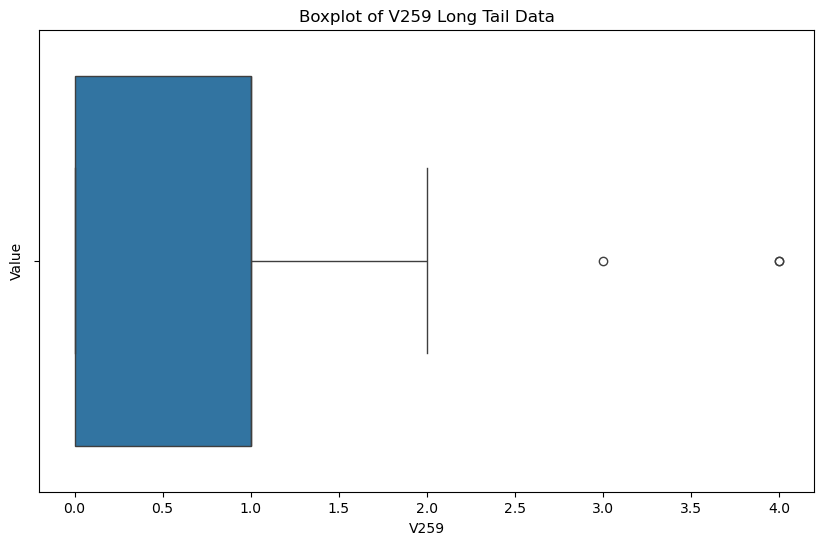

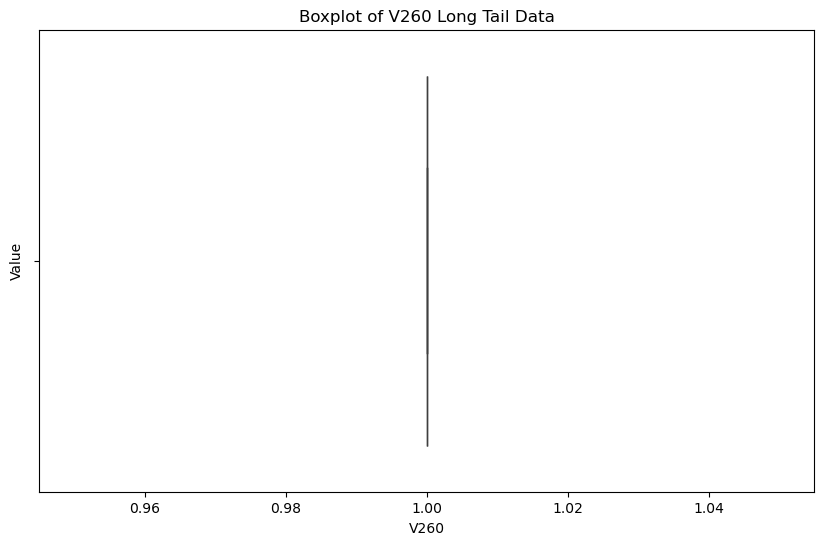

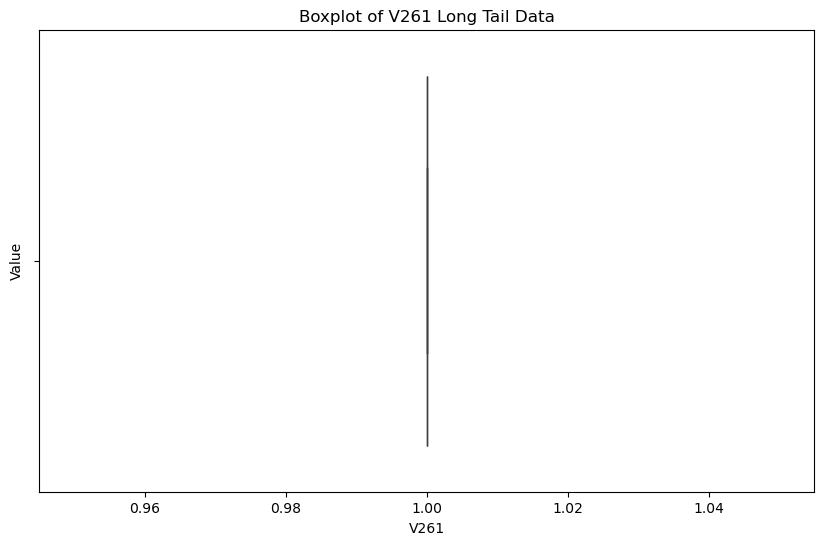

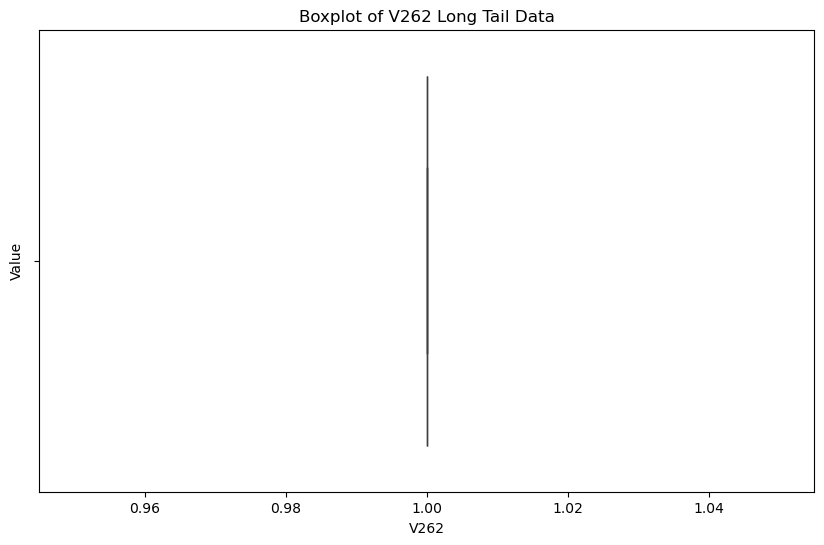

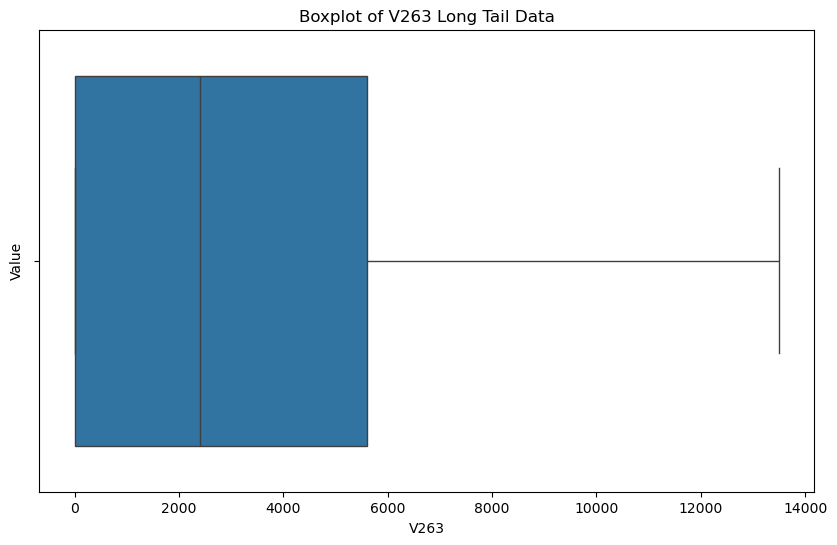

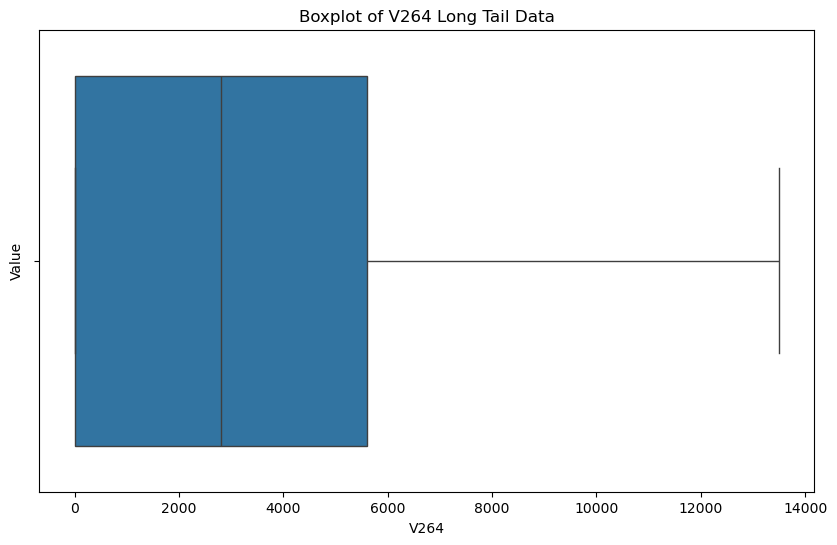

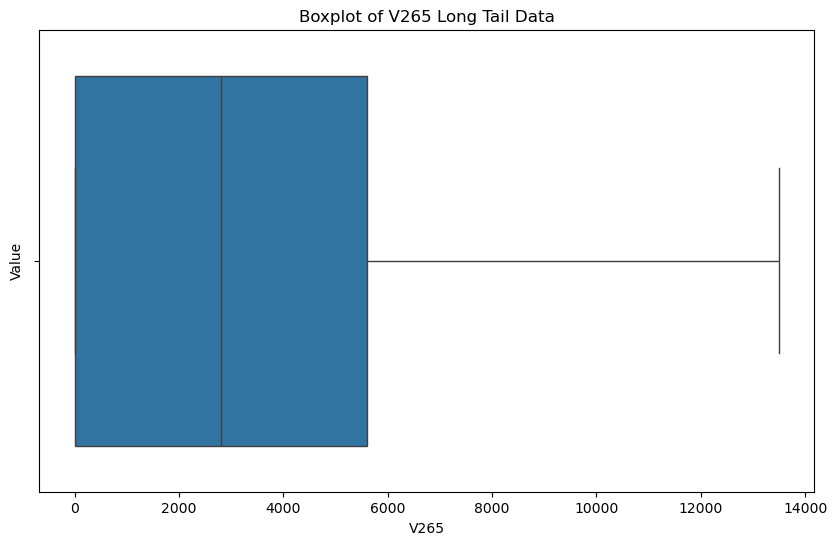

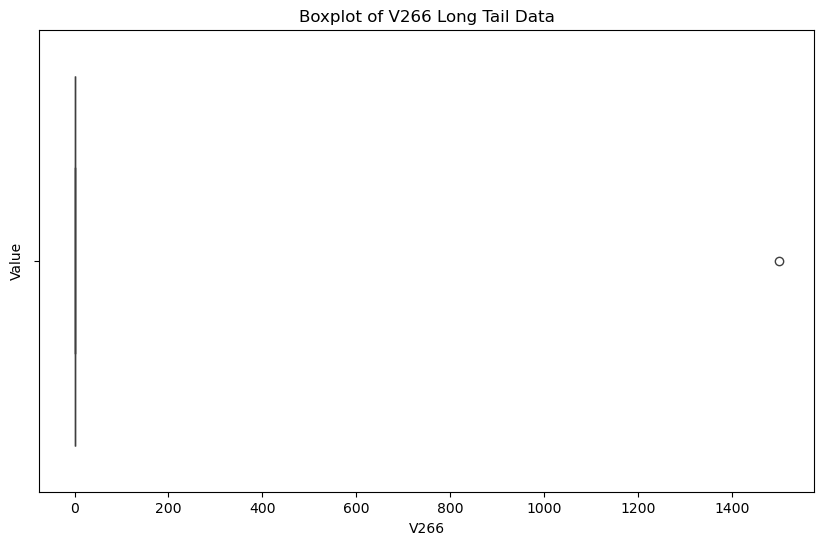

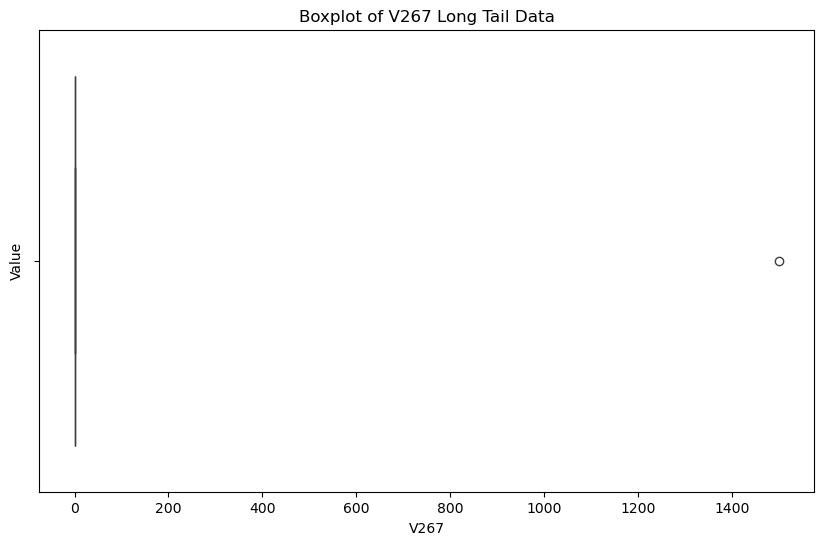

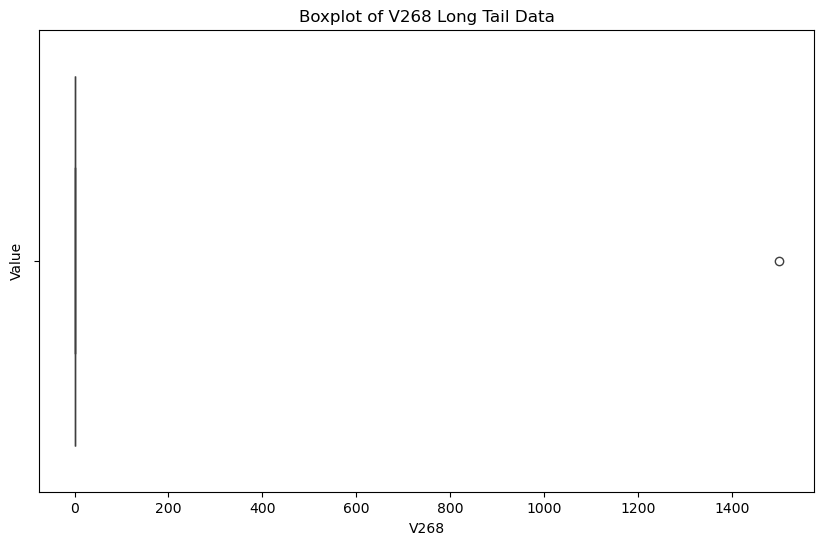

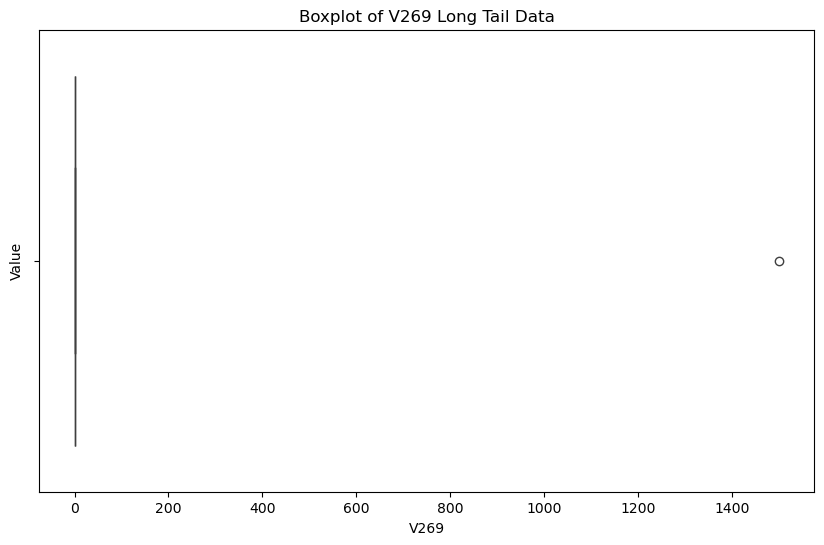

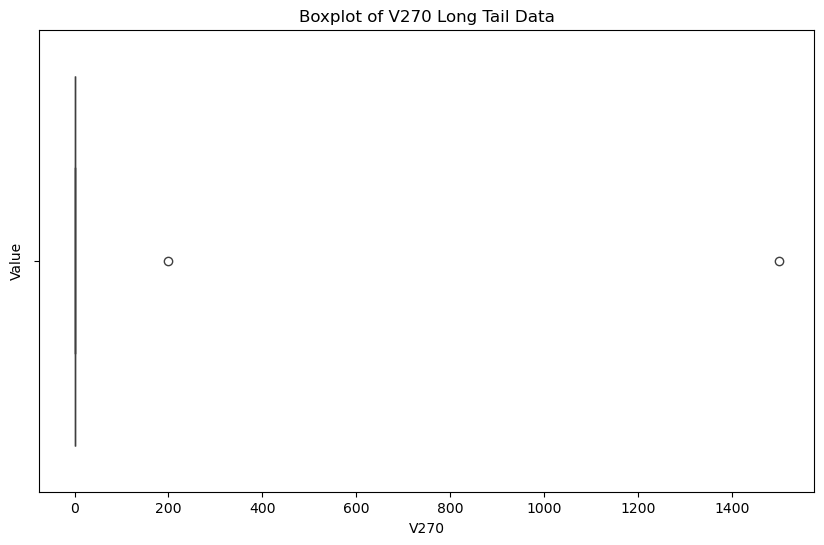

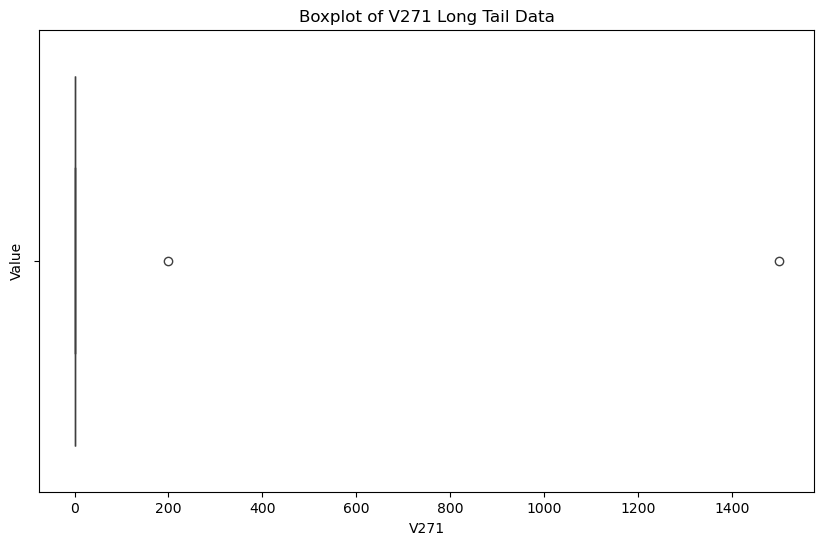

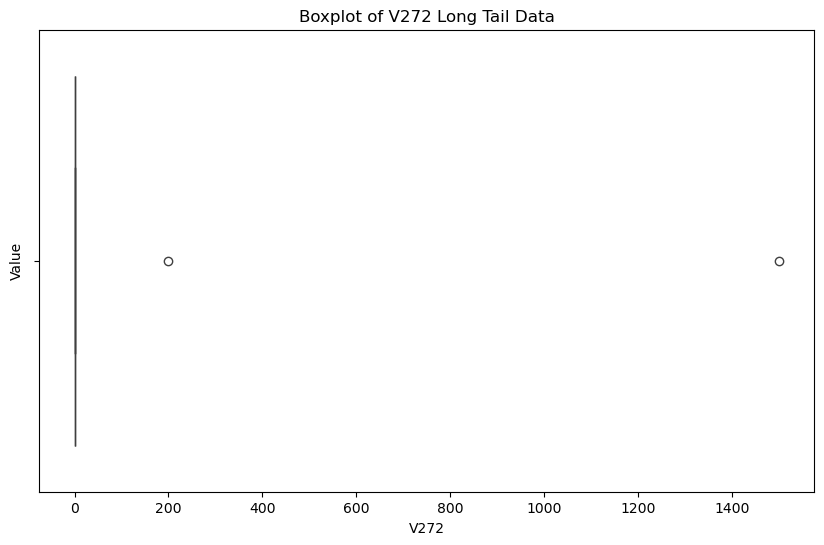

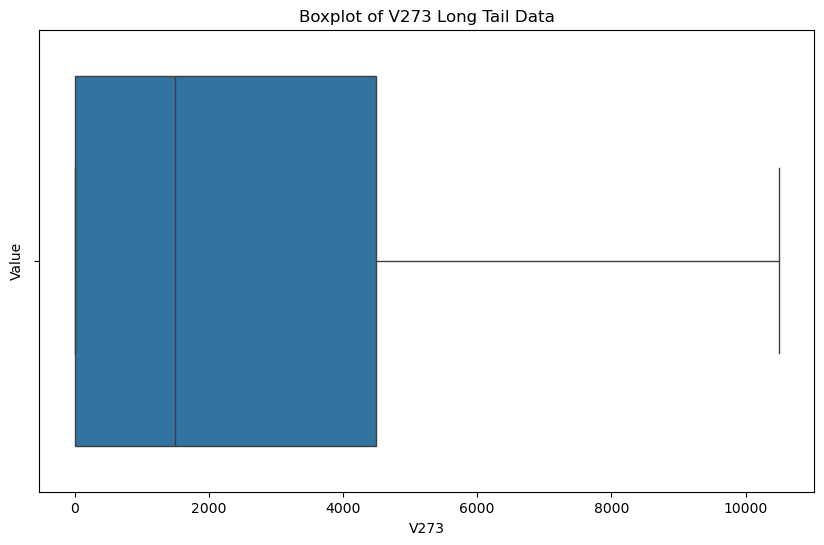

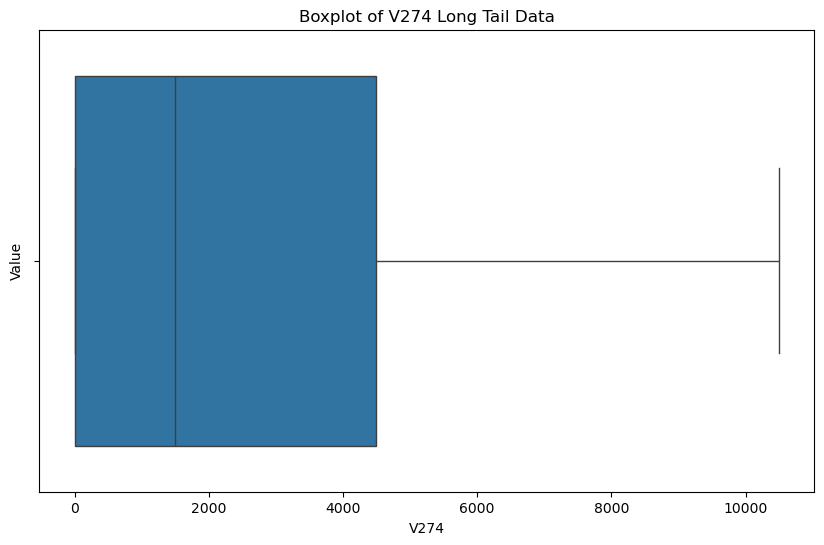

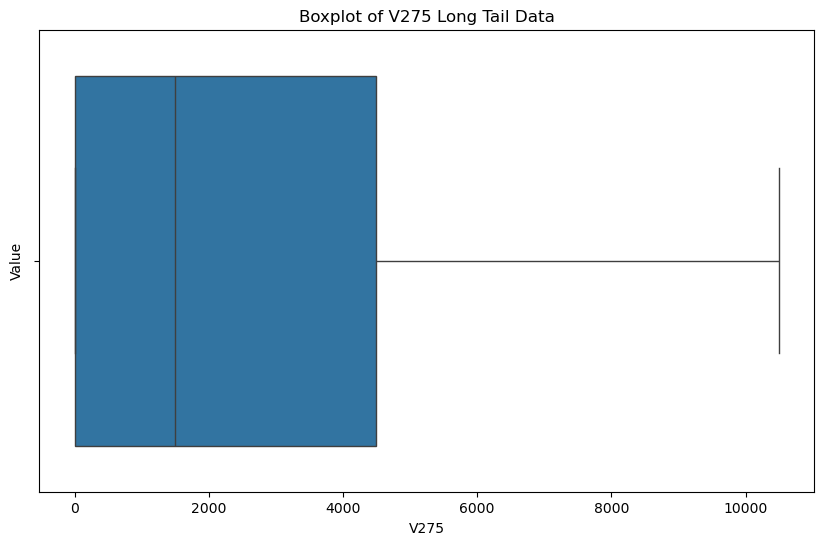

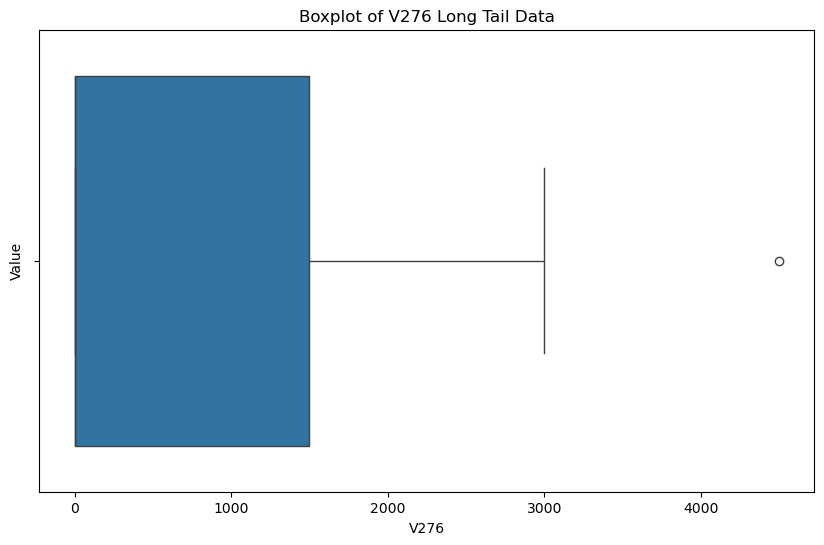

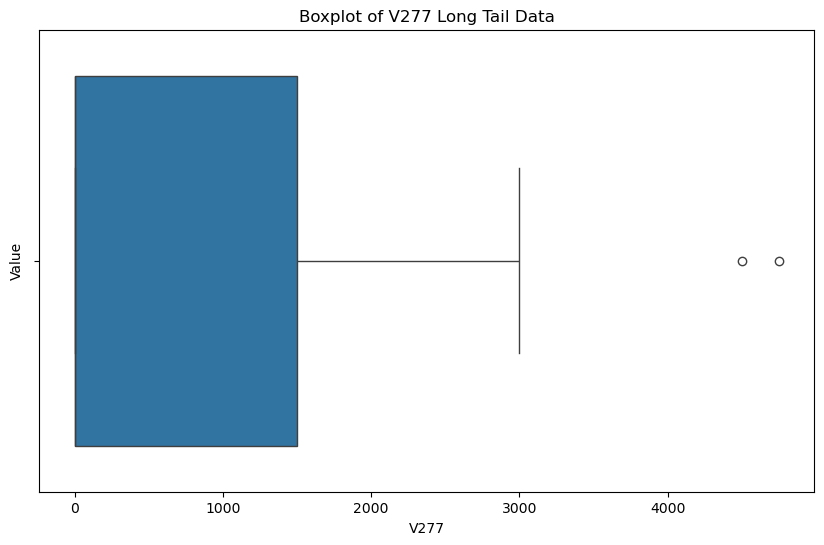

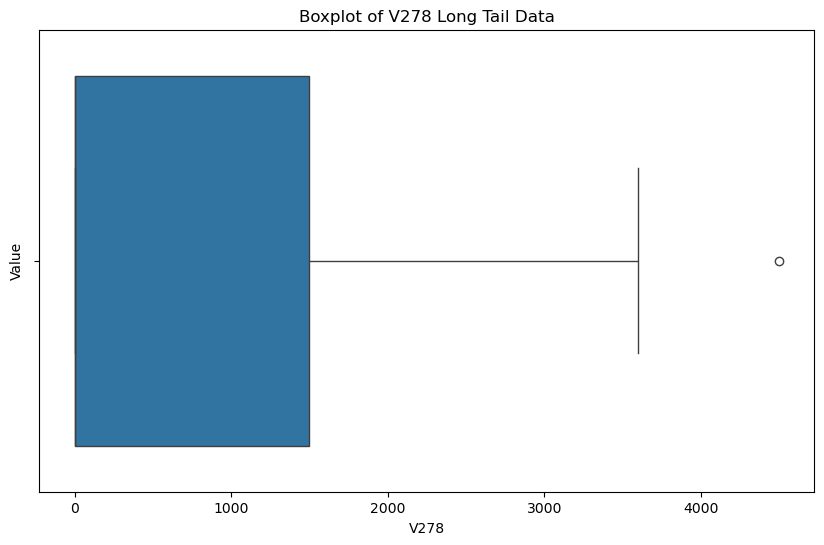

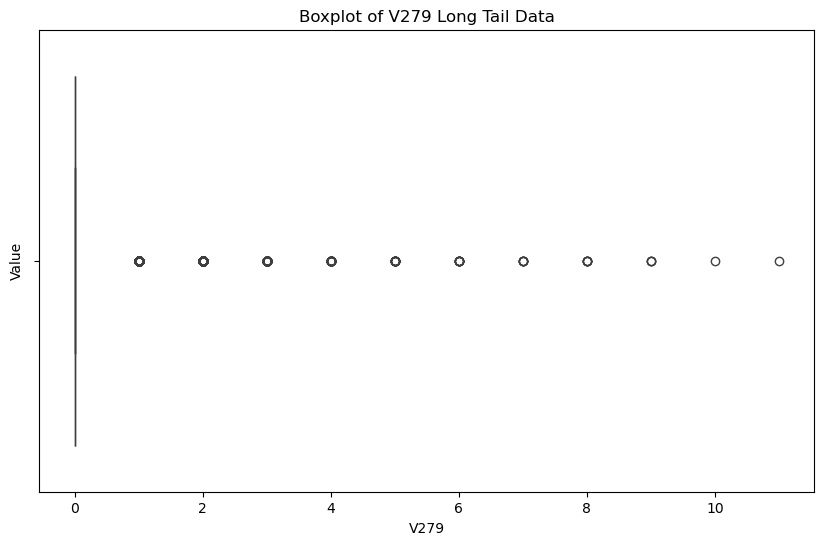

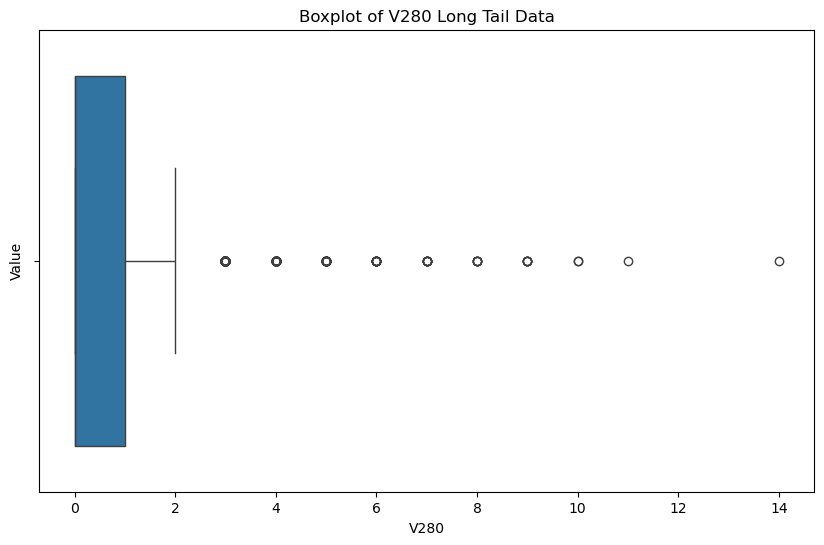

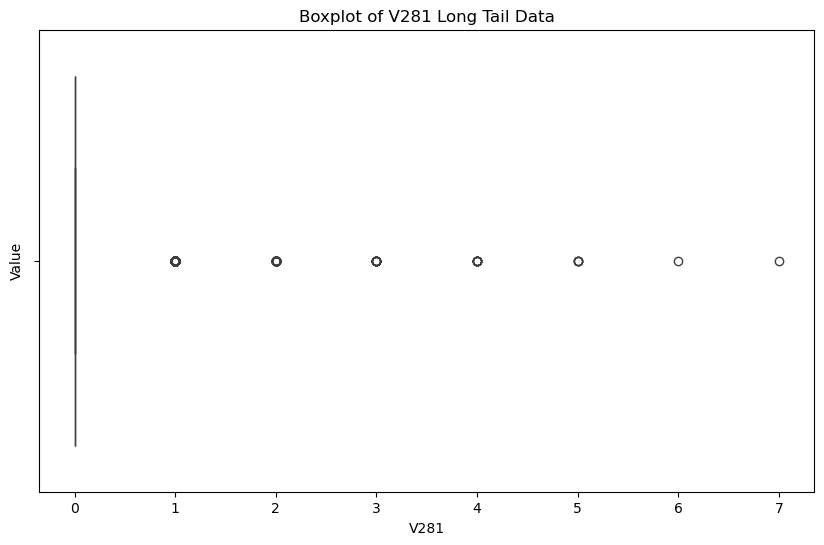

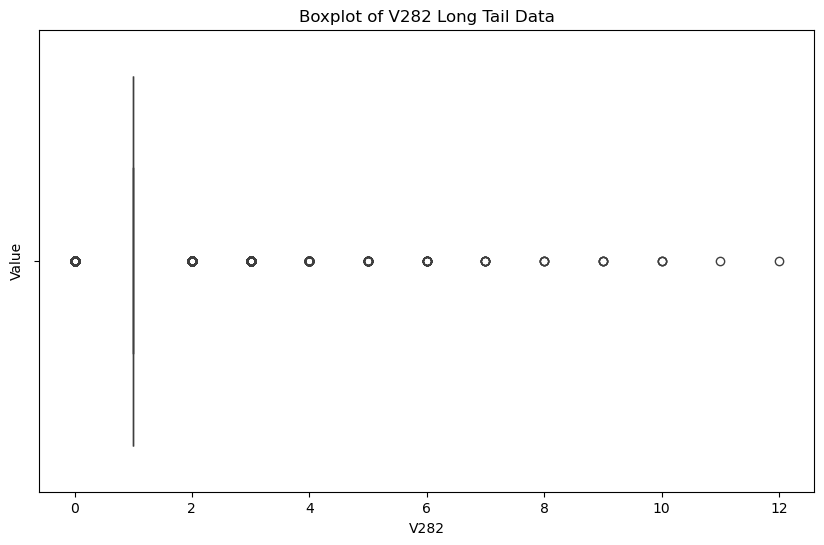

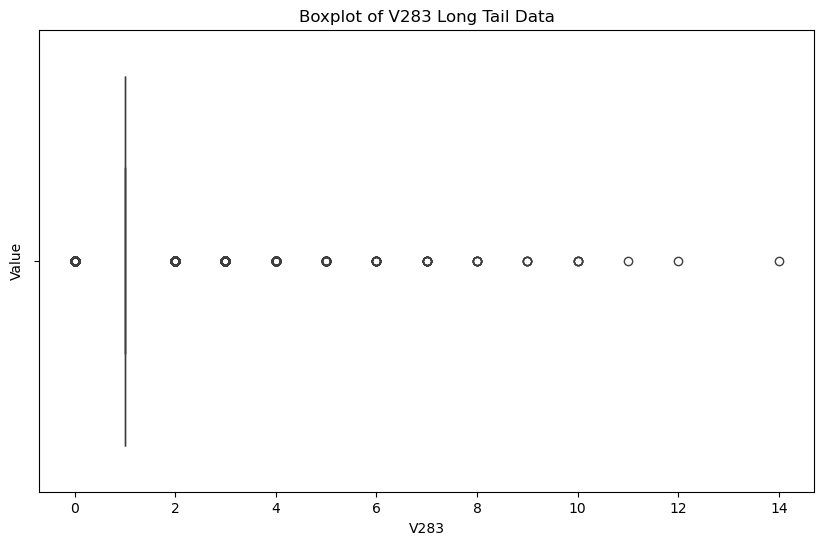

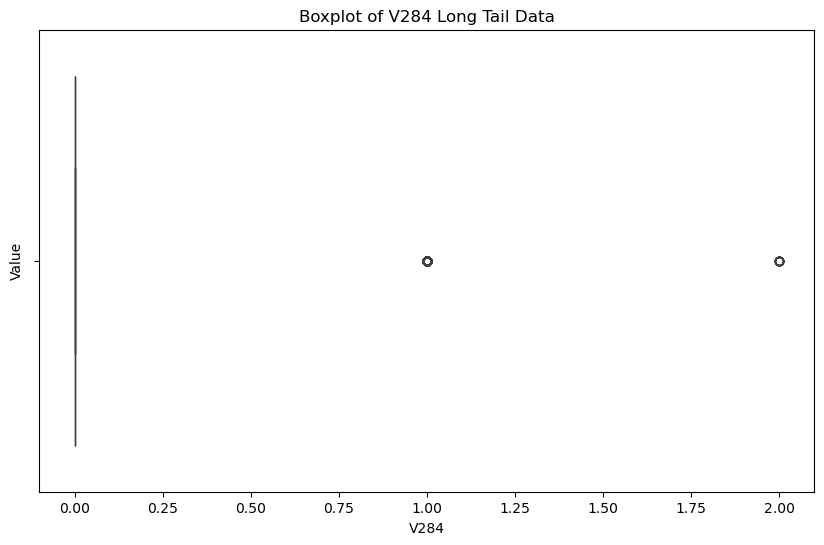

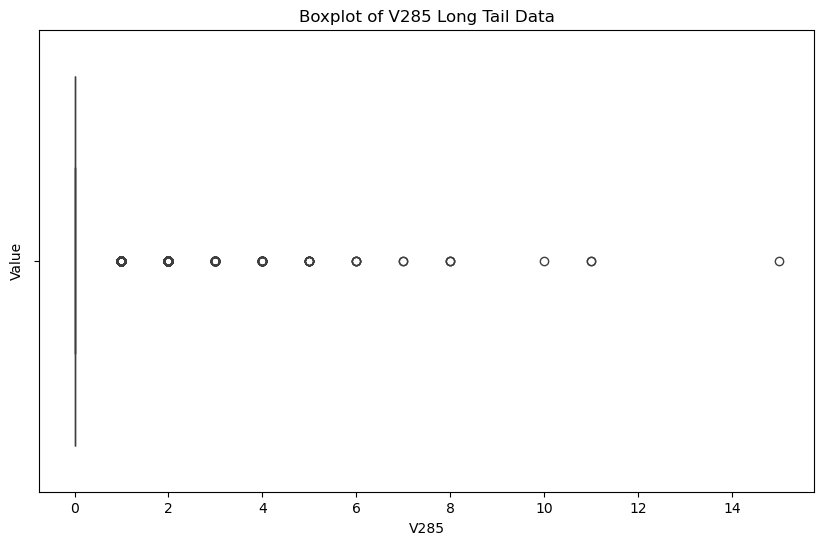

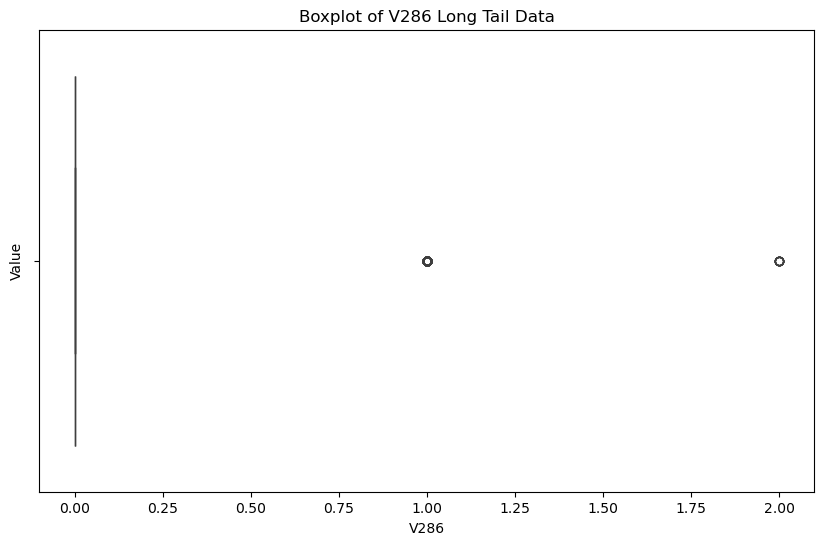

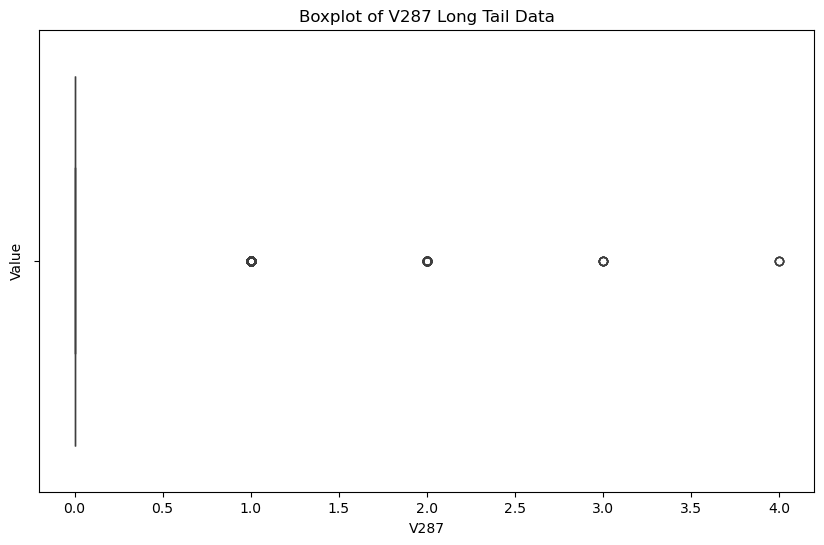

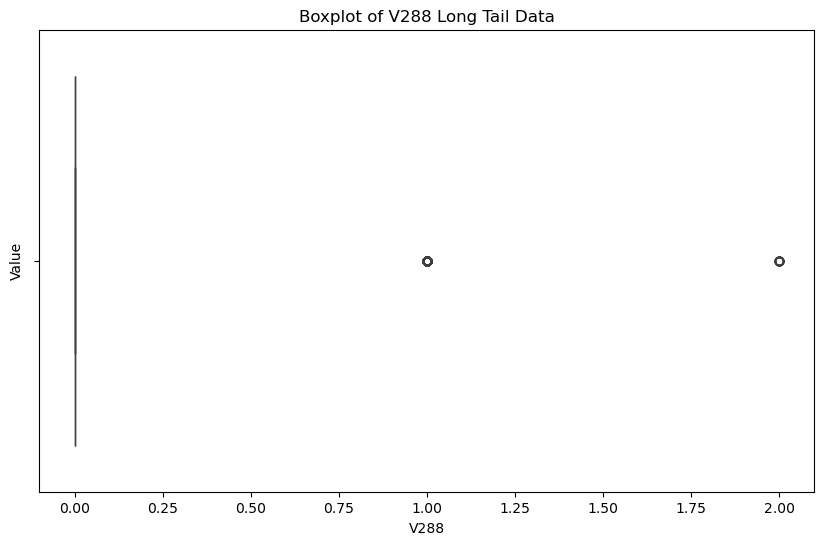

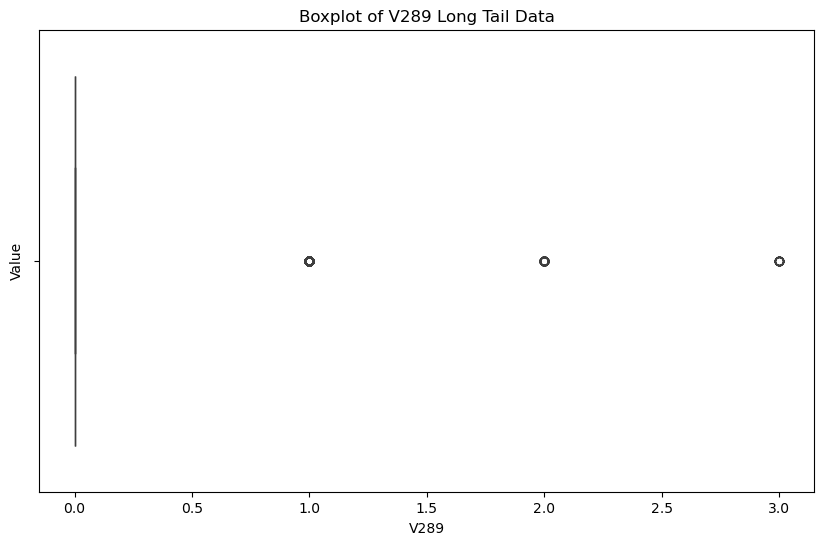

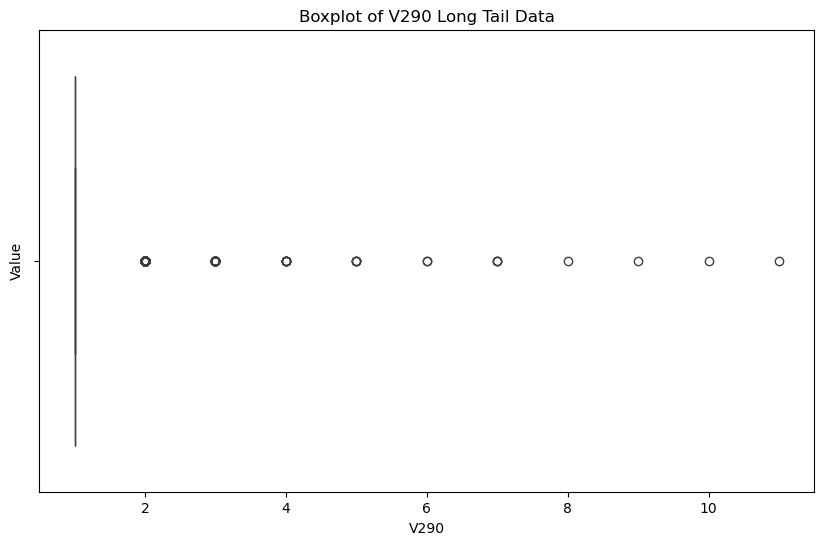

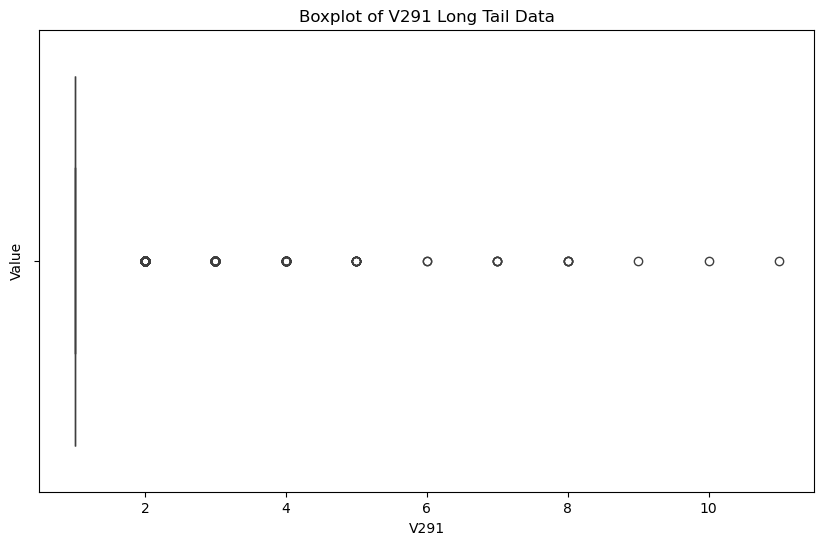

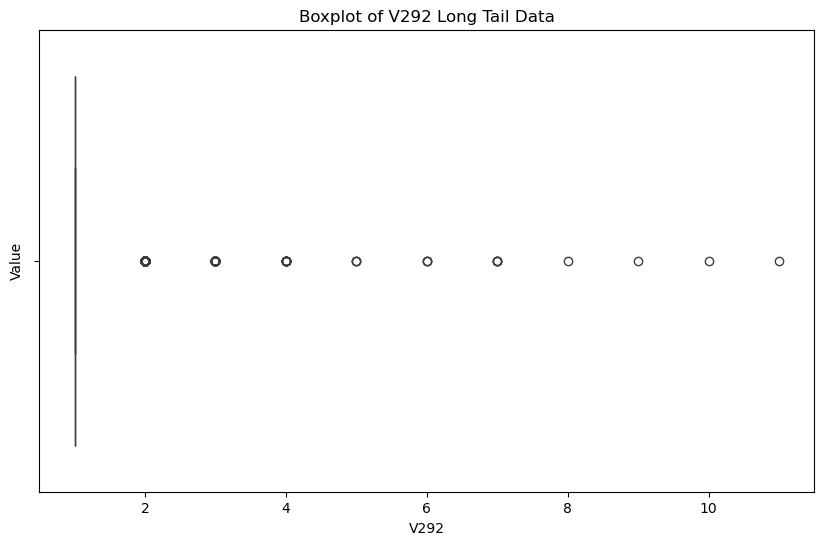

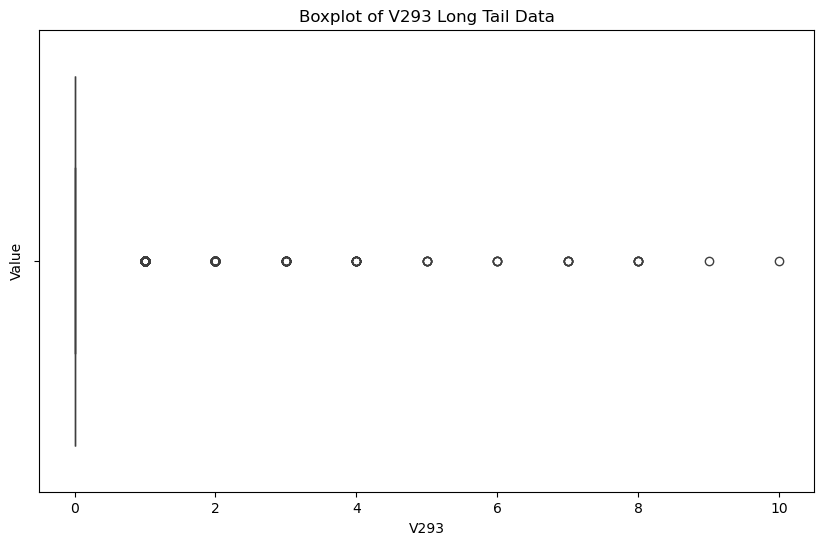

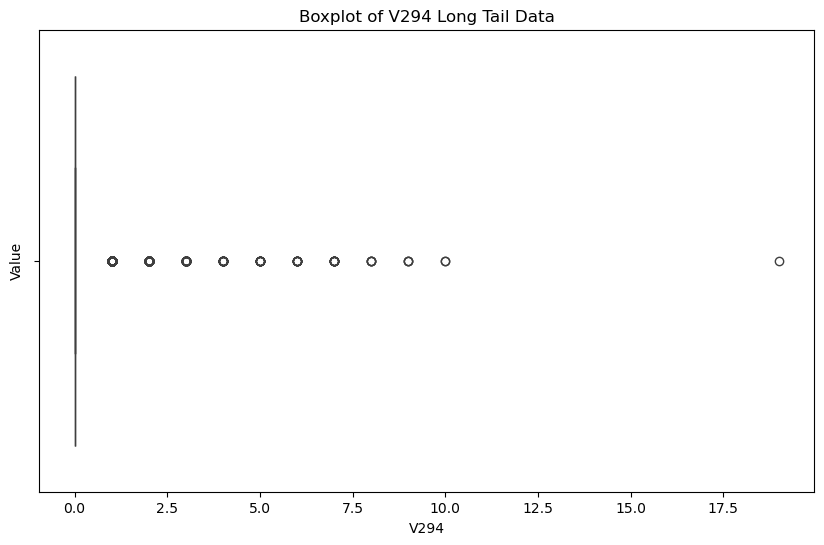

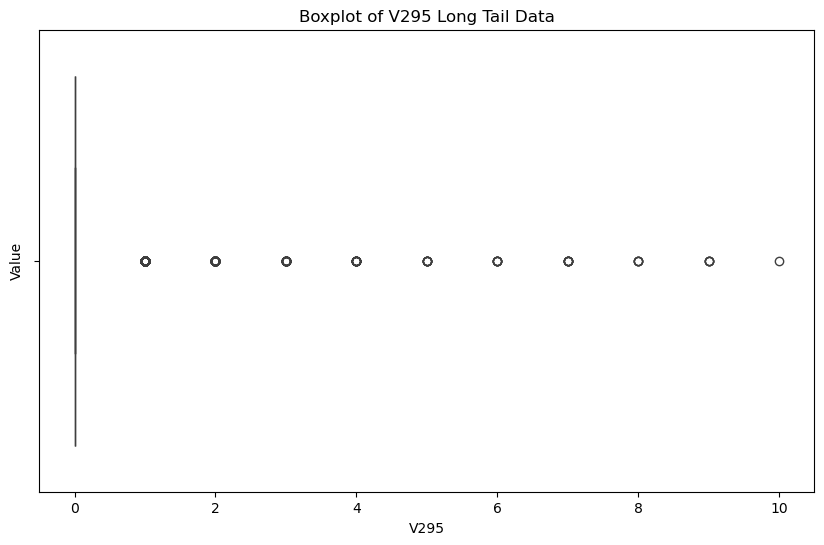

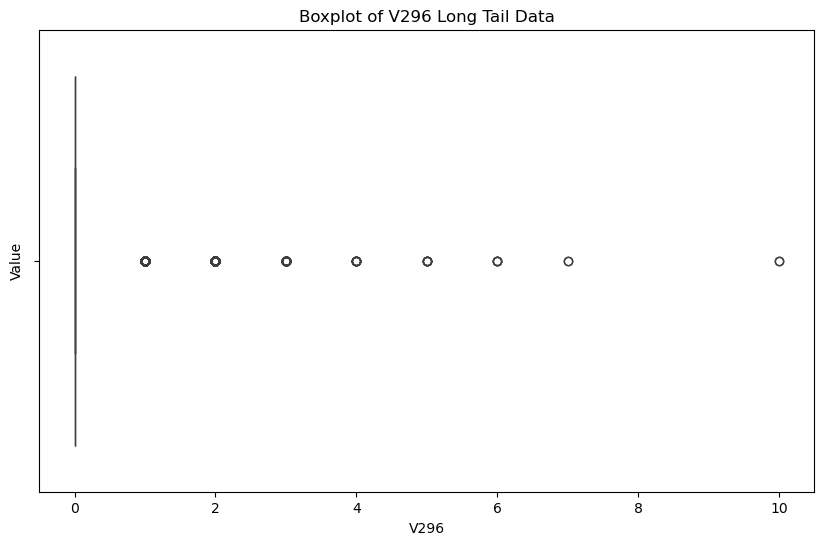

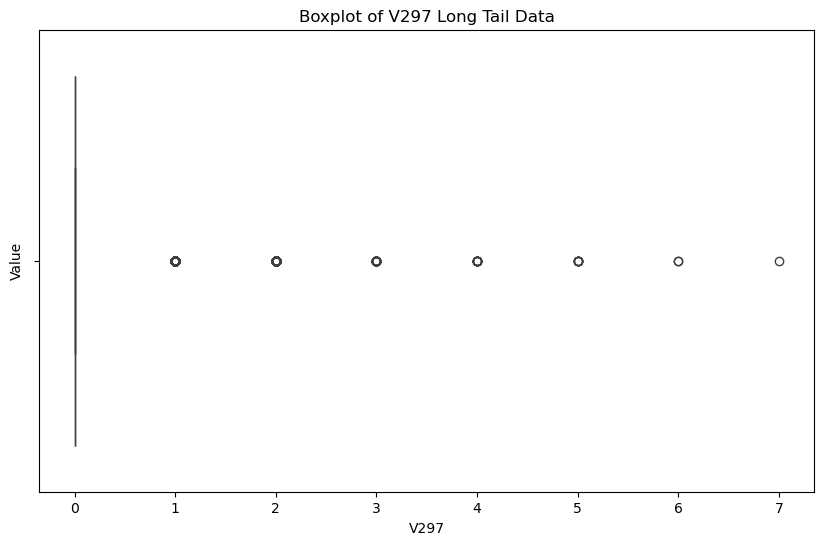

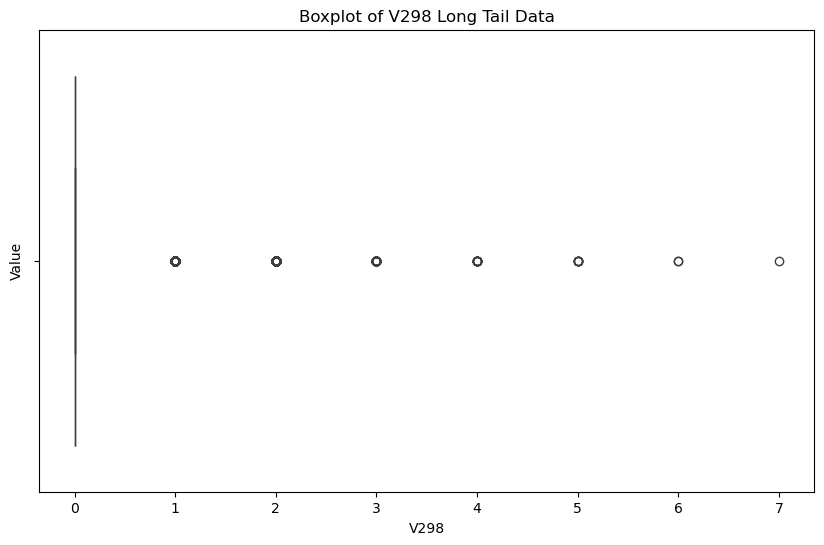

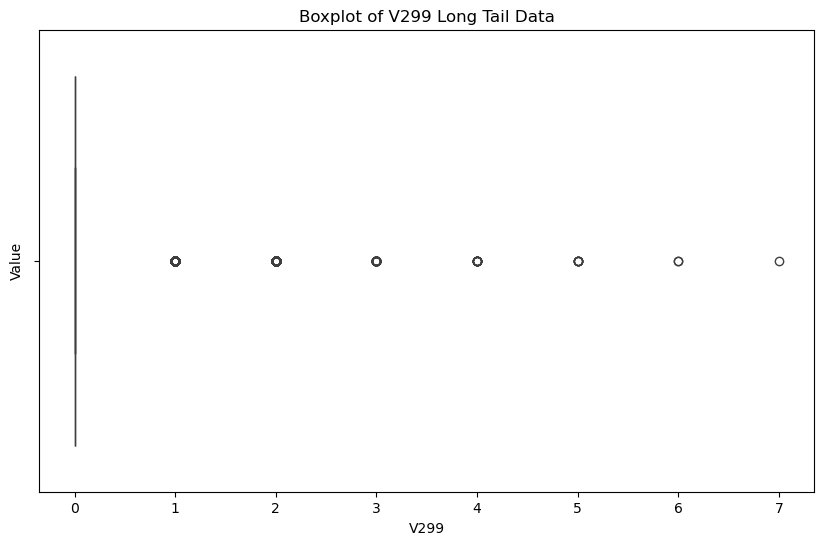

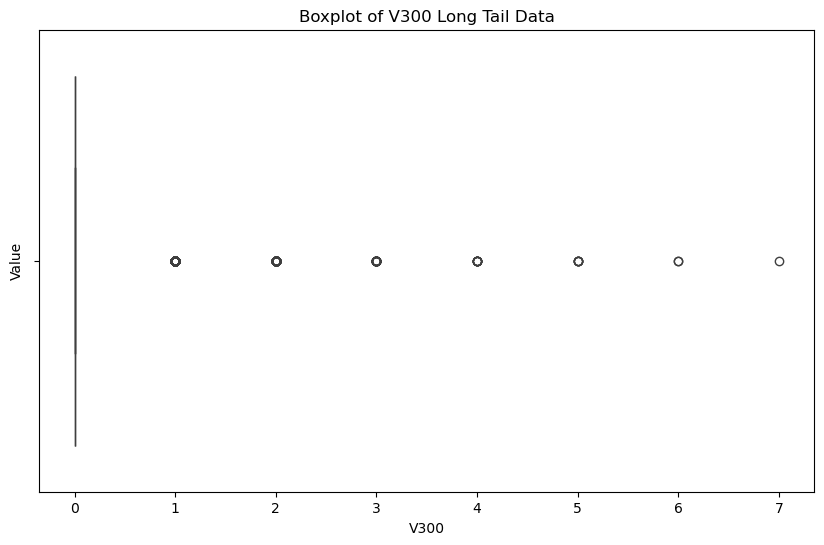

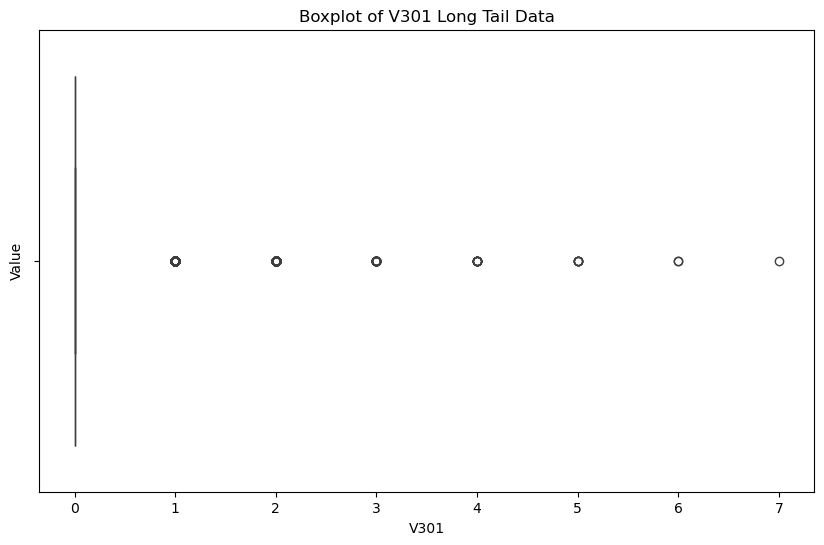

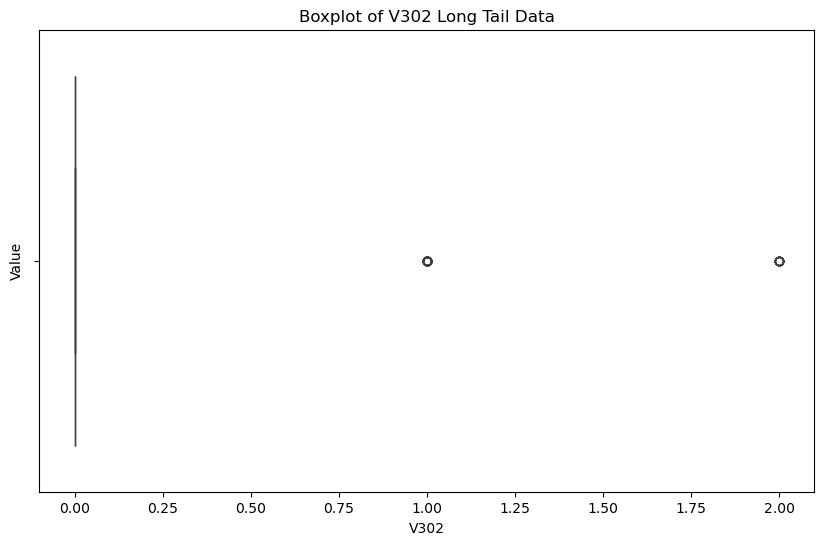

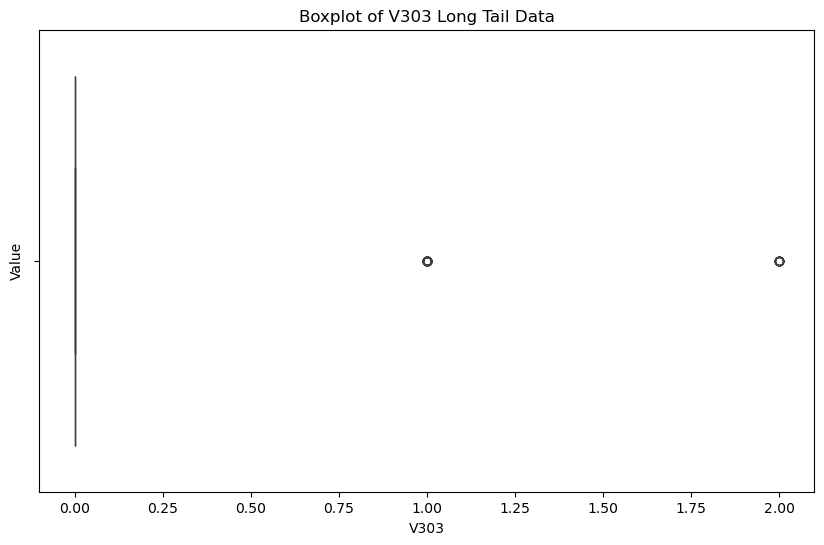

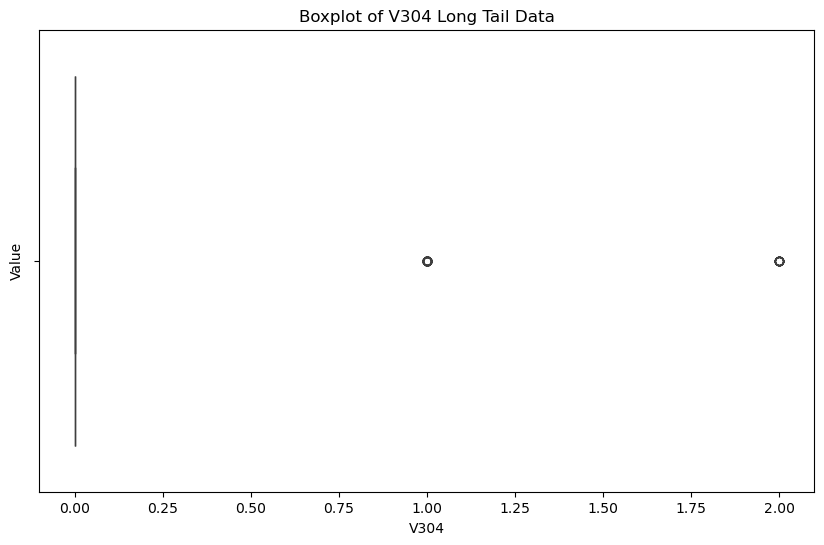

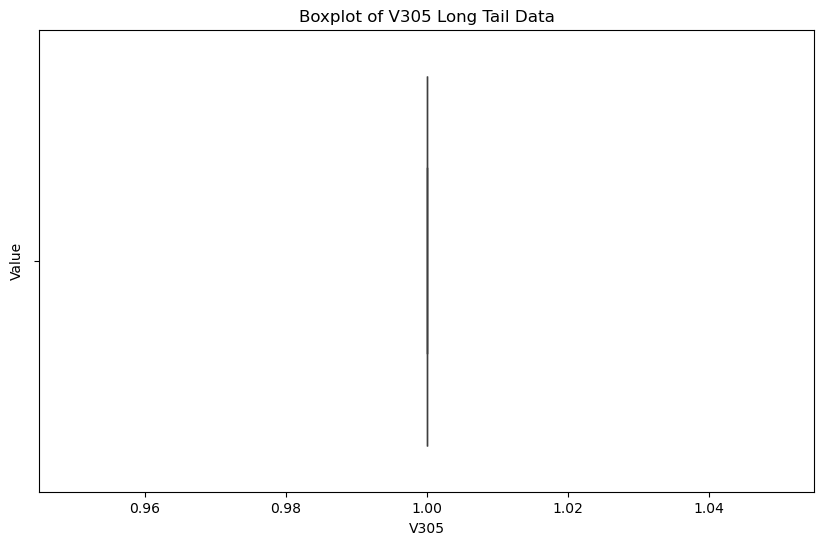

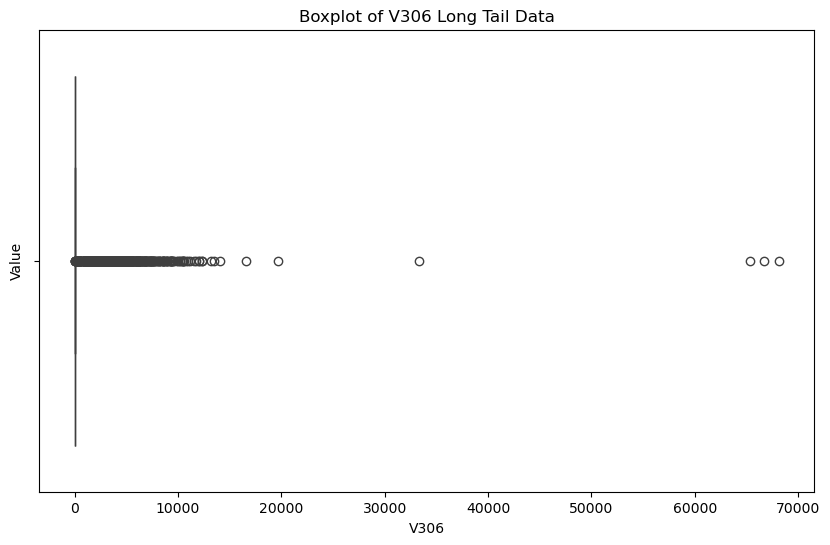

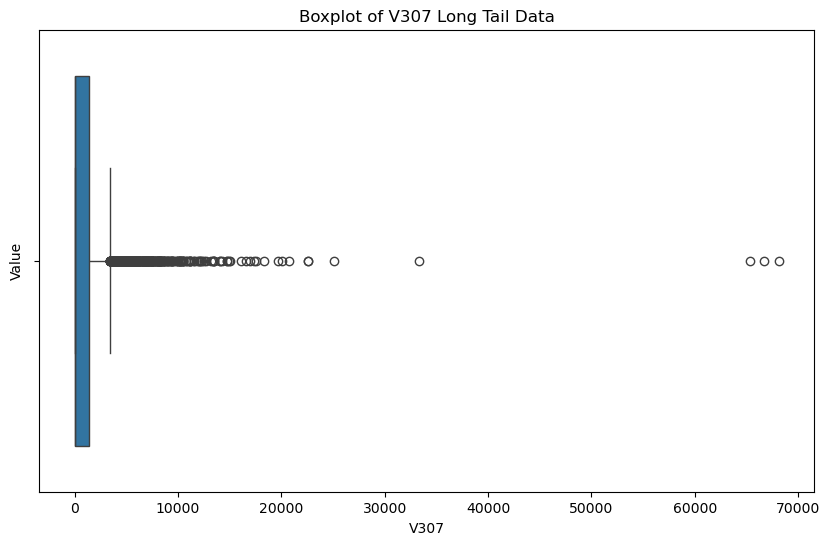

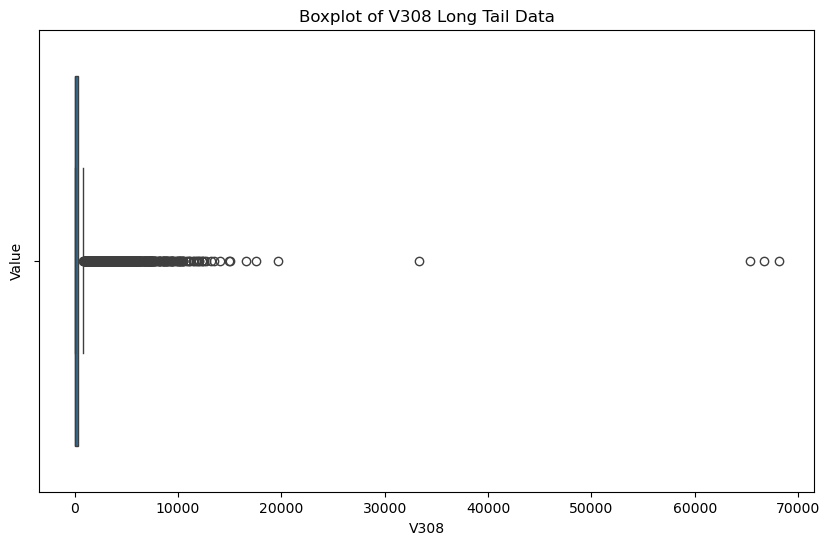

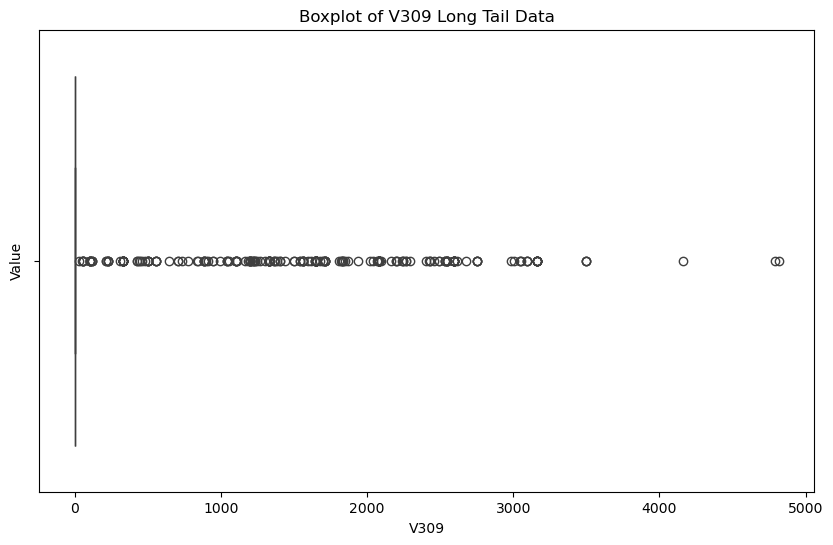

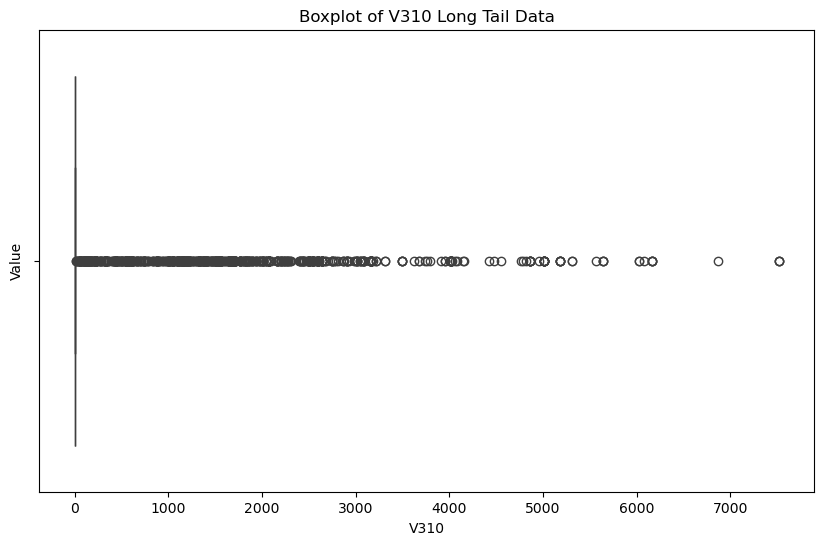

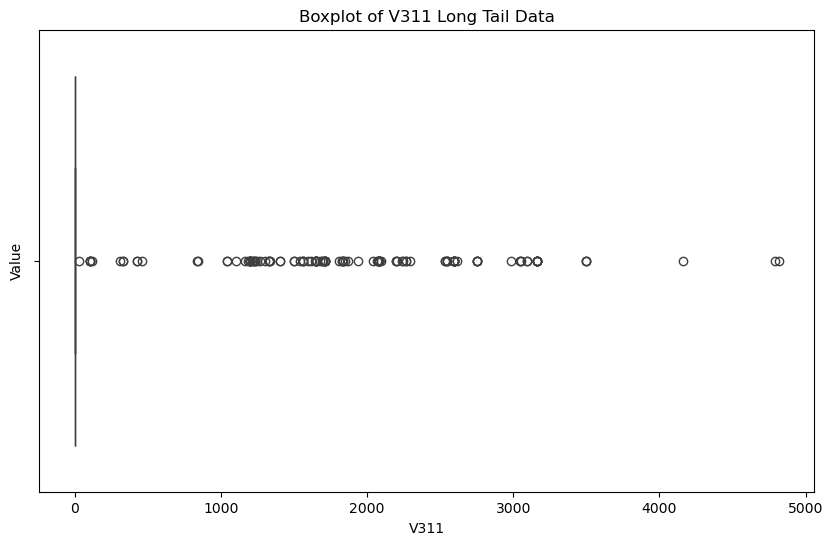

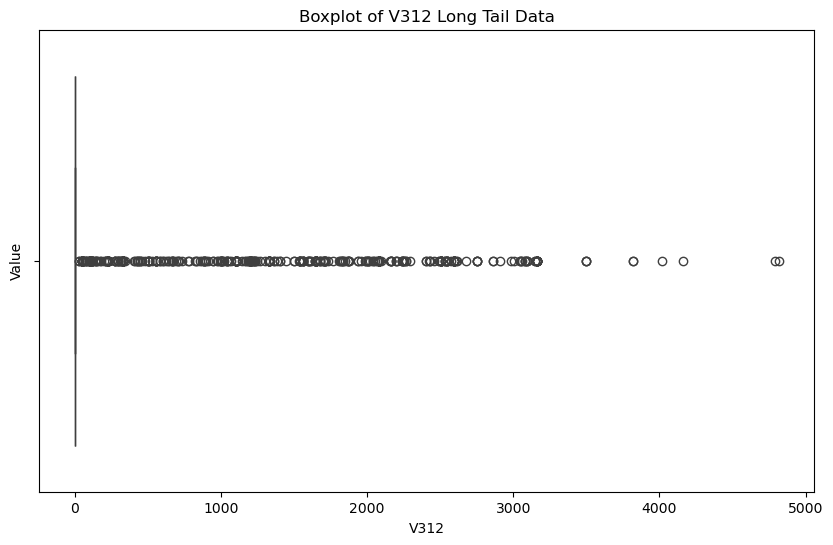

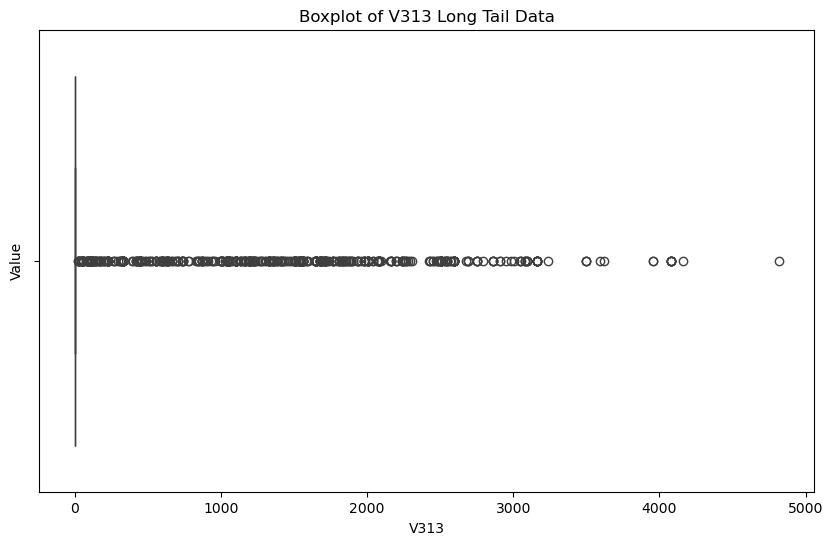

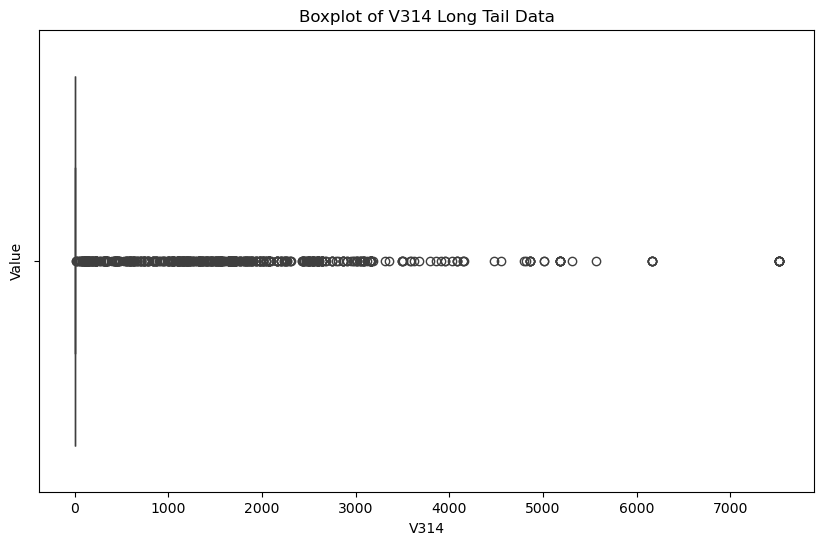

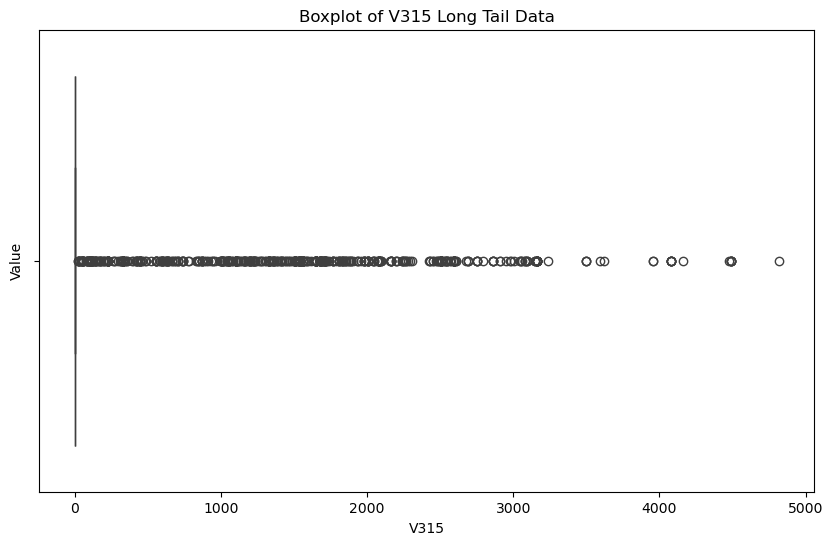

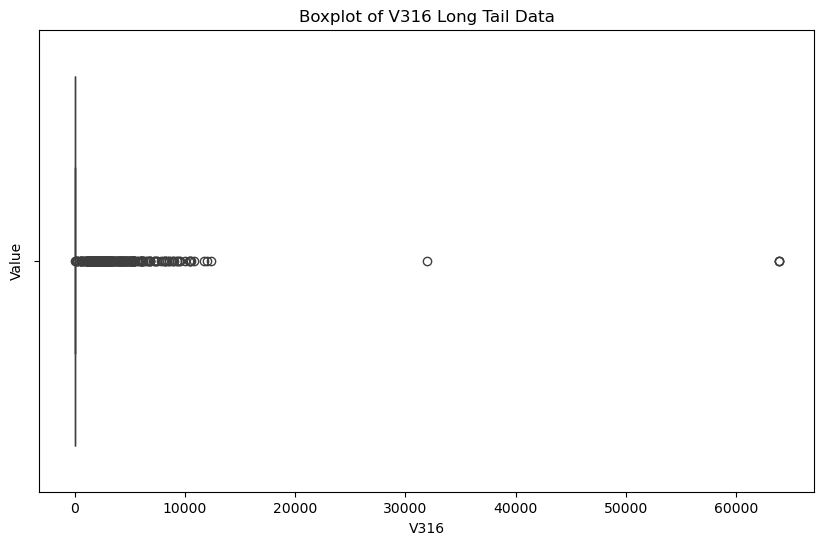

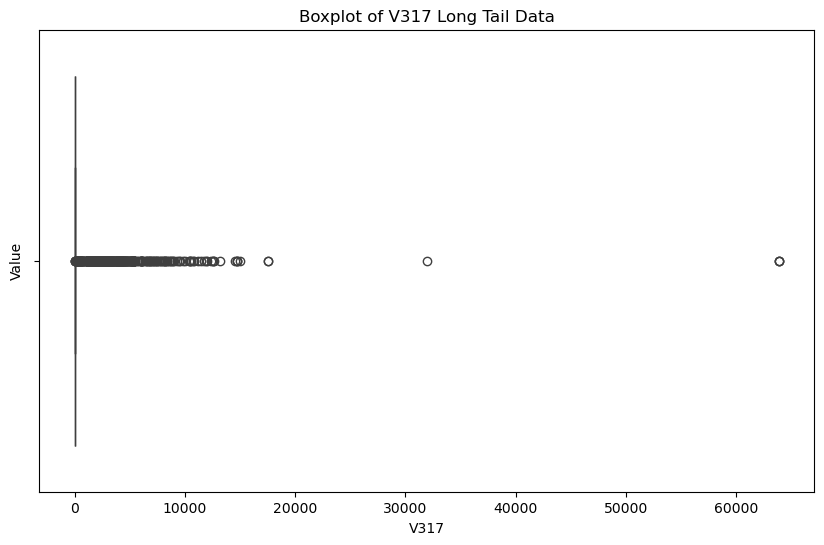

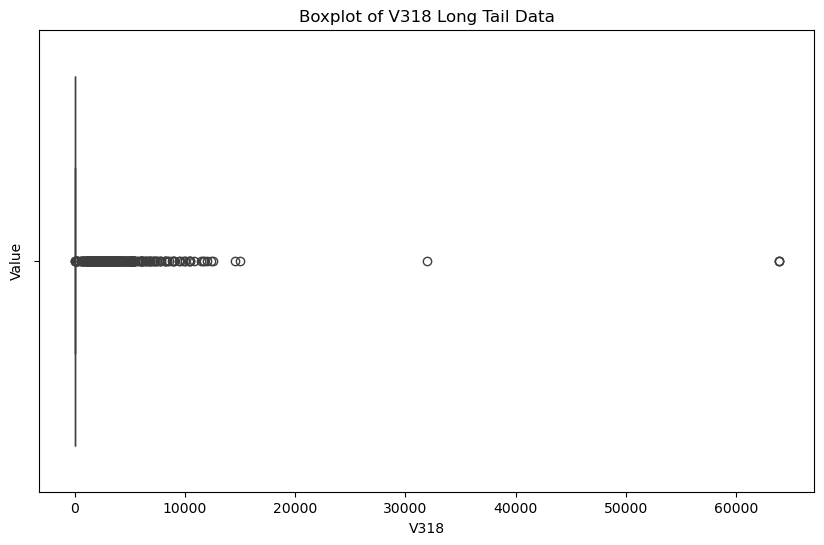

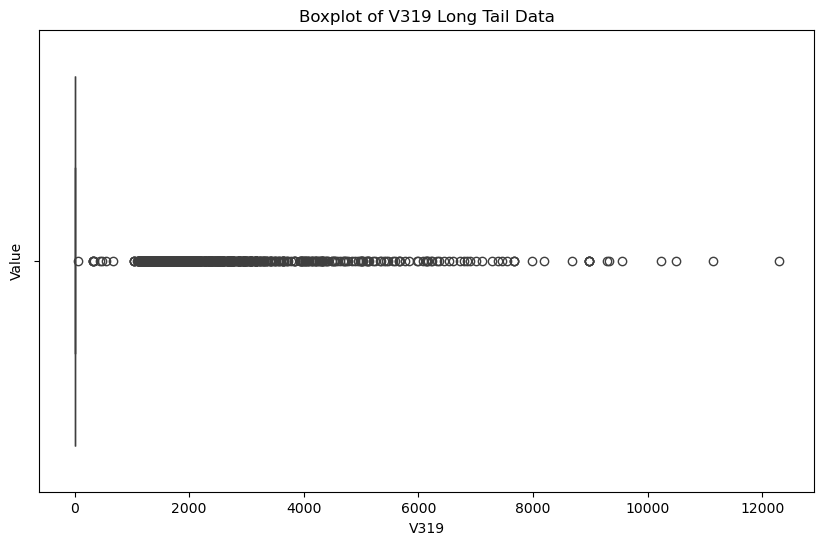

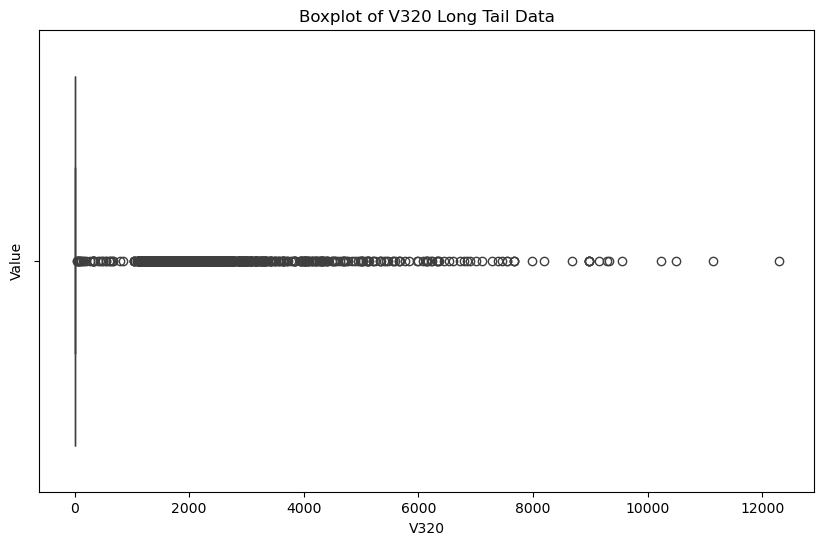

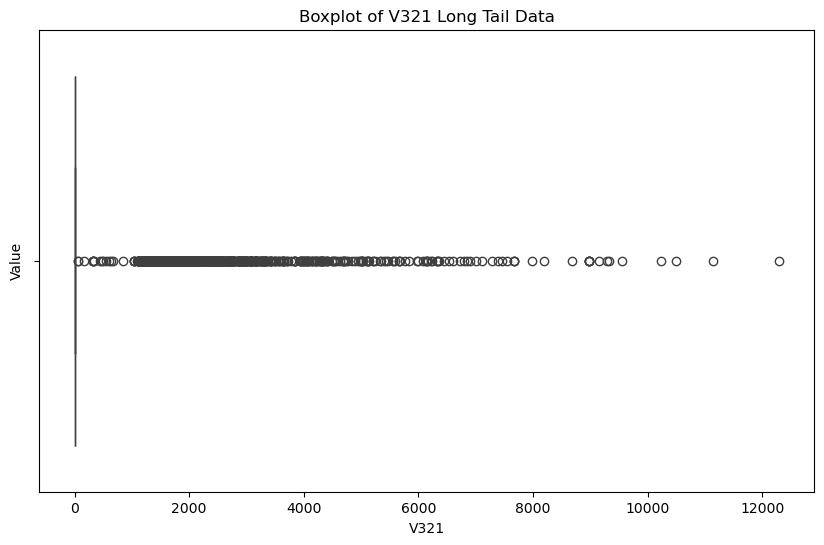

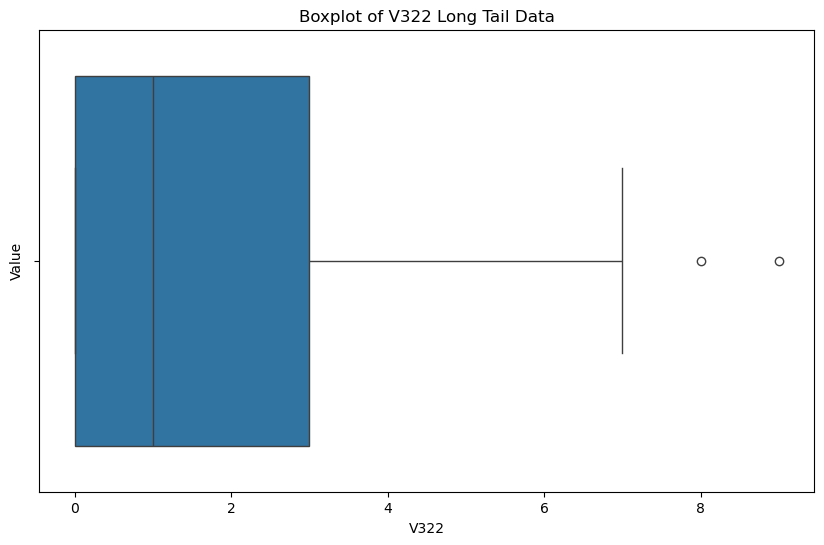

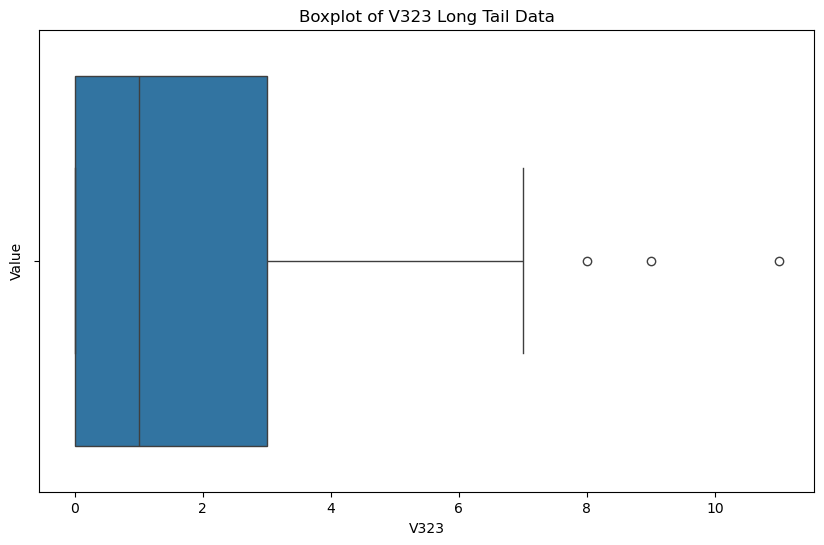

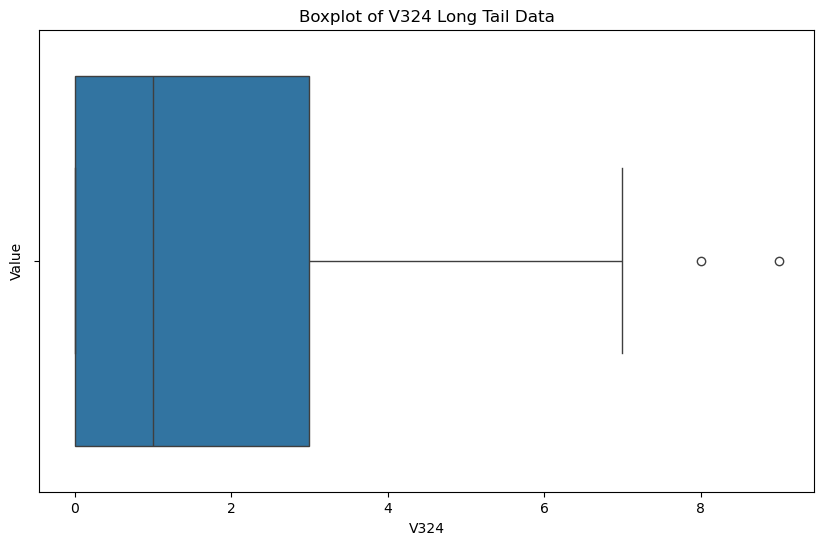

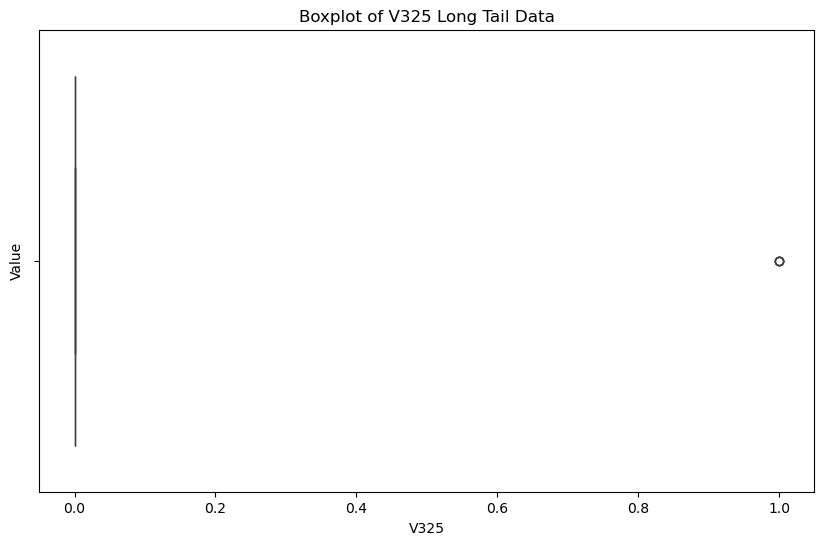

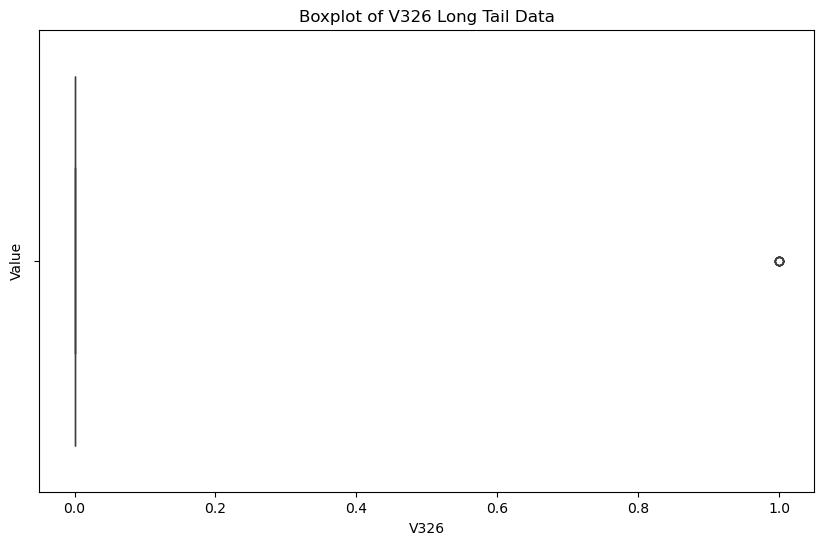

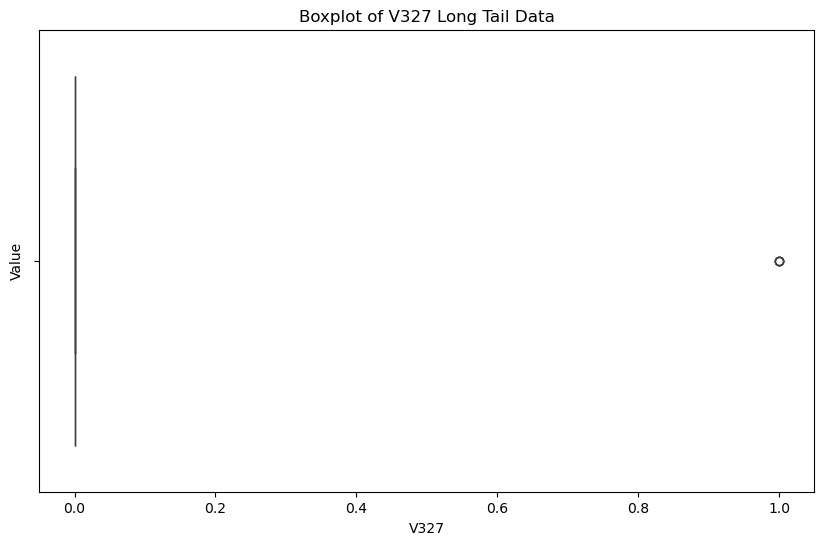

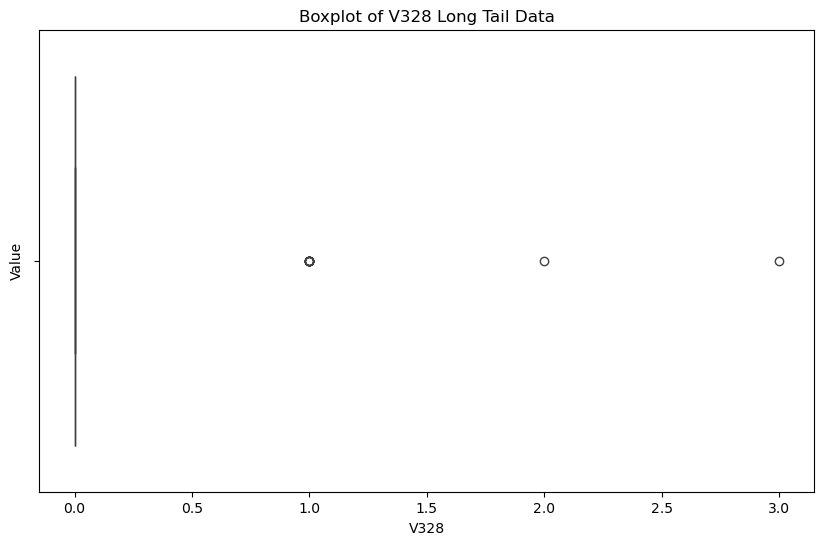

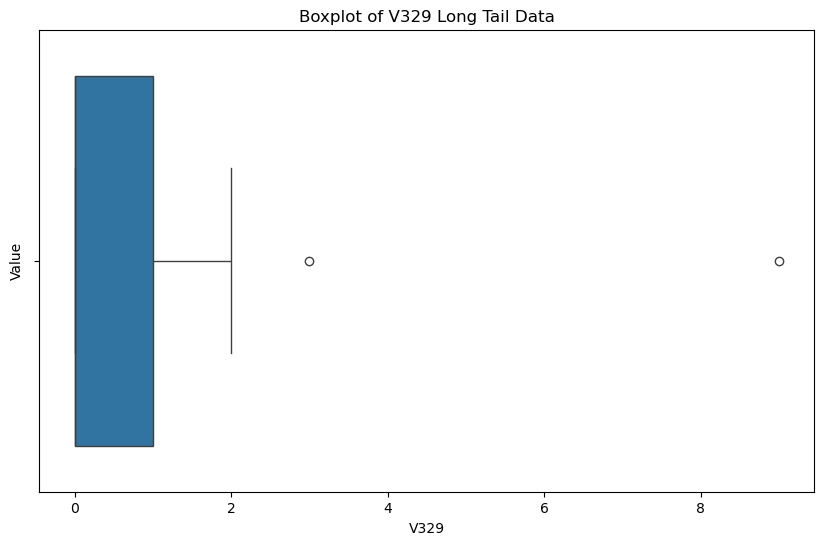

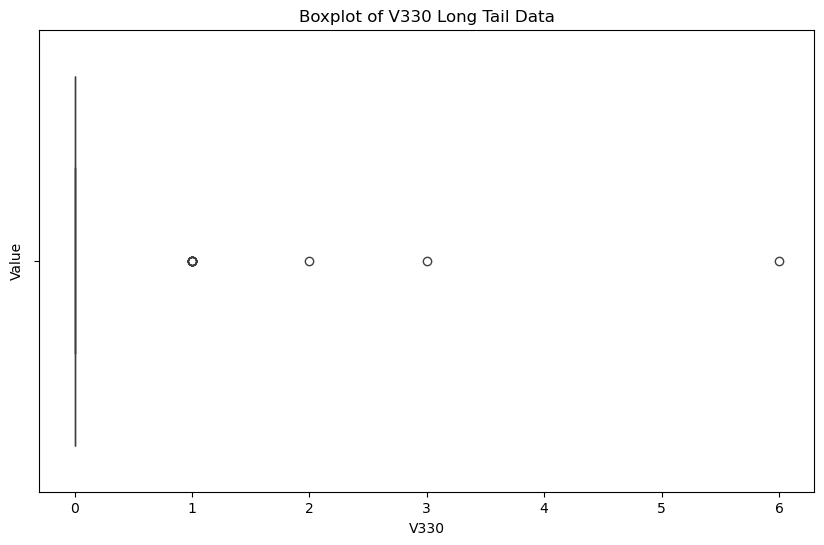

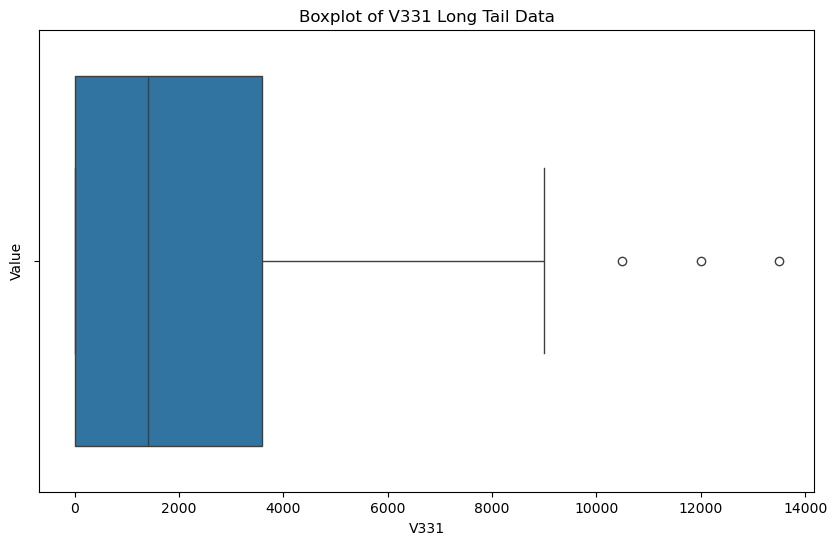

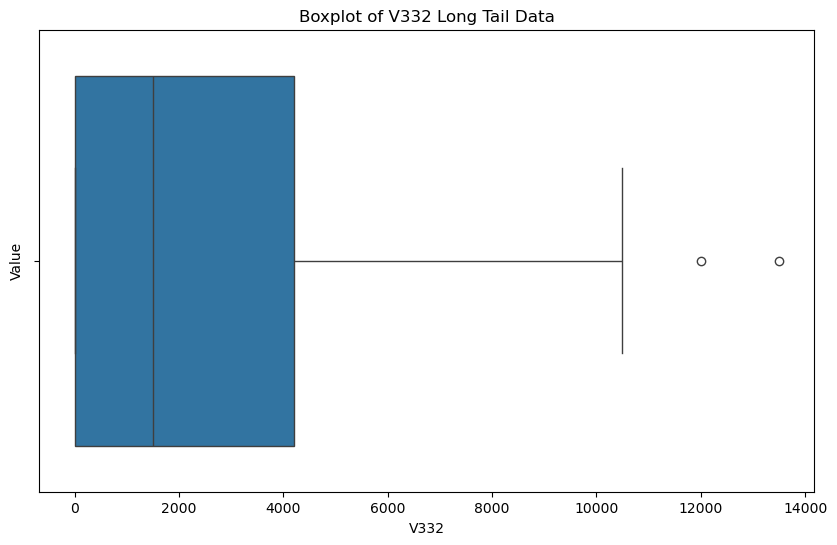

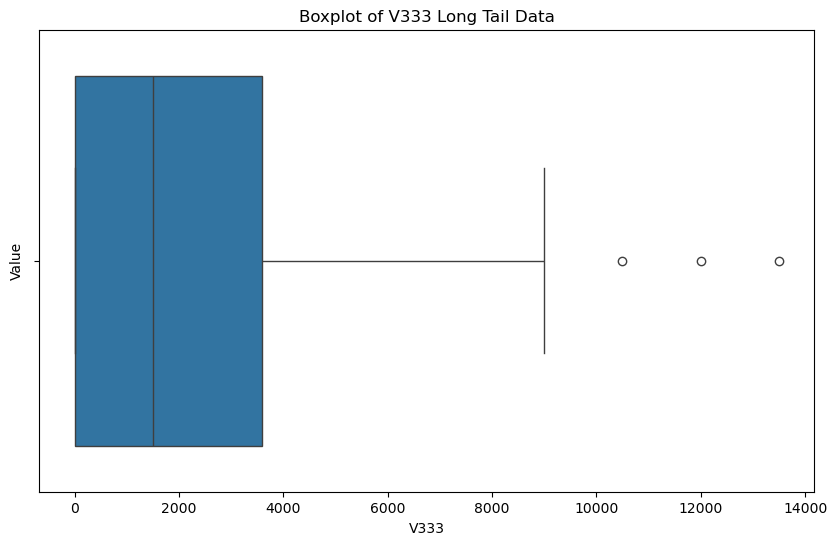

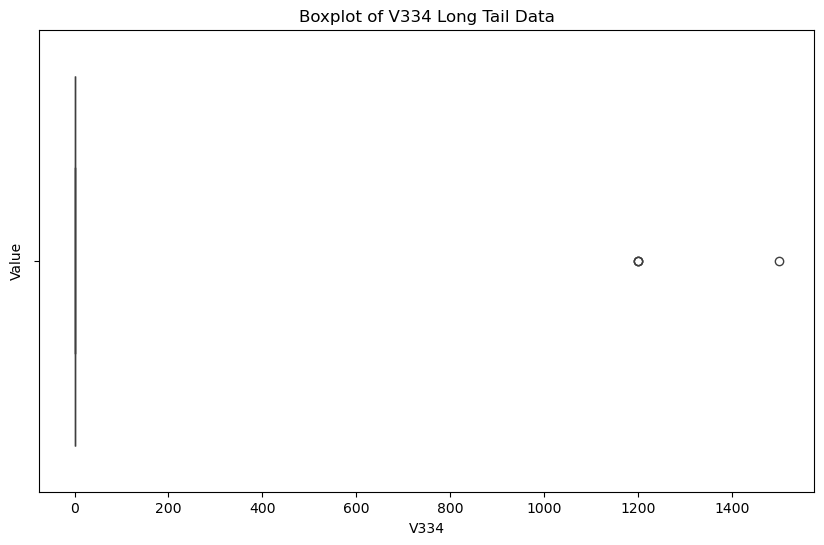

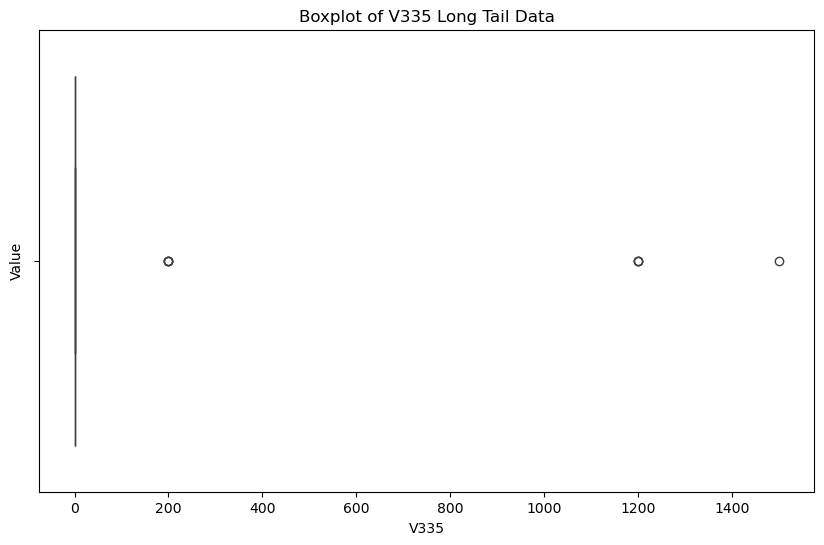

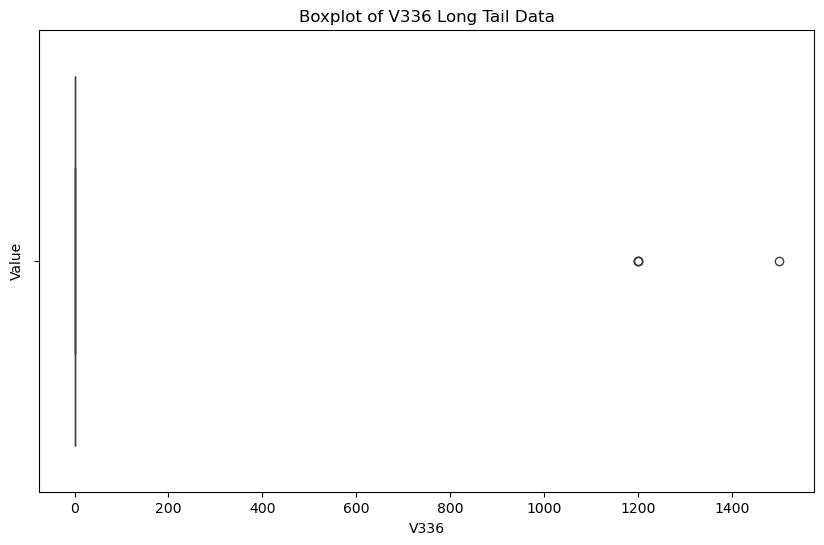

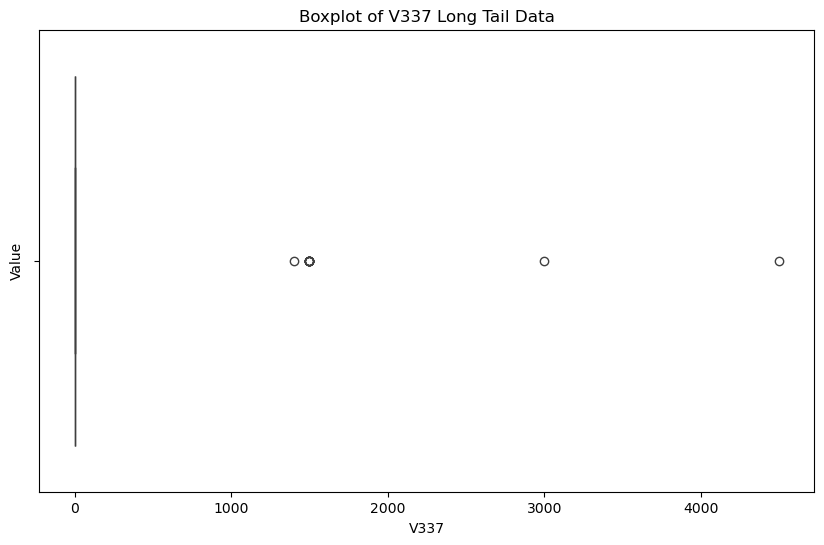

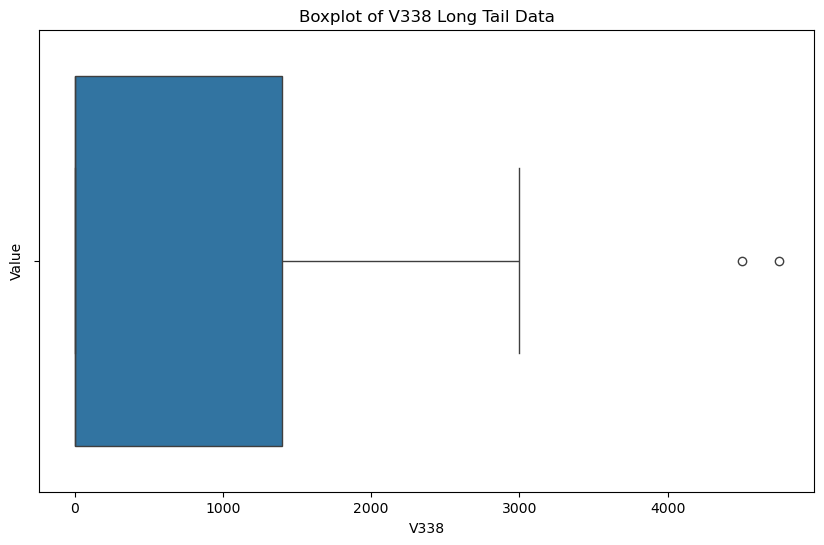

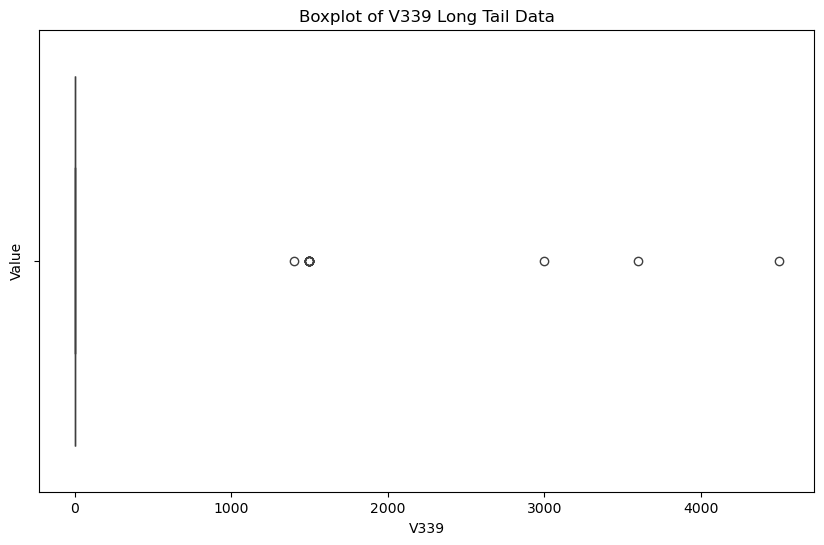

In [7]:
#Long Tail Analysis 
plt.hist(train_transaction['TransactionAmt'],bins=100,log=True)
plt.title('Log-Scaled Histogram of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (log scale)')
plt.show()

long_tail_threshold = train_transaction['TransactionAmt'].quantile(0.99)
long_tail_data = train_transaction[train_transaction['TransactionAmt'] > long_tail_threshold]
long_tail_fraud_ratio = long_tail_data['isFraud'].mean()
print(f"Fraud Ratio in Long-Tail Transactions: {long_tail_fraud_ratio}")

numeric_cols = long_tail_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

for feature in numeric_cols:
    plt.figure(figsize=(10, 6))
    
    sns.boxplot(x=long_tail_data[feature].dropna())
    
    plt.title(f"Boxplot of {feature} Long Tail Data")
    plt.xlabel(feature)
    plt.ylabel("Value")
    plt.show()

In [8]:
#drop columns with 50% of values as missing/null
train_transaction = train_transaction.dropna(thresh=len(train_transaction) * 0.5, axis=1)
#fill missing numerical columns with median
train_transaction.fillna(train_transaction.median(), inplace=True)
#fill missing categorical columns with 'Unknown'
train_transaction.fillna('Unknown', inplace=True)

label_encoders = {}
categorical_features = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'DeviceType']
for col in categorical_features:
    le = LabelEncoder()
    train_transaction[col] = le.fit_transform(train_transaction[col].astype(str))
    label_encoders[col] = le

# One-Hot Encoding for other categorical features
train_transaction = pd.get_dummies(train_transaction, columns=['P_emaildomain', 'R_emaildomain', 'DeviceInfo'], drop_first=True)

TypeError: Cannot convert [['W' 'W' 'W' ... 'W' 'W' 'W']
 ['discover' 'mastercard' 'visa' ... 'mastercard' 'mastercard'
  'mastercard']
 ['credit' 'credit' 'debit' ... 'debit' 'debit' 'credit']
 ...
 ['T' nan 'T' ... 'F' 'T' 'F']
 ['M2' 'M0' 'M0' ... nan 'M0' nan]
 ['T' 'T' 'F' ... 'T' 'T' 'T']] to numeric

In [9]:
# Create Isolation Forest and fit it based on the training data.

forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=15, verbose=0)
forest.fit(train_transaction)

# Generate predictions based on the Isolation Forest

predictions = forest.predict(train_transaction)
print(predictions)

ValueError: could not convert string to float: 'W'